# This script computes/plots:
# ozone response to increased CO2 (4xCO2 and 1pctCO2);
# relation of ozone response and ta, tas, ua, w, wtem change;
# PORT experiments;
# comparison bertween chem and nochem models. 
# for CMIP6 models and SOCOL-MPIOM, SOCOLv4.

In [33]:
#import all necessary packages

import os
from cdo import Cdo
import netCDF4 as nc
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.lines import Line2D
import cmcrameri.cm as cmc  #import from scientific color map
from scipy import stats
from scipy.ndimage import uniform_filter1d
from statistics import median

# Functions

In [34]:
# func: computes tropopause height in Pa

# WMO defination: 
#the lowest level at which the lapse rate decreases
#to 2k/km or less, provided also that the average lapse rate between
#this level and all higher levels within 2 km does not exceed
#2K/km

# func: convert pressure level to latitude in km
def p2km(press):
    # convert pressure levles to altitude in km
    a = 0.3048 * 10**(-3) * 145366.45
    b = 1013.25
    c = 0.190284
    alt = np.zeros_like(press)
    for i in range(0,len(press)):
        alt[i] = a*(1-(press[i]*10**(-2)/b)**c)
    return alt


# func: compute tropopause in Pa

def tropo(alt,pressure,temp):
    # compute the tropopause height in Pa
    # input: 
    #        alt: altitude in meter (time,press,lat)
    #        pressure: plev for temp in Pa
    #        temp: temperature profile from bottom to top (time,press,lat)
    # return:
    #        height of tropopause in Pa

    delta_T = np.zeros_like(temp)
    delta_T_2km = np.zeros_like(temp)
    ind_2km = np.zeros((temp.shape[0],temp.shape[1],temp.shape[2]))
    tropo = np.zeros((temp.shape[0],temp.shape[2]))
    
    alt = alt * 0.001 # convert meter to km
    
    # loop over time
    for t in range(0,temp.shape[0]):
        # loop over lat
        for j in range(0,temp.shape[2]):
            flag_find = 0 # flag of finding the lowest level
            # loop over plev
            for i in range(14,temp.shape[1]-1): # constrain the lowest tropo height to be above 400hPa
                delta_T[t,i,j] = (temp[t,i-1,j] - temp[t,i+1,j])/(alt[t,i+1,j]-alt[t,i-1,j])
                
                # find the index of all the layers which are within 2km above current layer
                for m in range(i,temp.shape[1]-1):
                    if (alt[t,m,j] - alt[t,i,j]) <= 2 and (alt[t,m+1,j] - alt[t,i,j]) > 2:
                        ind_2km[t,i,j] = m

                # compute the average lapse rate within 2km
                delta_T_2km[t,i,j] = \
                    ((temp[t,i,j]) - temp[t,int(ind_2km[t,i,j]),j])/(alt[t,int(ind_2km[t,i,j]),j]-alt[t,i,j])

                # find the lowest level that satisfies the criteria
                if delta_T[t,i,j] <= 2 and delta_T_2km[t,i,j] <= 2 and flag_find == 0:
                    tropo[t,j] = pressure[i]
                    flag_find = 1
    return tropo

In [35]:
# func: compute R2             
def compute_R2(fit,y):
    # input:
    #       fit: fit function
    #       y: y value
    # output: R2
    SSE = fit[1][0]
    SST = np.sum((y-np.mean(y))**2)
    R2 = 1 - SSE/SST
    return(R2)

In [36]:
# vars declaration
experiment = ["piControl","abrupt-4xCO2","1pctCO2"]

# model name of all models, with the first 12 being interactive chemistry models
model_name = ["CESM2-WACCM_","CESM2-WACCM-FV2_","CNRM-CM6-1_","CNRM-CM6-1-HR_",\
              "CNRM-ESM2-1_","E3SM-1-0_","GFDL-ESM4_","GISS-E2-1-G_p3_","MRI-ESM2-0_",\
              "SOCOL-MPIOM_","SOCOLv4_","UKESM1-0-LL_","AWI-ESM-1-1-LR","CESM2_","CESM2-FV2_",\
              "FGOALS-g3_","MPI-ESM-1-2-HAM_","MPI-ESM1-2-HR_","MPI-ESM1-2-LR_",\
              "NorESM2-LM_","NorESM2-MM_", "SAM0-UNICON_"] #,"GISS-E2-2-G_p3_"

# model name for tas analysis: add GISS-E2-1-G_p1
model_name_tas = ["CESM2-WACCM_","CESM2-WACCM-FV2_","CNRM-CM6-1_","CNRM-CM6-1-HR_",\
              "CNRM-ESM2-1_","E3SM-1-0_","GFDL-ESM4_","GISS-E2-1-G_p3_","GISS-E2-2-G_p3_","MRI-ESM2-0_",\
              "SOCOL-MPIOM_","SOCOLv4_","UKESM1-0-LL_","AWI-ESM-1-1-LR","CESM2_","CESM2-FV2_",\
              "FGOALS-g3_","GISS-E2-1-G_p1_","MPI-ESM-1-2-HAM_","MPI-ESM1-2-HR_","MPI-ESM1-2-LR_",\
              "NorESM2-LM_","NorESM2-MM_", "SAM0-UNICON_"] 

n_model = 22 # total number of model
n_model_tas = 23
n_chem = 12
n_chem_4CO2 = 12 # number of interactive chemistry model for 4CO2
n_chem_1pct = 11 # number of interactive chemistry model for 1pct
flag_chem = np.zeros(n_model) # flag of chem model 
flag_chem[0:n_chem] = 1
pi_4CO2_start = 50 # ind of 4CO2 start year when computing diff_(4CO2 - pi)
pi_4CO2_end = 150 # ind of 4CO2 end year when computing diff_(4CO2 - pi)
pi_1pct_start = 134 # ind of 4CO2 start year when computing diff_(1pctCO2 - pi)
pi_1pct_end = 145 # ind of 4CO2 end year when computing diff_(1pctCO2 - pi)

In [37]:
### colormap
colors_m = {
    "CESM2-WACCM_": "#E69F00",  # Orange
    "CESM2-WACCM-FV2_": "#56B4E9",  # Sky Blue
    "CNRM-CM6-1_": "#20B2AA",  # Light Sea Green
    "CNRM-CM6-1-HR_": "#F0E442",  # Yellow
    "CNRM-ESM2-1_": "#0072B2",  # Blue
    "E3SM-1-0_": "#FB9A99",   # Light Red-Pink 
    "GFDL-ESM4_": "#D55E00",  # Vermilion
    "GISS-E2-1-G_p3_": "#CC79A7",  # Purple Pink
    "MRI-ESM2-0_": "#999999",  # Grey
    "SOCOL-MPIOM_": "#B15928",  # Brown
    "SOCOLv4_": "#6A5ACD",  # Slate Blue
    "UKESM1-0-LL_": "#33A02C",  # Medium Green
}

# The follwing part first computes tropopause using vertically interpolated geo_height and air temp for all models except for SOCOL-MPIOM and SOCOLv4, then read in tropopause data for SOCOL models.

In [38]:
# read in geo_height
path_zg_am_zm = "../data/geo_height/am_zm_vertical_interpolate"
path_zg_tm_zm = "../data/geo_height/tm_zm_vertical_interpolate"
species = "zg"

zg_am_zm_inter_piControl_masked = dict()
zg_am_zm_inter_4CO2_masked = dict()
zg_am_zm_inter_1pct_masked = dict()

zg_tm_zm_inter_piControl_masked = dict()
zg_tm_zm_inter_4CO2_masked = dict()
zg_tm_zm_inter_1pct_masked = dict()


for i in range(0,len(model_name)): 
    # read zg am_zm data
    for f in os.listdir(path_zg_am_zm):
        if os.path.isfile(os.path.join(path_zg_am_zm,f)) and (model_name[i] in f): 
            if experiment[0] in f:
                am_zm_inter_piControl = nc.Dataset(os.path.join(path_zg_am_zm,f)).variables[species][:]
                zg_am_zm_inter_piControl_masked[model_name[i]] = ma.masked_values(am_zm_inter_piControl, 1e20)
                print("pi",model_name[i],np.shape(zg_am_zm_inter_piControl_masked.get(model_name[i])))
            if experiment[1] in f:
                am_zm_inter_4CO2 = nc.Dataset(os.path.join(path_zg_am_zm,f)).variables[species][:]
                zg_am_zm_inter_4CO2_masked[model_name[i]] = ma.masked_values(am_zm_inter_4CO2, 1e20)
                print("4CO2",model_name[i],np.shape(zg_am_zm_inter_4CO2_masked.get(model_name[i])))
            if experiment[2] in f and ("all" in f):
                am_zm_inter_1pct = nc.Dataset(os.path.join(path_zg_am_zm,f)).variables[species][:]
                zg_am_zm_inter_1pct_masked[model_name[i]] = ma.masked_values(am_zm_inter_1pct, 1e20)
                print("1pct",model_name[i],np.shape(zg_am_zm_inter_1pct_masked.get(model_name[i])))

     # read zg tm_zm data                      
    for f in os.listdir(path_zg_tm_zm):
        if os.path.isfile(os.path.join(path_zg_tm_zm,f)) and (model_name[i] in f):
            if experiment[0] in f:
                tm_zm_inter_piControl = nc.Dataset(os.path.join(path_zg_tm_zm,f)).variables[species][:]
                zg_tm_zm_inter_piControl_masked[model_name[i]] = ma.masked_values(tm_zm_inter_piControl, 1e20)
                print("pi",model_name[i],np.shape(zg_tm_zm_inter_piControl_masked.get(model_name[i])))
            if experiment[1] in f:
                tm_zm_inter_4CO2 = nc.Dataset(os.path.join(path_zg_tm_zm,f)).variables[species][:]
                zg_tm_zm_inter_4CO2_masked[model_name[i]] = ma.masked_values(tm_zm_inter_4CO2, 1e20)
                print("4CO2",model_name[i],np.shape(zg_tm_zm_inter_4CO2_masked.get(model_name[i])))
            if experiment[2] in f and ("135-145" in f):
                tm_zm_inter_1pct = nc.Dataset(os.path.join(path_zg_tm_zm,f)).variables[species][:]
                zg_tm_zm_inter_1pct_masked[model_name[i]] = ma.masked_values(tm_zm_inter_1pct, 1e20)
                print("1pct",model_name[i],np.shape(zg_tm_zm_inter_1pct_masked.get(model_name[i])))


1pct CESM2-WACCM_ (150, 40, 192)
4CO2 CESM2-WACCM_ (150, 40, 192)
pi CESM2-WACCM_ (150, 40, 192)
1pct CESM2-WACCM_ (1, 40, 192)
4CO2 CESM2-WACCM_ (1, 40, 192)
pi CESM2-WACCM_ (1, 40, 192)
1pct CESM2-WACCM-FV2_ (150, 40, 96)
4CO2 CESM2-WACCM-FV2_ (150, 40, 96)
pi CESM2-WACCM-FV2_ (150, 40, 96)
1pct CESM2-WACCM-FV2_ (1, 40, 96)
4CO2 CESM2-WACCM-FV2_ (1, 40, 96)
pi CESM2-WACCM-FV2_ (1, 40, 96)
1pct CNRM-CM6-1_ (150, 40, 128)
pi CNRM-CM6-1_ (150, 40, 128)
4CO2 CNRM-CM6-1_ (150, 40, 128)
1pct CNRM-CM6-1_ (1, 40, 128)
4CO2 CNRM-CM6-1_ (1, 40, 128)
pi CNRM-CM6-1_ (1, 40, 128)
pi CNRM-CM6-1-HR_ (150, 40, 360)
1pct CNRM-CM6-1-HR_ (150, 40, 360)
4CO2 CNRM-CM6-1-HR_ (150, 40, 360)
1pct CNRM-CM6-1-HR_ (1, 40, 360)
4CO2 CNRM-CM6-1-HR_ (1, 40, 360)
pi CNRM-CM6-1-HR_ (1, 40, 360)
1pct CNRM-ESM2-1_ (150, 40, 128)
4CO2 CNRM-ESM2-1_ (150, 40, 128)
pi CNRM-ESM2-1_ (150, 40, 128)
1pct CNRM-ESM2-1_ (1, 40, 128)
4CO2 CNRM-ESM2-1_ (1, 40, 128)
pi CNRM-ESM2-1_ (1, 40, 128)
1pct E3SM-1-0_ (150, 40, 180)
4CO2 E

In [39]:
# read in am_zm interpolated temp profile
path_temp_am = "../data/temp/am_zm_vertical_interpolate"
species = "ta"

temp_am_inter_piControl_masked = dict()
temp_am_inter_4CO2_masked = dict()
temp_am_inter_1pct_masked = dict()

tropo_am_piControl_compute = dict()
tropo_am_4CO2_compute = dict()
tropo_am_1pct_compute = dict()
tropo_am_diff_4CO2_compute = dict()
tropo_am_diff_1pct_compute = dict()

tropo_tm_piControl_compute = dict()
tropo_tm_4CO2_compute = dict()
tropo_tm_1pct_compute = dict()
tropo_tm_diff_4CO2_compute = dict()
tropo_tm_diff_1pct_compute = dict()

lat_temp = dict()

pressure_inter = [99542.4432,97142.2102,93970.5791,90242.1403,86120.4472,81734.0378,77192.5845,\
72577.8739,67944.9722,63338.7790,58795.4623,54338.9949,49987.8639,45762.0037,\
41679.6710,37749.3246,33982.0442,30398.8207,27012.7453,23831.6096,20865.6353,\
18115.0357,15578.0552,13238.8245,11065.4847,9101.9210,7405.9442,5964.3310,\
4751.7661,3743.0629,2913.6250,2235.4370,1684.5830,1245.0630,901.090,637.4813,\
440.0099,295.7139,192.9161,121.5318]

#print(pressure_inter)

# compute tropopause time series for piControl, 4CO2 and 1pct_all using the function
for i in range(0,len(model_name)): 
    for f in os.listdir(path_temp_am):
        if os.path.isfile(os.path.join(path_temp_am,f)) and (model_name[i] in f): 
           
            if experiment[0] in f:
                temp_am_inter_piControl = nc.Dataset(os.path.join(path_temp_am,f)).variables[species][:]
                lat_temp[model_name[i]] = nc.Dataset(os.path.join(path_temp_am,f)).variables["lat"][:]
                temp_am_inter_piControl_masked[model_name[i]] = ma.masked_values(temp_am_inter_piControl, 1e20)
                tropo_am_piControl_compute[model_name[i]] = \
                tropo(zg_am_zm_inter_piControl_masked.get(model_name[i]),pressure_inter,temp_am_inter_piControl_masked.get(model_name[i]))
                tropo_tm_piControl_compute[model_name[i]] = \
                np.expand_dims(ma.mean(tropo_am_piControl_compute.get(model_name[i]),axis=0),axis=0)
                print("pi",model_name[i],np.shape(tropo_tm_piControl_compute.get(model_name[i])))

            if experiment[1] in f:
                print(model_name[i])
                temp_am_inter_4CO2 = nc.Dataset(os.path.join(path_temp_am,f)).variables[species][:]
                temp_am_inter_4CO2_masked[model_name[i]] = ma.masked_values (temp_am_inter_4CO2, 1e20)
                tropo_am_4CO2_compute[model_name[i]] = \
                tropo(zg_am_zm_inter_4CO2_masked.get(model_name[i]),pressure_inter,temp_am_inter_4CO2_masked.get(model_name[i]))
                tropo_tm_4CO2_compute[model_name[i]] = \
                np.expand_dims(ma.mean(tropo_am_4CO2_compute.get(model_name[i])[pi_4CO2_start:pi_4CO2_end,:],axis=0),axis=0)
                print("4co2",model_name[i],np.shape(tropo_tm_4CO2_compute.get(model_name[i])))
                
            if experiment[2] in f:
                temp_am_inter_1pct = nc.Dataset(os.path.join(path_temp_am,f)).variables[species][:]
                temp_am_inter_1pct_masked[model_name[i]] = ma.masked_values(temp_am_inter_1pct, 1e20)
                tropo_am_1pct_compute[model_name[i]] = \
                tropo(zg_am_zm_inter_1pct_masked.get(model_name[i]),pressure_inter,temp_am_inter_1pct_masked.get(model_name[i]))
                tropo_tm_1pct_compute[model_name[i]] = \
                np.expand_dims(ma.mean(tropo_am_1pct_compute.get(model_name[i])[pi_1pct_start:pi_1pct_end,:],axis=0),axis=0)
                print("1pct",model_name[i],np.shape(tropo_tm_1pct_compute.get(model_name[i])))
    

/tmp/ipykernel_19592/3125764870.py:55: RuntimeWarning: invalid value encountered in float_scalars
  ((temp[t,i,j]) - temp[t,int(ind_2km[t,i,j]),j])/(alt[t,int(ind_2km[t,i,j]),j]-alt[t,i,j])


1pct CESM2-WACCM_ (1, 192)
CESM2-WACCM_
4co2 CESM2-WACCM_ (1, 192)
pi CESM2-WACCM_ (1, 192)
1pct CESM2-WACCM-FV2_ (1, 96)
CESM2-WACCM-FV2_
4co2 CESM2-WACCM-FV2_ (1, 96)
pi CESM2-WACCM-FV2_ (1, 96)
1pct CNRM-CM6-1_ (1, 128)
CNRM-CM6-1_
4co2 CNRM-CM6-1_ (1, 128)
pi CNRM-CM6-1_ (1, 128)
1pct CNRM-CM6-1-HR_ (1, 360)
CNRM-CM6-1-HR_
4co2 CNRM-CM6-1-HR_ (1, 360)
pi CNRM-CM6-1-HR_ (1, 360)
1pct CNRM-ESM2-1_ (1, 128)
pi CNRM-ESM2-1_ (1, 128)
CNRM-ESM2-1_
4co2 CNRM-ESM2-1_ (1, 128)
1pct E3SM-1-0_ (1, 180)
E3SM-1-0_
4co2 E3SM-1-0_ (1, 180)
pi E3SM-1-0_ (1, 180)
1pct GFDL-ESM4_ (1, 180)
GFDL-ESM4_
4co2 GFDL-ESM4_ (1, 180)
pi GFDL-ESM4_ (1, 180)
1pct GISS-E2-1-G_p3_ (1, 90)
GISS-E2-1-G_p3_
4co2 GISS-E2-1-G_p3_ (1, 90)
pi GISS-E2-1-G_p3_ (1, 90)
1pct MRI-ESM2-0_ (1, 64)
MRI-ESM2-0_
4co2 MRI-ESM2-0_ (1, 64)
pi MRI-ESM2-0_ (1, 64)
1pct UKESM1-0-LL_ (1, 144)
UKESM1-0-LL_
4co2 UKESM1-0-LL_ (1, 144)
pi UKESM1-0-LL_ (1, 144)
pi AWI-ESM-1-1-LR (1, 96)
1pct AWI-ESM-1-1-LR (1, 96)
1pct CESM2_ (1, 192)
CESM2_

In [40]:
# read tropo for SOCOL-MPIOM climatology

f_tm_pi_SOCOL = "../data/Others/SOCOL-MPIOM/SOCOL-MPIOM_piControl_187601-202512_tropo_tm_zm.nc"
f_tm_4CO2_SOCOL = "../data/Others/SOCOL-MPIOM/SOCOL-MPIOM_4xCO2_187601-202512_tropo_tm_zm_last100yr.nc"

tropo_tm_pi_SOCOL = nc.Dataset(f_tm_pi_SOCOL).variables['tropo'][:,:,0]
tropo_tm_piControl_compute["SOCOL-MPIOM_"] = ma.masked_values(tropo_tm_pi_SOCOL,1e20)
tropo_tm_4CO2_SOCOL = nc.Dataset(f_tm_4CO2_SOCOL).variables['tropo'][:,:,0]
tropo_tm_4CO2_compute["SOCOL-MPIOM_"] = ma.masked_values(tropo_tm_4CO2_SOCOL,1e20)
lat_temp["SOCOL-MPIOM_"] = nc.Dataset(f_tm_pi_SOCOL).variables['lat'][:]

print(np.shape(tropo_tm_piControl_compute["SOCOL-MPIOM_"]))

f_tm_pi_SOCOLv4 = "../data/Others/SOCOLv4/tropo/tropo_SOCOLv4_piControl_1850-1999_tm_zm_invertlat.nc"
f_tm_4CO2_SOCOLv4 = "../data/Others/SOCOLv4/tropo/tropo_SOCOLv4_abrupt-4xCO2_1850-1999_tm_zm_last100yr_invertlat.nc"
f_tm_1pct_SOCOLv4 = "../data/Others/SOCOLv4/tropo/tropo_SOCOLv4_1pctCO2_1850-1999_tm_zm_135-145_invertlat.nc"

tropo_tm_pi_SOCOLv4 = nc.Dataset(f_tm_pi_SOCOLv4).variables['tropo'][:,:,0]
tropo_tm_piControl_compute["SOCOLv4_"] = ma.masked_values(tropo_tm_pi_SOCOLv4,1e20)
tropo_tm_4CO2_SOCOLv4 = nc.Dataset(f_tm_4CO2_SOCOLv4).variables['tropo'][:,:,0]
tropo_tm_4CO2_compute["SOCOLv4_"] = ma.masked_values(tropo_tm_4CO2_SOCOLv4,1e20)
tropo_tm_1pct_SOCOLv4 = nc.Dataset(f_tm_1pct_SOCOLv4).variables['tropo'][:,:,0]
tropo_tm_1pct_compute["SOCOLv4_"] = ma.masked_values(tropo_tm_1pct_SOCOLv4,1e20)
lat_temp["SOCOLv4_"] = nc.Dataset(f_tm_pi_SOCOLv4).variables['lat'][:]

print(np.shape(tropo_tm_piControl_compute["SOCOLv4_"]))

(1, 48)
(1, 96)


In [41]:
# read tropo for SOCOL-MPIOM annual-mean time series

f_am_pi_SOCOL = "../data/Others/SOCOL-MPIOM/SOCOL-MPIOM_piControl_187601-202512_tropo_am_zm.nc"
f_am_4CO2_SOCOL = "../data/Others/SOCOL-MPIOM/SOCOL-MPIOM_4xCO2_187601-202512_tropo_am_zm.nc"

tropo_am_pi_SOCOL = nc.Dataset(f_am_pi_SOCOL).variables['tropo'][:,:,0]
tropo_am_piControl_compute["SOCOL-MPIOM_"] = ma.masked_values(tropo_am_pi_SOCOL,1e20)
tropo_am_4CO2_SOCOL = nc.Dataset(f_am_4CO2_SOCOL).variables['tropo'][:,:,0]
tropo_am_4CO2_compute["SOCOL-MPIOM_"] = ma.masked_values(tropo_am_4CO2_SOCOL,1e20)

tropo_am_diff_4CO2_compute["SOCOL-MPIOM_"] = \
tropo_am_4CO2_compute["SOCOL-MPIOM_"] - tropo_am_piControl_compute["SOCOL-MPIOM_"]
print(np.shape(tropo_am_piControl_compute["SOCOL-MPIOM_"]))

# read tropo for SOCOLv4 annual-mean time series
f_am_pi_SOCOLv4 = "../data/Others/SOCOLv4/tropo/tropo_SOCOLv4_piControl_1850-1999_am_zm_invertlat.nc"
f_am_4CO2_SOCOLv4 = "../data/Others/SOCOLv4/tropo/tropo_SOCOLv4_abrupt-4xCO2_1850-1999_am_zm_invertlat.nc"
f_am_1pct_SOCOLv4 = "../data/Others/SOCOLv4/tropo/tropo_SOCOLv4_1pctCO2_1850-1999_am_zm_all_invertlat.nc"

tropo_am_pi_SOCOLv4 = nc.Dataset(f_am_pi_SOCOLv4).variables['tropo'][:,:,0]
tropo_am_piControl_compute["SOCOLv4_"] = ma.masked_values(tropo_am_pi_SOCOLv4,1e20)
tropo_am_4CO2_SOCOLv4 = nc.Dataset(f_am_4CO2_SOCOLv4).variables['tropo'][:,:,0]
tropo_am_4CO2_compute["SOCOLv4_"] = ma.masked_values(tropo_am_4CO2_SOCOLv4,1e20)
tropo_am_1pct_SOCOLv4 = nc.Dataset(f_am_1pct_SOCOLv4).variables['tropo'][:,:,0]
tropo_am_1pct_compute["SOCOLv4_"] = ma.masked_values(tropo_am_1pct_SOCOLv4,1e20)

tropo_am_diff_4CO2_compute["SOCOLv4_"] = \
tropo_am_4CO2_compute["SOCOLv4_"] - tropo_am_piControl_compute["SOCOLv4_"]
tropo_am_diff_1pct_compute["SOCOLv4_"] = \
tropo_am_1pct_compute["SOCOLv4_"] - tropo_am_piControl_compute["SOCOLv4_"]
print(np.shape(tropo_am_piControl_compute["SOCOLv4_"]))

(150, 48)
(150, 96)


# The following cells compute and plot annual-mean zonal-mean ozone response to increasing CO2 for chem models.

In [42]:
# read ozone zonal-mean data for each model

# set flag to identify the existence of data for each model
flag_4CO2 = np.zeros(len(model_name))
flag_1pct = np.zeros(len(model_name))

species = "o3"
path_zm = "../data/ozone/zonal_mean/"

# crate dictionaries to store data for each model
press = dict()
latitude = dict()
o3_zm_piControl_masked = dict()
o3_zm_4CO2_masked = dict()
o3_zm_1pct_masked = dict()

# save the data for each model first, then use them directly for plot afterwards
for i in range(0,len(model_name)): 
    for f in os.listdir(path_zm):
        if os.path.isfile(os.path.join(path_zm,f)) and (model_name[i] in f):
            if experiment[0] in f:
                print(model_name[i])
                zm_piControl= nc.Dataset(os.path.join(path_zm,f))
                # note the level is from top to bottom -> need to invert later
                press[model_name[i]] = zm_piControl.variables['plev'][:]
                latitude[model_name[i]] = zm_piControl.variables['lat'][:]
                if model_name[i] != "GFDL-ESM4_":
                    o3_zm_piControl = zm_piControl.variables[species][:,:,:,0]*10**6 #convert to ppmv
                    o3_zm_piControl_masked[model_name[i]] = ma.masked_values (o3_zm_piControl, 1e20)
                else:
                    o3_zm_piControl = zm_piControl.variables[species][:,:,:]*10**6
                    o3_zm_piControl_masked[model_name[i]] = ma.masked_values (o3_zm_piControl, 1e20)
                print("pi",model_name[i],np.shape(o3_zm_piControl_masked.get(model_name[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                zm_4CO2 = nc.Dataset(os.path.join(path_zm,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_zm_4CO2 = zm_4CO2.variables[species][:,:,:,0]*10**6 #convert to ppmv    
                    o3_zm_4CO2_masked[model_name[i]] = ma.masked_values(o3_zm_4CO2, 1e20)
                else:
                    o3_zm_4CO2 = zm_4CO2.variables[species][:,:,:]*10**6
                    o3_zm_4CO2_masked[model_name[i]] = ma.masked_values(o3_zm_4CO2, 1e20)
                flag_4CO2[i] = 1
                print("4CO2",model_name[i],np.shape(o3_zm_4CO2_masked.get(model_name[i])))
            
            elif experiment[2] in f and ("135-145" in f):
                zm_1pct = nc.Dataset(os.path.join(path_zm,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_zm_1pct = zm_1pct.variables[species][:,:,:,0]*10**6 #convert to ppmv
                    o3_zm_1pct_masked[model_name[i]] = ma.masked_values (o3_zm_1pct, 1e20)
                else:
                    o3_zm_1pct = zm_1pct.variables[species][:,:,:]*10**6
                    o3_zm_1pct_masked[model_name[i]] = ma.masked_values (o3_zm_1pct, 1e20)
                flag_1pct[i] = 1
                print("1pctCO2",model_name[i],np.shape(o3_zm_1pct_masked.get(model_name[i])))

1pctCO2 CESM2-WACCM_ (132, 19, 192)
CESM2-WACCM_
pi CESM2-WACCM_ (1800, 19, 192)
4CO2 CESM2-WACCM_ (1200, 19, 192)
1pctCO2 CESM2-WACCM-FV2_ (132, 19, 96)
4CO2 CESM2-WACCM-FV2_ (1200, 19, 96)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (1800, 19, 96)
1pctCO2 CNRM-CM6-1_ (132, 19, 128)
4CO2 CNRM-CM6-1_ (1200, 19, 128)
CNRM-CM6-1_
pi CNRM-CM6-1_ (1800, 19, 128)
1pctCO2 CNRM-CM6-1-HR_ (132, 19, 360)
4CO2 CNRM-CM6-1-HR_ (1200, 19, 360)
CNRM-CM6-1-HR_
pi CNRM-CM6-1-HR_ (1800, 19, 360)
1pctCO2 CNRM-ESM2-1_ (132, 19, 128)
4CO2 CNRM-ESM2-1_ (1200, 19, 128)
CNRM-ESM2-1_
pi CNRM-ESM2-1_ (1800, 19, 128)
1pctCO2 E3SM-1-0_ (132, 19, 180)
4CO2 E3SM-1-0_ (1200, 19, 180)
E3SM-1-0_
pi E3SM-1-0_ (1800, 19, 180)
1pctCO2 GFDL-ESM4_ (132, 19, 180)
4CO2 GFDL-ESM4_ (1200, 19, 180)
GFDL-ESM4_
pi GFDL-ESM4_ (1800, 19, 180)
1pctCO2 GISS-E2-1-G_p3_ (132, 19, 90)
4CO2 GISS-E2-1-G_p3_ (1200, 19, 90)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (1620, 19, 90)
1pctCO2 MRI-ESM2-0_ (132, 19, 64)
4CO2 MRI-ESM2-0_ (1200, 19, 64)
MRI-ESM2

In [43]:
# read in tm_zm o3 

# create dictionaries to store data for each model
press = dict()
latitude = dict()

o3_tm_zm_piControl_masked = dict()
o3_tm_zm_4CO2_masked = dict()
o3_tm_zm_1pct_masked = dict()

o3_tm_zm_inter_piControl = dict()
o3_tm_zm_inter_4CO2 = dict()
o3_tm_zm_inter_1pct = dict()

o3_tm_zm_diff_4CO2 = dict()
o3_tm_zm_diff_1pct = dict()

p_4CO2 = dict()
p_1pct = dict()
strip_4CO2_lat = dict()
strip_1pct_lat = dict()
strip_4CO2_press = dict()
strip_1pct_press = dict()

species = "o3"
path_tm_zm_o3 = "../data/ozone/tm_zm/"

for i in range(0,len(model_name)): 
    for f in os.listdir(path_tm_zm_o3):
        if os.path.isfile(os.path.join(path_tm_zm_o3,f)) and (model_name[i] in f):
            if experiment[0] in f:
                tm_zm_piControl= nc.Dataset(os.path.join(path_tm_zm_o3,f))
                press[model_name[i]] = tm_zm_piControl.variables['plev'][:]
                latitude[model_name[i]] = tm_zm_piControl.variables['lat'][:]
                if model_name[i] != "GFDL-ESM4_":
                    o3_tm_zm_piControl = tm_zm_piControl.variables[species][:,:,:,0]*10**6 #convert to ppmv
                    o3_tm_zm_piControl_masked[model_name[i]] = ma.masked_values(o3_tm_zm_piControl, 1e20)
                else:
                    o3_tm_zm_piControl = tm_zm_piControl.variables[species][:,:,:]*10**6 
                    o3_tm_zm_piControl_masked[model_name[i]] = ma.masked_values(o3_tm_zm_piControl, 1e20)
                print("pi",model_name[i],np.mean(o3_tm_zm_piControl_masked.get(model_name[i])))
            elif experiment[1] in f and ("last100yr" in f):
                tm_zm_4CO2 = nc.Dataset(os.path.join(path_tm_zm_o3,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_tm_zm_4CO2 = tm_zm_4CO2.variables[species][:,:,:,0]*10**6 #convert to ppmv
                    o3_tm_zm_4CO2_masked[model_name[i]] = ma.masked_values(o3_tm_zm_4CO2, 1e20)
                else:
                    o3_tm_zm_4CO2 = tm_zm_4CO2.variables[species][:,:,:]*10**6
                    o3_tm_zm_4CO2_masked[model_name[i]] = ma.masked_values(o3_tm_zm_4CO2, 1e20)
                print("4CO2",model_name[i],np.mean(o3_tm_zm_4CO2_masked.get(model_name[i])))
                
            elif experiment[2] in f and "135-145" in f:
                tm_zm_1pct = nc.Dataset(os.path.join(path_tm_zm_o3,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_tm_zm_1pct = tm_zm_1pct.variables[species][:,:,:,0]*10**6 #convert to ppmv
                    o3_tm_zm_1pct_masked[model_name[i]] = ma.masked_values(o3_tm_zm_1pct, 1e20)
                else:
                    o3_tm_zm_1pct = tm_zm_1pct.variables[species][:,:,:]*10**6
                    o3_tm_zm_1pct_masked[model_name[i]] = ma.masked_values (o3_tm_zm_1pct, 1e20)
                print("1pctCO2",model_name[i],np.mean(o3_tm_zm_1pct_masked.get(model_name[i])))

1pctCO2 CESM2-WACCM_ 1.9612503830798962
4CO2 CESM2-WACCM_ 1.950798825894815
pi CESM2-WACCM_ 1.6796765371113338
1pctCO2 CESM2-WACCM-FV2_ 1.9541835518232322
4CO2 CESM2-WACCM-FV2_ 1.9618327311302655
pi CESM2-WACCM-FV2_ 1.6871964331398817
pi CNRM-CM6-1_ 1.7299764466197818
1pctCO2 CNRM-CM6-1_ 1.9088690642139525
4CO2 CNRM-CM6-1_ 1.9071896658896907
1pctCO2 CNRM-CM6-1-HR_ 1.8643284423111965
4CO2 CNRM-CM6-1-HR_ 1.8644649701352551
pi CNRM-CM6-1-HR_ 1.6751613259608231
1pctCO2 CNRM-ESM2-1_ 2.00871760994337
4CO2 CNRM-ESM2-1_ 2.024883819061842
pi CNRM-ESM2-1_ 1.715870887519976
1pctCO2 E3SM-1-0_ 2.048046511104542
4CO2 E3SM-1-0_ 2.043722043999469
pi E3SM-1-0_ 1.8667257113231346
1pctCO2 GFDL-ESM4_ 1.8786917914715477
4CO2 GFDL-ESM4_ 1.8813033969151847
pi GFDL-ESM4_ 1.6445002694306474
1pctCO2 GISS-E2-1-G_p3_ 2.25127691897342
4CO2 GISS-E2-1-G_p3_ 2.244373676711515
pi GISS-E2-1-G_p3_ 1.9016421386604325
1pctCO2 MRI-ESM2-0_ 2.003831097058573
4CO2 MRI-ESM2-0_ 2.0025804607863624
pi MRI-ESM2-0_ 1.74652937891632

In [44]:
# compute relative diff of tm_zm o3 and add t-test 

for i in range(0,n_model):
    if flag_4CO2[i] == 1:
        print(model_name[i])
        # compute the relative difference 
        o3_tm_zm_diff_4CO2[model_name[i]] = \
        (o3_tm_zm_4CO2_masked.get(model_name[i]) - o3_tm_zm_piControl_masked.get(model_name[i]))\
        /o3_tm_zm_piControl_masked.get(model_name[i])
        # t-test
        [stat, p_4CO2[model_name[i]]] = stats.ttest_ind\
        (o3_zm_4CO2_masked.get(model_name[i]), o3_zm_piControl_masked.get(model_name[i]),\
         axis = 0)
        # find the location which does not satisfy the confidence level at 99%
        strip_4CO2_lat[model_name[i]] = np.where(p_4CO2.get(model_name[i]) > 0.005)[1]
        strip_4CO2_press[model_name[i]] = np.where(p_4CO2.get(model_name[i]) > 0.005)[0]
        print(np.mean(o3_tm_zm_diff_4CO2.get(model_name[i])))
    
    if flag_1pct[i] == 1:
        o3_tm_zm_diff_1pct[model_name[i]] = \
        (o3_tm_zm_1pct_masked.get(model_name[i]) - o3_tm_zm_piControl_masked.get(model_name[i]))\
        /o3_tm_zm_piControl_masked.get(model_name[i])
        
        [stat, p_1pct[model_name[i]]] = stats.ttest_ind\
        (o3_zm_1pct_masked.get(model_name[i]), o3_zm_piControl_masked.get(model_name[i]),\
         axis = 0)
        strip_1pct_lat[model_name[i]] = np.where(p_1pct.get(model_name[i]) > 0.005)[1]
        strip_1pct_press[model_name[i]] = np.where(p_1pct.get(model_name[i]) > 0.005)[0]
        print(np.mean(o3_tm_zm_diff_1pct.get(model_name[i])))
  

CESM2-WACCM_
0.0646860770134523
0.06928303632498398
CESM2-WACCM-FV2_


/tmp/ipykernel_19592/2746733202.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  [stat, p_4CO2[model_name[i]]] = stats.ttest_ind\
/tmp/ipykernel_19592/2746733202.py:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  [stat, p_1pct[model_name[i]]] = stats.ttest_ind\


0.04558834507598273
0.04142327071511069
CNRM-CM6-1_
0.029732632678652875
0.029298886733744887
CNRM-CM6-1-HR_
0.04934535888917608
0.04750091131448162
CNRM-ESM2-1_
0.06305664210536929
0.06251383720827458
E3SM-1-0_
0.04538649124274495
0.04006449878624584
GFDL-ESM4_
0.03380666715709236
0.02966721465115972
GISS-E2-1-G_p3_
0.07144426463142989
0.08306673126017013
MRI-ESM2-0_
0.013018904430736779
0.01969237375938243
SOCOL-MPIOM_
0.05036779626542649
SOCOLv4_
0.02020160736172263
0.01926609832067339
UKESM1-0-LL_
-0.06274422351037996
-0.04562956136513553
-7.57381119102428e-05
CESM2_
-0.0003328687728060284
-0.0005961200578378881
CESM2-FV2_
-0.00016094627570439524
-0.0004552993729765144
FGOALS-g3_
0.0029417069898970923
-0.00012349909141903676
MPI-ESM-1-2-HAM_
-5.3112224765145544e-05
-3.301303958775514e-05
MPI-ESM1-2-HR_
-7.512493319272233e-06
4.857609811227176e-06
MPI-ESM1-2-LR_
-4.678443534413253e-05
-2.438198533599818e-05
NorESM2-LM_
-7.160376012163186e-05
NorESM2-MM_
-6.0709225122795965e-05
-2.02

CESM2-WACCM_
CESM2-WACCM-FV2_
CNRM-CM6-1_
CNRM-CM6-1-HR_
CNRM-ESM2-1_
E3SM-1-0_
GFDL-ESM4_
GISS-E2-1-G_p3_
MRI-ESM2-0_
SOCOL-MPIOM_
SOCOLv4_
UKESM1-0-LL_


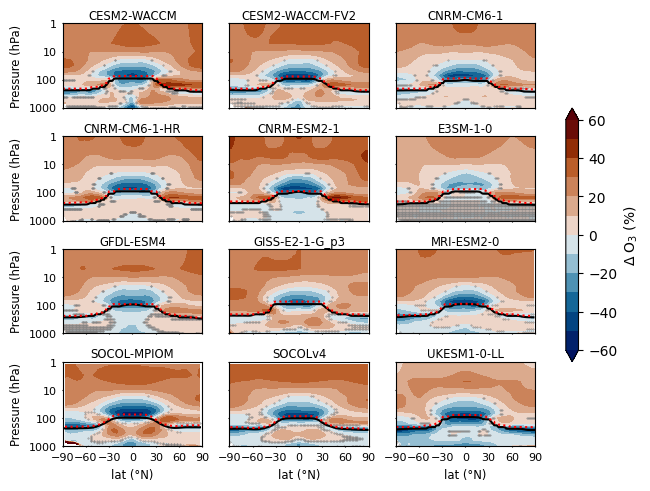

In [45]:
# plot relative difference of tm_zm o3 for chem models

# plot ozone climatology over 150yr for piControl, 4xCO2 
# and yr 135-145 average for 1pctCO2

# turn-on/off t-test plot

flag_ttest = 1

# set the colormap
# cmap = cm.coolwarm
cmap = cmc.vik

# piControl climatology 
nrow_pi = 5
ncol_pi = 5

# diff 4CO2 chem
nrow_diff_4CO2 = 4
ncol_diff_4CO2 = 3
y_subtitle = 0.95
labelsize = 8

# plot reldiff of annual-mean zonal-mean ozone btw 4CO2 and piControl
nplot = 0 
fig1, axes1 = plt.subplots(nrow_diff_4CO2,ncol_diff_4CO2,constrained_layout=True) # for subplots
for i in np.arange(0,n_model):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
        if flag_4CO2[i] == 1:
            nplot += 1
            print(model_name[i])
            #fig1, ax = plt.subplots() # for single plot
            ax1 = plt.subplot(nrow_diff_4CO2,ncol_diff_4CO2,nplot)
            ax1.set_xlim(-90,90)
            ax1.set_ylim(100,10**5)
            ax1.set_yscale('log')
            ax1.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
            ax1.set_yticks(ticks = [10**5,10**4,10**3,10**2], labels = ["1000","100","10","1"])
            ax1.tick_params(axis='x', labelsize=labelsize, length=1)
            ax1.tick_params(axis='y', labelsize=labelsize, length=1)
            ax1.set_title(model_name[i][:-1], fontsize = "small", y = y_subtitle)
            # invert the press to be from bottom to top
            ax1.invert_yaxis()
            levels = np.linspace(-60, 60, 13)
            # center the colorbar at zero
            cs1 = ax1.contourf(latitude.get(model_name[i]), press.get(model_name[i]),\
                             o3_tm_zm_diff_4CO2.get(model_name[i])[0,:,:]*100,\
                             corner_mask = False, norm=colors.CenteredNorm(),\
                             cmap=cmap, levels = levels, extend = "both")
            # plot tropopause
            ax1.plot(latitude.get(model_name[i]),tropo_tm_piControl_compute.get(model_name[i])[0,:],'-k',\
                     latitude.get(model_name[i]),tropo_tm_4CO2_compute.get(model_name[i])[0,:],':r')
        
            if flag_ttest == 1:
                # scatter plot for t-test
                ax1.scatter(latitude.get(model_name[i])[strip_4CO2_lat.get(model_name[i])],\
                           press.get(model_name[i])[strip_4CO2_press.get(model_name[i])],\
                           marker = '.', s=0.5, c='grey')
            
            # for single plot
            #cbar = fig1.colorbar(cs,label = "%")
            #ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
            #ax.set_xlabel("lat (\u00b0N)")
            #ax.set_ylabel("Pressure (Pa)")
            #ax.set_title(model_name[i][:-1])
            #plt.savefig('../Output/4CO2/' + species + '_' + model_name[i][:-1]+'_reldiff_4xCO2_ttest')
            
            # for subplots
            nplot_xaxis = np.arange((nrow_diff_4CO2-1)*ncol_diff_4CO2+1,nrow_diff_4CO2*ncol_diff_4CO2+1)
            if (nplot not in nplot_xaxis):
                ax1.xaxis.set_tick_params(labelbottom=False)
            else:
                ax1.set_xlabel("lat (\u00b0N)", fontsize = "small")
                
            if (nplot%ncol_diff_4CO2 != 1):
                ax1.yaxis.set_tick_params(labelleft=False)
            else:
                ax1.set_ylabel("Pressure (hPa)", fontsize = "small")
        
# for subplots: 
#fig1.delaxes(axes1[3,2]) # for all models
fig1.colorbar(cs1, ax=axes1.ravel().tolist(),label = r"$\Delta$ O$_3$ (%)", shrink = 0.6)
fig1.savefig('../Output/paper/o3_reldiff_am_zm_4xCO2_100yr_chem_models_ttest.pdf',dpi = 300)

CESM2-WACCM_
CESM2-WACCM-FV2_
CNRM-CM6-1_
CNRM-CM6-1-HR_
CNRM-ESM2-1_
E3SM-1-0_
GFDL-ESM4_
GISS-E2-1-G_p3_
MRI-ESM2-0_
SOCOLv4_
UKESM1-0-LL_


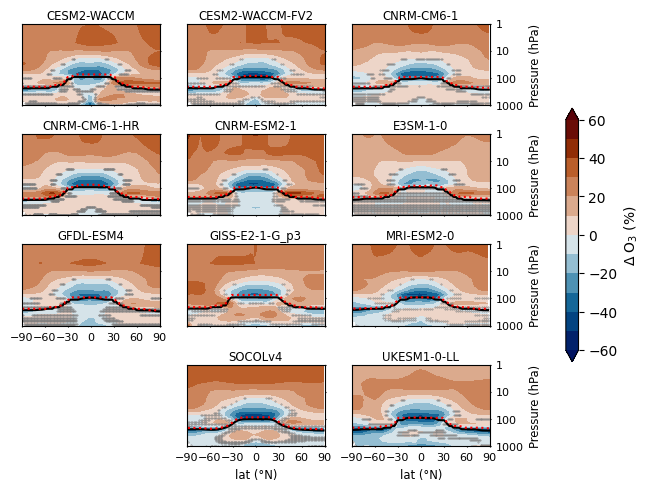

In [46]:
# plot reldiff of annual-mean zonal-mean ozone btw piControl and yr 135-145 for 1pctCO2

# diff 1pctCO2 chem
from matplotlib import gridspec

nrow_diff_1pct = 4
ncol_diff_1pct = 3
y_subtitle = 0.95
labelsize = 8

n = -1
nplot = [1,2,3,4,5,6,7,8,9,11,12]
fig2, axes2 = plt.subplots(nrow_diff_1pct,ncol_diff_1pct,constrained_layout=True) # for subplots

for i in np.arange(0,n_model):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0):
        if flag_1pct[i] == 1:
            n += 1
            print(model_name[i])
            #fig1, ax = plt.subplots() # for single plot
            
            ax2 = plt.subplot(nrow_diff_1pct,ncol_diff_1pct,nplot[n])
            ax2.set_xlim(-90,90)
            ax2.set_ylim(100,10**5)
            ax2.set_yscale('log')
            ax2.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
            
            ax2.yaxis.tick_right()
            ax2.yaxis.set_label_position ("right") 
            ax2.set_yticks(ticks = [10**5,10**4,10**3,10**2], labels = ["1000","100","10","1"])
            ax2.tick_params(axis='x', labelsize=labelsize, length=1)
            ax2.tick_params(axis='y', labelsize=labelsize, length=1)
            ax2.set_title(model_name[i][:-1], fontsize = "small", y = y_subtitle)
            
            # invert the press to be from bottom to top
            ax2.invert_yaxis()
            levels = np.linspace(-60, 60, 13)
            # center the colorbar at zero
            cs2 = ax2.contourf(latitude.get(model_name[i]), press.get(model_name[i]),\
                             o3_tm_zm_diff_1pct.get(model_name[i])[0,:,:]*100,\
                             corner_mask = False, norm=colors.CenteredNorm(),\
                             cmap=cmap, levels = levels, extend = "both")
            ax2.plot(latitude.get(model_name[i]),tropo_tm_piControl_compute.get(model_name[i])[0,:],'-k',\
                     latitude.get(model_name[i]),tropo_tm_1pct_compute.get(model_name[i])[0,:],':r')
            if flag_ttest == 1:
                # scatter plot for t-test
                ax2.scatter(latitude.get(model_name[i])[strip_1pct_lat.get(model_name[i])],\
                           press.get(model_name[i])[strip_1pct_press.get(model_name[i])],\
                           marker = '.', s=0.5, c='grey')
            
            # for single plot
            #cbar = fig1.colorbar(cs,label = "%")
            #ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
            #ax.set_xlabel("lat (\u00b0N)")
            #ax.set_ylabel("Pressure (Pa)")
            #ax.set_title(model_name[i][:-1])
            #plt.savefig('../Output/4CO2/' + species + '_' + model_name[i][:-1]+'_reldiff_4xCO2_ttest')
            
            # for subplots
            nplot_xaxis = np.arange((nrow_diff_1pct-1)*ncol_diff_1pct+1,nrow_diff_1pct*ncol_diff_1pct+1)
            if (nplot[n] not in nplot_xaxis and n!=6):
                ax2.xaxis.set_tick_params(labelbottom=False)
            elif n!= 6:
                ax2.set_xlabel("lat (\u00b0N)", fontsize = "small")
                
            if (nplot[n]%ncol_diff_1pct != 0):
                ax2.yaxis.set_tick_params(labelright=False)
            else:
                ax2.set_ylabel("Pressure (hPa)", fontsize = "small")
                        
# for subplots: 
fig2.delaxes(axes2[3,0])
#fig2.delaxes(axes2[3,2])
fig2.colorbar(cs2, ax=axes2.ravel().tolist(),label = r"$\Delta$ O$_3$ (%)", shrink = 0.6)
fig2.savefig('../Output/paper/o3_reldiff_am_zm_1pctCO2_chem_models.pdf', dpi = 300)

# The following cells compute and plot tm_zm partial column ozone for TRO3,LSO3 and USO3.

In [47]:
# trosphere: surface to tropoause
# lower stratosphere: tropopause to 20hPa
# upper stratosphere: 20hPa to 1hPa

def vmr2col(model_name,vmr,p0,p_top,plev):
    # compute column ozone value from volumn mixing ratio
    # for SOCOL, since the plev is float, need to use abs()<* to determine the ind;
    # also, the tropopause location is not at a certain level, thus need to find 
    # the nearest level
    
    # this function computes partial column concentration from vmr;
    # input: 
    #       zonal-mean vmr: (time,plev,lat)
    #       index of bottom/top press: (time,lat)
    #       press lev
    
    # constants
    g = 980.6  # cm s^-2 
    Mair = 28.964/6.022e23     #g/molec
    vmr = vmr * 10**(-6)
    # find the index of model bottom & top press lev nearest to the target level
    ind_p0 = np.zeros_like(p_top)
    ind_p_top = np.zeros_like(p_top)
    Pdel = np.zeros_like(plev)
    partPress = np.zeros_like(plev)
    col = np.zeros_like(p_top[0,:])
    col_DU = np.zeros_like(p_top)
    
    # loop over time
    for t in range(0,len(p0[:,0])):
        for i,p in np.ndenumerate(p0[t,:]):
            ind_p0[t,i] = np.where(abs(plev-p) == min(abs(plev-p)))[0]
        
        for i,p in np.ndenumerate(p_top[t,:]):
            ind_p_top[t,i] = np.where(abs(plev-p) == min(abs(plev-p)))[0]
            # compute delta P
            Pdel = abs(np.diff(plev[int(ind_p0[t,i]):int(ind_p_top[t,i])+1]))
            # compute partial press of the species for each latitude
            mean_vmr = \
                1/2*(vmr[t,int(ind_p0[t,i]+1):int(ind_p_top[t,i]+1),i]+vmr[t,int(ind_p0[t,i]):int(ind_p_top[t,i]),i])
            partPress = Pdel * mean_vmr[0,:] * 10./ (Mair * g)
            # sum up partial press of each level
            col[i] = np.sum(partPress)
            # convert to DU
            col_DU[t,i] = col[i]/(2.687*10**16)
    return col_DU

In [48]:
#read in vertically interpolated tm_zm ozone

species = "o3"
path_tm_zm_inter_o3 = "../data/ozone/tm_zm_vertical_interpolate/"

# crate dictionaries to store data for each model
o3_tm_zm_inter_piControl_masked = dict()
o3_tm_zm_inter_4CO2_masked = dict()
o3_tm_zm_inter_1pct_masked = dict()

for i in range(0,len(model_name)): 
    for f in os.listdir(path_tm_zm_inter_o3):
        if os.path.isfile(os.path.join(path_tm_zm_inter_o3,f)) and (model_name[i] in f):
            if experiment[0] in f:
                tm_zm_inter_piControl= nc.Dataset(os.path.join(path_tm_zm_inter_o3,f))
                if model_name[i] == "SOCOL-MPIOM_" or model_name[i] == "SOCOLv4_":
                    o3_tm_zm_inter_piControl = tm_zm_inter_piControl.variables[species][:,:,:,0]*10**6
                    o3_tm_zm_inter_piControl_masked[model_name[i]] = ma.masked_values(o3_tm_zm_inter_piControl, 1e20)
                else:
                    o3_tm_zm_inter_piControl = tm_zm_inter_piControl.variables[species][:,:,:]*10**6 #convert to ppmv
                    o3_tm_zm_inter_piControl_masked[model_name[i]] = ma.masked_values(o3_tm_zm_inter_piControl, 1e20)
                print("pi",model_name[i],np.shape(o3_tm_zm_inter_piControl_masked.get(model_name[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                tm_zm_inter_4CO2 = nc.Dataset(os.path.join(path_tm_zm_inter_o3,f))
                if model_name[i] == "SOCOL-MPIOM_" or model_name[i] == "SOCOLv4_":
                    o3_tm_zm_inter_4CO2 = tm_zm_inter_4CO2.variables[species][:,:,:,0]*10**6
                    o3_tm_zm_inter_4CO2_masked[model_name[i]] = ma.masked_values(o3_tm_zm_inter_4CO2, 1e20)
                else:
                    o3_tm_zm_inter_4CO2 = tm_zm_inter_4CO2.variables[species][:,:,:]*10**6 #convert to ppmv
                    o3_tm_zm_inter_4CO2_masked[model_name[i]] = ma.masked_values (o3_tm_zm_inter_4CO2, 1e20)
                print("4CO2",model_name[i],np.mean(o3_tm_zm_inter_4CO2_masked.get(model_name[i])))
            
            elif experiment[2] in f and "135-145" in f: 
                tm_zm_inter_1pct = nc.Dataset(os.path.join(path_tm_zm_inter_o3,f))
                if model_name[i] == "SOCOLv4_":
                    o3_tm_zm_inter_1pct = tm_zm_inter_1pct.variables[species][:,:,:,0]*10**6
                    o3_tm_zm_inter_1pct_masked[model_name[i]] = ma.masked_values(o3_tm_zm_inter_1pct, 1e20)
                else:
                    o3_tm_zm_inter_1pct = tm_zm_inter_1pct.variables[species][:,:,:]*10**6 #convert to ppmv
                    o3_tm_zm_inter_1pct_masked[model_name[i]] = ma.masked_values(o3_tm_zm_inter_1pct, 1e20)
                print("1pctCO2",model_name[i],np.shape(o3_tm_zm_inter_1pct_masked.get(model_name[i])))
                

1pctCO2 CESM2-WACCM_ (1, 40, 192)
4CO2 CESM2-WACCM_ 2.015326545449902
pi CESM2-WACCM_ (1, 40, 192)
1pctCO2 CESM2-WACCM-FV2_ (1, 40, 96)
4CO2 CESM2-WACCM-FV2_ 2.0298435217526727
pi CESM2-WACCM-FV2_ (1, 40, 96)
1pctCO2 CNRM-CM6-1_ (1, 40, 128)
4CO2 CNRM-CM6-1_ 1.9644543018181593
pi CNRM-CM6-1_ (1, 40, 128)
pi CNRM-CM6-1-HR_ (1, 40, 360)
1pctCO2 CNRM-CM6-1-HR_ (1, 40, 360)
4CO2 CNRM-CM6-1-HR_ 1.9257789421222047
1pctCO2 CNRM-ESM2-1_ (1, 40, 128)
4CO2 CNRM-ESM2-1_ 2.0880508728632594
pi CNRM-ESM2-1_ (1, 40, 128)
1pctCO2 E3SM-1-0_ (1, 40, 180)
4CO2 E3SM-1-0_ 2.097005401497952
pi E3SM-1-0_ (1, 40, 180)
1pctCO2 GFDL-ESM4_ (1, 40, 180)
4CO2 GFDL-ESM4_ 1.9405933847680352
pi GFDL-ESM4_ (1, 40, 180)
4CO2 GISS-E2-1-G_p3_ 2.3402896969691875
1pctCO2 GISS-E2-1-G_p3_ (1, 40, 90)
pi GISS-E2-1-G_p3_ (1, 40, 90)
1pctCO2 MRI-ESM2-0_ (1, 40, 64)
4CO2 MRI-ESM2-0_ 2.047050620952993
pi MRI-ESM2-0_ (1, 40, 64)
4CO2 SOCOL-MPIOM_ 2.0245981201285863
pi SOCOL-MPIOM_ (1, 41, 48)
1pctCO2 SOCOLv4_ (1, 41, 96)
4CO2 SOCO

In [49]:
# compute tm-zm partial column ozone
## added uniform smoothing to column value over latitude directly
## since the interpolation of tropopause and TCO is linear

o3_col_tm_tropo_pi = dict()
o3_col_tm_tropo_4CO2 = dict()
o3_col_tm_tropo_1pct = dict()
o3_col_tm_lowstrato_pi = dict()
o3_col_tm_lowstrato_4CO2 = dict()
o3_col_tm_lowstrato_1pct = dict()
o3_col_tm_upstrato_pi = dict()
o3_col_tm_upstrato_4CO2 = dict()
o3_col_tm_upstrato_1pct = dict()

o3_col_tm_tropo_pi_smoothed = dict()
o3_col_tm_tropo_4CO2_smoothed = dict()
o3_col_tm_tropo_1pct_smoothed = dict()
o3_col_tm_lowstrato_pi_smoothed = dict()
o3_col_tm_lowstrato_4CO2_smoothed = dict()
o3_col_tm_lowstrato_1pct_smoothed = dict()

for i in range(0,len(model_name)):
    print(model_name[i])
    if model_name[i] != "SOCOL-MPIOM_" and model_name[i] != "SOCOLv4_":
        pressure = pressure_inter
    else:
        pressure = press.get(model_name[i])
    p_20hPa = np.ones_like(tropo_tm_piControl_compute.get(model_name[i]))*2000
    p_1hPa = np.ones_like(tropo_tm_piControl_compute.get(model_name[i]))*100
    p_bottom = np.ones_like(tropo_tm_piControl_compute.get(model_name[i]))*pressure[0]
    p_tropo_pi = tropo_tm_piControl_compute.get(model_name[i])
    p_tropo_4CO2 = tropo_tm_4CO2_compute.get(model_name[i])
    p_tropo_1pct = tropo_tm_1pct_compute.get(model_name[i])
    # troposphere
    o3_col_tm_tropo_pi[model_name[i]] = \
    vmr2col(model_name[i],o3_tm_zm_inter_piControl_masked.get(model_name[i]),p_bottom,p_tropo_pi,pressure)
    # add smoothing: 
    o3_col_tm_tropo_pi_smoothed[model_name[i]] = \
    uniform_filter1d(o3_col_tm_tropo_pi.get(model_name[i]),20)
    print("pi",model_name[i],np.mean(o3_col_tm_tropo_pi.get(model_name[i])))
    # lower stratopshere
    o3_col_tm_lowstrato_pi[model_name[i]] = \
    vmr2col(model_name[i],o3_tm_zm_inter_piControl_masked.get(model_name[i]),p_tropo_pi,p_20hPa,pressure)
    print("pi low", model_name[i],np.mean(o3_col_tm_lowstrato_pi.get(model_name[i])))
    # add smoothing: 
    o3_col_tm_lowstrato_pi_smoothed[model_name[i]] = \
    uniform_filter1d(o3_col_tm_lowstrato_pi.get(model_name[i]),20)
    # upper stratopshere
    o3_col_tm_upstrato_pi[model_name[i]] = \
    vmr2col(model_name[i],o3_tm_zm_inter_piControl_masked.get(model_name[i]),p_20hPa,p_1hPa,pressure)
    
    if flag_chem[i] == 1: 
        if flag_4CO2[i] == 1:
            o3_col_tm_tropo_4CO2[model_name[i]] = \
            vmr2col(model_name[i],o3_tm_zm_inter_4CO2_masked.get(model_name[i]),p_bottom,\
            p_tropo_4CO2,pressure)
            # add smoothing: 
            o3_col_tm_tropo_4CO2_smoothed[model_name[i]] = \
            uniform_filter1d(o3_col_tm_tropo_4CO2.get(model_name[i]),20)
            
            o3_col_tm_lowstrato_4CO2[model_name[i]] = \
            vmr2col(model_name[i],o3_tm_zm_inter_4CO2_masked.get(model_name[i]),p_tropo_4CO2,p_20hPa,pressure)
            # add smoothing: 
            o3_col_tm_lowstrato_4CO2_smoothed[model_name[i]] = \
            uniform_filter1d(o3_col_tm_lowstrato_4CO2.get(model_name[i]),20)
            o3_col_tm_upstrato_4CO2[model_name[i]] = \
            vmr2col(model_name[i],o3_tm_zm_inter_4CO2_masked.get(model_name[i]),p_20hPa,p_1hPa,pressure)
            print("4co2",model_name[i],np.mean(o3_col_tm_upstrato_4CO2.get(model_name[i])))
        
        if flag_1pct[i] == 1:
            o3_col_tm_tropo_1pct[model_name[i]] = \
            vmr2col(model_name[i],o3_tm_zm_inter_1pct_masked.get(model_name[i]),p_bottom,\
            p_tropo_1pct,pressure_inter)
            # add smoothing: 
            o3_col_tm_tropo_1pct_smoothed[model_name[i]] = \
            uniform_filter1d(o3_col_tm_tropo_1pct.get(model_name[i]),20)
            o3_col_tm_lowstrato_1pct[model_name[i]] = \
            vmr2col(model_name[i],o3_tm_zm_inter_1pct_masked.get(model_name[i]),p_tropo_1pct,p_20hPa,pressure)
            # add smoothing: 
            o3_col_tm_lowstrato_1pct_smoothed[model_name[i]] = \
            uniform_filter1d(o3_col_tm_lowstrato_1pct.get(model_name[i]),20)
            
            o3_col_tm_upstrato_1pct[model_name[i]] = \
            vmr2col(model_name[i],o3_tm_zm_inter_1pct_masked.get(model_name[i]),p_20hPa,p_1hPa,pressure)
            print("1pct",model_name[i],np.mean(o3_col_tm_tropo_4CO2.get(model_name[i])))

CESM2-WACCM_
pi CESM2-WACCM_ 24.658884450879196
pi low CESM2-WACCM_ 170.54951268329668
4co2 CESM2-WACCM_ 119.34333580754962
1pct CESM2-WACCM_ 30.4065988226963
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ 18.238223115890673
pi low CESM2-WACCM-FV2_ 174.29848791223299
4co2 CESM2-WACCM-FV2_ 119.46756909306806
1pct CESM2-WACCM-FV2_ 21.902757548647624
CNRM-CM6-1_
pi CNRM-CM6-1_ 32.7028975893056
pi low CNRM-CM6-1_ 172.77212645180134
4co2 CNRM-CM6-1_ 117.11845294443992
1pct CNRM-CM6-1_ 37.00577175362663
CNRM-CM6-1-HR_
pi CNRM-CM6-1-HR_ 31.642238693658904
pi low CNRM-CM6-1-HR_ 156.04826831599775
4co2 CNRM-CM6-1-HR_ 116.400176678965
1pct CNRM-CM6-1-HR_ 35.39285782056061
CNRM-ESM2-1_
pi CNRM-ESM2-1_ 33.304272820986476
pi low CNRM-ESM2-1_ 174.57734587153746
4co2 CNRM-ESM2-1_ 125.0888913415678
1pct CNRM-ESM2-1_ 37.73869951026221
E3SM-1-0_
pi E3SM-1-0_ 24.10107228972055
pi low E3SM-1-0_ 192.13211786560424
4co2 E3SM-1-0_ 121.48287606095202
1pct E3SM-1-0_ 30.888858790041347
GFDL-ESM4_
pi GFDL-ESM4_ 21.3183378

In [50]:
# compute the diff of smoothed tm_zm partial column ozone

o3_col_tm_tropo_diff_4CO2 = dict()
o3_col_tm_lowstrato_diff_4CO2 = dict()
o3_col_tm_upstrato_diff_4CO2 = dict()
o3_col_tm_tropo_diff_1pct = dict()
o3_col_tm_lowstrato_diff_1pct = dict()
o3_col_tm_upstrato_diff_1pct = dict()

for i in range(0,len(model_name)):
    if flag_chem[i] == 1: 
        if flag_4CO2[i] == 1:
            o3_col_tm_tropo_diff_4CO2[model_name[i]] = \
            o3_col_tm_tropo_4CO2_smoothed.get(model_name[i]) - o3_col_tm_tropo_pi_smoothed.get(model_name[i])
            o3_col_tm_lowstrato_diff_4CO2[model_name[i]] = \
            o3_col_tm_lowstrato_4CO2_smoothed.get(model_name[i]) - o3_col_tm_lowstrato_pi_smoothed.get(model_name[i])
            o3_col_tm_upstrato_diff_4CO2[model_name[i]] = \
            o3_col_tm_upstrato_4CO2.get(model_name[i]) - o3_col_tm_upstrato_pi.get(model_name[i])
            print(model_name[i],np.shape(o3_col_tm_tropo_diff_4CO2.get(model_name[i])))
        
        if flag_1pct[i] == 1:
            o3_col_tm_tropo_diff_1pct[model_name[i]] = \
            (o3_col_tm_tropo_1pct_smoothed.get(model_name[i]) - o3_col_tm_tropo_pi_smoothed.get(model_name[i]))
            o3_col_tm_lowstrato_diff_1pct[model_name[i]] = \
            (o3_col_tm_lowstrato_1pct_smoothed.get(model_name[i]) - o3_col_tm_lowstrato_pi_smoothed.get(model_name[i]))
            o3_col_tm_upstrato_diff_1pct[model_name[i]] = \
            (o3_col_tm_upstrato_1pct.get(model_name[i]) - o3_col_tm_upstrato_pi.get(model_name[i]))

CESM2-WACCM_ (1, 192)
CESM2-WACCM-FV2_ (1, 96)
CNRM-CM6-1_ (1, 128)
CNRM-CM6-1-HR_ (1, 360)
CNRM-ESM2-1_ (1, 128)
E3SM-1-0_ (1, 180)
GFDL-ESM4_ (1, 180)
GISS-E2-1-G_p3_ (1, 90)
MRI-ESM2-0_ (1, 64)
SOCOL-MPIOM_ (1, 48)
SOCOLv4_ (1, 96)
UKESM1-0-LL_ (1, 144)


In [51]:
# read in tm_zm TCO data

path_tm_zm_TCO = "../data/ozone/column_ozone/tm_zm_TCO/"

o3_tm_zm_TCO_piControl_masked = dict()
o3_tm_zm_TCO_4CO2_masked = dict()
o3_tm_zm_TCO_1pct_masked = dict()
o3_tm_zm_TCO_diff_4CO2 = dict()
o3_tm_zm_TCO_diff_1pct = dict()

species = "O3_col"

for i in range(0,len(model_name)): 
    for f in os.listdir(path_tm_zm_TCO):
        if os.path.isfile(os.path.join(path_tm_zm_TCO,f)) and (model_name[i] in f):
            if experiment[0] in f:
                tm_zm_TCO_piControl= nc.Dataset(os.path.join(path_tm_zm_TCO,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_tm_zm_TCO_piControl = tm_zm_TCO_piControl.variables[species][:,:,0]
                    o3_tm_zm_TCO_piControl_masked[model_name[i]] = ma.masked_values(o3_tm_zm_TCO_piControl, 1e+20)
                else:
                    o3_tm_zm_TCO_piControl = tm_zm_TCO_piControl.variables[species][:,:]
                    o3_tm_zm_TCO_piControl_masked[model_name[i]] = ma.masked_values(o3_tm_zm_TCO_piControl, 1e+20)
                print("pi",model_name[i],np.shape(o3_tm_zm_TCO_piControl_masked.get(model_name[i])))

            elif experiment[1] in f and ("last100yr" in f):
                tm_zm_TCO_4CO2 = nc.Dataset(os.path.join(path_tm_zm_TCO,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_tm_zm_TCO_4CO2 = tm_zm_TCO_4CO2.variables[species][:,:,0]
                    o3_tm_zm_TCO_4CO2_masked[model_name[i]] = ma.masked_values(o3_tm_zm_TCO_4CO2, 1e+20)
                else:
                    o3_tm_zm_TCO_4CO2 = tm_zm_TCO_4CO2.variables[species][:,:]
                    o3_tm_zm_TCO_4CO2_masked[model_name[i]] = ma.masked_values(o3_tm_zm_TCO_4CO2, 1e+20)
                print("4CO2",model_name[i],np.shape(o3_tm_zm_TCO_4CO2_masked.get(model_name[i])))
            
            elif experiment[2] in f and ("135-145" in f):
                tm_zm_TCO_1pct = nc.Dataset(os.path.join(path_tm_zm_TCO,f))
                o3_tm_zm_TCO_1pct = tm_zm_TCO_1pct.variables[species][:,:,0]
                o3_tm_zm_TCO_1pct_masked[model_name[i]] = ma.masked_values(o3_tm_zm_TCO_1pct, 1e+20)
                print("1pctCO2",model_name[i],np.shape(o3_tm_zm_TCO_1pct_masked.get(model_name[i])))

1pctCO2 CESM2-WACCM_ (1, 192)
4CO2 CESM2-WACCM_ (1, 192)
pi CESM2-WACCM_ (1, 192)
1pctCO2 CESM2-WACCM-FV2_ (1, 96)
4CO2 CESM2-WACCM-FV2_ (1, 96)
pi CESM2-WACCM-FV2_ (1, 96)
1pctCO2 CNRM-CM6-1_ (1, 128)
4CO2 CNRM-CM6-1_ (1, 128)
pi CNRM-CM6-1_ (1, 128)
1pctCO2 CNRM-CM6-1-HR_ (1, 360)
4CO2 CNRM-CM6-1-HR_ (1, 360)
pi CNRM-CM6-1-HR_ (1, 360)
1pctCO2 CNRM-ESM2-1_ (1, 128)
4CO2 CNRM-ESM2-1_ (1, 128)
pi CNRM-ESM2-1_ (1, 128)
1pctCO2 E3SM-1-0_ (1, 180)
4CO2 E3SM-1-0_ (1, 180)
pi E3SM-1-0_ (1, 180)
1pctCO2 GFDL-ESM4_ (1, 180)
4CO2 GFDL-ESM4_ (1, 180)
pi GFDL-ESM4_ (1, 180)
4CO2 GISS-E2-1-G_p3_ (1, 90)
1pctCO2 GISS-E2-1-G_p3_ (1, 90)
pi GISS-E2-1-G_p3_ (1, 90)
1pctCO2 MRI-ESM2-0_ (1, 64)
4CO2 MRI-ESM2-0_ (1, 64)
pi MRI-ESM2-0_ (1, 64)
pi SOCOL-MPIOM_ (1, 48)
4CO2 SOCOL-MPIOM_ (1, 48)
1pctCO2 SOCOLv4_ (1, 96)
4CO2 SOCOLv4_ (1, 96)
pi SOCOLv4_ (1, 96)
1pctCO2 UKESM1-0-LL_ (1, 144)
4CO2 UKESM1-0-LL_ (1, 144)
pi UKESM1-0-LL_ (1, 144)
1pctCO2 AWI-ESM-1-1-LR (1, 96)
pi AWI-ESM-1-1-LR (1, 96)
1pctCO2 C

In [52]:
# compute diff of tm-zm TCO

for i in range(0,len(model_name)):
    print(model_name[i])
    if flag_4CO2[i] == 1:
        o3_tm_zm_TCO_diff_4CO2[model_name[i]] = \
        (o3_tm_zm_TCO_4CO2_masked.get(model_name[i]) - o3_tm_zm_TCO_piControl_masked.get(model_name[i]))
        print("4CO2",model_name[i],np.shape(o3_tm_zm_TCO_diff_4CO2.get(model_name[i])))
    if flag_1pct[i] == 1:
        o3_tm_zm_TCO_diff_1pct[model_name[i]] = \
        (o3_tm_zm_TCO_1pct_masked.get(model_name[i]) - o3_tm_zm_TCO_piControl_masked.get(model_name[i]))
        print("1pct",model_name[i],np.shape(o3_tm_zm_TCO_diff_1pct.get(model_name[i])))

CESM2-WACCM_
4CO2 CESM2-WACCM_ (1, 192)
1pct CESM2-WACCM_ (1, 192)
CESM2-WACCM-FV2_
4CO2 CESM2-WACCM-FV2_ (1, 96)
1pct CESM2-WACCM-FV2_ (1, 96)
CNRM-CM6-1_
4CO2 CNRM-CM6-1_ (1, 128)
1pct CNRM-CM6-1_ (1, 128)
CNRM-CM6-1-HR_
4CO2 CNRM-CM6-1-HR_ (1, 360)
1pct CNRM-CM6-1-HR_ (1, 360)
CNRM-ESM2-1_
4CO2 CNRM-ESM2-1_ (1, 128)
1pct CNRM-ESM2-1_ (1, 128)
E3SM-1-0_
4CO2 E3SM-1-0_ (1, 180)
1pct E3SM-1-0_ (1, 180)
GFDL-ESM4_
4CO2 GFDL-ESM4_ (1, 180)
1pct GFDL-ESM4_ (1, 180)
GISS-E2-1-G_p3_
4CO2 GISS-E2-1-G_p3_ (1, 90)
1pct GISS-E2-1-G_p3_ (1, 90)
MRI-ESM2-0_
4CO2 MRI-ESM2-0_ (1, 64)
1pct MRI-ESM2-0_ (1, 64)
SOCOL-MPIOM_
4CO2 SOCOL-MPIOM_ (1, 48)
SOCOLv4_
4CO2 SOCOLv4_ (1, 96)
1pct SOCOLv4_ (1, 96)
UKESM1-0-LL_
4CO2 UKESM1-0-LL_ (1, 144)
1pct UKESM1-0-LL_ (1, 144)
AWI-ESM-1-1-LR
1pct AWI-ESM-1-1-LR (1, 96)
CESM2_
4CO2 CESM2_ (1, 192)
1pct CESM2_ (1, 192)
CESM2-FV2_
4CO2 CESM2-FV2_ (1, 96)
1pct CESM2-FV2_ (1, 96)
FGOALS-g3_
4CO2 FGOALS-g3_ (1, 80)
1pct FGOALS-g3_ (1, 80)
MPI-ESM-1-2-HAM_
4CO2 MPI-ES

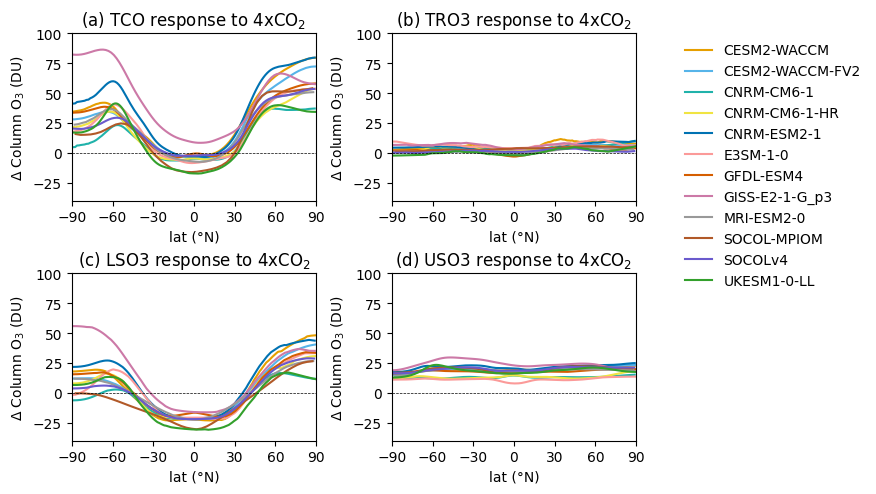

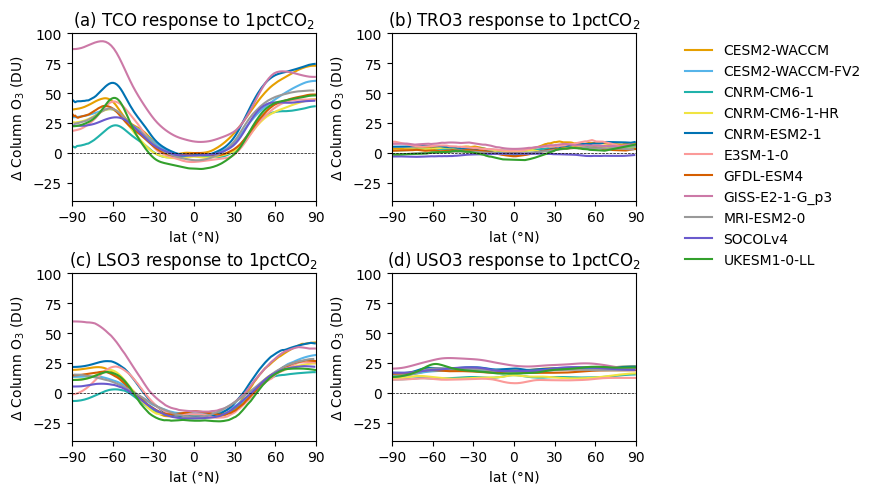

In [54]:
# plot diff of tm-zm TCO and partial column ozone

#colors_col = cm.rainbow(np.linspace(0, 1, n_chem))
colors_col = cmc.vik(np.linspace(0, 1, n_chem))

fig5_name_ind = [0,1,2,3,4,5,6,7,8,10,11] # model names for 1pct

# 4CO2
fig4, ax4 = plt.subplots(2,2, constrained_layout = True)
#1pct
fig5, ax5 = plt.subplots(2,2, constrained_layout = True)

for i,c in zip(range(0,len(model_name)),colors_col):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
        if flag_4CO2[i] == 1:
            ax4[0,0].plot(latitude.get(model_name[i]),o3_tm_zm_TCO_diff_4CO2.get(model_name[i])[0,:], color = colors_m[model_name[i]], label = model_name[i][:-1])
            ax4[0,1].plot(latitude.get(model_name[i]),o3_col_tm_tropo_diff_4CO2.get(model_name[i])[0,:], color = colors_m[model_name[i]], label = model_name[i][:-1])
            ax4[1,0].plot(latitude.get(model_name[i]),o3_col_tm_lowstrato_diff_4CO2.get(model_name[i])[0,:], color = colors_m[model_name[i]], label = model_name[i][:-1])
            ax4[1,1].plot(latitude.get(model_name[i]),o3_col_tm_upstrato_diff_4CO2.get(model_name[i])[0,:], color = colors_m[model_name[i]], label = model_name[i][:-1])
        
        if flag_1pct[i] == 1:
            ax5[0,0].plot(latitude.get(model_name[i]),o3_tm_zm_TCO_diff_1pct.get(model_name[i])[0,:], color = colors_m[model_name[i]], label = model_name[i][:-1])
            ax5[0,1].plot(latitude.get(model_name[i]),o3_col_tm_tropo_diff_1pct.get(model_name[i])[0,:], color = colors_m[model_name[i]], label = model_name[i][:-1])
            ax5[1,0].plot(latitude.get(model_name[i]),o3_col_tm_lowstrato_diff_1pct.get(model_name[i])[0,:], color = colors_m[model_name[i]], label = model_name[i][:-1])
            ax5[1,1].plot(latitude.get(model_name[i]),o3_col_tm_upstrato_diff_1pct.get(model_name[i])[0,:], color = colors_m[model_name[i]], label = model_name[i][:-1])

fig4.legend([model_name[n][:-1] for n in range(0,12)], bbox_to_anchor=(1.35, 0.95),frameon=False, loc = 'upper right')
fig5.legend([model_name[n][:-1] for n in fig5_name_ind], bbox_to_anchor=(1.35, 0.95),frameon=False, loc = 'upper right')

for ax in ax4.flat:
    ax.set_ylim([-40,100])
    ax.set_xlim([-90,90])
    ax.axhline(y = 0.0, color = 'black', linestyle = '--', linewidth = 0.5)
    ax.set_xlabel("lat (\u00b0N)")
    ax.set_ylabel(r"$\Delta$ Column O$_3$ (DU)")
    ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
    
for ax in ax5.flat:
    ax.set_ylim([-40,100])
    ax.set_xlim([-90,90])
    ax.axhline(y = 0.0, color = 'black', linestyle = '--', linewidth = 0.5)
    ax.set_xlabel("lat (\u00b0N)")
    ax.set_ylabel(r"$\Delta$ Column O$_3$ (DU)")
    ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
        
ax4[0,0].set_title("(a) TCO response to 4xCO$_2$")
ax4[0,1].set_title("(b) TRO3 response to 4xCO$_2$") 
ax4[1,0].set_title("(c) LSO3 response to 4xCO$_2$") 
ax4[1,1].set_title("(d) USO3 response to 4xCO$_2$") 

ax5[0,0].set_title("(a) TCO response to 1pctCO$_2$")
ax5[0,1].set_title("(b) TRO3 response to 1pctCO$_2$") 
ax5[1,0].set_title("(c) LSO3 response to 1pctCO$_2$") 
ax5[1,1].set_title("(d) USO3 response to 1pctCO$_2$") 

# save the whole fig using "bbox_inches = 'tight'"
fig4.savefig('../Output/paper/diff_column_ozone_4xCO2_100yr_chem_smoothed.pdf', bbox_inches = "tight", dpi=300)           
fig5.savefig('../Output/paper/diff_column_ozone_1pctCO2_chem_smoothed.pdf', bbox_inches = "tight", dpi=300)    

# The following cells compute and plot the response of [am_zm partial column o3 and TO3 averaged over tropics 20S-20N] vs. time.

In [55]:
# read in am_zm TCO data

path_am_zm_TCO = "../data/ozone/column_ozone/am_zm_TCO/"

o3_am_zm_TCO_piControl_masked = dict()
o3_am_zm_TCO_4CO2_masked = dict()
o3_am_zm_TCO_1pct_masked = dict()
o3_am_zm_TCO_diff_4CO2 = dict()
o3_am_zm_TCO_diff_1pct = dict()

species = "O3_col"

for i in range(0,len(model_name)): 
    for f in os.listdir(path_am_zm_TCO):
        if os.path.isfile(os.path.join(path_am_zm_TCO,f)) and (model_name[i] in f):
            if experiment[0] in f:
                am_zm_TCO_piControl= nc.Dataset(os.path.join(path_am_zm_TCO,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_am_zm_TCO_piControl = am_zm_TCO_piControl.variables[species][:,:,0]
                    o3_am_zm_TCO_piControl_masked[model_name[i]] = ma.masked_values(o3_am_zm_TCO_piControl, 1e+20)
                else:
                    o3_am_zm_TCO_piControl = am_zm_TCO_piControl.variables[species][:,:]
                    o3_am_zm_TCO_piControl_masked[model_name[i]] = ma.masked_values(o3_am_zm_TCO_piControl, 1e+20)
                print("pi",model_name[i],np.shape(o3_am_zm_TCO_piControl_masked.get(model_name[i])))

            elif experiment[1] in f and ("last100yr" not in f):
                am_zm_TCO_4CO2 = nc.Dataset(os.path.join(path_am_zm_TCO,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_am_zm_TCO_4CO2 = am_zm_TCO_4CO2.variables[species][:,:,0]
                    o3_am_zm_TCO_4CO2_masked[model_name[i]] = ma.masked_values(o3_am_zm_TCO_4CO2, 1e+20)
                else:
                    o3_am_zm_TCO_4CO2 = am_zm_TCO_4CO2.variables[species][:,:]
                    o3_am_zm_TCO_4CO2_masked[model_name[i]] = ma.masked_values(o3_am_zm_TCO_4CO2, 1e+20)
                print("4CO2",model_name[i],np.shape(o3_am_zm_TCO_4CO2_masked.get(model_name[i])))
            
            elif experiment[2] in f and ("all" in f):
                am_zm_TCO_1pct = nc.Dataset(os.path.join(path_am_zm_TCO,f))
                o3_am_zm_TCO_1pct = am_zm_TCO_1pct.variables[species][:,:,0]
                o3_am_zm_TCO_1pct_masked[model_name[i]] = ma.masked_values(o3_am_zm_TCO_1pct, 1e+20)
                print("1pctCO2",model_name[i],np.shape(o3_am_zm_TCO_1pct_masked.get(model_name[i])))

1pctCO2 CESM2-WACCM_ (150, 192)
4CO2 CESM2-WACCM_ (150, 192)
pi CESM2-WACCM_ (150, 192)
4CO2 CESM2-WACCM-FV2_ (150, 96)
1pctCO2 CESM2-WACCM-FV2_ (150, 96)
pi CESM2-WACCM-FV2_ (150, 96)
1pctCO2 CNRM-CM6-1_ (150, 128)
4CO2 CNRM-CM6-1_ (150, 128)
pi CNRM-CM6-1_ (150, 128)
1pctCO2 CNRM-CM6-1-HR_ (150, 360)
4CO2 CNRM-CM6-1-HR_ (150, 360)
pi CNRM-CM6-1-HR_ (150, 360)
1pctCO2 CNRM-ESM2-1_ (150, 128)
4CO2 CNRM-ESM2-1_ (150, 128)
pi CNRM-ESM2-1_ (150, 128)
1pctCO2 E3SM-1-0_ (150, 180)
4CO2 E3SM-1-0_ (150, 180)
pi E3SM-1-0_ (150, 180)
1pctCO2 GFDL-ESM4_ (150, 180)
4CO2 GFDL-ESM4_ (150, 180)
pi GFDL-ESM4_ (150, 180)
1pctCO2 GISS-E2-1-G_p3_ (135, 90)
4CO2 GISS-E2-1-G_p3_ (135, 90)
pi GISS-E2-1-G_p3_ (135, 90)
1pctCO2 MRI-ESM2-0_ (150, 64)
4CO2 MRI-ESM2-0_ (150, 64)
pi MRI-ESM2-0_ (150, 64)
pi SOCOL-MPIOM_ (150, 48)
4CO2 SOCOL-MPIOM_ (150, 48)
1pctCO2 SOCOLv4_ (150, 96)
4CO2 SOCOLv4_ (150, 96)
pi SOCOLv4_ (150, 96)
1pctCO2 UKESM1-0-LL_ (150, 144)
4CO2 UKESM1-0-LL_ (150, 144)
pi UKESM1-0-LL_ (150, 1

In [56]:
# compute diff of am-zm TCO and tropical [-20,20] average 
# lat band
band = [-20,20]

for i in range(0,len(model_name)):
    if flag_chem[i] == 1: 
        ind_band = np.zeros_like(band)
        for n in range(0,len(band)):
            ind_band[n] = \
            np.where(abs(latitude.get(model_name[i])-band[n]) == min(abs(latitude.get(model_name[i])-band[n])))[0][0]
        print(model_name[i])
        
        if flag_4CO2[i] == 1:
            o3_am_zm_TCO_diff_4CO2[model_name[i]] = \
            ma.mean((o3_am_zm_TCO_4CO2_masked.get(model_name[i]) - \
                     o3_am_zm_TCO_piControl_masked.get(model_name[i]))[:,ind_band[0]:ind_band[1]],axis=1)
            print("4CO2",model_name[i],np.shape(o3_am_zm_TCO_diff_4CO2.get(model_name[i])))
        if flag_1pct[i] == 1:
            o3_am_zm_TCO_diff_1pct[model_name[i]] = \
            ma.mean((o3_am_zm_TCO_1pct_masked.get(model_name[i]) - \
                     o3_am_zm_TCO_piControl_masked.get(model_name[i]))[:,ind_band[0]:ind_band[1]],axis=1)
            print("1pct",model_name[i],np.shape(o3_am_zm_TCO_diff_1pct.get(model_name[i])))

CESM2-WACCM_
4CO2 CESM2-WACCM_ (150,)
1pct CESM2-WACCM_ (150,)
CESM2-WACCM-FV2_
4CO2 CESM2-WACCM-FV2_ (150,)
1pct CESM2-WACCM-FV2_ (150,)
CNRM-CM6-1_
4CO2 CNRM-CM6-1_ (150,)
1pct CNRM-CM6-1_ (150,)
CNRM-CM6-1-HR_
4CO2 CNRM-CM6-1-HR_ (150,)
1pct CNRM-CM6-1-HR_ (150,)
CNRM-ESM2-1_
4CO2 CNRM-ESM2-1_ (150,)
1pct CNRM-ESM2-1_ (150,)
E3SM-1-0_
4CO2 E3SM-1-0_ (150,)
1pct E3SM-1-0_ (150,)
GFDL-ESM4_
4CO2 GFDL-ESM4_ (150,)
1pct GFDL-ESM4_ (150,)
GISS-E2-1-G_p3_
4CO2 GISS-E2-1-G_p3_ (135,)
1pct GISS-E2-1-G_p3_ (135,)
MRI-ESM2-0_
4CO2 MRI-ESM2-0_ (150,)
1pct MRI-ESM2-0_ (150,)
SOCOL-MPIOM_
4CO2 SOCOL-MPIOM_ (150,)
SOCOLv4_
4CO2 SOCOLv4_ (150,)
1pct SOCOLv4_ (150,)
UKESM1-0-LL_
4CO2 UKESM1-0-LL_ (150,)
1pct UKESM1-0-LL_ (150,)


In [57]:
# read in am_zm_interpolated o3 

o3_am_zm_inter_piControl_masked = dict()
o3_am_zm_inter_4CO2_masked = dict()
o3_am_zm_inter_1pct_masked = dict()

species = "o3"
path_am_zm_inter_o3 = "../data/ozone/am_zm_vertical_interpolate/"

### save the data for each model first, then use them directly for plot afterwards
for i in range(0,len(model_name)): 
    for f in os.listdir(path_am_zm_inter_o3):
        if os.path.isfile(os.path.join(path_am_zm_inter_o3,f)) and (model_name[i] in f):
            # read ozone data
            if experiment[0] in f:
                am_zm_inter_piControl= nc.Dataset(os.path.join(path_am_zm_inter_o3,f))
                if (model_name[i]!= "SOCOL-MPIOM_" and model_name[i]!= "SOCOLv4_"):
                    o3_am_zm_inter_piControl = am_zm_inter_piControl.variables[species][:,:,:]*10**6 #convert to ppmv
                else:
                    o3_am_zm_inter_piControl = am_zm_inter_piControl.variables[species][:,:,:,0]*10**6
                o3_am_zm_inter_piControl_masked[model_name[i]] = ma.masked_values (o3_am_zm_inter_piControl, 1e20)
                print("pi",model_name[i],np.shape(o3_am_zm_inter_piControl_masked.get(model_name[i])))
            
            elif experiment[1] in f and ("last100yr" not in f):
                am_zm_inter_4CO2 = nc.Dataset(os.path.join(path_am_zm_inter_o3,f))
                if (model_name[i]!= "SOCOL-MPIOM_" and model_name[i]!= "SOCOLv4_"):
                    o3_am_zm_inter_4CO2 = am_zm_inter_4CO2.variables[species][:,:,:]*10**6 #convert to ppmv
                else:
                    o3_am_zm_inter_4CO2 = am_zm_inter_4CO2.variables[species][:,:,:,0]*10**6
                o3_am_zm_inter_4CO2_masked[model_name[i]] = ma.masked_values (o3_am_zm_inter_4CO2, 1e20)
                print("4CO2",model_name[i],np.shape(o3_am_zm_inter_4CO2_masked.get(model_name[i])))
            
            elif experiment[2] in f and ("all" in f):
                am_zm_inter_1pct = nc.Dataset(os.path.join(path_am_zm_inter_o3,f))
                if (model_name[i]!="SOCOLv4_"):
                    o3_am_zm_inter_1pct = am_zm_inter_1pct.variables[species][:,:,:]*10**6 #convert to ppmv
                else:
                    o3_am_zm_inter_1pct = am_zm_inter_1pct.variables[species][:,:,:,0]*10**6
                o3_am_zm_inter_1pct_masked[model_name[i]] = ma.masked_values (o3_am_zm_inter_1pct, 1e20)
                print("1pctCO2",model_name[i],np.mean(o3_am_zm_inter_1pct_masked.get(model_name[i])))

1pctCO2 CESM2-WACCM_ 1.881605930660354
4CO2 CESM2-WACCM_ (150, 40, 192)
pi CESM2-WACCM_ (150, 40, 192)
1pctCO2 CESM2-WACCM-FV2_ 1.8848616864264376
4CO2 CESM2-WACCM-FV2_ (150, 40, 96)
pi CESM2-WACCM-FV2_ (150, 40, 96)
1pctCO2 CNRM-CM6-1_ 1.8747167874244248
4CO2 CNRM-CM6-1_ (150, 40, 128)
pi CNRM-CM6-1_ (150, 40, 128)
1pctCO2 CNRM-CM6-1-HR_ 1.8298447082027187
4CO2 CNRM-CM6-1-HR_ (150, 40, 360)
pi CNRM-CM6-1-HR_ (150, 40, 360)
1pctCO2 CNRM-ESM2-1_ 1.909302239798353
pi CNRM-ESM2-1_ (150, 40, 128)
4CO2 CNRM-ESM2-1_ (150, 40, 128)
1pctCO2 E3SM-1-0_ 2.016755079180945
4CO2 E3SM-1-0_ (150, 40, 180)
pi E3SM-1-0_ (150, 40, 180)
1pctCO2 GFDL-ESM4_ 1.8210804510170544
4CO2 GFDL-ESM4_ (150, 40, 180)
pi GFDL-ESM4_ (150, 40, 180)
1pctCO2 GISS-E2-1-G_p3_ 2.1936848474774355
4CO2 GISS-E2-1-G_p3_ (135, 40, 90)
pi GISS-E2-1-G_p3_ (135, 40, 90)
1pctCO2 MRI-ESM2-0_ 1.9143218798304622
4CO2 MRI-ESM2-0_ (150, 40, 64)
pi MRI-ESM2-0_ (150, 40, 64)
pi SOCOL-MPIOM_ (150, 41, 48)
4CO2 SOCOL-MPIOM_ (150, 41, 48)
1pctC

In [58]:
#compute am zm diff_o3 (partial column value: LS,US) at tropical region (20S-20N average)

o3_am_col_lowstrato_pi = dict()
o3_am_col_lowstrato_4CO2 = dict()
o3_am_col_lowstrato_1pct = dict()
o3_am_col_upstrato_pi = dict()
o3_am_col_upstrato_4CO2 = dict()
o3_am_col_upstrato_1pct = dict()

o3_am_col_diff_lowstrato_pi = dict()
o3_am_col_diff_lowstrato_4CO2 = dict()
o3_am_col_diff_lowstrato_1pct = dict()
o3_am_col_diff_upstrato_pi = dict()
o3_am_col_diff_upstrato_4CO2 = dict()
o3_am_col_diff_upstrato_1pct = dict()

# lat band
band = [-20,20]

# compute partial column ozone
for i in range(0,len(model_name)):
    if flag_chem[i] == 1: 
        ind_band = np.zeros_like(band)
        print(model_name[i])
        if model_name[i] != "SOCOL-MPIOM_" and model_name[i] != "SOCOLv4_":
            pressure = pressure_inter
        else:
            pressure = press.get(model_name[i])
        
        if model_name[i] != "GISS-E2-1-G_p3_":
            p_20hPa = np.ones_like(tropo_am_piControl_compute.get(model_name[i]))*2000
            p_1hPa = np.ones_like(tropo_am_piControl_compute.get(model_name[i]))*100
            p_bottom = np.ones_like(tropo_am_piControl_compute.get(model_name[i]))*pressure[0]
            p_tropo_pi = tropo_am_piControl_compute.get(model_name[i])
            p_tropo_4CO2 = tropo_am_4CO2_compute.get(model_name[i])
            p_tropo_1pct = tropo_am_1pct_compute.get(model_name[i])
        else:
            p_20hPa = np.ones_like(tropo_am_piControl_compute.get(model_name[i]))[15:]*2000
            p_1hPa = np.ones_like(tropo_am_piControl_compute.get(model_name[i]))[15:]*100
            p_bottom = np.ones_like(tropo_am_piControl_compute.get(model_name[i]))[15:]*pressure[0]
            p_tropo_pi = tropo_am_piControl_compute.get(model_name[i])[15:]
            p_tropo_4CO2 = tropo_am_4CO2_compute.get(model_name[i])[15:]
            p_tropo_1pct = tropo_am_1pct_compute.get(model_name[i])[15:]
        #print(tropo_am_1pct_compute.get(model_name[i]))

        for n in range(0,len(band)):
            ind_band[n] = \
            np.where(abs(latitude.get(model_name[i])-band[n]) == min(abs(latitude.get(model_name[i])-band[n])))[0][0]
        print("pi shape", np.shape(o3_am_zm_inter_piControl_masked.get(model_name[i])))
        o3_am_col_lowstrato_pi[model_name[i]] = \
        ma.mean(vmr2col(model_name[i],o3_am_zm_inter_piControl_masked.get(model_name[i]),p_tropo_pi,p_20hPa,pressure)[:,ind_band[0]:ind_band[1]],axis=1)

        o3_am_col_upstrato_pi[model_name[i]] = \
        ma.mean(vmr2col(model_name[i],o3_am_zm_inter_piControl_masked.get(model_name[i]),p_20hPa,p_1hPa,pressure)[:,ind_band[0]:ind_band[1]],axis=1)
    
        if flag_4CO2[i] == 1:
            o3_am_col_lowstrato_4CO2[model_name[i]] = \
            ma.mean(vmr2col(model_name[i],o3_am_zm_inter_4CO2_masked.get(model_name[i]),p_tropo_4CO2,p_20hPa,pressure)[:,ind_band[0]:ind_band[1]],axis=1)

            o3_am_col_upstrato_4CO2[model_name[i]] = \
            ma.mean(vmr2col(model_name[i],o3_am_zm_inter_4CO2_masked.get(model_name[i]),p_20hPa,p_1hPa,pressure)[:,ind_band[0]:ind_band[1]],axis=1)

            o3_am_col_diff_lowstrato_4CO2[model_name[i]] =\
            o3_am_col_lowstrato_4CO2.get(model_name[i]) - o3_am_col_lowstrato_pi.get(model_name[i])
            o3_am_col_diff_upstrato_4CO2[model_name[i]] =\
            o3_am_col_upstrato_4CO2.get(model_name[i]) - o3_am_col_upstrato_pi.get(model_name[i])
            print("4CO2 low",model_name[i],np.mean(o3_am_col_diff_lowstrato_4CO2.get(model_name[i])))
            print("4CO2 up",model_name[i],np.mean(o3_am_col_diff_upstrato_4CO2.get(model_name[i])))
        
        if flag_1pct[i] == 1:
            o3_am_col_lowstrato_1pct[model_name[i]] = \
            ma.mean(vmr2col(model_name[i],o3_am_zm_inter_1pct_masked.get(model_name[i]),p_tropo_1pct,p_20hPa,pressure)[:,ind_band[0]:ind_band[1]],axis=1)
            o3_am_col_upstrato_1pct[model_name[i]] = \
            ma.mean(vmr2col(model_name[i],o3_am_zm_inter_1pct_masked.get(model_name[i]),p_20hPa,p_1hPa,pressure)[:,ind_band[0]:ind_band[1]],axis=1)

            o3_am_col_diff_lowstrato_1pct[model_name[i]] =\
            o3_am_col_lowstrato_1pct.get(model_name[i]) - o3_am_col_lowstrato_pi.get(model_name[i])
            o3_am_col_diff_upstrato_1pct[model_name[i]] =\
            o3_am_col_upstrato_1pct.get(model_name[i]) - o3_am_col_upstrato_pi.get(model_name[i])
            print("1pct low",model_name[i],np.mean(o3_am_col_diff_lowstrato_1pct.get(model_name[i])))
            print("1pct up",model_name[i],np.mean(o3_am_col_diff_upstrato_1pct.get(model_name[i])))

CESM2-WACCM_
pi shape (150, 40, 192)
4CO2 low CESM2-WACCM_ -20.594902194184517
4CO2 up CESM2-WACCM_ 18.844961376534737
1pct low CESM2-WACCM_ -8.99022054903865
1pct up CESM2-WACCM_ 9.911456622178596
CESM2-WACCM-FV2_
pi shape (150, 40, 96)
4CO2 low CESM2-WACCM-FV2_ -19.27466273710559
4CO2 up CESM2-WACCM-FV2_ 17.518276818276608
1pct low CESM2-WACCM-FV2_ -8.330465458779207
1pct up CESM2-WACCM-FV2_ 9.07640058805034
CNRM-CM6-1_
pi shape (150, 40, 128)
4CO2 low CNRM-CM6-1_ -20.05384554631192
4CO2 up CNRM-CM6-1_ 13.465849704506374
1pct low CNRM-CM6-1_ -10.296717057829293
1pct up CNRM-CM6-1_ 7.7533392849849205
CNRM-CM6-1-HR_
pi shape (150, 40, 360)
4CO2 low CNRM-CM6-1-HR_ -19.3131217787935
4CO2 up CNRM-CM6-1-HR_ 13.853974812869868
1pct low CNRM-CM6-1-HR_ -8.951517614562835
1pct up CNRM-CM6-1-HR_ 8.018769677179025
CNRM-ESM2-1_
pi shape (150, 40, 128)
4CO2 low CNRM-ESM2-1_ -20.053705115891947
4CO2 up CNRM-ESM2-1_ 19.8712893000528
1pct low CNRM-ESM2-1_ -9.681987227293034
1pct up CNRM-ESM2-1_ 10.07

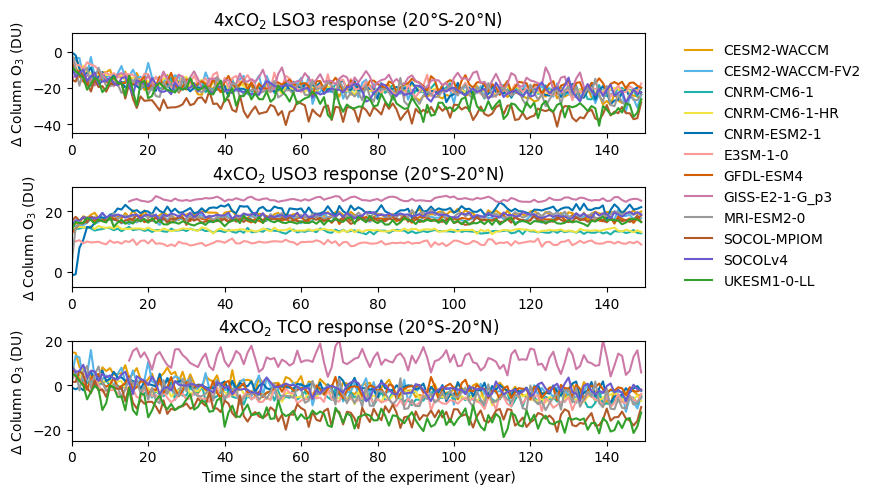

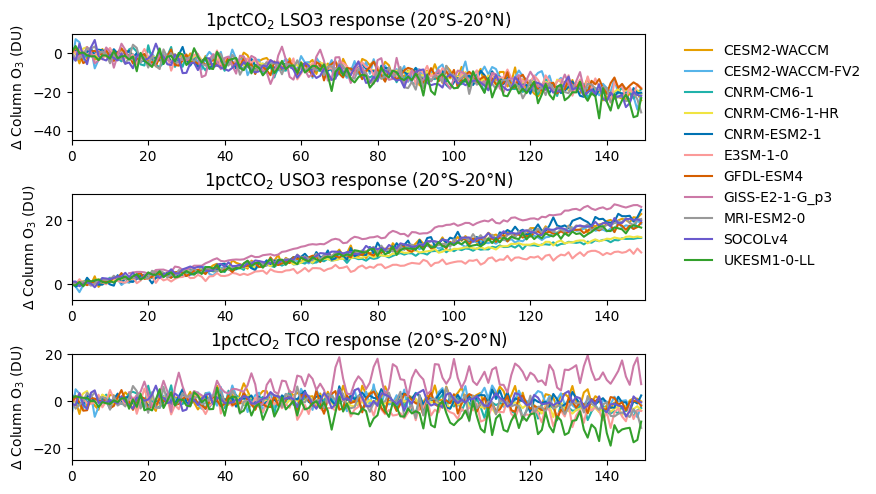

In [59]:
# plot am_zm diff_o3 (partial column value: LS,US) and TO3 at tropical region (20S-20N average) vs time for 4CO2
# for GISS US, ignore the first 15yr

fig7_name_ind=[0,1,2,3,4,5,6,7,8,10,11]
#colors_col = cm.rainbow(np.linspace(0, 1, n_chem))
colors_col = cmc.vik(np.linspace(0, 1, n_chem))

# 4CO2
fig6, ax6 = plt.subplots(3,1,constrained_layout = True)
fig7, ax7 = plt.subplots(3,1,constrained_layout = True)

for i,c in zip(range(0,len(model_name)),colors_col):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
        if flag_4CO2[i] == 1:
            time_4CO2 = np.shape(o3_am_col_diff_lowstrato_4CO2.get(model_name[i]))[0]
            ax6[0].plot(range(0,time_4CO2),o3_am_col_diff_lowstrato_4CO2.get(model_name[i]),color=colors_m[model_name[i]],label=model_name[i])
            if model_name[i] == "GISS-E2-1-G_p3_":
                ax6[1].plot(range(15,150),o3_am_col_diff_upstrato_4CO2.get(model_name[i]),color=colors_m[model_name[i]])
                ax6[2].plot(range(15,150),o3_am_zm_TCO_diff_4CO2.get(model_name[i]),color=colors_m[model_name[i]])
            else:
                ax6[1].plot(range(0,time_4CO2),o3_am_col_diff_upstrato_4CO2.get(model_name[i]),color=colors_m[model_name[i]])
                ax6[2].plot(range(0,time_4CO2),o3_am_zm_TCO_diff_4CO2.get(model_name[i]),color=colors_m[model_name[i]])
            
        if flag_1pct[i] == 1:
            time_1pct = np.shape(o3_am_col_diff_lowstrato_1pct.get(model_name[i]))[0]
            ax7[0].plot(range(0,time_1pct),o3_am_col_diff_lowstrato_1pct.get(model_name[i]),color=colors_m[model_name[i]],label=model_name[i])
            if model_name[i] == "GISS-E2-1-G_p3_":
                ax7[1].plot(range(15,150),o3_am_col_diff_upstrato_1pct.get(model_name[i]),color=colors_m[model_name[i]])
                ax7[2].plot(range(15,150),o3_am_zm_TCO_diff_1pct.get(model_name[i]),color=colors_m[model_name[i]])
            else:
                ax7[1].plot(range(0,time_1pct),o3_am_col_diff_upstrato_1pct.get(model_name[i]),color=colors_m[model_name[i]])
                ax7[2].plot(range(0,time_1pct),o3_am_zm_TCO_diff_1pct.get(model_name[i]),color=colors_m[model_name[i]])
            
fig6.legend([model_name[n][:-1] for n in range(0,12)], bbox_to_anchor=(1.35, 0.95),frameon=False, loc = 'upper right')
fig7.legend([model_name[n][:-1] for n in fig7_name_ind], bbox_to_anchor=(1.35, 0.95),frameon=False, loc = 'upper right')

for ax in ax6.flat:
    ax.set_xlim([0,150])
    ax.set_ylabel(r"$\Delta$ Column O$_3$ (DU)")
ax6[2].set_xlabel("Time since the start of the experiment (year)")

for ax in ax7.flat:
    ax.set_xlim([0,150])
    ax.set_ylabel(r"$\Delta$ Column O$_3$ (DU)")
ax6[2].set_xlabel("Time since the start of the experiment (year)")

ax6[0].set_ylim([-45,10])
ax6[1].set_ylim([-5,28])
ax6[2].set_ylim([-25,20])
ax7[0].set_ylim([-45,10])
ax7[1].set_ylim([-5,28])
ax7[2].set_ylim([-25,20])

ax6[0].set_title("4xCO$_2$ LSO3 response (20\u00b0S-20\u00b0N)")
ax6[1].set_title("4xCO$_2$ USO3 response (20\u00b0S-20\u00b0N)") 
ax6[2].set_title("4xCO$_2$ TCO response (20\u00b0S-20\u00b0N)") 
ax7[0].set_title("1pctCO$_2$ LSO3 response (20\u00b0S-20\u00b0N)")
ax7[1].set_title("1pctCO$_2$ USO3 response (20\u00b0S-20\u00b0N)")
ax7[2].set_title("1pctCO$_2$ TCO response (20\u00b0S-20\u00b0N)") 
fig6.savefig('../Output/paper/diff_4CO2_column_ozone_tropical_vs_time.pdf', bbox_inches = "tight", dpi =300)
fig7.savefig('../Output/paper/diff_1pct_column_ozone_tropical_vs_time.pdf', bbox_inches = "tight", dpi =300)   

# The following cells compute and plot am_zm local temp response vs. ozone change.

In [60]:
# read in am_zm temp data

path_temp_am = "../data/temp/am_zm"
species = "ta"

temp_am_piControl_masked = dict()
temp_am_4CO2_masked = dict()
temp_am_1pct_masked = dict()

for i in range(0,len(model_name)): 
    for f in os.listdir(path_temp_am):
        if os.path.isfile(os.path.join(path_temp_am,f)) and (model_name[i] in f): #and ("interpolate" in f):
            if experiment[0] in f and "verinterpolate" not in f:
                print(model_name[i])
                temp_am_piControl = nc.Dataset(os.path.join(path_temp_am,f)).variables[species][:,:,:,0]
                temp_am_piControl_masked[model_name[i]] = ma.masked_values(temp_am_piControl, 1e20)
                print("pi",model_name[i],np.shape(temp_am_piControl_masked.get(model_name[i])))
            
            if experiment[1] in f and ("100yr" not in f) and "verinterpolate" not in f:
                temp_am_4CO2 = nc.Dataset(os.path.join(path_temp_am,f)).variables[species][:,:,:,0]
                temp_am_4CO2_masked[model_name[i]] = ma.masked_values (temp_am_4CO2, 1e20)
                print("4co2",model_name[i],np.shape(temp_am_4CO2_masked.get(model_name[i])))
            
            if experiment[2] in f and ("all" in f):
                temp_am_1pct = nc.Dataset(os.path.join(path_temp_am,f)).variables[species][:,:,:,0]
                temp_am_1pct_masked[model_name[i]] = ma.masked_values(temp_am_1pct, 1e20)
                print("1pct",model_name[i],np.shape(temp_am_1pct_masked.get(model_name[i])))

1pct CESM2-WACCM_ (150, 19, 192)
4co2 CESM2-WACCM_ (150, 19, 192)
CESM2-WACCM_
pi CESM2-WACCM_ (150, 19, 192)
1pct CESM2-WACCM-FV2_ (150, 19, 96)
4co2 CESM2-WACCM-FV2_ (150, 19, 96)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (150, 19, 96)
1pct CNRM-CM6-1_ (150, 19, 128)
4co2 CNRM-CM6-1_ (150, 19, 128)
CNRM-CM6-1_
pi CNRM-CM6-1_ (150, 19, 128)
1pct CNRM-CM6-1-HR_ (150, 19, 360)
4co2 CNRM-CM6-1-HR_ (150, 19, 360)
CNRM-CM6-1-HR_
pi CNRM-CM6-1-HR_ (150, 19, 360)
1pct CNRM-ESM2-1_ (150, 19, 128)
4co2 CNRM-ESM2-1_ (150, 19, 128)
CNRM-ESM2-1_
pi CNRM-ESM2-1_ (150, 19, 128)
1pct E3SM-1-0_ (150, 19, 180)
4co2 E3SM-1-0_ (150, 19, 180)
E3SM-1-0_
pi E3SM-1-0_ (150, 19, 180)
1pct GFDL-ESM4_ (150, 19, 180)
4co2 GFDL-ESM4_ (150, 19, 180)
GFDL-ESM4_
pi GFDL-ESM4_ (150, 19, 180)
4co2 GISS-E2-1-G_p3_ (150, 19, 90)
1pct GISS-E2-1-G_p3_ (150, 19, 90)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (150, 19, 90)
1pct MRI-ESM2-0_ (150, 19, 160)
1pct MRI-ESM2-0_ (150, 19, 64)
4co2 MRI-ESM2-0_ (150, 19, 64)
MRI-ESM2-0_
pi MRI-E

In [61]:
# read am_zm o3 

o3_am_zm_piControl_masked = dict()
o3_am_zm_4CO2_masked = dict()
o3_am_zm_1pct_masked = dict()

species = "o3"
path_am_zm_o3 = "../data/ozone/am_zm/"

for i in range(0,len(model_name)): 
    for f in os.listdir(path_am_zm_o3):
        if os.path.isfile(os.path.join(path_am_zm_o3,f)) and (model_name[i] in f):
            # read ozone data
            if experiment[0] in f:
                print(model_name[i])
                am_zm_piControl= nc.Dataset(os.path.join(path_am_zm_o3,f))
                if model_name[i] == "GISS-E2-1-G_p3_" and "16-150" in f:
                    o3_am_zm_piControl = am_zm_piControl.variables[species][:,:,:,0]*10**6 
                    o3_am_zm_piControl_masked[model_name[i]] = ma.masked_values (o3_am_zm_piControl, 1e20)
                elif model_name[i] == "GFDL-ESM4_" :
                    o3_am_zm_piControl = am_zm_piControl.variables[species][:,:,:]*10**6 #convert to ppmv
                    o3_am_zm_piControl_masked[model_name[i]] = ma.masked_values (o3_am_zm_piControl, 1e20)
                elif model_name[i] != "GISS-E2-1-G_p3_":
                    o3_am_zm_piControl = am_zm_piControl.variables[species][:,:,:,0]*10**6 
                    o3_am_zm_piControl_masked[model_name[i]] = ma.masked_values (o3_am_zm_piControl, 1e20)
                print("pi",model_name[i],np.mean(o3_am_zm_piControl_masked.get(model_name[i])))

            elif experiment[1] in f and ("last100yr" not in f):
                am_zm_4CO2 = nc.Dataset(os.path.join(path_am_zm_o3,f))
                if model_name[i] == "GISS-E2-1-G_p3_" and "16-150" in f:
                    o3_am_zm_4CO2 = am_zm_4CO2.variables[species][:,:,:,0]*10**6
                    o3_am_zm_4CO2_masked[model_name[i]] = ma.masked_values (o3_am_zm_4CO2, 1e20)
                elif model_name[i] == "GFDL-ESM4_":
                    o3_am_zm_4CO2 = am_zm_4CO2.variables[species][:,:,:]*10**6 #convert to ppmv
                    o3_am_zm_4CO2_masked[model_name[i]] = ma.masked_values (o3_am_zm_4CO2, 1e20)
                elif model_name[i] != "GISS-E2-1-G_p3_":
                    o3_am_zm_4CO2 = am_zm_4CO2.variables[species][:,:,:,0]*10**6
                    o3_am_zm_4CO2_masked[model_name[i]] = ma.masked_values (o3_am_zm_4CO2, 1e20)
                print("4CO2",model_name[i],np.shape(o3_am_zm_4CO2_masked.get(model_name[i])))

            elif experiment[2] in f and ("all" in f):
                print(model_name[i])
                am_zm_1pct = nc.Dataset(os.path.join(path_am_zm_o3,f))
                if model_name[i] == "GISS-E2-1-G_p3_" and  "16-150" in f:
                    o3_am_zm_1pct = am_zm_1pct.variables[species][:,:,:,0]*10**6
                    o3_am_zm_1pct_masked[model_name[i]] = ma.masked_values (o3_am_zm_1pct, 1e20)
                elif model_name[i] == "GFDL-ESM4_":
                    o3_am_zm_1pct = am_zm_1pct.variables[species][:,:,:]*10**6 #convert to ppmv
                    o3_am_zm_1pct_masked[model_name[i]] = ma.masked_values (o3_am_zm_1pct, 1e20)
                elif model_name[i] != "GISS-E2-1-G_p3_":
                    o3_am_zm_1pct = am_zm_1pct.variables[species][:,:,:,0]*10**6
                    o3_am_zm_1pct_masked[model_name[i]] = ma.masked_values (o3_am_zm_1pct, 1e20)
                print("1pctCO2",model_name[i],np.shape(o3_am_zm_1pct_masked.get(model_name[i])))

CESM2-WACCM_
1pctCO2 CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM_ (150, 19, 192)
CESM2-WACCM_
pi CESM2-WACCM_ 1.6879372048850068
CESM2-WACCM-FV2_
1pctCO2 CESM2-WACCM-FV2_ (150, 19, 96)
4CO2 CESM2-WACCM-FV2_ (150, 19, 96)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ 1.694876128534541
CNRM-CM6-1_
1pctCO2 CNRM-CM6-1_ (150, 19, 128)
4CO2 CNRM-CM6-1_ (150, 19, 128)
CNRM-CM6-1_
pi CNRM-CM6-1_ 1.7299862215500434
CNRM-CM6-1-HR_
1pctCO2 CNRM-CM6-1-HR_ (150, 19, 360)
4CO2 CNRM-CM6-1-HR_ (150, 19, 360)
CNRM-CM6-1-HR_
pi CNRM-CM6-1-HR_ 1.6754025315993228
CNRM-ESM2-1_
1pctCO2 CNRM-ESM2-1_ (150, 19, 128)
4CO2 CNRM-ESM2-1_ (150, 19, 128)
CNRM-ESM2-1_
pi CNRM-ESM2-1_ 1.715886298335906
E3SM-1-0_
1pctCO2 E3SM-1-0_ (150, 19, 180)
4CO2 E3SM-1-0_ (150, 19, 180)
E3SM-1-0_
pi E3SM-1-0_ 1.8760496645054467
GFDL-ESM4_
1pctCO2 GFDL-ESM4_ (150, 19, 180)
4CO2 GFDL-ESM4_ (150, 19, 180)
GFDL-ESM4_
pi GFDL-ESM4_ 1.6485632072331915
GISS-E2-1-G_p3_
1pctCO2 GISS-E2-1-G_p3_ ()
GISS-E2-1-G_p3_
1pctCO2 GISS-E2-1-G_p3_ (135, 19, 9

In [62]:
#compute diff tm_zm and am_zm temp and am_zm o3

temp_am_diff_4CO2 = dict()
temp_am_diff_1pct = dict()
o3_am_zm_diff_4CO2 = dict()
o3_am_zm_diff_1pct = dict()

for i in range(0,len(model_name)):
    if flag_chem[i] == 1:
        if flag_4CO2[i] == 1:
            print(model_name[i])
            temp_am_diff_4CO2[model_name[i]] = \
            temp_am_4CO2_masked.get(model_name[i]) - temp_am_piControl_masked.get(model_name[i])
            o3_am_zm_diff_4CO2[model_name[i]] = \
            o3_am_zm_4CO2_masked.get(model_name[i]) - o3_am_zm_piControl_masked.get(model_name[i])
            print("4CO2",model_name[i],np.mean(o3_am_zm_diff_4CO2.get(model_name[i])))
        
        if flag_1pct[i] == 1:
            print(model_name[i])
            temp_am_diff_1pct[model_name[i]] = \
            temp_am_1pct_masked.get(model_name[i]) - temp_am_piControl_masked.get(model_name[i])
            o3_am_zm_diff_1pct[model_name[i]] = \
            o3_am_zm_1pct_masked.get(model_name[i]) - o3_am_zm_piControl_masked.get(model_name[i])
            print("1pct",model_name[i],np.mean(o3_am_zm_diff_1pct.get(model_name[i])))

CESM2-WACCM_
4CO2 CESM2-WACCM_ 0.27530150529689523
CESM2-WACCM_
1pct CESM2-WACCM_ 0.14157695542203017
CESM2-WACCM-FV2_
4CO2 CESM2-WACCM-FV2_ 0.27235856120990465
CESM2-WACCM-FV2_
1pct CESM2-WACCM-FV2_ 0.1375886820759048
CNRM-CM6-1_
4CO2 CNRM-CM6-1_ 0.17903432693509183
CNRM-CM6-1_
1pct CNRM-CM6-1_ 0.1006047853917418
CNRM-CM6-1-HR_
4CO2 CNRM-CM6-1-HR_ 0.19107984984304957
CNRM-CM6-1-HR_
1pct CNRM-CM6-1-HR_ 0.10563294205334497
CNRM-ESM2-1_
4CO2 CNRM-ESM2-1_ 0.2967105778761065
CNRM-ESM2-1_
1pct CNRM-ESM2-1_ 0.14823964597718112
E3SM-1-0_
4CO2 E3SM-1-0_ 0.17322072710601516
E3SM-1-0_
1pct E3SM-1-0_ 0.09255495913032297
GFDL-ESM4_
4CO2 GFDL-ESM4_ 0.23834949819016366
GFDL-ESM4_
1pct GFDL-ESM4_ 0.12492103011385078
GISS-E2-1-G_p3_
4CO2 GISS-E2-1-G_p3_ 0.34483711822252733
GISS-E2-1-G_p3_
1pct GISS-E2-1-G_p3_ 0.21157226212305758
MRI-ESM2-0_
4CO2 MRI-ESM2-0_ 0.2554819369341876
MRI-ESM2-0_
1pct MRI-ESM2-0_ 0.13827494376399121
SOCOL-MPIOM_
4CO2 SOCOL-MPIOM_ 0.2772269565798583
SOCOLv4_
4CO2 SOCOLv4_ 0.314

CESM2-WACCM_
CESM2-WACCM-FV2_
CNRM-CM6-1_
CNRM-CM6-1-HR_
CNRM-ESM2-1_
E3SM-1-0_
GFDL-ESM4_
GISS-E2-1-G_p3_
MRI-ESM2-0_
SOCOLv4_
UKESM1-0-LL_


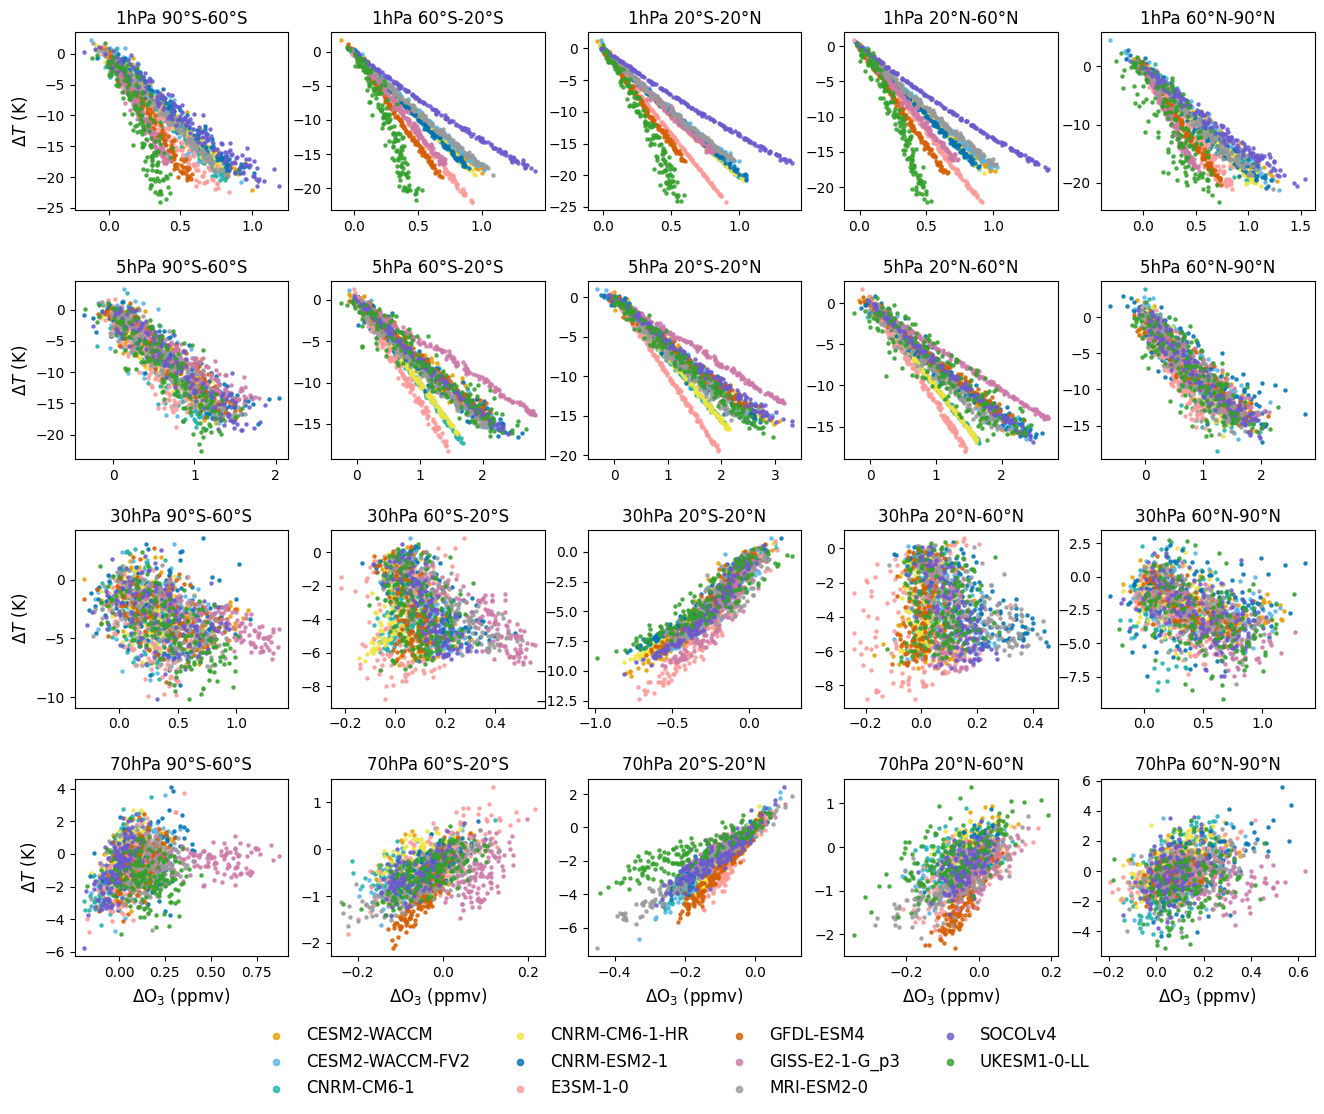

In [63]:
# change of am_zm stratospheric ozone with temperature at 1,5,30,70 hPa for 1pct
# stratopseric temp vs. time at 1,5,30,70 hPa for 1pct
###### out-lier MRI-ESM2-0

fig10_name_ind = [0,1,2,3,4,5,6,7,8,10,11]

bands = [-90,-60,-20,20,60,90]
plev_value = [100,500,3000,7000] # Pa
plev = ["1hPa","5hPa","30hPa","70hPa"]

#colors_col = cm.rainbow(np.linspace(0, 1, n_chem))
colors_col = cmc.roma(np.linspace(0, 1, n_chem))

ta_ymin = [190,200,220,240]
ta_ymax = [225,225,250,285]

band1 = ["\u00b0S","\u00b0S","\u00b0S","\u00b0N","\u00b0N"] # title band 
band2 = ["\u00b0S","\u00b0S","\u00b0N","\u00b0N","\u00b0N"]
bands_txt = [90,60,20,20,60,90]

fig10, axes10 = plt.subplots(4,5,figsize=(16,12))
plt.subplots_adjust(hspace=0.4)

for i,c in zip(np.arange(0,n_model),colors_col):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
        # index of lat bands
        ind_band = np.zeros_like(bands)
        ind_plev = np.zeros_like(plev_value)
        for n in range(0,len(bands)):
            ind_band[n] = np.where(abs(latitude.get(model_name[i])-bands[n]) == min(abs(latitude.get(model_name[i])-bands[n])))[0][0]
        for n in range(0,len(plev_value)):
            ind_plev[n] = np.where(abs(press.get(model_name[i])-plev_value[n]) == min(abs(press.get(model_name[i])-plev_value[n])))[0][0]  
        if flag_1pct[i] == 1:
            print(model_name[i])
            
            if model_name[i] == "GISS-E2-1-G_p3_":
                n_start = 15
            else:
                n_start = 0

    # plot lat-avg stratospheric temp for diff layers in one subplot
            time_1pct = np.arange(0,len(temp_am_1pct_masked.get(model_name[i])[:,0,0]))
            for k in range(0,len(bands)-1):
                for j in range(0,len(ind_plev)):
                    axes10[j,k].scatter(ma.mean(o3_am_zm_diff_1pct.get(model_name[i])[:,ind_plev[j],ind_band[k]:ind_band[k+1]],axis=1),\
                                     ma.mean(temp_am_diff_1pct.get(model_name[i])[n_start:,ind_plev[j],ind_band[k]:ind_band[k+1]],axis=1),\
                                     label=model_name[i],s = 5, alpha = 0.8, color = colors_m[model_name[i]])
                    axes10[j,k].set_title(plev[j]+" "+str(bands_txt[k])+band1[k]+"-"+str(bands_txt[k+1])+band2[k],\
                                          fontsize="large",y=1.0)
                    # axis setting
                    if j==3:
                        axes10[j,k].set_xlabel(r"$\Delta$O$_3$ (ppmv)", fontsize ="large")
                    if k == 0:
                        axes10[j,k].set_ylabel(r"$\Delta T$ (K)", fontsize ="large")
                        
legend = fig10.legend([model_name[n][:-1] for n in fig10_name_ind], bbox_to_anchor=(0.5, -0.02),frameon=False, ncols = 4, loc = 'lower center', fontsize = "large")

#n=0
#for text, color in zip(legend.get_texts(), colors_m):
#    text.set_color(colors_m[model_name[fig10_name_ind[n]]])
#    n += 1

for handle in legend.legendHandles:
    handle.set_sizes([20])
    
fig10.savefig('../Output/paper/1pct_strato_delta_o3_vs_delta_temp.pdf', bbox_inches = "tight", dpi =300) 

#### The following compute and plot tm_zm temp response.

In [64]:
# read in tm_zm temp data
flag_4CO2[8] = 1

path_temp_tm_zm = "../data/temp/tm_zm"
species = "ta"

latitude_tm_temp = dict()
temp_tm_piControl_masked = dict()
temp_tm_4CO2_masked = dict()
temp_tm_1pct_masked = dict()

for i in range(0,len(model_name)): 
    for f in os.listdir(path_temp_tm_zm):
        if os.path.isfile(os.path.join(path_temp_tm_zm,f)) and (model_name[i] in f): #and ("interpolate" in f):
            if experiment[0] in f and "verinterpolate" not in f:
                temp_tm_piControl = nc.Dataset(os.path.join(path_temp_tm_zm,f)).variables[species][0,:,:,0]
                latitude_tm_temp[model_name[i]] = nc.Dataset(os.path.join(path_temp_tm_zm,f)).variables['lat'][:]
                temp_tm_piControl_masked[model_name[i]] = ma.masked_values(temp_tm_piControl, 1e20)
                print("pi",model_name[i],np.mean(temp_tm_piControl_masked.get(model_name[i])))
            
            if experiment[1] in f and ("last100yr" in f) and "verinterpolate" not in f:
                print(model_name[i])
                temp_tm_4CO2 = nc.Dataset(os.path.join(path_temp_tm_zm,f)).variables[species][0,:,:,0]
                #print(temp_tm_4CO2[:,0])
                temp_tm_4CO2_masked[model_name[i]] = ma.masked_values(temp_tm_4CO2, 1e20)
                print("4co2",model_name[i],np.mean(temp_tm_4CO2_masked.get(model_name[i])))
            
            if experiment[2] in f and "135-145" in f and "verinterpolate" not in f:
                print(model_name[i])
                temp_tm_1pct = nc.Dataset(os.path.join(path_temp_tm_zm,f)).variables[species][0,:,:,0]
                temp_tm_1pct_masked[model_name[i]] = ma.masked_values(temp_tm_1pct, 1e20)
                print("1pct",model_name[i],np.mean(temp_tm_1pct_masked.get(model_name[i])))

CESM2-WACCM_
1pct CESM2-WACCM_ 238.21627947295423
CESM2-WACCM_
4co2 CESM2-WACCM_ 238.88856148331953
pi CESM2-WACCM_ 238.4512085635359
CESM2-WACCM-FV2_
1pct CESM2-WACCM-FV2_ 237.83242577691453
CESM2-WACCM-FV2_
4co2 CESM2-WACCM-FV2_ 238.32239756367665
pi CESM2-WACCM-FV2_ 238.19220132743362
CNRM-CM6-1_
1pct CNRM-CM6-1_ 237.1434172513413
CNRM-CM6-1_
4co2 CNRM-CM6-1_ 237.65213578208832
pi CNRM-CM6-1_ 236.9811184482047
CNRM-CM6-1-HR_
1pct CNRM-CM6-1-HR_ 237.14959647835656
CNRM-CM6-1-HR_
4co2 CNRM-CM6-1-HR_ 237.53003961267606
pi CNRM-CM6-1-HR_ 236.74457159624413
CNRM-ESM2-1_
1pct CNRM-ESM2-1_ 237.77329240610814
CNRM-ESM2-1_
4co2 CNRM-ESM2-1_ 238.17669211721008
pi CNRM-ESM2-1_ 237.64135369376805
E3SM-1-0_
1pct E3SM-1-0_ 240.1216435526704
E3SM-1-0_
4co2 E3SM-1-0_ 240.71495739053776
pi E3SM-1-0_ 239.7107310628303
GFDL-ESM4_
1pct GFDL-ESM4_ 239.01262848751836
GFDL-ESM4_
4co2 GFDL-ESM4_ 239.21348664906102
pi GFDL-ESM4_ 239.90083993544602
GISS-E2-1-G_p3_
1pct GISS-E2-1-G_p3_ 237.85786112742218
GISS

In [65]:
# read in zm temp data for t-test

path_temp_zm = "../data/temp/zm_monmean"
species = "ta"

temp_zm_piControl_masked = dict()
temp_zm_4CO2_masked = dict()
temp_zm_1pct_masked = dict()

for i in range(0,len(model_name)): 
    for f in os.listdir(path_temp_zm):
        if os.path.isfile(os.path.join(path_temp_zm,f)) and (model_name[i] in f): 
            if experiment[0] in f:
                print(model_name[i])
                temp_zm_piControl = nc.Dataset(os.path.join(path_temp_zm,f)).variables[species][:,:,:,0]
                temp_zm_piControl_masked[model_name[i]] = ma.masked_values(temp_zm_piControl, 1e20)
                print("pi",model_name[i],np.shape(temp_zm_piControl_masked.get(model_name[i])))
            
            if experiment[1] in f and ("last100yr" in f):
                temp_zm_4CO2 = nc.Dataset(os.path.join(path_temp_zm,f)).variables[species][:,:,:,0]
                temp_zm_4CO2_masked[model_name[i]] = ma.masked_values (temp_zm_4CO2, 1e20)
                print("4co2",model_name[i],np.shape(temp_zm_4CO2_masked.get(model_name[i])))
            
            if experiment[2] in f and ("135-145" in f):
                temp_zm_1pct = nc.Dataset(os.path.join(path_temp_zm,f)).variables[species][:,:,:,0]
                temp_zm_1pct_masked[model_name[i]] = ma.masked_values(temp_zm_1pct, 1e20)
                print("1pct",model_name[i],np.shape(temp_zm_1pct_masked.get(model_name[i])))

1pct CESM2-WACCM_ (132, 19, 192)
CESM2-WACCM_
pi CESM2-WACCM_ (1800, 19, 192)
4co2 CESM2-WACCM_ (1200, 19, 192)
1pct CESM2-WACCM-FV2_ (132, 19, 96)
4co2 CESM2-WACCM-FV2_ (1200, 19, 96)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (1800, 19, 96)
1pct CNRM-CM6-1_ (132, 19, 128)
4co2 CNRM-CM6-1_ (1200, 19, 128)
CNRM-CM6-1_
pi CNRM-CM6-1_ (1800, 19, 128)
1pct CNRM-CM6-1-HR_ (132, 19, 360)
4co2 CNRM-CM6-1-HR_ (1200, 19, 360)
CNRM-CM6-1-HR_
pi CNRM-CM6-1-HR_ (1800, 19, 360)
1pct CNRM-ESM2-1_ (132, 19, 128)
4co2 CNRM-ESM2-1_ (1200, 19, 128)
CNRM-ESM2-1_
pi CNRM-ESM2-1_ (1800, 19, 128)
1pct E3SM-1-0_ (132, 19, 180)
4co2 E3SM-1-0_ (1200, 19, 180)
E3SM-1-0_
pi E3SM-1-0_ (1800, 19, 180)
1pct GFDL-ESM4_ (132, 19, 180)
4co2 GFDL-ESM4_ (1200, 19, 180)
GFDL-ESM4_
pi GFDL-ESM4_ (1800, 19, 180)
1pct GISS-E2-1-G_p3_ (132, 19, 90)
4co2 GISS-E2-1-G_p3_ (1800, 19, 90)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (1800, 19, 90)
1pct MRI-ESM2-0_ (132, 19, 64)
4co2 MRI-ESM2-0_ (1200, 19, 64)
MRI-ESM2-0_
pi MRI-ESM2-0_ (1800, 1

In [66]:
# compute diff tm_zm temp and t-test

temp_tm_diff_4CO2 = dict()
temp_tm_diff_1pct = dict()

p_tm_temp_4CO2 = dict()
p_tm_temp_1pct = dict()

strip_tm_temp_4CO2_press = dict()
strip_tm_temp_1pct_press = dict()
strip_tm_temp_4CO2_lat = dict()
strip_tm_temp_1pct_lat = dict()

for i in range(0,len(model_name)): 
    if flag_4CO2[i] == 1:
        print(model_name[i])
        temp_tm_diff_4CO2[model_name[i]] = \
        temp_tm_4CO2_masked.get(model_name[i]) - temp_tm_piControl_masked.get(model_name[i])
        print("4CO2",model_name[i],np.shape(temp_tm_diff_4CO2.get(model_name[i])))
        # t-test
        [stat, p_tm_temp_4CO2[model_name[i]]] = stats.ttest_ind\
        (temp_zm_4CO2_masked.get(model_name[i]), temp_zm_piControl_masked.get(model_name[i]),\
         axis = 0)
        
        # find the location which not satisfy the confidence level at 99%
        strip_tm_temp_4CO2_lat[model_name[i]] = np.where(p_tm_temp_4CO2.get(model_name[i]) > 0.005)[1]
        strip_tm_temp_4CO2_press[model_name[i]] = np.where(p_tm_temp_4CO2.get(model_name[i]) > 0.005)[0]
        print("4CO2",model_name[i],np.shape(strip_tm_temp_4CO2_lat.get(model_name[i])))
    
    if flag_1pct[i] == 1:
        print(model_name[i])
        temp_tm_diff_1pct[model_name[i]] = \
        temp_tm_1pct_masked.get(model_name[i]) - temp_tm_piControl_masked.get(model_name[i])
        print("1pct",model_name[i],np.shape(temp_tm_diff_1pct.get(model_name[i])))
        # t-test
        [stat, p_tm_temp_1pct[model_name[i]]] = stats.ttest_ind\
        (temp_zm_1pct_masked.get(model_name[i]), temp_zm_piControl_masked.get(model_name[i]),\
         axis = 0)
        
        # find the location which not satisfy the confidence level at 99%
        strip_tm_temp_1pct_lat[model_name[i]] = np.where(p_tm_temp_1pct.get(model_name[i]) > 0.005)[1]
        strip_tm_temp_1pct_press[model_name[i]] = np.where(p_tm_temp_1pct.get(model_name[i]) > 0.005)[0]
        print("1pct",model_name[i],np.shape(strip_tm_temp_1pct_lat.get(model_name[i])))

CESM2-WACCM_
4CO2 CESM2-WACCM_ (19, 192)
4CO2 CESM2-WACCM_ (329,)
CESM2-WACCM_
1pct CESM2-WACCM_ (19, 192)
1pct CESM2-WACCM_ (477,)
CESM2-WACCM-FV2_
4CO2 CESM2-WACCM-FV2_ (19, 96)
4CO2 CESM2-WACCM-FV2_ (162,)
CESM2-WACCM-FV2_
1pct CESM2-WACCM-FV2_ (19, 96)
1pct CESM2-WACCM-FV2_ (254,)
CNRM-CM6-1_
4CO2 CNRM-CM6-1_ (19, 128)
4CO2 CNRM-CM6-1_ (72,)
CNRM-CM6-1_
1pct CNRM-CM6-1_ (19, 128)
1pct CNRM-CM6-1_ (239,)
CNRM-CM6-1-HR_
4CO2 CNRM-CM6-1-HR_ (19, 360)


/home/wangjingy/.conda/envs/thesis/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1199: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/wangjingy/.conda/envs/thesis/lib/python3.11/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_19592/3870598134.py:36: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  [stat, p_tm_temp_1pct[model_name[i]]] = stats.ttest_ind\


4CO2 CNRM-CM6-1-HR_ (334,)
CNRM-CM6-1-HR_
1pct CNRM-CM6-1-HR_ (19, 360)
1pct CNRM-CM6-1-HR_ (759,)
CNRM-ESM2-1_
4CO2 CNRM-ESM2-1_ (19, 128)
4CO2 CNRM-ESM2-1_ (145,)
CNRM-ESM2-1_
1pct CNRM-ESM2-1_ (19, 128)
1pct CNRM-ESM2-1_ (297,)
E3SM-1-0_
4CO2 E3SM-1-0_ (19, 180)
4CO2 E3SM-1-0_ (154,)
E3SM-1-0_
1pct E3SM-1-0_ (19, 180)
1pct E3SM-1-0_ (370,)
GFDL-ESM4_
4CO2 GFDL-ESM4_ (19, 180)
4CO2 GFDL-ESM4_ (283,)
GFDL-ESM4_
1pct GFDL-ESM4_ (19, 180)
1pct GFDL-ESM4_ (454,)
GISS-E2-1-G_p3_
4CO2 GISS-E2-1-G_p3_ (19, 90)
4CO2 GISS-E2-1-G_p3_ (128,)
GISS-E2-1-G_p3_
1pct GISS-E2-1-G_p3_ (19, 90)
1pct GISS-E2-1-G_p3_ (192,)
MRI-ESM2-0_
4CO2 MRI-ESM2-0_ (19, 64)
4CO2 MRI-ESM2-0_ (91,)
MRI-ESM2-0_
1pct MRI-ESM2-0_ (19, 64)
1pct MRI-ESM2-0_ (170,)
SOCOL-MPIOM_
4CO2 SOCOL-MPIOM_ (41, 48)
4CO2 SOCOL-MPIOM_ (57,)
SOCOLv4_
4CO2 SOCOLv4_ (41, 96)
4CO2 SOCOLv4_ (218,)
SOCOLv4_
1pct SOCOLv4_ (41, 96)
1pct SOCOLv4_ (401,)
UKESM1-0-LL_
4CO2 UKESM1-0-LL_ (19, 144)
4CO2 UKESM1-0-LL_ (25,)
UKESM1-0-LL_
1pct UKESM1-0-LL

CESM2-WACCM_
CESM2-WACCM-FV2_
CNRM-CM6-1_
CNRM-CM6-1-HR_
CNRM-ESM2-1_
E3SM-1-0_
GFDL-ESM4_
GISS-E2-1-G_p3_
MRI-ESM2-0_
SOCOL-MPIOM_
SOCOLv4_
UKESM1-0-LL_


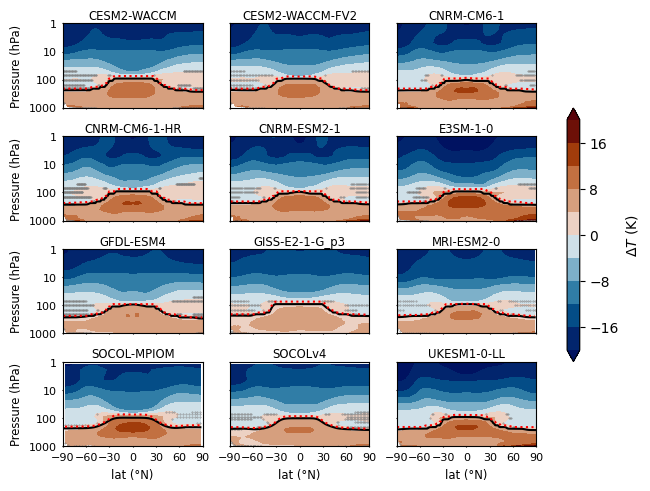

In [67]:
# plot relative difference of tm_zm temp for 4CO2 

# diff 4CO2 all
nrow_diff_4CO2 = 4
ncol_diff_4CO2 = 3
y_subtitle = 0.95
labelsize = 8

# turn-on/off t-test plot
flag_ttest = 1

# set the colormap
#cmap = cm.coolwarm
cmap = cmc.vik

nplot = 0 
fig1, axes1 = plt.subplots(nrow_diff_4CO2,ncol_diff_4CO2,constrained_layout=True) # for subplots
for i in np.arange(0,n_model):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
        if flag_4CO2[i] == 1:
            nplot += 1
            print(model_name[i])

            ax1 = plt.subplot(nrow_diff_4CO2,ncol_diff_4CO2,nplot)
            ax1.set_xlim(-90,90)
            ax1.set_ylim(100,10**5)
            ax1.set_yscale('log')
            ax1.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
            ax1.set_yticks(ticks = [10**5,10**4,10**3,10**2], labels = ["1000","100","10","1"])
            ax1.tick_params(axis='x', labelsize=labelsize, length=1)
            ax1.tick_params(axis='y', labelsize=labelsize, length=1)
            ax1.set_title(model_name[i][:-1], fontsize = "small", y = y_subtitle)
            ax1.invert_yaxis()
            levels = np.linspace(-20, 20, 11)

            cs1 = ax1.contourf(latitude_tm_temp.get(model_name[i]), press.get(model_name[i]),\
                             temp_tm_diff_4CO2.get(model_name[i])[:],\
                             corner_mask = False, norm=colors.CenteredNorm(),levels=levels,\
                             cmap=cmap, extend = "both")

            ax1.plot(latitude_tm_temp.get(model_name[i]),tropo_tm_piControl_compute.get(model_name[i])[0,:],'-k',\
                     latitude_tm_temp.get(model_name[i]),tropo_tm_4CO2_compute.get(model_name[i])[0,:],':r')
        
            if flag_ttest == 1:

                ax1.scatter(latitude_tm_temp.get(model_name[i])[strip_tm_temp_4CO2_lat.get(model_name[i])],\
                           press.get(model_name[i])[strip_tm_temp_4CO2_press.get(model_name[i])],\
                           marker = '.', s=0.5, c='grey')
            
            # for single plot
            #cbar = fig1.colorbar(cs,label = "%")
            #ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
            #ax.set_xlabel("lat (\u00b0N)")
            #ax.set_ylabel("Pressure (Pa)")
            #ax.set_title(model_name[i][:-1])
            #plt.savefig('../Output/4CO2/' + species + '_' + model_name[i][:-1]+'_reldiff_4xCO2_ttest')
            
            # for subplots
            nplot_xaxis = np.arange((nrow_diff_4CO2-1)*ncol_diff_4CO2+1,nrow_diff_4CO2*ncol_diff_4CO2+1)
            if (nplot not in nplot_xaxis):
                ax1.xaxis.set_tick_params(labelbottom=False)
            else:
                ax1.set_xlabel("lat (\u00b0N)", fontsize = "small")
                
            if (nplot%ncol_diff_4CO2 != 1):
                ax1.yaxis.set_tick_params(labelleft=False)
            else:
                ax1.set_ylabel("Pressure (hPa)", fontsize = "small")
        
# for subplots: 
#fig1.delaxes(axes1[4,2]) # for all models
fig1.colorbar(cs1, ax=axes1.ravel().tolist(),label = r"$\Delta T$ (K)", shrink = 0.6)
fig1.savefig('../Output/paper/tm_zm_temp_reldiff_4xCO2_100yr_chem_models_ttest.pdf', dpi = 300)

CESM2-WACCM_
CESM2-WACCM-FV2_
CNRM-CM6-1_
CNRM-CM6-1-HR_
CNRM-ESM2-1_
E3SM-1-0_
GFDL-ESM4_
GISS-E2-1-G_p3_
MRI-ESM2-0_
SOCOLv4_
UKESM1-0-LL_


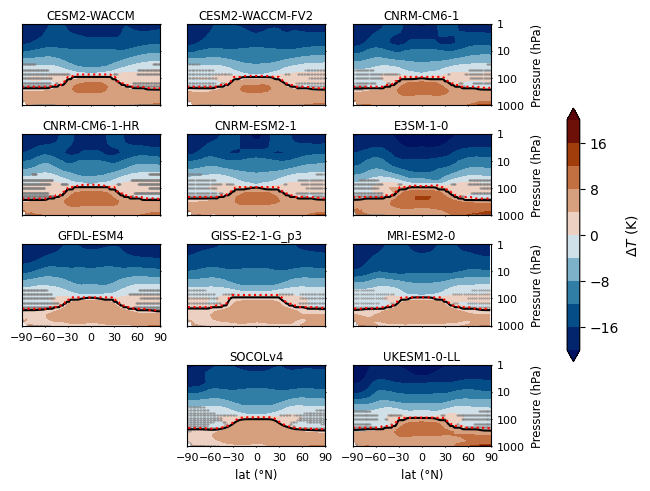

In [68]:
# plot relative difference of tm_zm temp for 1pct CO2

# diff 1pct chem
nrow_diff_1pct = 4
ncol_diff_1pct = 3
y_subtitle = 0.95
labelsize = 8

# turn-on/off t-test plot
flag_ttest = 1
n = -1
nplot = [1,2,3,4,5,6,7,8,9,11,12]

# set the colormap
#cmap = cm.coolwarm

fig1, axes1 = plt.subplots(nrow_diff_1pct,ncol_diff_1pct,constrained_layout=True) # for subplots
for i in np.arange(0,n_model):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
        if flag_1pct[i] == 1:
            n += 1
            print(model_name[i])

            ax1 = plt.subplot(nrow_diff_1pct,ncol_diff_1pct,nplot[n])
            ax1.set_xlim(-90,90)
            ax1.set_ylim(100,10**5)
            ax1.set_yscale('log')
            ax1.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
            
            ax1.yaxis.tick_right()
            ax1.yaxis.set_label_position ("right") 
            ax1.set_yticks(ticks = [10**5,10**4,10**3,10**2], labels = ["1000","100","10","1"])
            ax1.tick_params(axis='x', labelsize=labelsize, length=1)
            ax1.tick_params(axis='y', labelsize=labelsize, length=1)
            ax1.set_title(model_name[i][:-1], fontsize = "small", y = y_subtitle)
            ax1.invert_yaxis()
            levels = np.linspace(-20, 20, 11)

            cs1 = ax1.contourf(latitude_tm_temp.get(model_name[i]), press.get(model_name[i]),\
                             temp_tm_diff_1pct.get(model_name[i])[:],\
                             corner_mask = False, norm=colors.CenteredNorm(),levels=levels,\
                             cmap=cmap, extend = "both")

            ax1.plot(latitude_tm_temp.get(model_name[i]),tropo_tm_piControl_compute.get(model_name[i])[0,:],'-k',\
                     latitude_tm_temp.get(model_name[i]),tropo_tm_1pct_compute.get(model_name[i])[0,:],':r')
        
            if flag_ttest == 1:
                ax1.scatter(latitude_tm_temp.get(model_name[i])[strip_tm_temp_1pct_lat.get(model_name[i])],\
                           press.get(model_name[i])[strip_tm_temp_1pct_press.get(model_name[i])],\
                           marker = '.', s=0.5, c='grey')
            
            # for single plot
            #cbar = fig1.colorbar(cs,label = "%")
            #ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
            #ax.set_xlabel("lat (\u00b0N)")
            #ax.set_ylabel("Pressure (Pa)")
            #ax.set_title(model_name[i][:-1])
            #plt.savefig('../Output/4CO2/' + species + '_' + model_name[i][:-1]+'_reldiff_4xCO2_ttest')
            
            # for subplots
            nplot_xaxis = np.arange((nrow_diff_1pct-1)*ncol_diff_1pct+1,nrow_diff_1pct*ncol_diff_4CO2+1)
            if (nplot[n] not in nplot_xaxis and n!=6):
                ax1.xaxis.set_tick_params(labelbottom=False)
            elif n!= 6:
                ax1.set_xlabel("lat (\u00b0N)", fontsize = "small")
                
            if (nplot[n]%ncol_diff_1pct != 0):
                ax1.yaxis.set_tick_params(labelright=False)
            else:
                ax1.set_ylabel("Pressure (hPa)", fontsize = "small")

# for subplots: 
#fig1.delaxes(axes1[2,1])
fig1.delaxes(axes1[3,0])
fig1.colorbar(cs1, ax=axes1.ravel().tolist(),label = r"$\Delta T$ (K)", shrink = 0.6)
fig1.savefig('../Output/paper/tm_zm_temp_reldiff_1pct_chem_models_ttest.pdf', dpi=300)

# The following cells compute and plot tm tas.

In [69]:
# read in timemean surface temp
longitude_tm_tas = dict()
latitude_tm_tas = dict()
tas_tm_piControl_masked = dict()
tas_tm_4CO2_masked = dict()
tas_tm_1pct_masked = dict()
tas_tm_diff_4CO2 = dict()
tas_tm_diff_1pct = dict()

species = "tas"
path_tas = "../data/T_surf/timmean/"

for i in range(0,len(model_name_tas)): 
    for f in os.listdir(path_tas):
        if os.path.isfile(os.path.join(path_tas,f)) and (model_name_tas[i] in f):
            if experiment[0] in f:
                tm_tas_piControl = nc.Dataset(os.path.join(path_tas,f))
                tas_tm_piControl = tm_tas_piControl.variables[species][0,:,:]
                longitude_tm_tas[model_name_tas[i]] = tm_tas_piControl.variables['lon'][:]
                latitude_tm_tas[model_name_tas[i]] = tm_tas_piControl.variables['lat'][:]
                tas_tm_piControl_masked[model_name_tas[i]] = ma.masked_values (tas_tm_piControl, 1e20)
                print("pi",model_name_tas[i],np.shape(tas_tm_piControl_masked.get(model_name_tas[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                tm_tas_4CO2 = nc.Dataset(os.path.join(path_tas,f))
                tas_tm_4CO2 = tm_tas_4CO2.variables[species][0,:,:]
                tas_tm_4CO2_masked[model_name_tas[i]] = ma.masked_values (tas_tm_4CO2, 1e20)
                print("4CO2",model_name_tas[i],np.shape(tas_tm_4CO2_masked.get(model_name_tas[i])))
            
            elif experiment[2] in f and ("135-145" in f):
                tm_tas_1pct = nc.Dataset(os.path.join(path_tas,f))
                tas_tm_1pct = tm_tas_1pct.variables[species][0,:,:]
                tas_tm_1pct_masked[model_name_tas[i]] = ma.masked_values (tas_tm_1pct, 1e20)
                print("1pct",model_name_tas[i],np.shape(tas_tm_1pct_masked.get(model_name_tas[i])))

1pct CESM2-WACCM_ (192, 288)
4CO2 CESM2-WACCM_ (192, 288)
pi CESM2-WACCM_ (192, 288)
1pct CESM2-WACCM-FV2_ (96, 144)
4CO2 CESM2-WACCM-FV2_ (96, 144)
pi CESM2-WACCM-FV2_ (96, 144)
1pct CNRM-CM6-1_ (128, 256)
4CO2 CNRM-CM6-1_ (128, 256)
pi CNRM-CM6-1_ (128, 256)
1pct CNRM-CM6-1-HR_ (360, 720)
4CO2 CNRM-CM6-1-HR_ (360, 720)
pi CNRM-CM6-1-HR_ (360, 720)
pi CNRM-ESM2-1_ (128, 256)
1pct CNRM-ESM2-1_ (128, 256)
4CO2 CNRM-ESM2-1_ (128, 256)
1pct E3SM-1-0_ (180, 360)
4CO2 E3SM-1-0_ (180, 360)
pi E3SM-1-0_ (180, 360)
1pct GFDL-ESM4_ (180, 288)
4CO2 GFDL-ESM4_ (180, 288)
pi GFDL-ESM4_ (180, 288)
1pct GISS-E2-1-G_p3_ (90, 144)
4CO2 GISS-E2-1-G_p3_ (90, 144)
pi GISS-E2-1-G_p3_ (90, 144)
pi GISS-E2-2-G_p3_ (90, 144)
4CO2 GISS-E2-2-G_p3_ (90, 144)
1pct MRI-ESM2-0_ (160, 320)
4CO2 MRI-ESM2-0_ (160, 320)
pi MRI-ESM2-0_ (160, 320)
4CO2 SOCOL-MPIOM_ (48, 96)
pi SOCOL-MPIOM_ (48, 96)
1pct SOCOLv4_ (96, 192)
4CO2 SOCOLv4_ (96, 192)
pi SOCOLv4_ (96, 192)
1pct UKESM1-0-LL_ (144, 192)
4CO2 UKESM1-0-LL_ (144, 

In [70]:
# read in annual-mean surface temp for t-test

tas_am_piControl_masked = dict()
tas_am_4CO2_masked = dict()
tas_am_1pct_masked = dict()
tas_am_diff_4CO2 = dict()
tas_am_diff_1pct = dict()

species = "tas"
path_am_tas = "../data/T_surf/annual_mean/"

for i in range(0,len(model_name)): 
    for f in os.listdir(path_am_tas):
        if os.path.isfile(os.path.join(path_am_tas,f)) and (model_name[i] in f):
            if experiment[0] in f:
                am_tas_piControl = nc.Dataset(os.path.join(path_am_tas,f))
                tas_am_piControl = am_tas_piControl.variables[species][:]
                tas_am_piControl_masked[model_name[i]] = ma.masked_values (tas_am_piControl, 1e20)
                print("pi",model_name[i],np.shape(tas_am_piControl_masked.get(model_name[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                am_tas_4CO2 = nc.Dataset(os.path.join(path_am_tas,f))
                tas_am_4CO2 = am_tas_4CO2.variables[species][:]
                tas_am_4CO2_masked[model_name[i]] = ma.masked_values (tas_am_4CO2, 1e20)
                print("4CO2",model_name[i],np.shape(tas_am_4CO2_masked.get(model_name[i])))
            
            elif experiment[2] in f and ("135-145" in f):
                am_tas_1pct = nc.Dataset(os.path.join(path_am_tas,f))
                tas_am_1pct = am_tas_1pct.variables[species][:]
                tas_am_1pct_masked[model_name[i]] = ma.masked_values (tas_am_1pct, 1e20)
                print("1pct",model_name[i],np.shape(tas_am_1pct_masked.get(model_name[i])))

1pct CESM2-WACCM_ (11, 192, 288)
4CO2 CESM2-WACCM_ (100, 192, 288)
pi CESM2-WACCM_ (150, 192, 288)
1pct CESM2-WACCM-FV2_ (11, 96, 144)
4CO2 CESM2-WACCM-FV2_ (100, 96, 144)
pi CESM2-WACCM-FV2_ (150, 96, 144)
1pct CNRM-CM6-1_ (11, 128, 256)
4CO2 CNRM-CM6-1_ (100, 128, 256)
pi CNRM-CM6-1_ (150, 128, 256)
pi CNRM-CM6-1-HR_ (150, 360, 720)
1pct CNRM-CM6-1-HR_ (11, 360, 720)
4CO2 CNRM-CM6-1-HR_ (100, 360, 720)
1pct CNRM-ESM2-1_ (11, 128, 256)
4CO2 CNRM-ESM2-1_ (100, 128, 256)
pi CNRM-ESM2-1_ (150, 128, 256)
1pct E3SM-1-0_ (11, 180, 360)
4CO2 E3SM-1-0_ (100, 180, 360)
pi E3SM-1-0_ (150, 180, 360)
1pct GFDL-ESM4_ (11, 180, 288)
4CO2 GFDL-ESM4_ (100, 180, 288)
pi GFDL-ESM4_ (150, 180, 288)
1pct GISS-E2-1-G_p3_ (11, 90, 144)
4CO2 GISS-E2-1-G_p3_ (100, 90, 144)
pi GISS-E2-1-G_p3_ (150, 90, 144)
1pct MRI-ESM2-0_ (11, 160, 320)
4CO2 MRI-ESM2-0_ (100, 160, 320)
pi MRI-ESM2-0_ (150, 160, 320)
4CO2 SOCOL-MPIOM_ (100, 48, 96)
pi SOCOL-MPIOM_ (150, 48, 96)
pi SOCOLv4_ (150, 96, 192)
1pct SOCOLv4_ (11, 9

In [71]:
# compute and plot diff of tm tas and t-test

p_tm_tas_4CO2 = dict()
p_tm_tas_1pct = dict()
strip_tm_tas_4CO2_lon = dict()
strip_tm_tas_1pct_lon = dict()
strip_tm_tas_4CO2_lat = dict()
strip_tm_tas_1pct_lat = dict()

for i in range(0,n_model):
    if flag_4CO2[i] == 1:
        # compute the difference 
        tas_tm_diff_4CO2[model_name[i]] = \
        (tas_tm_4CO2_masked.get(model_name[i]) - tas_tm_piControl_masked.get(model_name[i]))
        print(model_name[i],np.mean(tas_tm_diff_4CO2.get(model_name[i])))
        # t-test
        [stat, p_tm_tas_4CO2[model_name[i]]] = stats.ttest_ind\
        (tas_am_4CO2_masked.get(model_name[i]), tas_am_piControl_masked.get(model_name[i]),\
         axis = 0)
        # find the location which not satisfy the confidence level at 99%
        strip_tm_tas_4CO2_lat[model_name[i]] = np.where(p_tm_tas_4CO2.get(model_name[i]) > 0.005)[0]
        strip_tm_tas_4CO2_lon[model_name[i]] = np.where(p_tm_tas_4CO2.get(model_name[i]) > 0.005)[1]
        print("4CO2",model_name[i],np.shape(strip_tm_tas_4CO2_lat.get(model_name[i])))
        
    if flag_1pct[i] == 1:
        # compute the difference 
        tas_tm_diff_1pct[model_name[i]] = \
        (tas_tm_1pct_masked.get(model_name[i]) - tas_tm_piControl_masked.get(model_name[i]))
        print(model_name[i],np.mean(tas_tm_diff_1pct.get(model_name[i])))
        # t-test
        [stat, p_tm_tas_1pct[model_name[i]]] = stats.ttest_ind\
        (tas_am_1pct_masked.get(model_name[i]), tas_am_piControl_masked.get(model_name[i]),\
         axis = 0)
        # find the location which not satisfy the confidence level at 99%
        strip_tm_tas_1pct_lat[model_name[i]] = np.where(p_tm_tas_1pct.get(model_name[i]) > 0.005)[0]
        strip_tm_tas_1pct_lon[model_name[i]] = np.where(p_tm_tas_1pct.get(model_name[i]) > 0.005)[1]
        print("1pct",model_name[i],np.shape(strip_tm_tas_1pct_lat.get(model_name[i])))

CESM2-WACCM_ 7.247572
4CO2 CESM2-WACCM_ (0,)
CESM2-WACCM_ 6.0102506
1pct CESM2-WACCM_ (5,)
CESM2-WACCM-FV2_ 6.814661
4CO2 CESM2-WACCM-FV2_ (0,)
CESM2-WACCM-FV2_ 5.9906287
1pct CESM2-WACCM-FV2_ (13,)
CNRM-CM6-1_ 8.011924
4CO2 CNRM-CM6-1_ (0,)
CNRM-CM6-1_ 7.0423665
1pct CNRM-CM6-1_ (0,)
CNRM-CM6-1-HR_ 7.5321655
4CO2 CNRM-CM6-1-HR_ (0,)
CNRM-CM6-1-HR_ 6.9096518
1pct CNRM-CM6-1-HR_ (0,)
CNRM-ESM2-1_ 7.363796
4CO2 CNRM-ESM2-1_ (0,)
CNRM-ESM2-1_ 6.3370247
1pct CNRM-ESM2-1_ (0,)
E3SM-1-0_ 9.743376
4CO2 E3SM-1-0_ (0,)
E3SM-1-0_ 8.931528
1pct E3SM-1-0_ (0,)
GFDL-ESM4_ 4.7900887
4CO2 GFDL-ESM4_ (55,)
GFDL-ESM4_ 4.4351864
1pct GFDL-ESM4_ (249,)
GISS-E2-1-G_p3_ 4.290422
4CO2 GISS-E2-1-G_p3_ (69,)
GISS-E2-1-G_p3_ 4.2153373
1pct GISS-E2-1-G_p3_ (49,)
MRI-ESM2-0_ 5.4235444
4CO2 MRI-ESM2-0_ (77,)
MRI-ESM2-0_ 4.582731
1pct MRI-ESM2-0_ (231,)
SOCOL-MPIOM_ 6.1574445
4CO2 SOCOL-MPIOM_ (3,)
SOCOLv4_ 5.2653675
4CO2 SOCOLv4_ (0,)
SOCOLv4_ 4.664063
1pct SOCOLv4_ (0,)
UKESM1-0-LL_ 8.9551
4CO2 UKESM1-0-LL_ (0,)

CESM2-WACCM_
CESM2-WACCM-FV2_
CNRM-CM6-1_
CNRM-CM6-1-HR_
CNRM-ESM2-1_
E3SM-1-0_
GFDL-ESM4_
GISS-E2-1-G_p3_
MRI-ESM2-0_
SOCOL-MPIOM_
SOCOLv4_
UKESM1-0-LL_


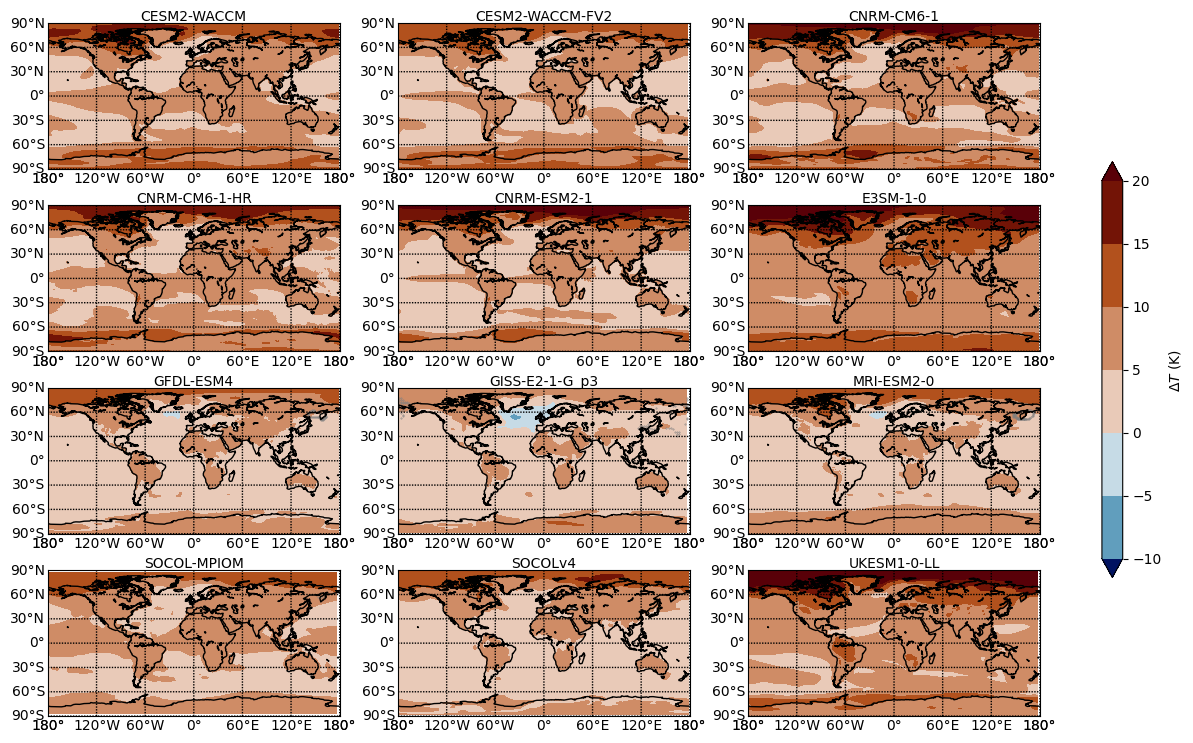

In [72]:
# plot diff tm tas for 4CO2 (last100yr)

# diff 4CO2 chem
nrow_diff_1pct = 4
ncol_diff_1pct = 3
y_subtitle = 0.96
labelsize = 8

import cmaps
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid

flag_ttest = 1

m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

nplot = 0

#cmap2 = cm.RdYlBu
#cmap2 = cmap2.reversed()
cmap2 = cmc.vik
norm = mpl.colors.Normalize(vmin=-20, vmax=20)
levels = np.linspace(-10, 20, 7)

fig12, axes12 = plt.subplots(nrow_diff_4CO2,ncol_diff_4CO2,figsize=(16,9)) # for subplots
plt.subplots_adjust(hspace=0.25)

for i in np.arange(0,n_model):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
        if flag_4CO2[i] == 1:
            nplot += 1
            print(model_name[i])
            #shift data lon by -180 to convert from (0,360) to (-180,180)
            data, lons = shiftgrid(180., tas_tm_diff_4CO2.get(model_name[i]), longitude_tm_tas.get(model_name[i]), start=False)
            lons, lats = np.meshgrid(lons, latitude_tm_tas.get(model_name[i]))
            x, y = m(lons, lats)
            ax12 = plt.subplot(nrow_diff_4CO2,ncol_diff_4CO2,nplot)
            ax12.set_ylim([-90,90])
            ax12.set_title(model_name[i][:-1], fontsize = "medium", y = y_subtitle)

            cs12 = m.contourf(x,y,data,\
                             corner_mask = False,levels=levels,norm=norm,\
                             cmap=cmap2, extend = "both")
            # add contour lines
            #cs72 = ax7.contour(cs7, levels=cs7.levels[:], colors='w',linewidths = 1)
            # add label on countour lines
            #ax7.clabel(cs72, fmt='%2d', colors='k', fontsize=6)
            
            m.drawcoastlines(linewidth=1)
            m.drawparallels(np.arange(-90,91,30),labels=[1,0,0,0])
            m.drawmeridians(np.arange(-180,181,60),labels=[0,0,0,1])
            if flag_ttest == 1:
                ax12.scatter(x[0,strip_tm_tas_4CO2_lon.get(model_name[i])],\
                            y[strip_tm_tas_4CO2_lat.get(model_name[i]),0],\
                            marker = '.', s=0.5, c='grey')
            
            # for subplots
            #nplot_xaxis = np.arange((nrow_diff_4CO2-1)*ncol_diff_4CO2+1,nrow_diff_4CO2*ncol_diff_4CO2+1)
            #if (nplot not in nplot_xaxis):
            #    ax7.xaxis.set_tick_params(labelbottom=False)
            #else:
            #    ax7.set_xlabel("lon (\u00b0E)", fontsize = "small")
                
            #if (nplot%ncol_diff_4CO2 != 1):
            #    ax7.yaxis.set_tick_params(labelleft=False)
            #else:
            #    ax7.set_ylabel("lat (\u00b0N)", fontsize = "small")
        
# for subplots: 
#fig12.delaxes(axes12[3,2])
fig12.colorbar(cs12, ax=axes12.ravel().tolist(),label = r"$\Delta T$ (K)", shrink = 0.6)
fig12.savefig('../Output/paper/diff_tm_tas_4CO2_100yr_chem_models_ttest.pdf', bbox_inches = "tight", dpi = 300)     

CESM2-WACCM_
CESM2-WACCM-FV2_
CNRM-CM6-1_
CNRM-CM6-1-HR_
CNRM-ESM2-1_
E3SM-1-0_
GFDL-ESM4_
GISS-E2-1-G_p3_
MRI-ESM2-0_
SOCOLv4_
UKESM1-0-LL_


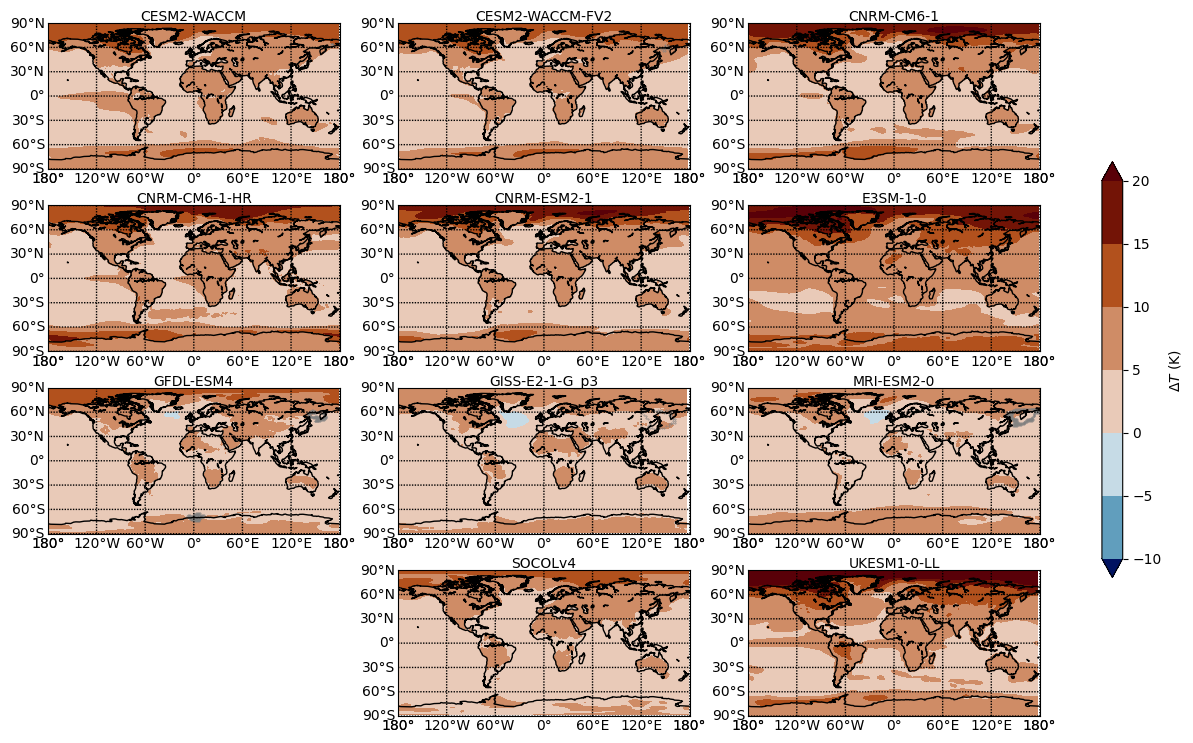

In [73]:
# plot diff tm tas for 1pct (yr 135-145)

# diff 1pct chem
nrow_diff_1pct = 4
ncol_diff_1pct = 3
y_subtitle = 0.95
labelsize = 8

import cmaps
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid

flag_ttest = 1

m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

n = -1
nplot = [1,2,3,4,5,6,7,8,9,11,12]

#cmap2 = cm.RdYlBu
#cmap2 = cmap2.reversed()
norm = mpl.colors.Normalize(vmin=-20, vmax=20)
levels = np.linspace(-10, 20, 7)

fig12, axes12 = plt.subplots(nrow_diff_1pct,ncol_diff_1pct,figsize=(16,9)) # for subplots
plt.subplots_adjust(hspace=0.25)

for i in np.arange(0,n_model):
    if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
        if flag_1pct[i] == 1:
            n += 1
            print(model_name[i])
            #shift data lon by -180 to convert from (0,360) to (-180,180)
            data, lons = shiftgrid(180., tas_tm_diff_1pct.get(model_name[i]), longitude_tm_tas.get(model_name[i]), start=False)
            lons, lats = np.meshgrid(lons, latitude_tm_tas.get(model_name[i]))
            x, y = m(lons, lats)
            ax12 = plt.subplot(nrow_diff_1pct,ncol_diff_1pct,nplot[n])
            ax12.set_ylim(-90,90)
            ax12.set_title(model_name[i][:-1], fontsize = "medium", y = 0.96)

            cs12 = m.contourf(x,y,data,\
                             corner_mask = False,levels=levels,norm=norm,\
                             cmap=cmap2, extend = "both")
            # add contour lines
            #cs72 = ax7.contour(cs7, levels=cs7.levels[:], colors='w',linewidths = 1)
            # add label on countour lines
            #ax7.clabel(cs72, fmt='%2d', colors='k', fontsize=6)
            
            m.drawcoastlines(linewidth=1)
            m.drawparallels([-90,-60,-30,0,30,60,90],labels=[1,0,0,0])
            m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
            if flag_ttest == 1:
                ax12.scatter(x[0,strip_tm_tas_1pct_lon.get(model_name[i])],\
                            y[strip_tm_tas_1pct_lat.get(model_name[i]),0],\
                            marker = '.', s=0.5, c='grey')
            
            # for subplots
            #nplot_xaxis = np.arange((nrow_diff_4CO2-1)*ncol_diff_4CO2+1,nrow_diff_4CO2*ncol_diff_4CO2+1)
            #if (nplot not in nplot_xaxis):
            #    ax7.xaxis.set_tick_params(labelbottom=False)
            #else:
            #    ax7.set_xlabel("lon (\u00b0E)", fontsize = "small")
                
            #if (nplot%ncol_diff_4CO2 != 1):
            #    ax7.yaxis.set_tick_params(labelleft=False)
            #else:
            #    ax7.set_ylabel("lat (\u00b0N)", fontsize = "small")
        
# for subplots:
fig12.delaxes(axes12[3,0])
fig12.colorbar(cs12, ax=axes12.ravel().tolist(),label = r"$\Delta T$ (K)", shrink = 0.6)
fig12.savefig('../Output/paper/diff_tm_tas_1pct_chem_models_ttest.pdf', bbox_inches = "tight", dpi = 300)     

# The following cells plot seasonal climatology for extratropical LS ozone response vs. local temperature change at certain plev.

In [74]:
# read in zm yearly monthly-mean ozone data: pi, 4co2 (150yr) and 1pct (150yr)

o3_zm_monmean_piControl_masked = dict()
o3_zm_monmean_4CO2_masked = dict()
o3_zm_monmean_1pct_masked = dict()
o3_zm_am_MAM_piControl = dict()
o3_zm_am_DJF_piControl = dict()
o3_zm_am_JJA_piControl = dict()
o3_zm_am_SON_piControl = dict()

o3_zm_am_MAM_4CO2 = dict()
o3_zm_am_DJF_4CO2 = dict()
o3_zm_am_JJA_4CO2 = dict()
o3_zm_am_SON_4CO2 = dict()

o3_zm_am_MAM_1pct = dict()
o3_zm_am_DJF_1pct = dict()
o3_zm_am_JJA_1pct = dict()
o3_zm_am_SON_1pct = dict()

species = "o3"
path_o3_zm_monmean = "../data/ozone/zonal_mean/"

for i in range(0,len(model_name)): 
    for f in os.listdir(path_o3_zm_monmean):
        if os.path.isfile(os.path.join(path_o3_zm_monmean,f)) and (model_name[i] in f):
            if experiment[0] in f:
                zm_monmean_o3_piControl = nc.Dataset(os.path.join(path_o3_zm_monmean,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_zm_monmean_piControl = zm_monmean_o3_piControl.variables[species][:,:,:,0]*10**6
                    o3_zm_monmean_piControl_masked[model_name[i]] = ma.masked_values (o3_zm_monmean_piControl, 1e20)
                else:
                    o3_zm_monmean_piControl_masked[model_name[i]] = ma.masked_values (o3_zm_monmean_piControl, 1e20)
                    o3_zm_monmean_piControl = zm_monmean_o3_piControl.variables[species][:,:,:]*10**6
                print("pi",model_name[i],np.shape(o3_zm_monmean_piControl_masked.get(model_name[i])))
                nplev = np.shape(o3_zm_monmean_piControl_masked.get(model_name[i]))[1]
                nlat = np.shape(o3_zm_monmean_piControl_masked.get(model_name[i]))[2]
                nyear = np.shape(o3_zm_monmean_piControl_masked.get(model_name[i]))[0]//12
                # compute yearly seasonal mean
                MAM = np.zeros((nyear,nplev,nlat))
                DJF = np.zeros((nyear,nplev,nlat))
                JJA = np.zeros((nyear,nplev,nlat))
                SON = np.zeros((nyear,nplev,nlat))
                for n in range(0,nyear):
                    MAM[n,:,:] = \
                    ma.mean(o3_zm_monmean_piControl_masked.get(model_name[i])[n*12+2:n*12+5,:,:],axis=0)
                    JJA[n,:,:] = \
                    ma.mean(o3_zm_monmean_piControl_masked.get(model_name[i])[n*12+5:n*12+8,:,:],axis=0)
                    SON[n,:,:] = \
                    ma.mean(o3_zm_monmean_piControl_masked.get(model_name[i])[n*12+8:n*12+11,:,:],axis=0)
                    DJF[n,:,:] = \
                    ma.mean(o3_zm_monmean_piControl_masked.get(model_name[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                o3_zm_am_MAM_piControl[model_name[i]] = MAM
                o3_zm_am_DJF_piControl[model_name[i]] = DJF
                o3_zm_am_JJA_piControl[model_name[i]] = JJA
                o3_zm_am_SON_piControl[model_name[i]] = SON
                print("pi MAM",model_name[i],np.shape(o3_zm_am_MAM_piControl.get(model_name[i])))
                print("pi DJF",model_name[i],np.shape(o3_zm_am_DJF_piControl.get(model_name[i])))
            
            elif experiment[1] in f and ("last100yr" not in f):
                zm_monmean_o3_4CO2 = nc.Dataset(os.path.join(path_o3_zm_monmean,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_zm_monmean_4CO2 = zm_monmean_o3_4CO2.variables[species][:,:,:,0]*10**6
                    o3_zm_monmean_4CO2_masked[model_name[i]] = ma.masked_values (o3_zm_monmean_4CO2, 1e20)
                else:
                    o3_zm_monmean_4CO2 = zm_monmean_o3_4CO2.variables[species][:,:,:]*10**6
                    o3_zm_monmean_4CO2_masked[model_name[i]] = ma.masked_values (o3_zm_monmean_4CO2, 1e20)
                print("4CO2",model_name[i],np.shape(o3_zm_monmean_4CO2_masked.get(model_name[i])))
                # compute yearly seasonal mean
                nyear = np.shape(o3_zm_monmean_4CO2_masked.get(model_name[i]))[0]//12
                nplev = np.shape(o3_zm_monmean_4CO2_masked.get(model_name[i]))[1]
                nlat = np.shape(o3_zm_monmean_4CO2_masked.get(model_name[i]))[2]
                MAM = np.zeros((nyear,nplev,nlat))
                DJF = np.zeros((nyear,nplev,nlat))
                JJA = np.zeros((nyear,nplev,nlat))
                SON = np.zeros((nyear,nplev,nlat))
                for n in range(0,nyear):
                    MAM[n,:,:] = \
                    ma.mean(o3_zm_monmean_4CO2_masked.get(model_name[i])[n*12+2:n*12+5,:,:],axis=0)
                    JJA[n,:,:] = \
                    ma.mean(o3_zm_monmean_4CO2_masked.get(model_name[i])[n*12+5:n*12+8,:,:],axis=0)
                    SON[n,:,:] = \
                    ma.mean(o3_zm_monmean_4CO2_masked.get(model_name[i])[n*12+8:n*12+11,:,:],axis=0)
                    DJF[n,:,:] = \
                    ma.mean(o3_zm_monmean_4CO2_masked.get(model_name[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                o3_zm_am_MAM_4CO2[model_name[i]] = MAM
                o3_zm_am_DJF_4CO2[model_name[i]] = DJF
                o3_zm_am_JJA_4CO2[model_name[i]] = JJA
                o3_zm_am_SON_4CO2[model_name[i]] = SON
                print("4CO2 MAM",model_name[i],np.shape(o3_zm_am_MAM_4CO2.get(model_name[i])))
                print("4CO2 DJF",model_name[i],np.shape(o3_zm_am_DJF_4CO2.get(model_name[i])))
            
            elif experiment[2] in f and ("all" in f):
                zm_monmean_o3_1pct = nc.Dataset(os.path.join(path_o3_zm_monmean,f))
                if model_name[i] != "GFDL-ESM4_":
                    o3_zm_monmean_1pct = zm_monmean_o3_1pct.variables[species][:,:,:,0]*10**6
                    o3_zm_monmean_1pct_masked[model_name[i]] = ma.masked_values (o3_zm_monmean_1pct, 1e20)
                else:
                    o3_zm_monmean_1pct = zm_monmean_o3_1pct.variables[species][:,:,:]*10**6
                    o3_zm_monmean_1pct_masked[model_name[i]] = ma.masked_values (o3_zm_monmean_1pct, 1e20)
                print("1pct",model_name[i],np.shape(o3_zm_monmean_1pct_masked.get(model_name[i])))
                nyear = np.shape(o3_zm_monmean_1pct_masked.get(model_name[i]))[0]//12
                nplev = np.shape(o3_zm_monmean_1pct_masked.get(model_name[i]))[1]
                nlat = np.shape(o3_zm_monmean_1pct_masked.get(model_name[i]))[2]
                MAM = np.zeros((nyear,nplev,nlat))
                DJF = np.zeros((nyear,nplev,nlat))
                JJA = np.zeros((nyear,nplev,nlat))
                SON = np.zeros((nyear,nplev,nlat))
                for n in range(0,nyear):
                    MAM[n,:,:] = \
                    ma.mean(o3_zm_monmean_1pct_masked.get(model_name[i])[n*12+2:n*12+5,:,:],axis=0)
                    JJA[n,:,:] = \
                    ma.mean(o3_zm_monmean_1pct_masked.get(model_name[i])[n*12+5:n*12+8,:,:],axis=0)
                    SON[n,:,:] = \
                    ma.mean(o3_zm_monmean_1pct_masked.get(model_name[i])[n*12+8:n*12+11,:,:],axis=0)
                    DJF[n,:,:] = \
                    ma.mean(o3_zm_monmean_1pct_masked.get(model_name[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                o3_zm_am_MAM_1pct[model_name[i]] = MAM
                o3_zm_am_DJF_1pct[model_name[i]] = DJF
                o3_zm_am_JJA_1pct[model_name[i]] = JJA
                o3_zm_am_SON_1pct[model_name[i]] = SON
                print("1pct MAM",model_name[i],np.shape(o3_zm_am_MAM_1pct.get(model_name[i])))
                print("1pct DJF",model_name[i],np.shape(o3_zm_am_DJF_1pct.get(model_name[i])))

1pct CESM2-WACCM_ (1800, 19, 192)
1pct MAM CESM2-WACCM_ (150, 19, 192)
1pct DJF CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM_ (1800, 19, 192)
4CO2 MAM CESM2-WACCM_ (150, 19, 192)
4CO2 DJF CESM2-WACCM_ (150, 19, 192)
pi CESM2-WACCM_ (1800, 19, 192)
pi MAM CESM2-WACCM_ (150, 19, 192)
pi DJF CESM2-WACCM_ (150, 19, 192)
1pct CESM2-WACCM-FV2_ (1800, 19, 96)
1pct MAM CESM2-WACCM-FV2_ (150, 19, 96)
1pct DJF CESM2-WACCM-FV2_ (150, 19, 96)
4CO2 CESM2-WACCM-FV2_ (1800, 19, 96)
4CO2 MAM CESM2-WACCM-FV2_ (150, 19, 96)
4CO2 DJF CESM2-WACCM-FV2_ (150, 19, 96)
pi CESM2-WACCM-FV2_ (1800, 19, 96)
pi MAM CESM2-WACCM-FV2_ (150, 19, 96)
pi DJF CESM2-WACCM-FV2_ (150, 19, 96)
1pct CNRM-CM6-1_ (1800, 19, 128)
1pct MAM CNRM-CM6-1_ (150, 19, 128)
1pct DJF CNRM-CM6-1_ (150, 19, 128)
4CO2 CNRM-CM6-1_ (1800, 19, 128)
4CO2 MAM CNRM-CM6-1_ (150, 19, 128)
4CO2 DJF CNRM-CM6-1_ (150, 19, 128)
pi CNRM-CM6-1_ (1800, 19, 128)
pi MAM CNRM-CM6-1_ (150, 19, 128)
pi DJF CNRM-CM6-1_ (150, 19, 128)
1pct CNRM-CM6-1-HR_ (1800, 1

In [75]:
# compute diff of am_zm seasonal mean o3

o3_zm_am_MAM_diff_4CO2 = dict()
o3_zm_am_DJF_diff_4CO2 = dict()
o3_zm_am_JJA_diff_4CO2 = dict()
o3_zm_am_SON_diff_4CO2 = dict()

o3_zm_am_MAM_diff_1pct = dict()
o3_zm_am_DJF_diff_1pct = dict()
o3_zm_am_JJA_diff_1pct = dict()
o3_zm_am_SON_diff_1pct = dict()

for i in range(0,n_model):
    if flag_chem[i] ==1:
        if flag_4CO2[i] == 1:
            print(model_name[i])
            # compute the difference 
            o3_zm_am_MAM_diff_4CO2[model_name[i]] = \
            o3_zm_am_MAM_4CO2.get(model_name[i]) - o3_zm_am_MAM_piControl.get(model_name[i])
            print("4CO2 o3 MAM am",model_name[i],np.mean(o3_zm_am_MAM_diff_4CO2.get(model_name[i])))
            o3_zm_am_DJF_diff_4CO2[model_name[i]] = \
            o3_zm_am_DJF_4CO2.get(model_name[i]) - o3_zm_am_DJF_piControl.get(model_name[i])
            print("4CO2 o3 DJF am",model_name[i],np.mean(o3_zm_am_DJF_diff_4CO2.get(model_name[i])))
            o3_zm_am_JJA_diff_4CO2[model_name[i]] = \
            o3_zm_am_JJA_4CO2.get(model_name[i]) - o3_zm_am_JJA_piControl.get(model_name[i])
            print("4CO2 o3 JJA am",model_name[i],np.mean(o3_zm_am_JJA_diff_4CO2.get(model_name[i])))
            o3_zm_am_SON_diff_4CO2[model_name[i]] = \
            o3_zm_am_SON_4CO2.get(model_name[i]) - o3_zm_am_SON_piControl.get(model_name[i])
            print("4CO2 o3 SON am",model_name[i],np.mean(o3_zm_am_SON_diff_4CO2.get(model_name[i])))

        if flag_1pct[i] == 1:
            print(model_name[i])
            # compute the difference 
            o3_zm_am_MAM_diff_1pct[model_name[i]] = \
            o3_zm_am_MAM_1pct.get(model_name[i]) - o3_zm_am_MAM_piControl.get(model_name[i])
            print("1pct o3 MAM am",model_name[i],np.mean(o3_zm_am_MAM_diff_1pct.get(model_name[i])))
            o3_zm_am_DJF_diff_1pct[model_name[i]] = \
            o3_zm_am_DJF_1pct.get(model_name[i]) - o3_zm_am_DJF_piControl.get(model_name[i])
            print("1pct o3 DJF am",model_name[i],np.mean(o3_zm_am_DJF_diff_1pct.get(model_name[i])))
            o3_zm_am_JJA_diff_1pct[model_name[i]] = \
            o3_zm_am_JJA_1pct.get(model_name[i]) - o3_zm_am_JJA_piControl.get(model_name[i])
            print("1pct o3 JJA am",model_name[i],np.mean(o3_zm_am_MAM_diff_1pct.get(model_name[i])))
            o3_zm_am_SON_diff_1pct[model_name[i]] = \
            o3_zm_am_SON_1pct.get(model_name[i]) - o3_zm_am_SON_piControl.get(model_name[i])
            print("1pct o3 SON am",model_name[i],np.mean(o3_zm_am_SON_diff_1pct.get(model_name[i])))

CESM2-WACCM_
4CO2 o3 MAM am CESM2-WACCM_ 0.2795456040436257
4CO2 o3 DJF am CESM2-WACCM_ 0.2849965038711451
4CO2 o3 JJA am CESM2-WACCM_ 0.26150060392620955
4CO2 o3 SON am CESM2-WACCM_ 0.26144882802205777
CESM2-WACCM_
1pct o3 MAM am CESM2-WACCM_ 0.14189338288496708
1pct o3 DJF am CESM2-WACCM_ 0.14648988198374258
1pct o3 JJA am CESM2-WACCM_ 0.14189338288496708
1pct o3 SON am CESM2-WACCM_ 0.13657955968228672
CESM2-WACCM-FV2_
4CO2 o3 MAM am CESM2-WACCM-FV2_ 0.2760929673451412
4CO2 o3 DJF am CESM2-WACCM-FV2_ 0.28172490897556696
4CO2 o3 JJA am CESM2-WACCM-FV2_ 0.25672944030940736
4CO2 o3 SON am CESM2-WACCM-FV2_ 0.2600146320313439
CESM2-WACCM-FV2_
1pct o3 MAM am CESM2-WACCM-FV2_ 0.13981851121419128
1pct o3 DJF am CESM2-WACCM-FV2_ 0.14144777783331072
1pct o3 JJA am CESM2-WACCM-FV2_ 0.13981851121419128
1pct o3 SON am CESM2-WACCM-FV2_ 0.13208106048061294
CNRM-CM6-1_
4CO2 o3 MAM am CNRM-CM6-1_ 0.18001963790122047
4CO2 o3 DJF am CNRM-CM6-1_ 0.19177873486983535
4CO2 o3 JJA am CNRM-CM6-1_ 0.164311171

In [76]:
# read in zm_monmean ua data

ua_zm_monmean_piControl_masked = dict()
ua_zm_monmean_4CO2_masked = dict()
ua_zm_monmean_1pct_masked = dict()
ua_zm_am_MAM_piControl = dict()
ua_zm_am_DJF_piControl = dict()

ua_zm_am_SON_piControl = dict()
ua_zm_am_JJA_piControl = dict()

ua_zm_am_MAM_4CO2 = dict()
ua_zm_am_DJF_4CO2 = dict()
ua_zm_am_MAM_1pct = dict()
ua_zm_am_DJF_1pct = dict()

ua_zm_am_SON_4CO2 = dict()
ua_zm_am_JJA_4CO2 = dict()
ua_zm_am_SON_1pct = dict()
ua_zm_am_JJA_1pct = dict()

species = "ua"
path_ua_zm_monmean = "../data/ua/zm_monmean/"

for i in range(0,len(model_name)): 
    for f in os.listdir(path_ua_zm_monmean):
        if os.path.isfile(os.path.join(path_ua_zm_monmean,f)) and (model_name[i] in f):
            if experiment[0] in f and "verinterpolate" not in f:
                zm_monmean_ua_piControl = nc.Dataset(os.path.join(path_ua_zm_monmean,f))
                ua_zm_monmean_piControl = zm_monmean_ua_piControl.variables[species][:,:,:,0]
                ua_zm_monmean_piControl_masked[model_name[i]] = ma.masked_values (ua_zm_monmean_piControl, 1e20)
                print("pi",model_name[i],np.shape(ua_zm_monmean_piControl_masked.get(model_name[i])))
                
                nplev = np.shape(ua_zm_monmean_piControl_masked.get(model_name[i]))[1]
                nlat = np.shape(ua_zm_monmean_piControl_masked.get(model_name[i]))[2]
                nyear = np.shape(ua_zm_monmean_piControl_masked.get(model_name[i]))[0]//12
                
                # compute yearly seasonal mean
                MAM = np.zeros((nyear,nplev,nlat))
                DJF = np.zeros((nyear,nplev,nlat))
                SON = np.zeros((nyear,nplev,nlat))
                JJA = np.zeros((nyear,nplev,nlat))
                
                for n in range(0,nyear):
                    MAM[n,:,:] = \
                    ma.mean(ua_zm_monmean_piControl_masked.get(model_name[i])[n*12+2:n*12+5,:,:],axis=0)
                    JJA[n,:,:] = \
                    ma.mean(ua_zm_monmean_piControl_masked.get(model_name[i])[n*12+5:n*12+8,:,:],axis=0)
                    SON[n,:,:] = \
                    ma.mean(ua_zm_monmean_piControl_masked.get(model_name[i])[n*12+8:n*12+11,:,:],axis=0)
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_piControl_masked.get(model_name[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                
                ua_zm_am_MAM_piControl[model_name[i]] = MAM
                ua_zm_am_DJF_piControl[model_name[i]] = DJF
                ua_zm_am_SON_piControl[model_name[i]] = SON
                ua_zm_am_JJA_piControl[model_name[i]] = JJA
                print("pi MAM",model_name[i],np.shape(ua_zm_am_MAM_piControl.get(model_name[i])))
                print("pi DJF",model_name[i],np.shape(ua_zm_am_DJF_piControl.get(model_name[i])))
            
            elif experiment[1] in f and ("last100yr" not in f) and "verinterpolate" not in f:
                zm_monmean_ua_4CO2 = nc.Dataset(os.path.join(path_ua_zm_monmean,f))
                ua_zm_monmean_4CO2 = zm_monmean_ua_4CO2.variables[species][:,:,:,0]
                ua_zm_monmean_4CO2_masked[model_name[i]] = ma.masked_values (ua_zm_monmean_4CO2, 1e20)
                print("4CO2",model_name[i],np.shape(ua_zm_monmean_4CO2_masked.get(model_name[i])))
                
                # compute yearly seasonal mean
                nyear = np.shape(ua_zm_monmean_4CO2_masked.get(model_name[i]))[0]//12
                nplev = np.shape(ua_zm_monmean_4CO2_masked.get(model_name[i]))[1]
                nlat = np.shape(ua_zm_monmean_4CO2_masked.get(model_name[i]))[2]
                MAM = np.zeros((nyear,nplev,nlat))
                DJF = np.zeros((nyear,nplev,nlat))
                SON = np.zeros((nyear,nplev,nlat))
                JJA = np.zeros((nyear,nplev,nlat))
                
                for n in range(0,nyear):
                    MAM[n,:,:] = \
                    ma.mean(ua_zm_monmean_4CO2_masked.get(model_name[i])[n*12+2:n*12+5,:,:],axis=0)
                    JJA[n,:,:] = \
                    ma.mean(ua_zm_monmean_4CO2_masked.get(model_name[i])[n*12+5:n*12+8,:,:],axis=0)
                    SON[n,:,:] = \
                    ma.mean(ua_zm_monmean_4CO2_masked.get(model_name[i])[n*12+8:n*12+11,:,:],axis=0)
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_4CO2_masked.get(model_name[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                
                ua_zm_am_MAM_4CO2[model_name[i]] = MAM
                ua_zm_am_DJF_4CO2[model_name[i]] = DJF
                ua_zm_am_SON_4CO2[model_name[i]] = SON
                ua_zm_am_JJA_4CO2[model_name[i]] = JJA
                print("4CO2 MAM",model_name[i],np.shape(ua_zm_am_MAM_4CO2.get(model_name[i])))
                print("4CO2 DJF",model_name[i],np.shape(ua_zm_am_DJF_4CO2.get(model_name[i])))
            
            elif experiment[2] in f and ("all" in f) and "verinterpolate" not in f:
                zm_monmean_ua_1pct = nc.Dataset(os.path.join(path_ua_zm_monmean,f))
                ua_zm_monmean_1pct = zm_monmean_ua_1pct.variables[species][:,:,:,0]
                ua_zm_monmean_1pct_masked[model_name[i]] = ma.masked_values (ua_zm_monmean_1pct, 1e20)
                print("1pct",model_name[i],np.shape(ua_zm_monmean_1pct_masked.get(model_name[i])))
                
                nyear = np.shape(ua_zm_monmean_1pct_masked.get(model_name[i]))[0]//12
                nplev = np.shape(ua_zm_monmean_1pct_masked.get(model_name[i]))[1]
                nlat = np.shape(ua_zm_monmean_1pct_masked.get(model_name[i]))[2]
                MAM = np.zeros((nyear,nplev,nlat))
                DJF = np.zeros((nyear,nplev,nlat))
                SON = np.zeros((nyear,nplev,nlat))
                JJA = np.zeros((nyear,nplev,nlat))
                
                for n in range(0,nyear):
                    MAM[n,:,:] = \
                    ma.mean(ua_zm_monmean_1pct_masked.get(model_name[i])[n*12+2:n*12+5,:,:],axis=0)
                    JJA[n,:,:] = \
                    ma.mean(ua_zm_monmean_1pct_masked.get(model_name[i])[n*12+5:n*12+8,:,:],axis=0)
                    SON[n,:,:] = \
                    ma.mean(ua_zm_monmean_1pct_masked.get(model_name[i])[n*12+8:n*12+11,:,:],axis=0)
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_1pct_masked.get(model_name[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                
                ua_zm_am_MAM_1pct[model_name[i]] = MAM
                ua_zm_am_DJF_1pct[model_name[i]] = DJF
                ua_zm_am_SON_1pct[model_name[i]] = SON
                ua_zm_am_JJA_1pct[model_name[i]] = JJA
                print("1pct MAM",model_name[i],np.shape(ua_zm_am_MAM_1pct.get(model_name[i])))
                print("1pct DJF",model_name[i],np.shape(ua_zm_am_DJF_1pct.get(model_name[i])))

1pct CESM2-WACCM_ (1800, 19, 192)
1pct MAM CESM2-WACCM_ (150, 19, 192)
1pct DJF CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM_ (1800, 19, 192)
4CO2 MAM CESM2-WACCM_ (150, 19, 192)
4CO2 DJF CESM2-WACCM_ (150, 19, 192)
pi CESM2-WACCM_ (1800, 19, 192)
pi MAM CESM2-WACCM_ (150, 19, 192)
pi DJF CESM2-WACCM_ (150, 19, 192)
1pct CESM2-WACCM-FV2_ (1800, 19, 96)
1pct MAM CESM2-WACCM-FV2_ (150, 19, 96)
1pct DJF CESM2-WACCM-FV2_ (150, 19, 96)
4CO2 CESM2-WACCM-FV2_ (1800, 19, 96)
4CO2 MAM CESM2-WACCM-FV2_ (150, 19, 96)
4CO2 DJF CESM2-WACCM-FV2_ (150, 19, 96)
pi CESM2-WACCM-FV2_ (1800, 19, 96)
pi MAM CESM2-WACCM-FV2_ (150, 19, 96)
pi DJF CESM2-WACCM-FV2_ (150, 19, 96)
1pct CNRM-CM6-1_ (1800, 19, 128)
1pct MAM CNRM-CM6-1_ (150, 19, 128)
1pct DJF CNRM-CM6-1_ (150, 19, 128)
4CO2 CNRM-CM6-1_ (1800, 19, 128)
4CO2 MAM CNRM-CM6-1_ (150, 19, 128)
4CO2 DJF CNRM-CM6-1_ (150, 19, 128)
pi CNRM-CM6-1_ (1800, 19, 128)
pi MAM CNRM-CM6-1_ (150, 19, 128)
pi DJF CNRM-CM6-1_ (150, 19, 128)
1pct CNRM-CM6-1-HR_ (1800, 1

In [78]:
# compute diff zm_am seasonal climatology of ua

ua_zm_am_MAM_diff_4CO2 = dict()
ua_zm_am_DJF_diff_4CO2 = dict()
ua_zm_am_MAM_diff_1pct = dict()
ua_zm_am_DJF_diff_1pct = dict()
ua_zm_am_SON_diff_4CO2 = dict()
ua_zm_am_JJA_diff_4CO2 = dict()
ua_zm_am_SON_diff_1pct = dict()
ua_zm_am_JJA_diff_1pct = dict()

for i in range(0,n_model):
    if flag_chem[i] == 1:
        if flag_4CO2[i] == 1:
            print(model_name[i])
            # compute the difference for ua
            ua_zm_am_MAM_diff_4CO2[model_name[i]] = \
            ua_zm_am_MAM_4CO2.get(model_name[i]) - ua_zm_am_MAM_piControl.get(model_name[i])
            print("4CO2 ua MAM am",model_name[i],ma.mean(ua_zm_am_MAM_diff_4CO2.get(model_name[i])))
            ua_zm_am_DJF_diff_4CO2[model_name[i]] = \
            ua_zm_am_DJF_4CO2.get(model_name[i]) - ua_zm_am_DJF_piControl.get(model_name[i])
            print("4CO2 ua DJF am",model_name[i],np.mean(ua_zm_am_DJF_diff_4CO2.get(model_name[i])))
            ua_zm_am_JJA_diff_4CO2[model_name[i]] = \
            ua_zm_am_JJA_4CO2.get(model_name[i]) - ua_zm_am_JJA_piControl.get(model_name[i])
            print("4CO2 ua JJA am",model_name[i],ma.mean(ua_zm_am_JJA_diff_4CO2.get(model_name[i])))
            ua_zm_am_SON_diff_4CO2[model_name[i]] = \
            ua_zm_am_SON_4CO2.get(model_name[i]) - ua_zm_am_SON_piControl.get(model_name[i])
            print("4CO2 ua SON am",model_name[i],np.mean(ua_zm_am_SON_diff_4CO2.get(model_name[i])))
            
        if flag_1pct[i] == 1:
            print(model_name[i])
            # compute the difference
            ua_zm_am_MAM_diff_1pct[model_name[i]] = \
            ua_zm_am_MAM_1pct.get(model_name[i]) - ua_zm_am_MAM_piControl.get(model_name[i])
            print("1pct ua MAM am",model_name[i],np.mean(ua_zm_am_MAM_diff_1pct.get(model_name[i])))
            ua_zm_am_DJF_diff_1pct[model_name[i]] = \
            ua_zm_am_DJF_1pct.get(model_name[i]) - ua_zm_am_DJF_piControl.get(model_name[i])
            print("1pct ua DJF am",model_name[i],np.mean(ua_zm_am_DJF_diff_1pct.get(model_name[i])))
            ua_zm_am_JJA_diff_1pct[model_name[i]] = \
            ua_zm_am_JJA_1pct.get(model_name[i]) - ua_zm_am_JJA_piControl.get(model_name[i])
            print("1pct ua JJA am",model_name[i],np.mean(ua_zm_am_JJA_diff_1pct.get(model_name[i])))
            ua_zm_am_SON_diff_1pct[model_name[i]] = \
            ua_zm_am_SON_1pct.get(model_name[i]) - ua_zm_am_SON_piControl.get(model_name[i])
            print("1pct ua SON am",model_name[i],np.mean(ua_zm_am_SON_diff_1pct.get(model_name[i])))

CESM2-WACCM_
4CO2 ua MAM am CESM2-WACCM_ 1.3447205793955908
4CO2 ua DJF am CESM2-WACCM_ 1.3218603815641767
4CO2 ua JJA am CESM2-WACCM_ 1.0827595578481664
4CO2 ua SON am CESM2-WACCM_ 1.4221281499272573
CESM2-WACCM_
1pct ua MAM am CESM2-WACCM_ 0.5896221810616755
1pct ua DJF am CESM2-WACCM_ 0.5908096913989809
1pct ua JJA am CESM2-WACCM_ 0.46989988150189343
1pct ua SON am CESM2-WACCM_ 0.6205210611616887
CESM2-WACCM-FV2_
4CO2 ua MAM am CESM2-WACCM-FV2_ 0.9627694254398351
4CO2 ua DJF am CESM2-WACCM-FV2_ 1.2430887415008367
4CO2 ua JJA am CESM2-WACCM-FV2_ 0.6934141552623077
4CO2 ua SON am CESM2-WACCM-FV2_ 1.0556455614187008
CESM2-WACCM-FV2_
1pct ua MAM am CESM2-WACCM-FV2_ 0.4287115185658705
1pct ua DJF am CESM2-WACCM-FV2_ 0.6211464365189091
1pct ua JJA am CESM2-WACCM-FV2_ 0.32530580370131984
1pct ua SON am CESM2-WACCM-FV2_ 0.4958120551169465
CNRM-CM6-1_
4CO2 ua MAM am CNRM-CM6-1_ 2.2058064981725667
4CO2 ua DJF am CNRM-CM6-1_ 2.022679959816158
4CO2 ua JJA am CNRM-CM6-1_ 2.33540795187097
4CO2 ua

CESM2-WACCM_
ua negative MAM: CESM2-WACCM_ (array([  0,   1,   3,   4,  11,  15,  17,  18,  20,  23,  24,  25,  28,
        29,  30,  32,  33,  34,  35,  39,  41,  43,  44,  46,  49,  50,
        52,  53,  55,  59,  61,  63,  64,  70,  75,  77,  80,  82,  83,
        84,  85,  86,  87,  90,  91,  94,  95, 104, 106, 108, 111, 113,
       116, 119, 121, 122, 126, 127, 128, 130, 131, 133, 134, 136, 137,
       138, 140, 141, 142, 149]),)
ua negative DJF: CESM2-WACCM_ (array([  0,   1,   3,   4,   7,   8,  10,  11,  13,  18,  21,  22,  27,
        28,  29,  31,  36,  38,  39,  40,  46,  53,  54,  55,  56,  58,
        64,  67,  69,  72,  80,  81,  83,  88,  91,  94, 100, 108, 109,
       110, 114, 119, 120, 131, 133, 134, 135, 138, 139, 140, 142, 147]),)
1pct CESM2-WACCM_ coeff MAM [0.02022854 0.16345018] coeff DJF [-0.00431089  0.21429324]
1pct CESM2-WACCM_ R2 MAM [0.10342833 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.     

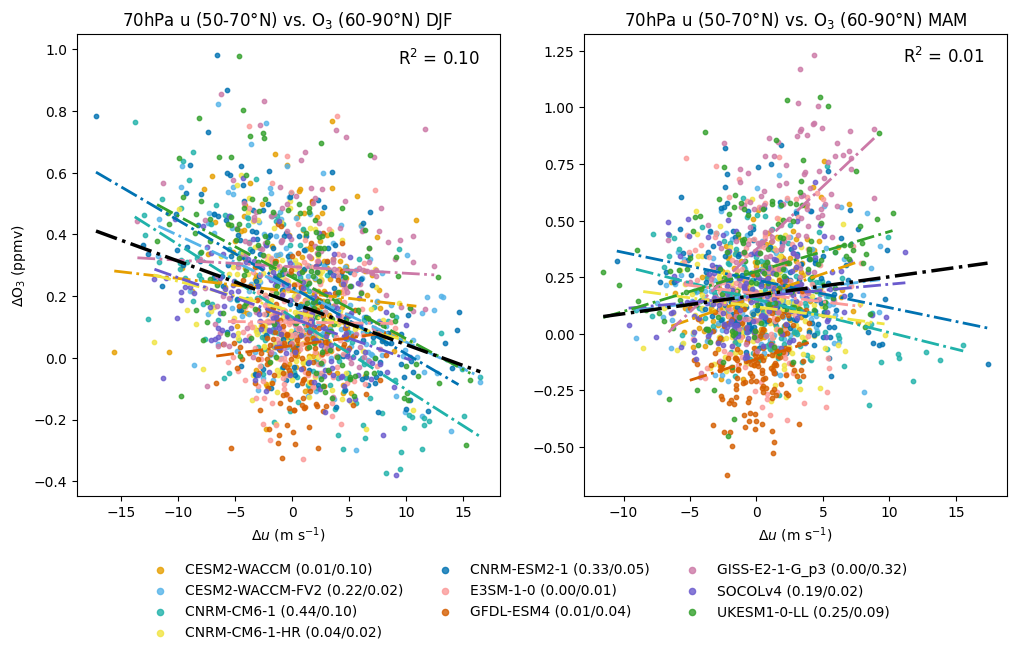

In [79]:
# plot local ozone response (averaged over 60-90N) on the y-axis and 
# the U response at 70 hPa (averaged over 50-70N) on the x-axis for DJF and MAM for NH
# and JJA and SOD for SH

ua_MAM_4CO2 = np.zeros((n_chem_4CO2,150))
ua_DJF_4CO2 = np.zeros((n_chem_4CO2,150))
o3_MAM_4CO2 = np.zeros((n_chem_4CO2,150))
o3_DJF_4CO2 = np.zeros((n_chem_4CO2,150))

ua_MAM_1pct = np.zeros((n_chem_1pct,150))
ua_DJF_1pct = np.zeros((n_chem_1pct,150))
o3_MAM_1pct = np.zeros((n_chem_1pct,150))
o3_DJF_1pct = np.zeros((n_chem_1pct,150))

R2_MAM_1pct = np.zeros(n_model)
R2_DJF_1pct = np.zeros(n_model)

band_o3 = [60,90]
band_ua = [50,70]
plev = 7000 #10hPa

fig10_name_ind = [0,1,2,3,4,5,6,7,10,11]
#colors_col = cm.rainbow(np.linspace(0, 1, n_chem))
colors_col = cmc.vik(np.linspace(0, 1, n_chem))

fig10, ax10 = plt.subplots(1,2,figsize=(12,6)) #,constrained_layout=True)

m_4CO2 = 0
m_1pct = 0

ua_MAM_1pct_all = []
ua_DJF_1pct_all = []
o3_MAM_1pct_all = []
o3_DJF_1pct_all = []

for i,c in zip(np.arange(0,n_model),colors_col):
    if model_name[i] != "MRI-ESM2-0_":
        if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
            # index of lat bands
            ind_band_o3 = np.zeros_like(band_o3)
            ind_band_ua = np.zeros_like(band_ua)
            ind_plev = np.where(abs(press.get(model_name[i])-plev) == min(abs(press.get(model_name[i])-plev)))[0][0]
            for n in range(0,len(band_o3)):
                ind_band_o3[n] = np.where(abs(latitude.get(model_name[i])-band_o3[n]) == min(abs(latitude.get(model_name[i])-band_o3[n])))[0][0]
                ind_band_ua[n] = np.where(abs(latitude.get(model_name[i])-band_ua[n]) == min(abs(latitude.get(model_name[i])-band_ua[n])))[0][0]

            if flag_1pct[i] == 1:
                print(model_name[i])
                if model_name[i] == "GISS-E2-1-G_p3_":
                    n_start = 15
                else:
                    n_start = 0

                # fitting
                ua_MAM_1pct[m_1pct,:] = ma.mean(ua_zm_am_MAM_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_ua[0]:ind_band_ua[1]],axis=1)
                o3_MAM_1pct[m_1pct,n_start:] = ma.mean(o3_zm_am_MAM_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_o3[0]:ind_band_o3[1]],axis=1)
                ua_DJF_1pct[m_1pct,:] = ma.mean(ua_zm_am_DJF_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_ua[0]:ind_band_ua[1]],axis=1)
                o3_DJF_1pct[m_1pct,n_start:] = ma.mean(o3_zm_am_DJF_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_o3[0]:ind_band_o3[1]],axis=1)
                
                ua_MAM_1pct_all = np.append(ua_MAM_1pct_all,ua_MAM_1pct[m_1pct,:])
                o3_MAM_1pct_all = np.append(o3_MAM_1pct_all,o3_MAM_1pct[m_1pct,:])
                ua_DJF_1pct_all = np.append(ua_DJF_1pct_all,ua_DJF_1pct[m_1pct,:])
                o3_DJF_1pct_all = np.append(o3_DJF_1pct_all,o3_DJF_1pct[m_1pct,:])
                ua_MAM_1pct_neg = np.where(ua_MAM_1pct[m_1pct,:]<0)
                ua_DJF_1pct_neg = np.where(ua_DJF_1pct[m_1pct,:]<0)
                
                print("ua negative MAM:", model_name[i], ua_MAM_1pct_neg)
                print("ua negative DJF:", model_name[i], ua_DJF_1pct_neg)

                
                # plot lat-avg stratospheric temp for diff layers in one subplot
                for j in range(0,len(band_o3)-1):
                    ax10[1].scatter(ua_MAM_1pct[m_1pct,n_start:],o3_MAM_1pct[m_1pct,n_start:],label=model_name[i],s = 10, alpha = 0.8,color = colors_m[model_name[i]])
                    ax10[0].scatter(ua_DJF_1pct[m_1pct,n_start:],o3_DJF_1pct[m_1pct,n_start:],label=model_name[i],s = 10, alpha = 0.8,color = colors_m[model_name[i]])

                fit_MAM_1pct = np.polyfit(ua_MAM_1pct[m_1pct,n_start:],o3_MAM_1pct[m_1pct,n_start:],1, full = True)
                fit_DJF_1pct = np.polyfit(ua_DJF_1pct[m_1pct,n_start:],o3_DJF_1pct[m_1pct,n_start:],1, full = True)
                coeff_MAM_1pct = fit_MAM_1pct[0]
                coeff_DJF_1pct = fit_DJF_1pct[0]
                print("1pct",model_name[i],"coeff MAM",coeff_MAM_1pct,"coeff DJF",coeff_DJF_1pct)
                p_MAM_1pct = np.poly1d(np.polyfit(ua_MAM_1pct[m_1pct,n_start:],o3_MAM_1pct[m_1pct,n_start:],1))
                p_DJF_1pct = np.poly1d(np.polyfit(ua_DJF_1pct[m_1pct,n_start:],o3_DJF_1pct[m_1pct,n_start:],1))

                # compute R2
                SSE_MAM_1pct = fit_MAM_1pct[1][0]
                SSE_DJF_1pct = fit_DJF_1pct[1][0]
                SST_MAM_1pct = np.sum((o3_MAM_1pct[m_1pct,n_start:]-np.mean(o3_MAM_1pct[m_1pct,n_start:]))**2)
                SST_DJF_1pct = np.sum((o3_DJF_1pct[m_1pct,n_start:]-np.mean(o3_DJF_1pct[m_1pct,n_start:]))**2)
                R2_MAM_1pct[i] = 1 - SSE_MAM_1pct/SST_MAM_1pct
                R2_DJF_1pct[i] = 1 - SSE_DJF_1pct/SST_DJF_1pct
                print("1pct",model_name[i],"R2 MAM",R2_MAM_1pct,"R2 DJF",R2_DJF_1pct)

                x_MAM_1pct = np.linspace(min(ua_MAM_1pct[m_1pct,n_start:]),max(ua_MAM_1pct[m_1pct,n_start:]),100)
                x_DJF_1pct = np.linspace(min(ua_DJF_1pct[m_1pct,n_start:]),max(ua_DJF_1pct[m_1pct,n_start:]),100)
                ax10[1].plot(x_MAM_1pct,p_MAM_1pct(x_MAM_1pct),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                #ax10[1].text(13, 1.1-m_1pct*0.1, "R$^2$ ="+"{:.3f}".format(R2_MAM_1pct[i]), color = colors_m[model_name[i]], fontsize=12, weight='semibold')
                ax10[0].plot(x_DJF_1pct,p_DJF_1pct(x_DJF_1pct),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                #ax10[0].text(12, 0.87-m_1pct*0.08, "R$^2$ ="+"{:.3f}".format(R2_DJF_1pct[i]), color = colors_m[model_name[i]], fontsize=12, weight='semibold')

                m_1pct=m_1pct+1 


######### linear regression for all model data and compute R2
fit_MAM_1pct_all = np.polyfit(ua_MAM_1pct_all,o3_MAM_1pct_all,1, full = True)
fit_DJF_1pct_all = np.polyfit(ua_DJF_1pct_all,o3_DJF_1pct_all,1, full = True)
coeff_MAM_1pct_all = fit_MAM_1pct_all[0]
coeff_DJF_1pct_all = fit_DJF_1pct_all[0]
print("1pct all model coeff MAM",coeff_MAM_1pct_all,"coeff DJF",coeff_DJF_1pct_all)
p_MAM_1pct_all = np.poly1d(np.polyfit(ua_MAM_1pct_all,o3_MAM_1pct_all,1))
p_DJF_1pct_all = np.poly1d(np.polyfit(ua_DJF_1pct_all,o3_DJF_1pct_all,1))

# compute R2
SSE_MAM_1pct_all = fit_MAM_1pct_all[1][0]
SSE_DJF_1pct_all = fit_DJF_1pct_all[1][0]
SST_MAM_1pct_all = np.sum((o3_MAM_1pct_all-np.mean(o3_MAM_1pct_all))**2)
SST_DJF_1pct_all = np.sum((o3_DJF_1pct_all-np.mean(o3_DJF_1pct_all))**2)
R2_MAM_1pct_all = 1 - SSE_MAM_1pct_all/SST_MAM_1pct_all
R2_DJF_1pct_all = 1 - SSE_DJF_1pct_all/SST_DJF_1pct_all
print("1pct all model R2 MAM",R2_MAM_1pct_all,"R2 DJF",R2_DJF_1pct_all)

x_MAM_1pct_all = np.linspace(min(ua_MAM_1pct_all),max(ua_MAM_1pct_all),100)
x_DJF_1pct_all = np.linspace(min(ua_DJF_1pct_all),max(ua_DJF_1pct_all),100)
ax10[1].plot(x_MAM_1pct_all,p_MAM_1pct_all(x_MAM_1pct_all),color = 'k',linestyle = "-.",linewidth = 2.5, label='_nolegend_')
ax10[0].plot(x_DJF_1pct_all,p_DJF_1pct_all(x_DJF_1pct_all),color = 'k',linestyle = "-.",linewidth = 2.5, label='_nolegend_')
##########

ax10[0].text(9.3,0.95,"R$^2$ = 0.10", fontsize = "large")
ax10[1].text(11,1.2,"R$^2$ = 0.01", fontsize = "large")
ax10[0].set_xlabel(r"$\Delta u$ (m s$^{-1}$)", fontsize = "medium")
ax10[1].set_xlabel(r"$\Delta u$ (m s$^{-1}$)", fontsize = "medium")
ax10[0].set_ylabel(r"$\Delta$O$_3$ (ppmv)", fontsize = "medium")
#ax10[0].set_xlim(-20,22)
#ax10[1].set_xlim(-15,22)

ax10[1].set_title("70hPa u (50-70\u00b0N) vs. O$_3$ (60-90\u00b0N) MAM", fontsize = "large")
ax10[0].set_title("70hPa u (50-70\u00b0N) vs. O$_3$ (60-90\u00b0N) DJF", fontsize = "large")

legend = fig10.legend([model_name[n][:-1]+" ("+"{:.2f}".format(R2_DJF_1pct[n])+"/"+"{:.2f}".format(R2_MAM_1pct[n])+")" for n in fig10_name_ind], bbox_to_anchor=(0.5, -0.15),frameon=False, ncols = 3, loc = 'lower center')
for handle in legend.legendHandles:
    handle.set_sizes([20])
    
fig10.savefig('../Output/paper/delta_ua_vs_delta_o3_70hPa.pdf', bbox_inches = "tight", dpi = 300) 

CESM2-WACCM_
ua mean JJA: CESM2-WACCM_ 0.6715868240437182
ua mean SON: CESM2-WACCM_ 0.921999074946005
1pct CESM2-WACCM_ coeff JJA [0.01763835 0.27509457] coeff SON [-0.01992217  0.26066202]
1pct CESM2-WACCM_ R2 JJA [0.12192953 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ] R2 SON [0.05109338 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
CESM2-WACCM-FV2_
ua mean JJA: CESM2-WACCM-FV2_ 0.2765756751166451
ua mean SON: CESM2-WACCM-FV2_ 1.1667867041693796
1pct CESM2-WACCM-FV2_ coeff JJA [0.01763835 0.27509457] coeff SON [-0.01992217  0.26066202]
1pct CESM2-WACCM-FV2_ R2 JJA [0.12192953 0.02648143 0.         0.         0.         0.
 0.         0.         0.         0. 

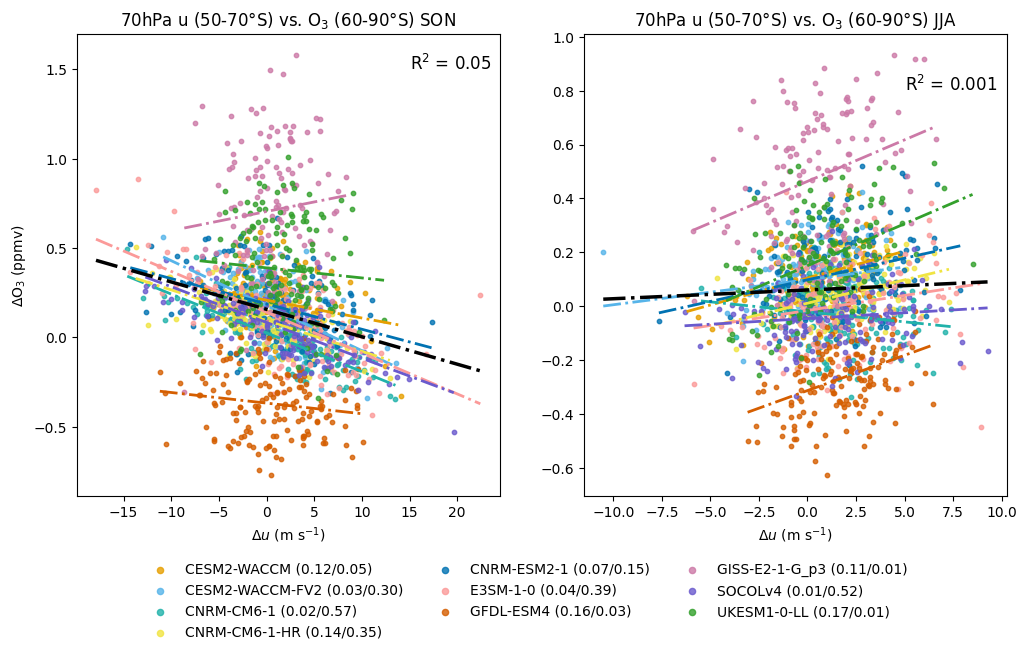

In [80]:
# plot local ozone response (averaged over 60-90S) on the y-axis and 
# the U response at 70 hPa (averaged over 50-7S) on the x-axis for JJA and SON for SH

ua_JJA_4CO2 = np.zeros((n_chem_4CO2,150))
ua_SON_4CO2 = np.zeros((n_chem_4CO2,150))
o3_JJA_4CO2 = np.zeros((n_chem_4CO2,150))
o3_SON_4CO2 = np.zeros((n_chem_4CO2,150))

ua_JJA_1pct = np.zeros((n_chem_1pct,150))
ua_SON_1pct = np.zeros((n_chem_1pct,150))
o3_JJA_1pct = np.zeros((n_chem_1pct,150))
o3_SON_1pct = np.zeros((n_chem_1pct,150))

R2_JJA_1pct = np.zeros(n_model)
R2_SON_1pct = np.zeros(n_model)

band_o3 = [-90,-60]
band_ua = [-70,-50]
plev = 7000 #10hPa

fig10_name_ind = [0,1,2,3,4,5,6,7,10,11]
#colors_col = cm.rainbow(np.linspace(0, 1, n_chem))
colors_col = cmc.vik(np.linspace(0, 1, n_chem))

fig10, ax10 = plt.subplots(1,2,figsize=(12,6)) #,constrained_layout=True)

m_4CO2 = 0
m_1pct = 0

ua_JJA_1pct_all = []
ua_SON_1pct_all = []
o3_JJA_1pct_all = []
o3_SON_1pct_all = []

for i,c in zip(np.arange(0,n_model),colors_col):
    if model_name[i] != "MRI-ESM2-0_":
        if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
            # index of lat bands
            ind_band_o3 = np.zeros_like(band_o3)
            ind_band_ua = np.zeros_like(band_ua)
            ind_plev = np.where(abs(press.get(model_name[i])-plev) == min(abs(press.get(model_name[i])-plev)))[0][0]
            for n in range(0,len(band_o3)):
                ind_band_o3[n] = np.where(abs(latitude.get(model_name[i])-band_o3[n]) == min(abs(latitude.get(model_name[i])-band_o3[n])))[0][0]
                ind_band_ua[n] = np.where(abs(latitude.get(model_name[i])-band_ua[n]) == min(abs(latitude.get(model_name[i])-band_ua[n])))[0][0]

            if flag_1pct[i] == 1:
                print(model_name[i])
                if model_name[i] == "GISS-E2-1-G_p3_":
                    n_start = 15
                else:
                    n_start = 0

                # fitting
                ua_JJA_1pct[m_1pct,:] = ma.mean(ua_zm_am_JJA_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_ua[0]:ind_band_ua[1]],axis=1)
                o3_JJA_1pct[m_1pct,n_start:] = ma.mean(o3_zm_am_JJA_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_o3[0]:ind_band_o3[1]],axis=1)
                ua_SON_1pct[m_1pct,:] = ma.mean(ua_zm_am_SON_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_ua[0]:ind_band_ua[1]],axis=1)
                o3_SON_1pct[m_1pct,n_start:] = ma.mean(o3_zm_am_SON_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_o3[0]:ind_band_o3[1]],axis=1)
                
                ua_JJA_1pct_all = np.append(ua_JJA_1pct_all,ua_JJA_1pct[m_1pct,:])
                o3_JJA_1pct_all = np.append(o3_JJA_1pct_all,o3_JJA_1pct[m_1pct,:])
                ua_SON_1pct_all = np.append(ua_SON_1pct_all,ua_SON_1pct[m_1pct,:])
                o3_SON_1pct_all = np.append(o3_SON_1pct_all,o3_SON_1pct[m_1pct,:])

                ua_JJA_1pct_mean = np.mean(ua_JJA_1pct[m_1pct,:])
                ua_SON_1pct_mean = np.mean(ua_SON_1pct[m_1pct,:])

                print("ua mean JJA:", model_name[i], ua_JJA_1pct_mean)
                print("ua mean SON:", model_name[i], ua_SON_1pct_mean)
                
                # plot lat-avg stratospheric temp for diff layers in one subplot
                for j in range(0,len(band_o3)-1):
                    ax10[1].scatter(ua_JJA_1pct[m_1pct,n_start:],o3_JJA_1pct[m_1pct,n_start:],label=model_name[i],s = 10, alpha = 0.8,color = colors_m[model_name[i]])
                    ax10[0].scatter(ua_SON_1pct[m_1pct,n_start:],o3_SON_1pct[m_1pct,n_start:],label=model_name[i],s = 10, alpha = 0.8,color = colors_m[model_name[i]])

                fit_JJA_1pct = np.polyfit(ua_JJA_1pct[m_1pct,n_start:],o3_JJA_1pct[m_1pct,n_start:],1, full = True)
                fit_SON_1pct = np.polyfit(ua_SON_1pct[m_1pct,n_start:],o3_SON_1pct[m_1pct,n_start:],1, full = True)
                coeff_JJA_1pct = fit_MAM_1pct[0]
                coeff_SON_1pct = fit_DJF_1pct[0]
                print("1pct",model_name[i],"coeff JJA",coeff_JJA_1pct,"coeff SON",coeff_SON_1pct)
                p_JJA_1pct = np.poly1d(np.polyfit(ua_JJA_1pct[m_1pct,n_start:],o3_JJA_1pct[m_1pct,n_start:],1))
                p_SON_1pct = np.poly1d(np.polyfit(ua_SON_1pct[m_1pct,n_start:],o3_SON_1pct[m_1pct,n_start:],1))

                # compute R2
                SSE_JJA_1pct = fit_JJA_1pct[1][0]
                SSE_SON_1pct = fit_SON_1pct[1][0]
                SST_JJA_1pct = np.sum((o3_JJA_1pct[m_1pct,n_start:]-np.mean(o3_JJA_1pct[m_1pct,n_start:]))**2)
                SST_SON_1pct = np.sum((o3_SON_1pct[m_1pct,n_start:]-np.mean(o3_SON_1pct[m_1pct,n_start:]))**2)
                R2_JJA_1pct[i] = 1 - SSE_JJA_1pct/SST_JJA_1pct
                R2_SON_1pct[i] = 1 - SSE_SON_1pct/SST_SON_1pct
                print("1pct",model_name[i],"R2 JJA",R2_JJA_1pct,"R2 SON",R2_SON_1pct)

                x_JJA_1pct = np.linspace(min(ua_JJA_1pct[m_1pct,n_start:]),max(ua_JJA_1pct[m_1pct,n_start:]),100)
                x_SON_1pct = np.linspace(min(ua_SON_1pct[m_1pct,n_start:]),max(ua_SON_1pct[m_1pct,n_start:]),100)
                ax10[1].plot(x_JJA_1pct,p_JJA_1pct(x_JJA_1pct),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                #ax10[1].text(13, 1.1-m_1pct*0.1, "R$^2$ ="+"{:.3f}".format(R2_MAM_1pct[i]), color = colors_m[model_name[i]], fontsize=12, weight='semibold')
                ax10[0].plot(x_SON_1pct,p_SON_1pct(x_SON_1pct),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                #ax10[0].text(12, 0.87-m_1pct*0.08, "R$^2$ ="+"{:.3f}".format(R2_DJF_1pct[i]), color = colors_m[model_name[i]], fontsize=12, weight='semibold')

                m_1pct=m_1pct+1 


######### linear regression for all model data and compute R2
fit_JJA_1pct_all = np.polyfit(ua_JJA_1pct_all,o3_JJA_1pct_all,1, full = True)
fit_SON_1pct_all = np.polyfit(ua_SON_1pct_all,o3_SON_1pct_all,1, full = True)
coeff_JJA_1pct_all = fit_MAM_1pct_all[0]
coeff_SON_1pct_all = fit_DJF_1pct_all[0]
print("1pct all model coeff JJA",coeff_JJA_1pct_all,"coeff SON",coeff_SON_1pct_all)
p_JJA_1pct_all = np.poly1d(np.polyfit(ua_JJA_1pct_all,o3_JJA_1pct_all,1))
p_SON_1pct_all = np.poly1d(np.polyfit(ua_SON_1pct_all,o3_SON_1pct_all,1))

# compute R2
SSE_JJA_1pct_all = fit_JJA_1pct_all[1][0]
SSE_SON_1pct_all = fit_SON_1pct_all[1][0]
SST_JJA_1pct_all = np.sum((o3_JJA_1pct_all-np.mean(o3_JJA_1pct_all))**2)
SST_SON_1pct_all = np.sum((o3_SON_1pct_all-np.mean(o3_SON_1pct_all))**2)
R2_JJA_1pct_all = 1 - SSE_JJA_1pct_all/SST_JJA_1pct_all
R2_SON_1pct_all = 1 - SSE_SON_1pct_all/SST_SON_1pct_all
print("1pct all model R2 JJA",R2_JJA_1pct_all,"R2 SON",R2_SON_1pct_all)

x_JJA_1pct_all = np.linspace(min(ua_JJA_1pct_all),max(ua_JJA_1pct_all),100)
x_SON_1pct_all = np.linspace(min(ua_SON_1pct_all),max(ua_SON_1pct_all),100)
ax10[1].plot(x_JJA_1pct_all,p_JJA_1pct_all(x_JJA_1pct_all),color = 'k',linestyle = "-.",linewidth = 2.5, label='_nolegend_')
ax10[0].plot(x_SON_1pct_all,p_SON_1pct_all(x_SON_1pct_all),color = 'k',linestyle = "-.",linewidth = 2.5, label='_nolegend_')
##########

ax10[0].text(15,1.5,"R$^2$ = 0.05", fontsize = "large")
ax10[1].text(5,0.8,"R$^2$ = 0.001", fontsize = "large")
ax10[0].set_xlabel(r"$\Delta u$ (m s$^{-1}$)", fontsize = "medium")
ax10[1].set_xlabel(r"$\Delta u$ (m s$^{-1}$)", fontsize = "medium")
ax10[0].set_ylabel(r"$\Delta$O$_3$ (ppmv)", fontsize = "medium")
#ax10[0].set_xlim(-20,22)
#ax10[1].set_xlim(-15,22)

ax10[1].set_title("70hPa u (50-70\u00b0S) vs. O$_3$ (60-90\u00b0S) JJA", fontsize = "large")
ax10[0].set_title("70hPa u (50-70\u00b0S) vs. O$_3$ (60-90\u00b0S) SON", fontsize = "large")

legend = fig10.legend([model_name[n][:-1]+" ("+"{:.2f}".format(R2_JJA_1pct[n])+"/"+"{:.2f}".format(R2_SON_1pct[n])+")" for n in fig10_name_ind], bbox_to_anchor=(0.5, -0.15),frameon=False, ncols = 3, loc = 'lower center')
for handle in legend.legendHandles:
    handle.set_sizes([20])
    
fig10.savefig('../Output/paper/delta_ua_vs_delta_o3_70hPa_SH.pdf', bbox_inches = "tight", dpi = 300) 

# The following cells compute and plot tas_glbm vs. w; am_zm w vs. o3.

In [81]:
# read in am_zm wap, then convert wap to w (mm/s)
wap_zm_am_piControl_masked = dict()
wap_zm_am_4CO2_masked = dict()
wap_zm_am_1pct_masked = dict()

w_zm_am_piControl = dict()
w_zm_am_4CO2 = dict()
w_zm_am_1pct = dict()

w_zm_am_diff_4CO2 = dict()
w_zm_am_diff_1pct = dict()

pressure_CMIP6 = dict() # original plev for all models

species = "wap"
H = 8000 # scale height in meter
path_zm_am_wap = "../data/wap/zm_am/"

for i in range(0,len(model_name)):
    for f in os.listdir(path_zm_am_wap):
        if os.path.isfile(os.path.join(path_zm_am_wap,f)) and (model_name[i] in f):
            if model_name[i] != "SOCOLv4_":
                if experiment[0] in f:
                    print(model_name[i])
                    zm_am_wap_piControl = nc.Dataset(os.path.join(path_zm_am_wap,f))
                    if (model_name[i] != "SOCOL-MPIOM_"):
                        wap_zm_am_piControl = zm_am_wap_piControl.variables[species][:,:,:,0]
                        wap_zm_am_piControl_masked[model_name[i]] = ma.masked_values (wap_zm_am_piControl, 1e20)
                    else:
                        wap_zm_am_piControl = zm_am_wap_piControl.variables[species][:,:,:]
                        wap_zm_am_piControl_masked[model_name[i]] = ma.masked_values (wap_zm_am_piControl, 1e20)
                    pressure_CMIP6[model_name[i]] = zm_am_wap_piControl.variables['plev'][:]
                    pressure_wap = np.ones_like(wap_zm_am_piControl_masked.get(model_name[i]))
                    for n in range(0,np.shape(pressure_wap)[0]):
                        for m in range(0,np.shape(pressure_wap)[2]):                       
                            pressure_wap[n,:,m] = pressure_CMIP6.get(model_name[i]) * pressure_wap[n,:,m]
                    # convert wap to w
                    w_zm_am_piControl[model_name[i]] = \
                    -1 * H/pressure_wap * wap_zm_am_piControl_masked.get(model_name[i]) * 1000
                    print("pi",model_name[i],np.shape(w_zm_am_piControl.get(model_name[i])))
                
                elif experiment[1] in f and ("last100yr" not in f):
                    zm_am_wap_4CO2 = nc.Dataset(os.path.join(path_zm_am_wap,f))
                    if (model_name[i] != "SOCOL-MPIOM_"):
                        wap_zm_am_4CO2 = zm_am_wap_4CO2.variables[species][:,:,:,0]
                        wap_zm_am_4CO2_masked[model_name[i]] = ma.masked_values (wap_zm_am_4CO2, 1e20)
                    else:
                        wap_zm_am_4CO2 = zm_am_wap_4CO2.variables[species][:,:,:]
                        wap_zm_am_4CO2_masked[model_name[i]] = ma.masked_values (wap_zm_am_4CO2, 1e20)
                    pressure_CMIP6[model_name[i]] = zm_am_wap_4CO2.variables['plev'][:] 
                    pressure_wap = np.ones_like(wap_zm_am_4CO2_masked.get(model_name[i]))
                    for n in range(0,np.shape(pressure_wap)[0]):
                        for m in range(0,np.shape(pressure_wap)[2]):                       
                            pressure_wap[n,:,m] = pressure_CMIP6.get(model_name[i]) * pressure_wap[n,:,m]

                    w_zm_am_4CO2[model_name[i]] = \
                    -1 * H/pressure_wap * wap_zm_am_4CO2_masked.get(model_name[i]) * 1000
                    print("4CO2",model_name[i],np.shape(w_zm_am_4CO2.get(model_name[i])))
                
                elif experiment[2] in f and ("all" in f):
                    zm_am_wap_1pct = nc.Dataset(os.path.join(path_zm_am_wap,f))
                    wap_zm_am_1pct = zm_am_wap_1pct.variables[species][:,:,:,0]
                    pressure_CMIP6[model_name[i]] = zm_am_wap_1pct.variables['plev'][:]
                    wap_zm_am_1pct_masked[model_name[i]] = ma.masked_values (wap_zm_am_1pct, 1e20)
                    wap_zm_am_1pct_masked[model_name[i]] = ma.masked_values (wap_zm_am_1pct, 1e20)
                    pressure_wap = np.ones_like(wap_zm_am_1pct_masked.get(model_name[i]))
                    for n in range(0,np.shape(pressure_wap)[0]):
                        for m in range(0,np.shape(pressure_wap)[2]):                       
                            pressure_wap[n,:,m] = pressure_CMIP6.get(model_name[i]) * pressure_wap[n,:,m]

                    w_zm_am_1pct[model_name[i]] = \
                    -1 * H/pressure_wap * wap_zm_am_1pct_masked.get(model_name[i]) * 1000
                    print("1pct",model_name[i],np.shape(w_zm_am_1pct.get(model_name[i])))
                    
            else: # SOCOLv4, already in m/s, convert to mm/s
                if experiment[0] in f:
                    zm_am_w_piControl = nc.Dataset(os.path.join(path_zm_am_wap,f))
                    w_zm_am_piControl[model_name[i]] = zm_am_w_piControl.variables[species][:,:,:,0]*1000
                    pressure_CMIP6[model_name[i]] = zm_am_w_piControl.variables['plev'][:]
                    print("pi",model_name[i],np.shape(w_zm_am_piControl.get(model_name[i])))
                if experiment[1] in f and "last100yr" in f:
                    zm_am_w_4CO2 = nc.Dataset(os.path.join(path_zm_am_wap,f))
                    w_zm_am_4CO2[model_name[i]] = zm_am_w_4CO2.variables[species][:,:,:,0]*1000
                    print("4CO2",model_name[i],np.shape(w_zm_am_4CO2.get(model_name[i])))
                if experiment[2] in f and "all" in f:
                    zm_am_w_1pct = nc.Dataset(os.path.join(path_zm_am_wap,f))
                    w_zm_am_1pct[model_name[i]] = zm_am_w_1pct.variables[species][:,:,:,0]*1000
                    print("1pct",model_name[i],np.shape(w_zm_am_1pct.get(model_name[i])))

1pct CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM_ (150, 19, 192)
CESM2-WACCM_
pi CESM2-WACCM_ (150, 19, 192)
1pct CESM2-WACCM-FV2_ (150, 19, 96)
4CO2 CESM2-WACCM-FV2_ (150, 19, 96)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (150, 19, 96)
1pct CNRM-CM6-1_ (150, 19, 128)
4CO2 CNRM-CM6-1_ (150, 19, 128)
CNRM-CM6-1_
pi CNRM-CM6-1_ (150, 19, 128)
1pct CNRM-CM6-1-HR_ (150, 19, 360)
4CO2 CNRM-CM6-1-HR_ (150, 19, 360)
CNRM-CM6-1-HR_
pi CNRM-CM6-1-HR_ (150, 19, 360)
1pct CNRM-ESM2-1_ (150, 19, 128)
4CO2 CNRM-ESM2-1_ (150, 19, 128)
CNRM-ESM2-1_
pi CNRM-ESM2-1_ (150, 19, 128)
1pct E3SM-1-0_ (150, 19, 180)
4CO2 E3SM-1-0_ (150, 19, 180)
E3SM-1-0_
pi E3SM-1-0_ (150, 19, 180)
1pct GFDL-ESM4_ (150, 19, 180)
4CO2 GFDL-ESM4_ (150, 19, 180)
GFDL-ESM4_
pi GFDL-ESM4_ (150, 19, 180)
1pct GISS-E2-1-G_p3_ (150, 19, 90)
4CO2 GISS-E2-1-G_p3_ (150, 19, 90)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (150, 19, 90)
1pct MRI-ESM2-0_ (150, 19, 160)
4CO2 MRI-ESM2-0_ (150, 19, 160)
MRI-ESM2-0_
pi MRI-ESM2-0_ (150, 19, 160)
4CO2 SOC

In [82]:
# compute difference of zm_am w compared to piControl

for i in range(0,len(model_name)):
    if flag_chem[i] == 1 or flag_chem[i] == 0:
        if (model_name[i] in w_zm_am_piControl.keys()):
            if flag_4CO2[i] == 1:
                print(model_name[i])
                if model_name[i] == "SOCOLv4_":
                    n_start = 1 # lenght of w for pi and 4co2 different
                else:
                    n_start = 0

                if model_name[i] == "AWI-ESM-1-1-LR":
                    w_zm_am_diff_4CO2[model_name[i]] = \
                    w_zm_am_4CO2.get(model_name[i]) - np.mean(w_zm_am_piControl.get(model_name[i])[n_start,:,:])
                else:    
                    w_zm_am_diff_4CO2[model_name[i]] = \
                    w_zm_am_4CO2.get(model_name[i]) - w_zm_am_piControl.get(model_name[i])[n_start,:,:]
                print("4CO2",model_name[i],ma.mean(w_zm_am_diff_4CO2.get(model_name[i])))
            
            if flag_1pct[i] == 1:
                print(model_name[i])

                if model_name[i] == "AWI-ESM-1-1-LR":
                    w_zm_am_diff_1pct[model_name[i]] = \
                    w_zm_am_1pct.get(model_name[i]) - np.mean(w_zm_am_piControl.get(model_name[i]))
                else:
                    w_zm_am_diff_1pct[model_name[i]] = \
                    w_zm_am_1pct.get(model_name[i]) - w_zm_am_piControl.get(model_name[i])
                print("1pct",model_name[i],np.mean(w_zm_am_diff_1pct.get(model_name[i])))
    

CESM2-WACCM_
4CO2 CESM2-WACCM_ -0.022169213295768677
CESM2-WACCM_
1pct CESM2-WACCM_ -0.005906666831058829
CESM2-WACCM-FV2_
4CO2 CESM2-WACCM-FV2_ -0.051624521602677956
CESM2-WACCM-FV2_
1pct CESM2-WACCM-FV2_ -0.01259068623306115
CNRM-CM6-1_
4CO2 CNRM-CM6-1_ 0.025572383096141835
CNRM-CM6-1_
1pct CNRM-CM6-1_ 0.014936897467601254
CNRM-CM6-1-HR_
4CO2 CNRM-CM6-1-HR_ -0.00024461486025292704
CNRM-CM6-1-HR_
1pct CNRM-CM6-1-HR_ 0.02224179773477623
CNRM-ESM2-1_
4CO2 CNRM-ESM2-1_ 0.004670509689094137
CNRM-ESM2-1_
1pct CNRM-ESM2-1_ 0.008767507343907781
E3SM-1-0_
4CO2 E3SM-1-0_ 0.038336542446682
E3SM-1-0_
1pct E3SM-1-0_ 0.013905851932875498
GFDL-ESM4_
4CO2 GFDL-ESM4_ 0.012364708518123825
GFDL-ESM4_
1pct GFDL-ESM4_ 0.006452250027002471
GISS-E2-1-G_p3_
4CO2 GISS-E2-1-G_p3_ -0.050938308204428656
GISS-E2-1-G_p3_
1pct GISS-E2-1-G_p3_ -0.024132201073254575
MRI-ESM2-0_
4CO2 MRI-ESM2-0_ -0.042870091460123674
MRI-ESM2-0_
1pct MRI-ESM2-0_ -0.0060606684380113554
SOCOL-MPIOM_
4CO2 SOCOL-MPIOM_ -0.062843967013888

In [83]:
# read in annual-mean global mean tas data

tas_glbm_piControl_masked = dict()
tas_glbm_4CO2_masked = dict()
tas_glbm_1pct_masked = dict()
tas_glbm_1pct_all_masked = dict()

species = "tas"
path_glbm_tas = "../data/T_surf/am_global_mean/"

for i in range(0,len(model_name_tas)): 
    for f in os.listdir(path_glbm_tas):
        if os.path.isfile(os.path.join(path_glbm_tas,f)) and (model_name_tas[i] in f):
            if experiment[0] in f:
                glbm_tas_piControl = nc.Dataset(os.path.join(path_glbm_tas,f))
                tas_glbm_piControl = glbm_tas_piControl.variables[species][:,0,0]
                tas_glbm_piControl_masked[model_name_tas[i]] = ma.masked_values (tas_glbm_piControl, 1e20)
                print("pi",model_name_tas[i],np.shape(tas_glbm_piControl_masked.get(model_name_tas[i])))
            
            elif experiment[1] in f and ("last100yr" not in f):
                glbm_tas_4CO2 = nc.Dataset(os.path.join(path_glbm_tas,f))
                tas_glbm_4CO2 = glbm_tas_4CO2.variables[species][:,0,0]
                tas_glbm_4CO2_masked[model_name_tas[i]] = ma.masked_values (tas_glbm_4CO2, 1e20)
                print("4CO2",model_name_tas[i],np.shape(tas_glbm_4CO2_masked.get(model_name_tas[i])))
            
            elif experiment[2] in f:
                if "135-145" in f:
                    glbm_tas_1pct = nc.Dataset(os.path.join(path_glbm_tas,f))
                    tas_glbm_1pct = glbm_tas_1pct.variables[species][:,0,0]
                    tas_glbm_1pct_masked[model_name_tas[i]] = ma.masked_values (tas_glbm_1pct, 1e20)
                    print("1pct",model_name_tas[i],np.shape(tas_glbm_1pct_masked.get(model_name_tas[i])))
                if "all" in f:
                    glbm_tas_1pct_all = nc.Dataset(os.path.join(path_glbm_tas,f))
                    tas_glbm_1pct_all = glbm_tas_1pct_all.variables[species][:,0,0]
                    tas_glbm_1pct_all_masked[model_name_tas[i]] = ma.masked_values (tas_glbm_1pct_all, 1e20)
                    print("1pct all",model_name_tas[i],np.shape(tas_glbm_1pct_all_masked.get(model_name_tas[i])))

1pct all CESM2-WACCM_ (150,)
1pct CESM2-WACCM_ (11,)
4CO2 CESM2-WACCM_ (150,)
pi CESM2-WACCM_ (150,)
1pct all CESM2-WACCM-FV2_ (150,)
1pct CESM2-WACCM-FV2_ (11,)
4CO2 CESM2-WACCM-FV2_ (150,)
pi CESM2-WACCM-FV2_ (150,)
1pct all CNRM-CM6-1_ (150,)
1pct CNRM-CM6-1_ (11,)
4CO2 CNRM-CM6-1_ (150,)
pi CNRM-CM6-1_ (150,)
1pct all CNRM-CM6-1-HR_ (150,)
1pct CNRM-CM6-1-HR_ (11,)
pi CNRM-CM6-1-HR_ (150,)
4CO2 CNRM-CM6-1-HR_ (150,)
1pct all CNRM-ESM2-1_ (150,)
1pct CNRM-ESM2-1_ (11,)
4CO2 CNRM-ESM2-1_ (150,)
pi CNRM-ESM2-1_ (150,)
pi E3SM-1-0_ (150,)
1pct all E3SM-1-0_ (150,)
1pct E3SM-1-0_ (11,)
4CO2 E3SM-1-0_ (150,)
1pct GFDL-ESM4_ (11,)
1pct all GFDL-ESM4_ (150,)
4CO2 GFDL-ESM4_ (150,)
pi GFDL-ESM4_ (150,)
1pct GISS-E2-1-G_p3_ (11,)
1pct all GISS-E2-1-G_p3_ (150,)
4CO2 GISS-E2-1-G_p3_ (150,)
pi GISS-E2-1-G_p3_ (150,)
4CO2 GISS-E2-2-G_p3_ (150,)
pi GISS-E2-2-G_p3_ (150,)
1pct all MRI-ESM2-0_ (150,)
1pct MRI-ESM2-0_ (11,)
4CO2 MRI-ESM2-0_ (150,)
pi MRI-ESM2-0_ (150,)
4CO2 SOCOL-MPIOM_ (150,)
pi S

In [84]:
# compute diff of 1pct gloabl mean tas and am_zm_TCO with pi
tas_glbm_diff_4CO2 = dict()
tas_glbm_diff_1pct = dict()
tas_glbm_diff_1pct_all = dict()

for i in range(0,n_model):
    if flag_chem[i] == 1:
        if flag_4CO2[i] == 1:
            print(model_name[i])
            tas_glbm_diff_4CO2[model_name[i]] = \
            (tas_glbm_4CO2_masked.get(model_name[i]) - tas_glbm_piControl_masked.get(model_name[i]))
            print(model_name[i],np.mean(tas_glbm_diff_4CO2.get(model_name[i])))
        
        if flag_1pct[i] == 1:
            print(model_name[i])
            tas_glbm_diff_1pct[model_name[i]] = \
            tas_glbm_1pct_masked.get(model_name[i]) - tas_glbm_piControl_masked.get(model_name[i])[134:145]
            print(model_name[i],np.shape(tas_glbm_diff_1pct.get(model_name[i])))
            tas_glbm_diff_1pct_all[model_name[i]] = \
            tas_glbm_1pct_all_masked.get(model_name[i]) - tas_glbm_piControl_masked.get(model_name[i])
            print(model_name[i],np.shape(tas_glbm_diff_1pct_all.get(model_name[i])))

CESM2-WACCM_
CESM2-WACCM_ 5.505809
CESM2-WACCM_
CESM2-WACCM_ (11,)
CESM2-WACCM_ (150,)
CESM2-WACCM-FV2_
CESM2-WACCM-FV2_ 5.1525593
CESM2-WACCM-FV2_
CESM2-WACCM-FV2_ (11,)
CESM2-WACCM-FV2_ (150,)
CNRM-CM6-1_
CNRM-CM6-1_ 5.9932585
CNRM-CM6-1_
CNRM-CM6-1_ (11,)
CNRM-CM6-1_ (150,)
CNRM-CM6-1-HR_
CNRM-CM6-1-HR_ 5.8027606
CNRM-CM6-1-HR_
CNRM-CM6-1-HR_ (11,)
CNRM-CM6-1-HR_ (150,)
CNRM-ESM2-1_
CNRM-ESM2-1_ 5.4581203
CNRM-ESM2-1_
CNRM-ESM2-1_ (11,)
CNRM-ESM2-1_ (150,)
E3SM-1-0_
E3SM-1-0_ 7.3326564
E3SM-1-0_
E3SM-1-0_ (11,)
E3SM-1-0_ (150,)
GFDL-ESM4_
GFDL-ESM4_ 3.8985922
GFDL-ESM4_
GFDL-ESM4_ (11,)
GFDL-ESM4_ (150,)
GISS-E2-1-G_p3_
GISS-E2-1-G_p3_ 3.6278377
GISS-E2-1-G_p3_
GISS-E2-1-G_p3_ (11,)
GISS-E2-1-G_p3_ (150,)
MRI-ESM2-0_
MRI-ESM2-0_ 4.1250057
MRI-ESM2-0_
MRI-ESM2-0_ (11,)
MRI-ESM2-0_ (150,)
SOCOL-MPIOM_
SOCOL-MPIOM_ 5.1678786
SOCOLv4_
SOCOLv4_ 4.2007904
SOCOLv4_
SOCOLv4_ (11,)
SOCOLv4_ (150,)
UKESM1-0-LL_
UKESM1-0-LL_ 6.620049
UKESM1-0-LL_
UKESM1-0-LL_ (11,)
UKESM1-0-LL_ (150,)


CESM2-WACCM_
CESM2-WACCM_
CESM2-WACCM_ coefficients w vs tas 4CO2: [ 0.0502139  -0.12034665]
CESM2-WACCM_ R2 w vs tas 4CO2: 0.7253982972910169
CESM2-WACCM_
CESM2-WACCM_ coefficients w vs tas 1pct: [ 0.02737693 -0.00365132]
CESM2-WACCM_ R2 w vs tas 1pct: 0.725603604214899
CESM2-WACCM-FV2_
CESM2-WACCM-FV2_
CESM2-WACCM-FV2_ coefficients w vs tas 4CO2: [ 0.04416239 -0.16501784]
CESM2-WACCM-FV2_ R2 w vs tas 4CO2: 0.22965910126884836
CESM2-WACCM-FV2_
CESM2-WACCM-FV2_ coefficients w vs tas 1pct: [ 0.01680931 -0.01413908]
CESM2-WACCM-FV2_ R2 w vs tas 1pct: 0.39401944442430437
CNRM-CM6-1_
CNRM-CM6-1_
CNRM-CM6-1_ coefficients w vs tas 4CO2: [ 0.0267177  -0.05470286]
CNRM-CM6-1_ R2 w vs tas 4CO2: 0.6969283652041016
CNRM-CM6-1_
CNRM-CM6-1_ coefficients w vs tas 1pct: [ 0.02038187 -0.01145415]
CNRM-CM6-1_ R2 w vs tas 1pct: 0.8441856065807845
CNRM-CM6-1-HR_
CNRM-CM6-1-HR_
CNRM-CM6-1-HR_ coefficients w vs tas 4CO2: [ 0.03327875 -0.06483458]
CNRM-CM6-1-HR_ R2 w vs tas 4CO2: 0.7661771458862517
CNRM-CM6

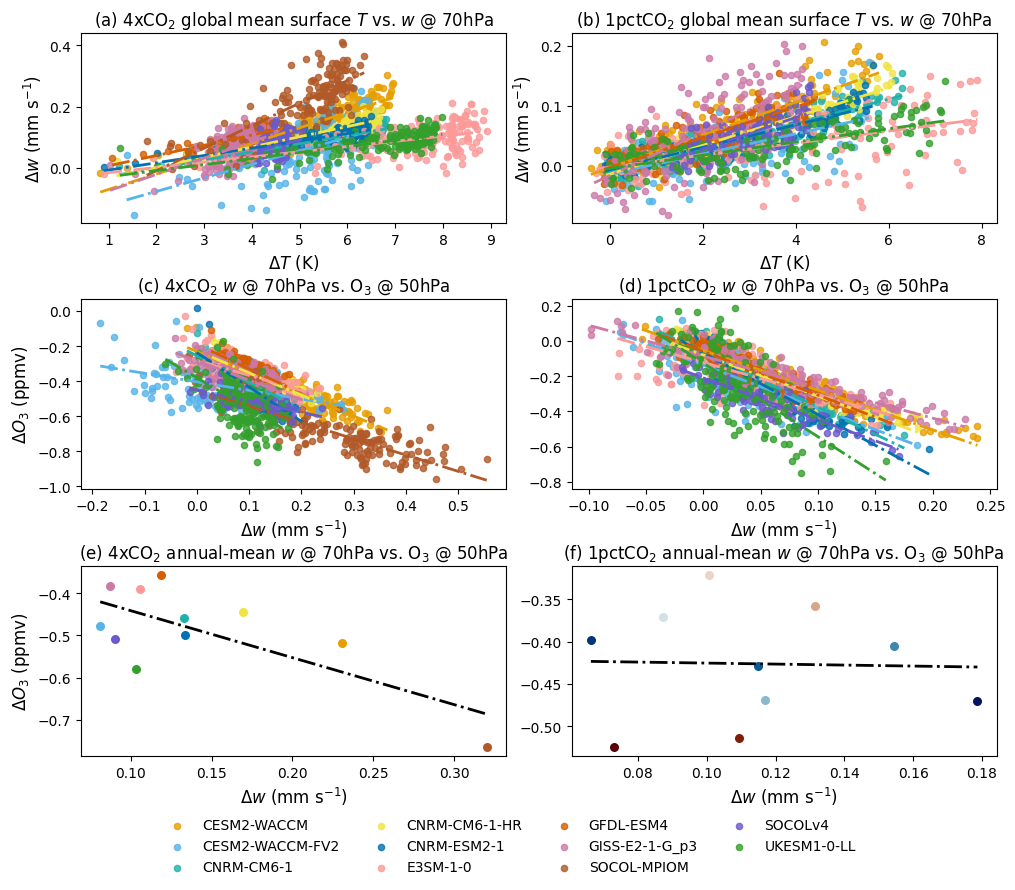

In [85]:
# plot tas_glbm vs. w & w vs. ozone
# first row: time series of average 20S-20N w at 70hPa  vs. tas_glbm
# second row: 150yr annual-mean w vs. ozone
# third row: time-mean of second row

m_4CO2 = 0
m_1pct = 0

w_4CO2 = dict ()
w_1pct = dict ()
tas_4CO2 = dict()
tas_1pct = dict()

band_w = [-15,15]
plev = [7000] # 70hPa
fig10_name_ind = [0,1,2,3,4,5,6,7,9,10,11]

colors_col = cmc.vik(np.linspace(0, 1, n_chem))
#colors_col = cm.rainbow(np.linspace(0, 1, n_chem))

fig10, ax10 = plt.subplots(3,2,figsize=(10,8),constrained_layout=True)

for i,c in zip(np.arange(0,n_model),colors_col):
    if model_name[i] != "MRI-ESM2-0_": # outlier
        if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
            if (model_name[i] in w_zm_am_piControl.keys()):
                print(model_name[i])

                ind_band_w = np.zeros_like(band_w)
                ind_plev = np.where(abs(pressure_CMIP6.get(model_name[i])-plev) == \
                                    min(abs(pressure_CMIP6.get(model_name[i])-plev)))[0][0]
                for n in range(0,len(band_w)):
                    ind_band_w[n] = np.where(abs(latitude.get(model_name[i])-band_w[n]) == min(abs(latitude.get(model_name[i])-band_w[n])))[0][0]

                if flag_4CO2[i] == 1:
                    print(model_name[i])
                    
                    if model_name[i] == "SOCOLv4_":
                        n_start_tas = 61
                    else:
                        n_start_tas = 0
                        
                    w_4CO2[model_name[i]] = ma.mean(w_zm_am_diff_4CO2.get(model_name[i])[:,ind_plev,ind_band_w[0]:ind_band_w[1]],axis=1)
                    tas_4CO2[model_name[i]] = tas_glbm_diff_4CO2.get(model_name[i])[n_start_tas:]
                    ax10[0,0].scatter(tas_4CO2.get(model_name[i]),w_4CO2.get(model_name[i]),label=model_name[i],s = 20, alpha = 0.8,color = colors_m[model_name[i]])

                    # fitting w vs tas
                    fit_w_tas_4CO2 = np.polyfit(tas_4CO2.get(model_name[i]),w_4CO2.get(model_name[i]),1, full = True)
                    coeff_w_tas_4CO2 = fit_w_tas_4CO2[0]
                    print(model_name[i],"coefficients w vs tas 4CO2:",coeff_w_tas_4CO2)
                    p_w_tas_4CO2 = np.poly1d(np.polyfit(tas_4CO2.get(model_name[i]),w_4CO2.get(model_name[i]),1))

                    # compute R2
                    R2_w_tas_4CO2 = compute_R2(fit_w_tas_4CO2,w_4CO2.get(model_name[i]))
                    print(model_name[i],"R2 w vs tas 4CO2:",R2_w_tas_4CO2)

                    x_w_tas_4CO2 = np.linspace(min(tas_4CO2.get(model_name[i])),max(tas_4CO2.get(model_name[i])),100)
                    ax10[0,0].plot(x_w_tas_4CO2,p_w_tas_4CO2(x_w_tas_4CO2),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                    m_4CO2 = m_4CO2 + 1

                if flag_1pct[i] == 1:
                    print(model_name[i])
                    if model_name[i] == "SOCOLv4_":
                        n_start_tas = 60
                    else:
                        n_start_tas = 0
                        
                    w_1pct[model_name[i]] = ma.mean(w_zm_am_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_w[0]:ind_band_w[1]],axis=1)
                    tas_1pct[model_name[i]] = tas_glbm_diff_1pct_all.get(model_name[i])[n_start_tas:]
            
                    ax10[0,1].scatter(tas_1pct.get(model_name[i]),w_1pct.get(model_name[i]),label=model_name[i],s = 20, alpha = 0.8,color = colors_m[model_name[i]])

                    # fitting w vs tas
                    fit_w_tas_1pct = np.polyfit(tas_1pct.get(model_name[i]),w_1pct.get(model_name[i]),1, full = True)
                    coeff_w_tas_1pct = fit_w_tas_1pct[0]
                    print(model_name[i],"coefficients w vs tas 1pct:",coeff_w_tas_1pct)
                    p_w_tas_1pct = np.poly1d(np.polyfit(tas_1pct.get(model_name[i]),w_1pct.get(model_name[i]),1))

                    # compute R2
                    R2_w_tas_1pct = compute_R2(fit_w_tas_1pct,w_1pct.get(model_name[i]))
                    print(model_name[i],"R2 w vs tas 1pct:",R2_w_tas_1pct)

                    x_w_tas_1pct = np.linspace(min(tas_1pct.get(model_name[i])),max(tas_1pct.get(model_name[i])),100)
                    ax10[0,1].plot(x_w_tas_1pct,p_w_tas_1pct(x_w_tas_1pct),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                    m_1pct = m_1pct + 1

for ax in ax10[0,:].flat:
    ax.set_ylabel(r"$\Delta w$ (mm s$^{-1}$)", fontsize = "large")
    ax.set_xlabel(r"$\Delta T$ (K)", fontsize = "large")

ax10[0,0].set_title("(a) 4xCO$_2$ global mean surface $T$ vs. $w$ @ 70hPa", fontsize = "large")
ax10[0,1].set_title("(b) 1pctCO$_2$ global mean surface $T$ vs. $w$ @ 70hPa", fontsize = "large")

# plot time series of average 20S-20N w at 70hPa vs. tropically-averaged ozone at 50hPa

m_4CO2 = 0
m_1pct = 0

w_4CO2 = dict()
w_1pct = dict()
w_4CO2_tm = dict()
w_1pct_tm = dict()

o3_4CO2 = dict()
o3_1pct = dict()
o3_4CO2_tm = dict()
o3_1pct_tm = dict()

band_w = [-12,12]
plev_w = [7000] # 70hPa
plev_o3 = [5000]

for i,c in zip(np.arange(0,n_model),colors_col):
    if model_name[i] != "MRI-ESM2-0_":
            if (flag_chem[i] == 1): # or flag_chem[i] == 0) :
                print(model_name[i])
                if (model_name[i] in w_zm_am_piControl.keys()):
                    print(model_name[i])
                    ind_band_w = np.zeros_like(band_w)
                    ind_plev_w = np.where(abs(pressure_CMIP6.get(model_name[i])-plev_w) == \
                                        min(abs(pressure_CMIP6.get(model_name[i])-plev_w)))[0][0]
                    ind_plev_o3 = np.where(abs(press.get(model_name[i])-plev_o3) == \
                                        min(abs(press.get(model_name[i])-plev_o3)))[0][0]
                    
                    for n in range(0,len(band_w)):
                        ind_band_w[n] = np.where(abs(latitude.get(model_name[i])-band_w[n]) == min(abs(latitude.get(model_name[i])-band_w[n])))[0][0]

                    if flag_4CO2[i] == 1:
                        print(model_name[i])
                        if model_name[i] == "SOCOLv4_":
                            n_start_o3 = 61
                            n_start_w = 0
                        elif model_name[i] == "GISS-E2-1-G_p3_":
                            n_start_w = 15
                            n_start_o3 = 0
                        else:
                            n_start_o3 = 0
                            n_start_w = 0

                        w_4CO2[model_name[i]] = ma.mean(w_zm_am_diff_4CO2.get(model_name[i])[n_start_w:,ind_plev_w,ind_band_w[0]:ind_band_w[1]],axis=1)
                        print(model_name[i],ma.mean(w_zm_am_diff_4CO2.get(model_name[i])[:,ind_plev_w,ind_band_w[0]:ind_band_w[1]],axis=0))
                        o3_4CO2[model_name[i]] = ma.mean(o3_am_zm_diff_4CO2.get(model_name[i])[n_start_o3:,ind_plev_o3,ind_band_w[0]:ind_band_w[1]],axis=1)

                        ax10[1,0].scatter(w_4CO2.get(model_name[i]),o3_4CO2.get(model_name[i]),label=model_name[i],s = 20, alpha = 0.8,color = colors_m[model_name[i]])

                        # time-mean
                        if model_name[i] != "SOCOLv4_": # len of SOCOLv4 data is only 90
                            w_4CO2_tm[model_name[i]] = ma.mean(w_4CO2.get(model_name[i])[-100:])
                            o3_4CO2_tm[model_name[i]] = ma.mean(o3_4CO2.get(model_name[i])[-100:])
                        else:
                            w_4CO2_tm[model_name[i]] = ma.mean(w_4CO2.get(model_name[i])[:])
                            o3_4CO2_tm[model_name[i]] = ma.mean(o3_4CO2.get(model_name[i])[:])
                                                           
                        ax10[2,0].scatter(w_4CO2_tm.get(model_name[i]),o3_4CO2_tm.get(model_name[i]),\
                                        label=model_name[i], s = 30, alpha = 1.0,color = colors_m[model_name[i]])
                                          
                        # fitting w vs o3
                        fit_w_o3_4CO2 = np.polyfit(w_4CO2.get(model_name[i]),o3_4CO2.get(model_name[i]),1, full = True)
                        coeff_w_o3_4CO2 = fit_w_o3_4CO2[0]
                        print(model_name[i],"coefficients w vs o3 4CO2:",coeff_w_o3_4CO2)
                        p_w_o3_4CO2 = np.poly1d(np.polyfit(w_4CO2.get(model_name[i]),o3_4CO2.get(model_name[i]),1))

                        # compute R2
                        R2_w_o3_4CO2 = compute_R2(fit_w_o3_4CO2,o3_4CO2.get(model_name[i]))
                        print(model_name[i],"R2 w vs o3 4CO2:",R2_w_o3_4CO2)

                        x_w_o3_4CO2 = np.linspace(min(w_4CO2.get(model_name[i])),max(w_4CO2.get(model_name[i])),100)
                        ax10[1,0].plot(x_w_o3_4CO2,p_w_o3_4CO2(x_w_o3_4CO2),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                        m_4CO2 = m_4CO2 + 1

                    if flag_1pct[i] == 1:
                        print(model_name[i])

                        if model_name[i] == "SOCOLv4_":
                            n_start_o3 = 60
                            n_start_w = 0
                        elif model_name[i] == "GISS-E2-1-G_p3_":
                            n_start_w = 15
                            n_start_o3 = 0
                        else:
                            n_start_o3 = 0
                            n_start_w = 0

                        w_1pct[model_name[i]] = ma.mean(w_zm_am_diff_1pct.get(model_name[i])[n_start_w:,ind_plev_w,ind_band_w[0]:ind_band_w[1]],axis=1)
                        o3_1pct[model_name[i]] = ma.mean(o3_am_zm_diff_1pct.get(model_name[i])[n_start_o3:,ind_plev_o3,ind_band_w[0]:ind_band_w[1]],axis=1)
                        
                        # plot time series
                        ax10[1,1].scatter(w_1pct.get(model_name[i]),o3_1pct.get(model_name[i]),label=model_name[i],s = 20, alpha = 0.8,color = colors_m[model_name[i]])
                        
                        # time-mean
                        w_1pct_tm[model_name[i]] = ma.mean(w_1pct.get(model_name[i])[-15:-4])
                        o3_1pct_tm[model_name[i]] = ma.mean(o3_1pct.get(model_name[i])[-15:-4])
                                                           
                        ax10[2,1].scatter(w_1pct_tm.get(model_name[i]),o3_1pct_tm.get(model_name[i]),\
                                        label=model_name[i], s = 30, alpha = 1.0,color = c)
                        
                        # fitting w vs TCO
                        fit_w_o3_1pct = np.polyfit(w_1pct.get(model_name[i]),o3_1pct.get(model_name[i]),1, full = True)
                        coeff_w_o3_1pct = fit_w_o3_1pct[0]
                        print(model_name[i],"coefficients w vs o3 1pct:",coeff_w_o3_1pct)
                        p_w_o3_1pct = np.poly1d(np.polyfit(w_1pct.get(model_name[i]),o3_1pct.get(model_name[i]),1))

                        # compute R2
                        R2_w_o3_1pct = compute_R2(fit_w_o3_1pct,o3_1pct.get(model_name[i]))
                        print(model_name[i],"R2 w vs o3 1pct:",R2_w_o3_1pct)

                        x_w_o3_1pct = np.linspace(min(w_1pct.get(model_name[i])),max(w_1pct.get(model_name[i])),100)
                        ax10[1,1].plot(x_w_o3_1pct,p_w_o3_1pct(x_w_o3_1pct),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                        m_1pct = m_1pct + 1


# fitting for time-mean values
# 4CO2
w_4CO2_tm_all = np.fromiter(w_4CO2_tm.values(), dtype = float)
o3_4CO2_tm_all = np.fromiter(o3_4CO2_tm.values(), dtype = float)

fit_w_o3_4CO2_tm = np.polyfit(w_4CO2_tm_all,o3_4CO2_tm_all,1, full = True)
coeff_w_o3_4CO2_tm = fit_w_o3_4CO2_tm[0]
print("coefficients w vs o3 4CO2 tm:",coeff_w_o3_4CO2_tm)
p_w_o3_4CO2_tm = np.poly1d(np.polyfit(w_4CO2_tm_all,o3_4CO2_tm_all,1))

# compute R2
R2_w_o3_4CO2_tm = compute_R2(fit_w_o3_4CO2_tm,o3_4CO2_tm_all)
print("R2 w vs o3 4CO2 tm:",R2_w_o3_4CO2_tm)

x_w_o3_4CO2_tm = np.linspace(min(w_4CO2_tm_all),max(w_4CO2_tm_all),100)
ax10[2,0].plot(x_w_o3_4CO2_tm,p_w_o3_4CO2_tm(x_w_o3_4CO2_tm),color = 'k',linestyle = "-.",linewidth = 2, label='_nolegend_')

# 1pct
w_1pct_tm_all = np.fromiter(w_1pct_tm.values(), dtype = float)
o3_1pct_tm_all = np.fromiter(o3_1pct_tm.values(), dtype = float)
# remove nan
w_1pct_tm_all = w_1pct_tm_all[~np.isnan(w_1pct_tm_all)]
o3_1pct_tm_all = o3_1pct_tm_all[~np.isnan(o3_1pct_tm_all)]

fit_w_o3_1pct_tm = np.polyfit(w_1pct_tm_all,o3_1pct_tm_all,1, full = True)
coeff_w_o3_1pct_tm = fit_w_o3_1pct_tm[0]
print("coefficients w vs o3 1pct tm:",coeff_w_o3_1pct_tm)
p_w_o3_1pct_tm = np.poly1d(np.polyfit(w_1pct_tm_all,o3_1pct_tm_all,1))

# compute R2
R2_w_o3_1pct_tm = compute_R2(fit_w_o3_1pct_tm,o3_1pct_tm_all)
print("R2 w vs o3 1pct tm:",R2_w_o3_1pct_tm)

x_w_o3_1pct_tm = np.linspace(min(w_1pct_tm_all),max(w_1pct_tm_all),100)
ax10[2,1].plot(x_w_o3_1pct_tm,p_w_o3_1pct_tm(x_w_o3_1pct_tm),color = 'k',linestyle = "-.",linewidth = 2, label='_nolegend_')


for ax in ax10[1:3,:].flat:
    
    ax.set_xlabel(r"$\Delta w$ (mm s$^{-1}$)", fontsize = "large")
    
for ax in ax10[1:3,0].flat:
    ax.set_ylabel(r"$\Delta O_3$ (ppmv)", fontsize = "large")

ax10[1,0].set_title("(c) 4xCO$_2$ $w$ @ 70hPa vs. O$_3$ @ 50hPa", fontsize = "large")
ax10[1,1].set_title("(d) 1pctCO$_2$ $w$ @ 70hPa vs. O$_3$ @ 50hPa", fontsize = "large")

ax10[2,0].set_title("(e) 4xCO$_2$ annual-mean $w$ @ 70hPa vs. O$_3$ @ 50hPa", fontsize = "large")
ax10[2,1].set_title("(f) 1pctCO$_2$ annual-mean $w$ @ 70hPa vs. O$_3$ @ 50hPa", fontsize = "large")

fig10.legend([model_name[n][:-1] for n in fig10_name_ind], bbox_to_anchor=(0.5, -0.1),frameon=False, ncols = 4, loc = 'lower center') 
fig10.savefig('../Output/paper/delta_w_vs_delta_o3_tas_tropical_70hPa_15.pdf', bbox_inches = "tight", dpi=300) 

# The following cells compute and plot am_zm wtem vs. global mean tas and o3.

In [86]:
# read in wtem zm_am data
## different plev than CMIP6 plev

press_wtem = dict()
wtem_zm_am_piControl_masked = dict()
wtem_zm_am_4CO2_masked = dict()
wtem_zm_am_1pct_masked = dict()
wtem_zm_am_diff_4CO2 = dict()
wtem_zm_am_diff_1pct = dict()

species = "wtem"

path_zm_am_wtem = "../data/wtem/am_zm/"

for i in range(0,len(model_name)):
        for f in os.listdir(path_zm_am_wtem):
            if os.path.isfile(os.path.join(path_zm_am_wtem,f)) and (model_name[i] in f):
                if experiment[0] in f:
                    print(model_name[i])
                    zm_am_wtem_piControl = nc.Dataset(os.path.join(path_zm_am_wtem,f))
                    if (model_name[i] != "SOCOL-MPIOM_"):
                        wtem_zm_am_piControl = zm_am_wtem_piControl.variables[species][:,:,:]
                        wtem_zm_am_piControl_masked[model_name[i]] = ma.masked_values (wtem_zm_am_piControl, 1e20)
                    else:
                        wtem_zm_am_piControl = zm_am_wtem_piControl.variables[species][:,:]
                        wtem_zm_am_piControl_masked[model_name[i]] = ma.masked_values (wtem_zm_am_piControl, 1e20)
                    press_wtem[model_name[i]] = zm_am_wtem_piControl.variables["plev"][:]
                    print("pi",model_name[i],np.shape(wtem_zm_am_piControl_masked.get(model_name[i])))
                
                elif experiment[1] in f and ("last100yr" not in f):
                    zm_am_wtem_4CO2 = nc.Dataset(os.path.join(path_zm_am_wtem,f))
                    if (model_name[i] != "SOCOL-MPIOM_"):
                        wtem_zm_am_4CO2 = zm_am_wtem_4CO2.variables[species][:,:,:]
                        wtem_zm_am_4CO2_masked[model_name[i]] = ma.masked_values (wtem_zm_am_4CO2, 1e20)
                    else:
                        wtem_zm_am_4CO2 = zm_am_wtem_4CO2.variables[species][:,:]
                        wtem_zm_am_4CO2_masked[model_name[i]] = ma.masked_values (wtem_zm_am_4CO2, 1e20)
                    print("4CO2",model_name[i],np.shape(wtem_zm_am_4CO2_masked.get(model_name[i])))
                
                elif experiment[2] in f and ("all" in f):
                    zm_am_wtem_1pct = nc.Dataset(os.path.join(path_zm_am_wtem,f))
                    wtem_zm_am_1pct = zm_am_wtem_1pct.variables[species][:,:,:]
                    wtem_zm_am_1pct_masked[model_name[i]] = ma.masked_values (wtem_zm_am_1pct, 1e20)
                    print("1pct",model_name[i],np.shape(wtem_zm_am_1pct_masked.get(model_name[i])))

1pct CESM2-WACCM_ (150, 39, 192)
4CO2 CESM2-WACCM_ (150, 39, 192)
CESM2-WACCM_
pi CESM2-WACCM_ (150, 39, 192)
1pct GFDL-ESM4_ (150, 39, 180)
4CO2 GFDL-ESM4_ (150, 39, 180)
GFDL-ESM4_
pi GFDL-ESM4_ (30, 39, 180)
1pct GISS-E2-1-G_p3_ (150, 40, 90)
4CO2 GISS-E2-1-G_p3_ (150, 40, 90)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (150, 40, 90)
1pct MRI-ESM2-0_ (150, 39, 160)
4CO2 MRI-ESM2-0_ (150, 39, 160)
MRI-ESM2-0_
pi MRI-ESM2-0_ (150, 39, 160)
4CO2 SOCOL-MPIOM_ (150, 19, 48)
SOCOL-MPIOM_
pi SOCOL-MPIOM_ (150, 19, 48)
SOCOLv4_
pi SOCOLv4_ (90, 23, 96)
1pct SOCOLv4_ (90, 23, 96)
4CO2 SOCOLv4_ (89, 23, 96)
1pct UKESM1-0-LL_ (150, 39, 145)
4CO2 UKESM1-0-LL_ (150, 39, 145)
UKESM1-0-LL_
pi UKESM1-0-LL_ (150, 39, 145)
1pct CESM2_ (150, 39, 192)
4CO2 CESM2_ (150, 39, 192)


In [87]:
# compute difference of wtem 

for i in range(0,len(model_name)):
    if model_name[i] in wtem_zm_am_piControl_masked.keys():
        if flag_4CO2[i] == 1:
            if model_name[i] == "GFDL-ESM4_" or model_name[i] == "SOCOLv4_":
                wtem_zm_am_diff_4CO2[model_name[i]] = \
                    wtem_zm_am_4CO2_masked.get(model_name[i]) - ma.mean(wtem_zm_am_piControl_masked.get(model_name[i]),axis=0)
            else:
                wtem_zm_am_diff_4CO2[model_name[i]] = \
                    wtem_zm_am_4CO2_masked.get(model_name[i]) - wtem_zm_am_piControl_masked.get(model_name[i])
            print("4CO2", model_name[i],ma.mean(wtem_zm_am_diff_4CO2.get(model_name[i])))
        
        if flag_1pct[i] == 1:
            if model_name[i] == "GFDL-ESM4_":
                wtem_zm_am_diff_1pct[model_name[i]] = \
                    wtem_zm_am_1pct_masked.get(model_name[i]) - ma.mean(wtem_zm_am_piControl_masked.get(model_name[i]),axis=0)
            else:
                wtem_zm_am_diff_1pct[model_name[i]] = \
                    wtem_zm_am_1pct_masked.get(model_name[i]) - wtem_zm_am_piControl_masked.get(model_name[i])
            print("1pct", model_name[i],ma.mean(wtem_zm_am_diff_1pct.get(model_name[i])))

4CO2 CESM2-WACCM_ -0.000144276570028652
1pct CESM2-WACCM_ -6.541606519309857e-05
4CO2 GFDL-ESM4_ 0.00018612205098350612
1pct GFDL-ESM4_ 8.587644712982202
4CO2 GISS-E2-1-G_p3_ 8.095027188304415e+22
1pct GISS-E2-1-G_p3_ 2.3235742294205796e+22
4CO2 MRI-ESM2-0_ -0.0001894402931000762
1pct MRI-ESM2-0_ -9.013000286861516e-05
4CO2 SOCOL-MPIOM_ -1.7143581683987315e-05
4CO2 SOCOLv4_ -7.437773600320278e-05
1pct SOCOLv4_ -5.489412684130145e-05
4CO2 UKESM1-0-LL_ -0.00010468021407405755
1pct UKESM1-0-LL_ -3.6734206169615665e-05


CESM2-WACCM_
CESM2-WACCM_
CESM2-WACCM_ [0.00011216544856627783 0.00013461732616027196 0.00016454263279835383
 0.0001919721191128095 0.00021844282746315004 0.00024658821523189546
 0.0002744469791650772 0.0002921848992506663 0.0002910292148590088
 0.0002751912921667099 0.00024714462459087374 0.00022755237917105356
 0.000235489954551061 0.0002749984711408615 0.0003088826189438502
 0.00032090991735458376 0.0003165203332901001 0.0003091023365656535
 0.00030197516083717345 0.00028647216657797496 0.00026238088806470233
 0.0002448708564043045 0.00025694817304611206 0.00029538313547770184
 0.0003253271679083506 0.0003152725597222646 0.0002794794241587321
 0.0002447861929734548 0.00021083004772663117 0.00017721167455116908
 0.00014542595793803532]
CESM2-WACCM_ (150,)
CESM2-WACCM_ wtem 4CO2 tm 70hPa 15S-15N: 0.251230492418687
CESM2-WACCM_ coefficients wtem vs tas 4CO2: [ 0.07151412 -0.14251258]
CESM2-WACCM_ R2 wtem vs tas 4CO2: 0.8376430429239815
CESM2-WACCM_
CESM2-WACCM_ 0
CESM2-WACCM_ coefficie

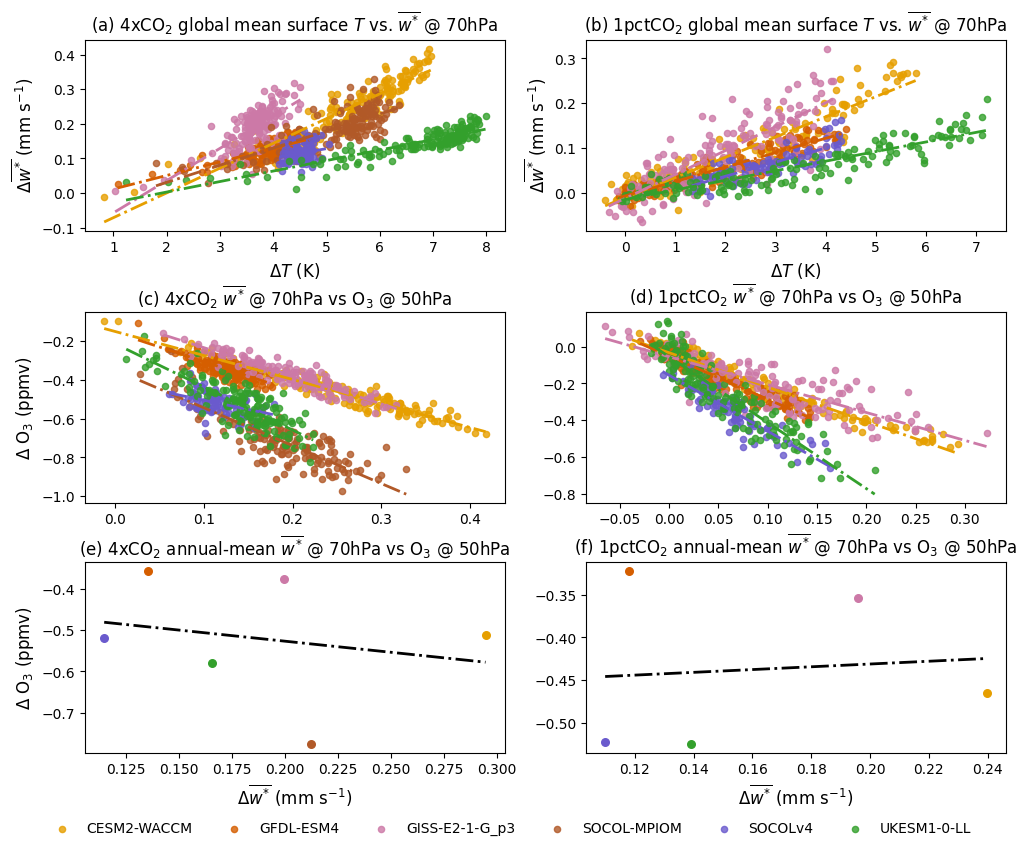

In [88]:
# plot tas_glbm vs. wtem & wtem vs. ozone
# first row: time series of average 20S-20N wtem at 70hPa  vs. tas_glbm
# second row: 150yr annual-mean wtem vs. ozone
# third row: time-mean of second row

# plot time series of average 20S-20N wtem vs. global mean tas

m_4CO2 = 0
m_1pct = 0

wtem_4CO2 = dict()
wtem_1pct = dict()
tas_4CO2 = dict()
tas_1pct = dict()

band_wtem = [-15,15]
plev = 7000 # 70hPa

#colors_col = cm.rainbow(np.linspace(0, 1, n_chem))
colors_col = cmc.vik(np.linspace(0, 1, n_chem))

fig10, ax10 = plt.subplots(3,2,figsize=(10,8),constrained_layout=True)

for i,c in zip(np.arange(0,n_model),colors_col):
    if model_name[i] != "MRI-ESM2-0_":
        if model_name[i] in wtem_zm_am_piControl_masked.keys():
            if (flag_chem[i] == 1 or flag_chem[i] == 0) :
                    print(model_name[i])
                    ind_band_wtem = np.zeros_like(band_wtem)
                    
                    if model_name[i] == "GISS-E2-1-G_p3_": # plev in Pa
                        ind_plev = np.where(abs(press_wtem.get(model_name[i])-plev/100) == min(abs(press_wtem.get(model_name[i])-plev/100)))[0][0]
                    else:
                        ind_plev = np.where(abs(press_wtem.get(model_name[i])-plev) == min(abs(press_wtem.get(model_name[i])-plev)))[0][0]
                    
                    for n in range(0,len(band_wtem)):
                        ind_band_wtem[n] = \
                        np.where(abs(latitude.get(model_name[i])-band_wtem[n]) == min(abs(latitude.get(model_name[i])-band_wtem[n])))[0][0]

                    if flag_4CO2[i] == 1:
                        print(model_name[i])
                        if model_name[i] == "SOCOLv4_":
                             n_start = 61
                        else:
                            n_start = 0

                        print(model_name[i],ma.mean(wtem_zm_am_diff_4CO2.get(model_name[i])[:,ind_plev,ind_band_wtem[0]:ind_band_wtem[1]],axis=0))
                        wtem_4CO2[model_name[i]] = 1000*ma.mean(wtem_zm_am_diff_4CO2.get(model_name[i])[:,ind_plev,ind_band_wtem[0]:ind_band_wtem[1]],axis=1)
                        tas_4CO2[model_name[i]] = tas_glbm_diff_4CO2.get(model_name[i])[n_start:]
                        print(model_name[i],np.shape(tas_4CO2.get(model_name[i])))
                        ax10[0,0].scatter(tas_4CO2.get(model_name[i]),wtem_4CO2.get(model_name[i]),label=model_name[i],s = 20, alpha = 0.8,color = colors_m[model_name[i]])
                        print(model_name[i], "wtem 4CO2 tm 70hPa 15S-15N:", np.mean(wtem_4CO2.get(model_name[i])))

                        # fitting wtem vs tas
                        fit_wtem_tas_4CO2 = np.polyfit(tas_4CO2.get(model_name[i]),wtem_4CO2.get(model_name[i]),1, full = True)
                        coeff_wtem_tas_4CO2 = fit_wtem_tas_4CO2[0]
                        print(model_name[i],"coefficients wtem vs tas 4CO2:",coeff_wtem_tas_4CO2)
                        p_wtem_tas_4CO2 = np.poly1d(np.polyfit(tas_4CO2.get(model_name[i]),wtem_4CO2.get(model_name[i]),1))

                        # compute R2
                        R2_wtem_tas_4CO2 = compute_R2(fit_wtem_tas_4CO2,wtem_4CO2.get(model_name[i]))
                        print(model_name[i],"R2 wtem vs tas 4CO2:",R2_wtem_tas_4CO2)

                        x_wtem_tas_4CO2 = np.linspace(min(tas_4CO2.get(model_name[i])),max(tas_4CO2.get(model_name[i])),100)
                        ax10[0,0].plot(x_wtem_tas_4CO2,p_wtem_tas_4CO2(x_wtem_tas_4CO2),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')

            
                    if flag_1pct[i] == 1:
                        print(model_name[i])
                        if model_name[i] == "SOCOLv4_":
                            n_start = 60
                        else:
                            n_start = 0
                        print(model_name[i],n_start)
                        wtem_1pct[model_name[i]] = 1000*ma.mean(wtem_zm_am_diff_1pct.get(model_name[i])[:,ind_plev,ind_band_wtem[0]:ind_band_wtem[1]],axis=1)
                        tas_1pct[model_name[i]] = tas_glbm_diff_1pct_all.get(model_name[i])[n_start:]
                        ax10[0,1].scatter(tas_1pct.get(model_name[i]),wtem_1pct.get(model_name[i]),label=model_name[i],s = 20, alpha = 0.8,color = colors_m[model_name[i]])

                        fit_wtem_tas_1pct = np.polyfit(tas_1pct.get(model_name[i]),wtem_1pct.get(model_name[i]),1, full = True)
                        coeff_wtem_tas_1pct = fit_wtem_tas_1pct[0]
                        print(model_name[i],"coefficients wtem vs tas 1pct:",coeff_wtem_tas_1pct)
                        p_wtem_tas_1pct = np.poly1d(np.polyfit(tas_1pct.get(model_name[i]),wtem_1pct.get(model_name[i]),1))

                        # compute R2
                        R2_wtem_tas_1pct = compute_R2(fit_wtem_tas_1pct,wtem_1pct.get(model_name[i]))
                        print(model_name[i],"R2 wtem vs tas 1pct:",R2_wtem_tas_1pct)

                        x_wtem_tas_1pct = np.linspace(min(tas_1pct.get(model_name[i])),max(tas_1pct.get(model_name[i])),100)
                        ax10[0,1].plot(x_wtem_tas_1pct,p_wtem_tas_1pct(x_wtem_tas_1pct),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')

                        m_1pct = m_1pct + 1

for ax in ax10[0,:].flat:
    ax.set_ylabel(r"$\Delta \overline{w^{*}}$ (mm s$^{-1}$)", fontsize = "large")
    ax.set_xlabel(r"$\Delta T$ (K)", fontsize = "large")

ax10[0,0].set_title(r"(a) 4xCO$_2$ global mean surface $T$ vs. $\overline{w^{*}}$ @ 70hPa", fontsize="large")
ax10[0,1].set_title(r"(b) 1pctCO$_2$ global mean surface $T$ vs. $\overline{w^{*}}$ @ 70hPa", fontsize="large")

# plot time series of average 20S-20N wtem 2 70hPa vs. tropically-averaged ozone @ 50hPa

m_4CO2 = 0
m_1pct = 0

wtem_4CO2 = dict()
wtem_1pct = dict()
wtem_4CO2_tm = np.zeros((6))
wtem_1pct_tm = np.zeros((5))

o3_4CO2 = dict()
o3_1pct = dict()
o3_4CO2_tm = np.zeros((6))
o3_1pct_tm = np.zeros((5))

band_wtem = [-15,15]
plev_wtem = 7000 # 70hPa
plev_o3 = 5000

for i,c in zip(np.arange(0,n_model),colors_col):
    if model_name[i] != "MRI-ESM2-0_":
        if model_name[i] in wtem_zm_am_piControl_masked.keys():
            if (flag_chem[i] == 1 or flag_chem[i] == 0) :
                    print(model_name[i])
                    ind_band_wtem = np.zeros_like(band_wtem)

                    if model_name[i] == "GISS-E2-1-G_p3_":
                        ind_plev_wtem = np.where(abs(press_wtem.get(model_name[i])-plev_wtem/100) == min(abs(press_wtem.get(model_name[i])-plev_wtem/100)))[0][0]
                    else:
                        ind_plev_wtem = np.where(abs(press_wtem.get(model_name[i])-plev_wtem) == min(abs(press_wtem.get(model_name[i])-plev_wtem)))[0][0]
                        
                    ind_plev_o3 = np.where(abs(press.get(model_name[i])-plev_o3) == min(abs(press.get(model_name[i])-plev_o3)))[0][0]
                    for n in range(0,len(band_wtem)):
                        ind_band_wtem[n] = \
                        np.where(abs(latitude.get(model_name[i])-band_wtem[n]) == min(abs(latitude.get(model_name[i])-band_wtem[n])))[0][0]
                    
                    if flag_4CO2[i] == 1:
                        print(model_name[i])
                        if model_name[i] == "GISS-E2-1-G_p3_":
                            n_start_wtem = 15
                            n_start_o3 = 0
                        elif model_name[i] == "SOCOLv4_":
                            n_start_o3 = 61
                            n_start_wtem = 0
                        else:
                            n_start_wtem = 0
                            n_start_o3 = 0

                        wtem_4CO2[model_name[i]] = 1000*ma.mean(wtem_zm_am_diff_4CO2.get(model_name[i])[n_start_wtem:,ind_plev_wtem,ind_band_wtem[0]:ind_band_wtem[1]],axis=1)
                        #print("wtem 4CO2 70hPa 15S-15N:", wtem_4CO2.get(model_name[i]))
                        o3_4CO2[model_name[i]] = ma.mean(o3_am_zm_diff_4CO2.get(model_name[i])[n_start_o3:,ind_plev_o3,ind_band_wtem[0]:ind_band_wtem[1]],axis=1)
                        ax10[1,0].scatter(wtem_4CO2.get(model_name[i]),o3_4CO2.get(model_name[i]),label=model_name[i],s = 20, alpha = 0.8,color = colors_m[model_name[i]])

                        # time-mean
                        wtem_4CO2_tm[m_4CO2] = ma.mean(wtem_4CO2.get(model_name[i])[-100:])
                        o3_4CO2_tm[m_4CO2] = ma.mean(o3_4CO2.get(model_name[i])[-100:])
                                                           
                        ax10[2,0].scatter(wtem_4CO2_tm[m_4CO2],o3_4CO2_tm[m_4CO2],\
                                           s = 30, alpha = 1.0,color = colors_m[model_name[i]])
                        
                        # fitting wtem vs o3
                        fit_wtem_o3_4CO2 = np.polyfit(wtem_4CO2.get(model_name[i]),o3_4CO2.get(model_name[i]),1, full = True)
                        coeff_wtem_o3_4CO2 = fit_wtem_o3_4CO2[0]
                        print(model_name[i],"coefficients w vs o3 4CO2:",coeff_wtem_o3_4CO2)
                        p_wtem_o3_4CO2 = np.poly1d(np.polyfit(wtem_4CO2.get(model_name[i]),o3_4CO2.get(model_name[i]),1))

                        # compute R2
                        R2_wtem_o3_4CO2 = compute_R2(fit_wtem_o3_4CO2,o3_4CO2.get(model_name[i]))
                        print(model_name[i],"R2 wtem vs o3 4CO2:",R2_wtem_o3_4CO2)

                        x_wtem_o3_4CO2 = np.linspace(min(wtem_4CO2.get(model_name[i])),max(wtem_4CO2.get(model_name[i])),100)
                        ax10[1,0].plot(x_wtem_o3_4CO2,p_wtem_o3_4CO2(x_wtem_o3_4CO2),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                        m_4CO2 = m_4CO2 + 1

                    if flag_1pct[i] == 1:
                        print(model_name[i])
                        if model_name[i] == "GISS-E2-1-G_p3_":
                            n_start_wtem = 15
                            n_start_o3 = 0
                        elif model_name[i] == "SOCOLv4_":
                            n_start_o3 = 60
                            n_start_wtem = 0
                        else:
                            n_start_wtem = 0
                            n_start_o3 = 0

                        wtem_1pct[model_name[i]] = 1000*ma.mean(wtem_zm_am_diff_1pct.get(model_name[i])[n_start_wtem:,ind_plev_wtem,ind_band_wtem[0]:ind_band_wtem[1]],axis=1)
                        o3_1pct[model_name[i]] = ma.mean(o3_am_zm_diff_1pct.get(model_name[i])[n_start_o3:,ind_plev_o3,ind_band_wtem[0]:ind_band_wtem[1]],axis=1)
                        ax10[1,1].scatter(wtem_1pct.get(model_name[i]),o3_1pct.get(model_name[i]),label=model_name[i],s = 20, alpha = 0.8,color = colors_m[model_name[i]])

                        # time-mean
                        wtem_1pct_tm[m_1pct] = ma.mean(wtem_1pct.get(model_name[i])[-15:-4])
                        print("wtem_1pct_tm",wtem_1pct_tm[m_1pct])
                        o3_1pct_tm[m_1pct] = ma.mean(o3_1pct.get(model_name[i])[-15:-4])
                                                           
                        ax10[2,1].scatter(wtem_1pct_tm[m_1pct],o3_1pct_tm[m_1pct],\
                                         s = 30, alpha = 1.0,color = colors_m[model_name[i]])
                        
                        fit_wtem_o3_1pct = np.polyfit(wtem_1pct.get(model_name[i]),o3_1pct.get(model_name[i]),1, full = True)
                        coeff_wtem_o3_1pct = fit_wtem_o3_1pct[0]
                        print(model_name[i],"coefficients wtem vs o3 1pct:",coeff_wtem_o3_1pct)
                        p_wtem_o3_1pct = np.poly1d(np.polyfit(wtem_1pct.get(model_name[i]),o3_1pct.get(model_name[i]),1))

                        # compute R2
                        R2_wtem_o3_1pct = compute_R2(fit_wtem_o3_1pct,o3_1pct.get(model_name[i]))
                        print(model_name[i],"R2 wtem vs o3 1pct:",R2_wtem_o3_1pct)

                        x_wtem_o3_1pct = np.linspace(min(wtem_1pct.get(model_name[i])),max(wtem_1pct.get(model_name[i])),100)
                        ax10[1,1].plot(x_wtem_o3_1pct,p_wtem_o3_1pct(x_wtem_o3_1pct),color = colors_m[model_name[i]],linestyle = "-.",linewidth = 2, label='_nolegend_')
                        m_1pct = m_1pct + 1

# fitting for time-mean values
# 4CO2
fit_wtem_o3_4CO2_tm = np.polyfit(wtem_4CO2_tm,o3_4CO2_tm,1, full = True)
coeff_wtem_o3_4CO2_tm = fit_wtem_o3_4CO2_tm[0]
print("coefficients wtem vs o3 4CO2 tm:",coeff_wtem_o3_4CO2_tm)
p_wtem_o3_4CO2_tm = np.poly1d(np.polyfit(wtem_4CO2_tm,o3_4CO2_tm,1))

# compute R2
R2_wtem_o3_4CO2_tm = compute_R2(fit_wtem_o3_4CO2_tm,o3_4CO2_tm)
print("R2 wtem vs o3 4CO2 tm:",R2_wtem_o3_4CO2_tm)

x_wtem_o3_4CO2_tm = np.linspace(min(wtem_4CO2_tm),max(wtem_4CO2_tm),100)
ax10[2,0].plot(x_wtem_o3_4CO2_tm,p_wtem_o3_4CO2_tm(x_wtem_o3_4CO2_tm),color = 'k',linestyle = "-.",linewidth = 2, label='_nolegend_')

# 1pct
# remove zero
print("wtem_1pct_tm",wtem_1pct_tm)
print("o3_1pct_tm",o3_1pct_tm)
wtem_1pct_tm = wtem_1pct_tm[wtem_1pct_tm!=0]
o3_1pct_tm = o3_1pct_tm[o3_1pct_tm!=0]

fit_wtem_o3_1pct_tm = np.polyfit(wtem_1pct_tm,o3_1pct_tm,1, full = True)
coeff_wtem_o3_1pct_tm = fit_wtem_o3_1pct_tm[0]
print("coefficients wtem vs o3 1pct tm:",coeff_wtem_o3_1pct_tm)
p_wtem_o3_1pct_tm = np.poly1d(np.polyfit(wtem_1pct_tm,o3_1pct_tm,1))

# compute R2
R2_wtem_o3_1pct_tm = compute_R2(fit_wtem_o3_1pct_tm,o3_1pct_tm)
print("R2 wtem vs o3 1pct tm:",R2_wtem_o3_1pct_tm)

x_wtem_o3_1pct_tm = np.linspace(min(wtem_1pct_tm),max(wtem_1pct_tm),100)
ax10[2,1].plot(x_wtem_o3_1pct_tm,p_wtem_o3_1pct_tm(x_wtem_o3_1pct_tm),color = 'k',linestyle = "-.",linewidth = 2, label='_nolegend_')

for ax in ax10[2,:].flat:
    ax.set_xlabel(r"$\Delta \overline{w^{*}}$ (mm s$^{-1}$)", fontsize = "large")
    
for ax in ax10[1:3,0].flat:
    ax.set_ylabel(r"$\Delta$ O$_3$ (ppmv)", fontsize = "large")


ax10[1,0].set_title(r"(c) 4xCO$_2$ $\overline{w^{*}}$ @ 70hPa vs O$_3$ @ 50hPa", fontsize = "large")
ax10[1,1].set_title(r"(d) 1pctCO$_2$ $\overline{w^{*}}$ @ 70hPa vs O$_3$ @ 50hPa", fontsize = "large")

ax10[2,0].set_title(r"(e) 4xCO$_2$ annual-mean $\overline{w^{*}}$ @ 70hPa vs O$_3$ @ 50hPa", fontsize = "large")
ax10[2,1].set_title(r"(f) 1pctCO$_2$ annual-mean $\overline{w^{*}}$ @ 70hPa vs O$_3$ @ 50hPa", fontsize = "large")

fig10.legend([model_name[n][:-1] for n in [0,6,7,9,10,11]], bbox_to_anchor=(0.5, -0.05),frameon=False, ncols = 6, loc = 'lower center')
fig10.savefig('../Output/paper/delta_wtem_vs_delta_o3_tas_70hPa_15.pdf', bbox_inches = "tight", dpi = 300) 

# chem vs no-chem
# single pair and multi-pair average

In [89]:
# variables

latitude_pair = dict()
press = dict()

ta_am_zm_piControl_masked = dict()
ta_am_zm_4CO2_masked = dict()
ta_am_zm_1pct_masked = dict()

ta_am_zm_diff_4CO2 = dict()
ta_am_zm_diff_1pct = dict()

ta_tm_zm_piControl_masked = dict()
ta_tm_zm_4CO2_masked = dict()
ta_tm_zm_1pct_masked = dict()

ta_tm_zm_diff_4CO2 = dict()
ta_tm_zm_diff_1pct = dict()

p_pair_chem = dict()
strip_pair_chem_lat = dict()
strip_pair_chem_press = dict()

p_pair_nonchem = dict()
strip_pair_nonchem_lat = dict()
strip_pair_nonchem_press = dict()

p_pair_diff = dict()
strip_pair_diff_lat = dict()
strip_pair_diff_press = dict()

# pairs
chem_pair = ["CESM2-WACCM_","CESM2-WACCM-FV2_","SOCOLv4_","GFDL-ESM4_","UKESM1-0-LL_","GISS-E2-1-G_p3_","GISS-E2-2-G_p3_"]
nonchem_pair = ["CESM2_","CESM2-FV2_","MPI-ESM1-2-LR_","GFDL-CM4_","HadGEM3-GC31-LL_","GISS-E2-1-G_p1_","GISS-E2-2-G_p1_"]

pairs = chem_pair + nonchem_pair

path_ta_am_zm = "../data/temp/am_zm"
path_ta_tm_zm = "../data/temp/tm_zm"
species = "ta"

In [90]:
# read am_zm ta data for t-test

for i in range(0,len(pairs)): 
    for f in os.listdir(path_ta_am_zm):
        if os.path.isfile(os.path.join(path_ta_am_zm,f)) and (pairs[i] in f): 
            if experiment[0] in f:
                if pairs[i] != "SOCOLv4_":
                    am_zm_piControl = nc.Dataset(os.path.join(path_ta_am_zm,f)).variables[species][:,:,:,0]
                    ta_am_zm_piControl_masked[pairs[i]] = ma.masked_values(am_zm_piControl, 1e20)
                elif "verinterpolate" in f:
                    am_zm_piControl = nc.Dataset(os.path.join(path_ta_am_zm,f)).variables[species][:]
                    ta_am_zm_piControl_masked[pairs[i]] = ma.masked_values(am_zm_piControl, 1e20)
                press[pairs[i]] = nc.Dataset(os.path.join(path_ta_am_zm,f)).variables['plev'][:]
                latitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ta_am_zm,f)).variables['lat'][:]
                print("pi",pairs[i],np.shape(ta_am_zm_piControl_masked.get(pairs[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                if pairs[i] != "SOCOLv4_":
                    am_zm_4CO2 = nc.Dataset(os.path.join(path_ta_am_zm,f)).variables[species][:,:,:,0]
                    ta_am_zm_4CO2_masked[pairs[i]] = ma.masked_values(am_zm_4CO2, 1e20)
                elif "verinterpolate" in f:
                    am_zm_4CO2 = nc.Dataset(os.path.join(path_ta_am_zm,f)).variables[species][:]
                    ta_am_zm_4CO2_masked[pairs[i]] = ma.masked_values(am_zm_4CO2, 1e20)
                latitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ta_am_zm,f)).variables['lat'][:]
                print("4CO2",pairs[i],np.shape(ta_am_zm_4CO2_masked.get(pairs[i])))

4CO2 CESM2-WACCM_ (100, 19, 192)
pi CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM-FV2_ (100, 19, 96)
pi CESM2-WACCM-FV2_ (150, 19, 96)
pi SOCOLv4_ ()
pi SOCOLv4_ (150, 19, 96)
4CO2 SOCOLv4_ (100, 19, 96)
4CO2 GFDL-ESM4_ (100, 19, 180)
pi GFDL-ESM4_ (150, 19, 180)
4CO2 UKESM1-0-LL_ (100, 19, 144)
pi UKESM1-0-LL_ (150, 19, 144)
4CO2 GISS-E2-1-G_p3_ (150, 19, 90)
pi GISS-E2-1-G_p3_ (150, 19, 90)
pi GISS-E2-2-G_p3_ (150, 19, 90)
4CO2 GISS-E2-2-G_p3_ (100, 19, 90)
4CO2 CESM2_ (100, 19, 192)
pi CESM2_ (150, 19, 192)
4CO2 CESM2-FV2_ (100, 19, 96)
pi CESM2-FV2_ (150, 19, 96)
pi MPI-ESM1-2-LR_ (150, 19, 96)
4CO2 MPI-ESM1-2-LR_ (100, 19, 96)
4CO2 GFDL-CM4_ (100, 19, 180)
pi GFDL-CM4_ (150, 19, 180)
4CO2 HadGEM3-GC31-LL_ (100, 19, 144)
pi HadGEM3-GC31-LL_ (150, 19, 144)
4CO2 GISS-E2-1-G_p1_ (150, 19, 90)
pi GISS-E2-1-G_p1_ (150, 19, 90)
4CO2 GISS-E2-2-G_p1_ (100, 19, 90)
pi GISS-E2-2-G_p1_ (150, 19, 90)
4CO2 GISS-E2-2-G_p1_ (100, 19, 90)


In [91]:
# read tm_zm ta data

for i in range(0,len(pairs)): 
    for f in os.listdir(path_ta_tm_zm):
        if os.path.isfile(os.path.join(path_ta_tm_zm,f)) and (pairs[i] in f): 
            if experiment[0] in f:
                if pairs[i] != "SOCOL-MPIOM_" and pairs[i] != "SOCOLv4_":
                    tm_zm_piControl = nc.Dataset(os.path.join(path_ta_tm_zm,f)).variables[species][:,:,:,0]
                    ta_tm_zm_piControl_masked[pairs[i]] = ma.masked_values(tm_zm_piControl, 1e20)
                elif "verinterpolate" in f:
                    tm_zm_piControl = nc.Dataset(os.path.join(path_ta_tm_zm,f)).variables[species][:]
                    ta_tm_zm_piControl_masked[pairs[i]] = ma.masked_values(tm_zm_piControl, 1e20)
                print("pi",pairs[i],np.shape(ta_tm_zm_piControl_masked.get(pairs[i])))
            
            if experiment[1] in f and ("last100yr" in f):
                if pairs[i] != "SOCOLv4_":
                    tm_zm_4CO2 = nc.Dataset(os.path.join(path_ta_tm_zm,f)).variables[species][:,:,:,0]
                    ta_tm_zm_4CO2_masked[pairs[i]] = ma.masked_values(tm_zm_4CO2, 1e20)
                elif "verinterpolate" in f:
                    tm_zm_4CO2 = nc.Dataset(os.path.join(path_ta_tm_zm,f)).variables[species][:]
                    ta_tm_zm_4CO2_masked[pairs[i]] = ma.masked_values(tm_zm_4CO2, 1e20)
                print("4CO2",pairs[i],np.shape(ta_tm_zm_4CO2_masked.get(pairs[i])))
    
# compute relative difference
for i in range(0,len(pairs)):
    print(pairs[i])
    ta_tm_zm_diff_4CO2[pairs[i]] = \
    ta_tm_zm_4CO2_masked.get(pairs[i]) - ta_tm_zm_piControl_masked.get(pairs[i])
    print("4CO2",pairs[i],np.shape(ta_tm_zm_diff_4CO2.get(pairs[i])))
    
    ta_am_zm_diff_4CO2[pairs[i]] = \
    ta_am_zm_4CO2_masked.get(pairs[i]) - \
    ta_am_zm_piControl_masked.get(pairs[i])[-np.shape(ta_am_zm_4CO2_masked.get(pairs[i]))[0]:]
    print("4CO2",pairs[i],np.shape(ta_am_zm_diff_4CO2.get(pairs[i])))

4CO2 CESM2-WACCM_ (1, 19, 192)
pi CESM2-WACCM_ (1, 19, 192)
4CO2 CESM2-WACCM-FV2_ (1, 19, 96)
pi CESM2-WACCM-FV2_ (1, 19, 96)
4CO2 SOCOLv4_ ()
4CO2 SOCOLv4_ (1, 19, 96)
pi SOCOLv4_ (1, 19, 96)
pi SOCOLv4_ (1, 19, 96)
4CO2 GFDL-ESM4_ (1, 19, 180)
pi GFDL-ESM4_ (1, 19, 180)
4CO2 UKESM1-0-LL_ (1, 19, 144)
pi UKESM1-0-LL_ (1, 19, 144)
4CO2 GISS-E2-1-G_p3_ (1, 19, 90)
pi GISS-E2-1-G_p3_ (1, 19, 90)
4CO2 GISS-E2-2-G_p3_ (1, 19, 90)
pi GISS-E2-2-G_p3_ (1, 19, 90)
4CO2 CESM2_ (1, 19, 192)
pi CESM2_ (1, 19, 192)
4CO2 CESM2-FV2_ (1, 19, 96)
pi CESM2-FV2_ (1, 19, 96)
pi MPI-ESM1-2-LR_ (1, 19, 96)
4CO2 MPI-ESM1-2-LR_ (1, 19, 96)
4CO2 GFDL-CM4_ (1, 19, 180)
pi GFDL-CM4_ (1, 19, 180)
4CO2 HadGEM3-GC31-LL_ (1, 19, 144)
pi HadGEM3-GC31-LL_ (1, 19, 144)
4CO2 GISS-E2-1-G_p1_ (1, 19, 90)
pi GISS-E2-1-G_p1_ (1, 19, 90)
4CO2 GISS-E2-2-G_p1_ (1, 19, 90)
pi GISS-E2-2-G_p1_ (1, 19, 90)
4CO2 GISS-E2-2-G_p1_ (1, 19, 90)
CESM2-WACCM_
4CO2 CESM2-WACCM_ (1, 19, 192)
4CO2 CESM2-WACCM_ (100, 19, 192)
CESM2-WACCM-FV2

0
1


/tmp/ipykernel_19592/3482563166.py:42: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  [stat, p_pair_chem[pairs[idx_chem]]] = stats.ttest_ind\
/home/wangjingy/.conda/envs/thesis/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1199: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/wangjingy/.conda/envs/thesis/lib/python3.11/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_19592/3482563166.py:46: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  [stat, p_pair_nonchem[pairs[idx_nonchem]]] = stats.ttest_ind\
/tmp/ipykernel_19592/3482563166.py:50: RuntimeWarning: Precision loss occurred in moment calcu

2
3
4
5
6


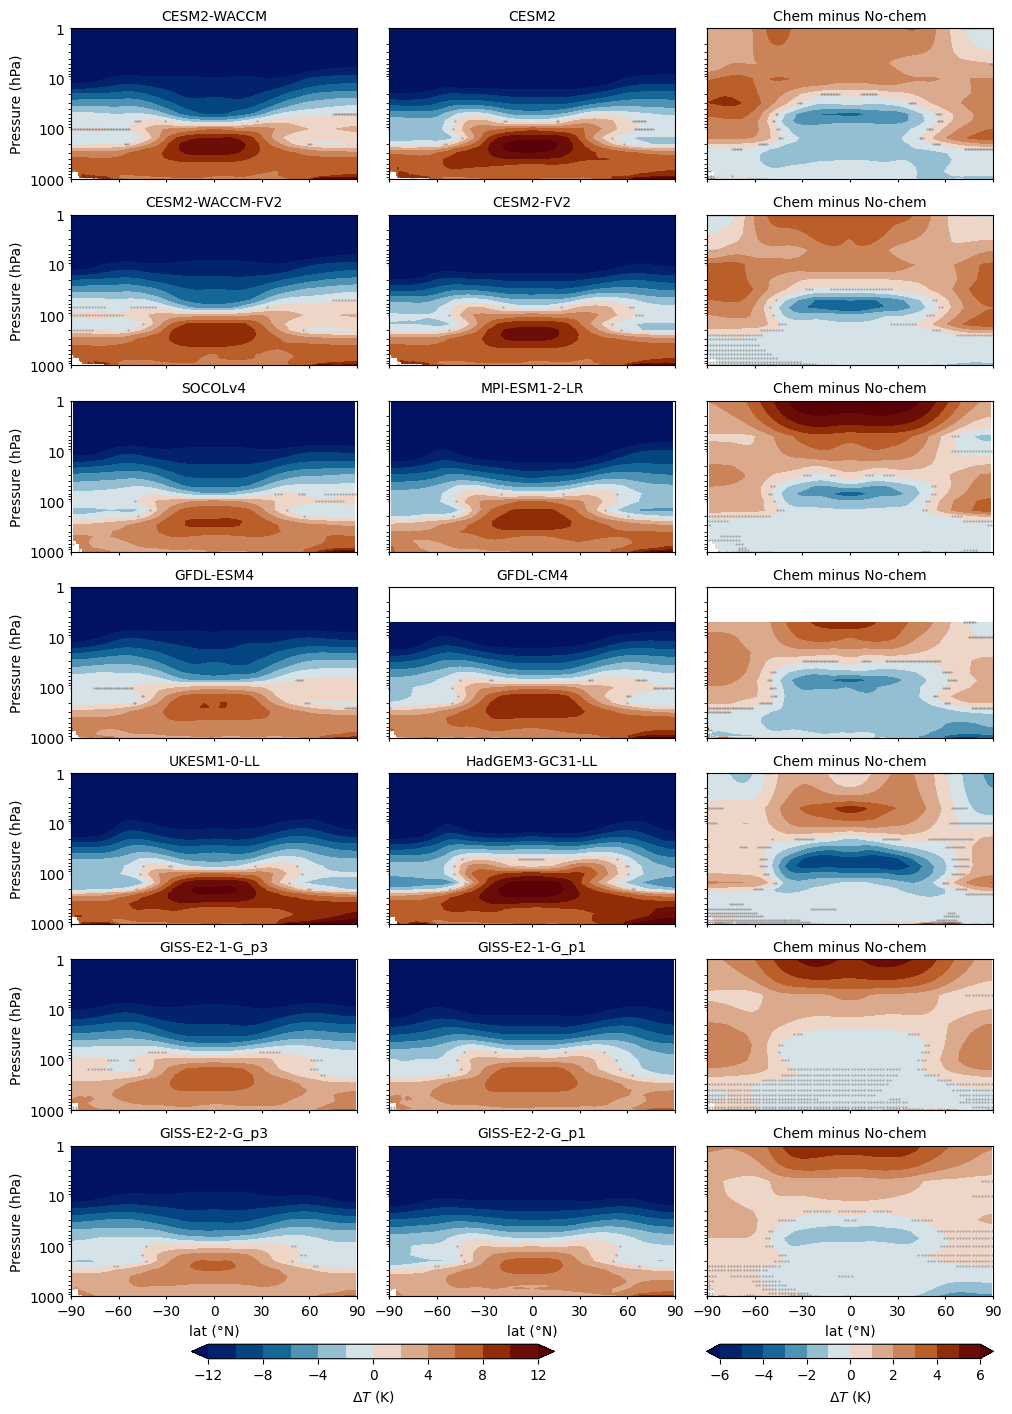

In [92]:
# plot temp difference for single pair

# set the colormap
#cmap = cm.coolwarm
cmap = cmc.vik

fig,axes = plt.subplots(7,3,figsize=(10,14), constrained_layout = True)

for i in range(0,len(chem_pair)):
    # index of chem model
    idx_chem = pairs.index(chem_pair[i])
    idx_nonchem = pairs.index(nonchem_pair[i])
    print(i)
    for ax in axes.flat:
        ax.set_xlim(-90,90)
        ax.set_ylim(100,10**5)
        ax.set_yscale('log')
        ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
        ax.set_yticks(ticks = [10**5,10**4,10**3,10**2], labels = ["1000","100","10","1"])
        ax.invert_yaxis()
        ax.tick_params(axis='x', labelsize=10, length=2)
        ax.tick_params(axis='y', labelsize=10, length=1)
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
     
    for ax in axes[6,:].flat:
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.set_xlabel("lat (\u00b0N)", fontsize = "medium")
    
    for ax in axes[:,0].flat:
        ax.yaxis.set_tick_params(labelleft=True)
        ax.set_ylabel("Pressure (hPa)", fontsize = "medium" )

    axes[i,0].set_title(pairs[idx_chem][:-1], fontsize = "medium")
    axes[i,1].set_title(pairs[idx_nonchem][:-1], fontsize = "medium")
    axes[i,2].set_title("Chem minus No-chem", fontsize = "medium")

    levels = np.linspace(-12, 12, 13)
    levels_diff = np.linspace(-6, 6, 13)
    
    # t-test
    [stat, p_pair_chem[pairs[idx_chem]]] = stats.ttest_ind\
    (ta_am_zm_piControl_masked.get(pairs[idx_chem]),\
     ta_am_zm_4CO2_masked.get(pairs[idx_chem]))
    
    [stat, p_pair_nonchem[pairs[idx_nonchem]]] = stats.ttest_ind\
    (ta_am_zm_piControl_masked.get(pairs[idx_nonchem]),\
     ta_am_zm_4CO2_masked.get(pairs[idx_nonchem]))
    
    [stat, p_pair_diff[pairs[idx_chem]]] = stats.ttest_ind\
    (ta_am_zm_diff_4CO2.get(pairs[idx_chem]),\
     ta_am_zm_diff_4CO2.get(pairs[idx_nonchem]))
    
    # find the location which does not satisfy the confidence level at 99%
    strip_pair_chem_lat[pairs[idx_chem]] = np.where(p_pair_chem.get(pairs[idx_chem]) > 0.005)[1]
    strip_pair_chem_press[pairs[idx_chem]] = np.where(p_pair_chem.get(pairs[idx_chem]) > 0.005)[0]
    
    strip_pair_nonchem_lat[pairs[idx_nonchem]] = np.where(p_pair_nonchem.get(pairs[idx_nonchem]) > 0.005)[1]
    strip_pair_nonchem_press[pairs[idx_nonchem]] = np.where(p_pair_nonchem.get(pairs[idx_nonchem]) > 0.005)[0]
    
    strip_pair_diff_lat[pairs[idx_chem]] = np.where(p_pair_diff.get(pairs[idx_chem]) > 0.005)[1]
    strip_pair_diff_press[pairs[idx_chem]] = np.where(p_pair_diff.get(pairs[idx_chem]) > 0.005)[0]
    
    # center the colorbar at zero
    cs1 = axes[i,0].contourf(latitude_pair.get(pairs[idx_chem]), press.get(pairs[0]),\
                        ta_tm_zm_diff_4CO2.get(pairs[idx_chem])[0,:,:],\
                        corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap, levels = levels, extend = "both")
    #cs11 = axes[i,0].contour(latitude_pair.get(pairs[idx_chem]), press.get(pairs[0]),\
    #                      ta_tm_zm_piControl_masked.get(pairs[idx_chem])[0,:,:],\
    #                        colors='k', linewidths = 1)
    #axes[i,0].clabel(cs11, inline=True,fontsize = 8)
    
    cs2 = axes[i,1].contourf(latitude_pair.get(pairs[idx_nonchem]), press.get(pairs[0]),\
                        ta_tm_zm_diff_4CO2.get(pairs[idx_nonchem])[0,:,:],\
                        corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap, levels = levels, extend = "both")
    #cs21 = axes[i,1].contour(latitude_pair.get(pairs[idx_nonchem]), press.get(pairs[0]),\
    #                      ta_tm_zm_piControl_masked.get(pairs[idx_nonchem])[0,:,:],\
    #                        colors='k', linewidths = 1)
    #axes[i,1].clabel(cs21, inline=True,fontsize = 8)
    
    cs3 = axes[i,2].contourf(latitude_pair.get(pairs[idx_chem]), press.get(pairs[0]),\
                        ta_tm_zm_diff_4CO2.get(pairs[idx_chem])[0,:,:]-\
                        ta_tm_zm_diff_4CO2.get(pairs[idx_nonchem])[0,:,:],\
                        corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap, levels = levels_diff, extend = "both")

    # scatter plot for t-test
    axes[i,0].scatter(latitude_pair.get(pairs[idx_chem])[strip_pair_chem_lat.get(pairs[idx_chem])],\
                press.get(pairs[idx_chem])[strip_pair_chem_press.get(pairs[idx_chem])],\
                marker = '.', s=0.5, c='grey')

    axes[i,1].scatter(latitude_pair.get(pairs[idx_nonchem])[strip_pair_nonchem_lat.get(pairs[idx_nonchem])],\
                press.get(pairs[idx_nonchem])[strip_pair_nonchem_press.get(pairs[idx_nonchem])],\
                marker = '.', s=0.5, c='grey')
    
    axes[i,2].scatter(latitude_pair.get(pairs[idx_chem])[strip_pair_diff_lat.get(pairs[idx_chem])],\
                press.get(pairs[idx_chem])[strip_pair_diff_press.get(pairs[idx_chem])],\
                marker = '.', s=0.5, c='grey')
    
plt.colorbar(cs1, ax=axes[i,0:2].ravel().tolist(),label = r"$\Delta T$ (K)",\
                orientation = 'horizontal', aspect = 25, shrink = 0.6)
plt.colorbar(cs3, ax=axes[i,2],label = r"$\Delta T$ (K)",orientation = 'horizontal')

fig.savefig('../Output/paper/'+species+'_reldiff_tm_zm_4CO2_last100yr_single_pair.pdf',\
            bbox_inches = "tight", dpi = 300)

In [93]:
# average of pairs

path_ta_tm_zm_remap = "../data/chem_nonchem/temp/tm_zm"
path_ta_am_zm_remap = "../data/chem_nonchem/temp/am_zm"
species = "ta"

press_remap = dict()
latitude_remap = dict()

ta_am_zm_remap_piControl_masked = dict()
ta_am_zm_remap_4CO2_masked = dict()

ta_am_zm_remap_diff_4CO2 = dict()

ta_tm_zm_remap_piControl_masked = dict()
ta_tm_zm_remap_4CO2_masked = dict()

ta_tm_zm_remap_diff_4CO2 = dict()


# read in am_zm remap data for t-test
for i in range(0,len(pairs)): 
    for f in os.listdir(path_ta_am_zm_remap):
        if os.path.isfile(os.path.join(path_ta_am_zm_remap,f)) and (pairs[i] in f): 
            if experiment[0] in f:
                if pairs[i] != "SOCOL-MPIOM_" and pairs[i] != "SOCOLv4_":
                    am_zm_remap_piControl = nc.Dataset(os.path.join(path_ta_am_zm_remap,f)).variables[species][:,:,:,0]
                    ta_am_zm_remap_piControl_masked[pairs[i]] = ma.masked_values(am_zm_remap_piControl, 1e20)
                elif "verinterpolate" in f:
                    am_zm_remap_piControl = nc.Dataset(os.path.join(path_ta_am_zm_remap,f)).variables[species][:]
                    ta_am_zm_remap_piControl_masked[pairs[i]] = ma.masked_values(am_zm_remap_piControl, 1e20)
                print("pi",pairs[i],np.shape(ta_am_zm_remap_piControl_masked.get(pairs[i])))

            if experiment[1] in f and ("last100yr" in f):
                if pairs[i] != "SOCOL-MPIOM_" and pairs[i] != "SOCOLv4_":
                    am_zm_remap_4CO2 = nc.Dataset(os.path.join(path_ta_am_zm_remap,f)).variables[species][:,:,:,0]
                    ta_am_zm_remap_4CO2_masked[pairs[i]] = ma.masked_values(am_zm_remap_4CO2, 1e20)
                elif "verinterpolate" in f:
                    am_zm_remap_4CO2 = nc.Dataset(os.path.join(path_ta_am_zm_remap,f)).variables[species][:]
                    ta_am_zm_remap_4CO2_masked[pairs[i]] = ma.masked_values(am_zm_remap_4CO2, 1e20)
                print("4CO2",pairs[i],np.shape(ta_am_zm_remap_4CO2_masked.get(pairs[i])))

# read tm_zm remap data
for i in range(0,len(pairs)): 
    for f in os.listdir(path_ta_tm_zm_remap):
        if os.path.isfile(os.path.join(path_ta_tm_zm_remap,f)) and (pairs[i] in f): 

            if experiment[0] in f:
                if pairs[i] != "SOCOLv4_":
                    tm_zm_remap_piControl = nc.Dataset(os.path.join(path_ta_tm_zm_remap,f)).variables[species][:,:,:,0]
                    ta_tm_zm_remap_piControl_masked[pairs[i]] = ma.masked_values(tm_zm_remap_piControl, 1e20)
                else:
                    tm_zm_remap_piControl = nc.Dataset(os.path.join(path_ta_tm_zm_remap,f)).variables[species][:]
                    ta_tm_zm_remap_piControl_masked[pairs[i]] = ma.masked_values(tm_zm_remap_piControl, 1e20)
                press_remap[pairs[i]] = nc.Dataset(os.path.join(path_ta_tm_zm_remap,f)).variables['plev'][:]
                latitude_remap[pairs[i]] = nc.Dataset(os.path.join(path_ta_tm_zm_remap,f)).variables['lat'][:]
                print("pi",pairs[i],np.shape(ta_tm_zm_remap_piControl_masked.get(pairs[i])))
            
            if experiment[1] in f and ("last100yr" in f):
                if pairs[i] != "SOCOLv4_":
                    tm_zm_remap_4CO2 = nc.Dataset(os.path.join(path_ta_tm_zm_remap,f)).variables[species][:,:,:,0]
                    ta_tm_zm_remap_4CO2_masked[pairs[i]] = ma.masked_values(tm_zm_remap_4CO2, 1e20)
                else:
                    tm_zm_remap_4CO2 = nc.Dataset(os.path.join(path_ta_tm_zm_remap,f)).variables[species][:]
                    ta_tm_zm_remap_4CO2_masked[pairs[i]] = ma.masked_values(tm_zm_remap_4CO2, 1e20)
                print("4CO2",pairs[i],np.shape(ta_tm_zm_remap_4CO2_masked.get(pairs[i])))

# compute relat diff
for i in range(0,len(pairs)):
    print(pairs[i])
    ta_tm_zm_remap_diff_4CO2[pairs[i]] = \
    ta_tm_zm_remap_4CO2_masked.get(pairs[i]) - ta_tm_zm_remap_piControl_masked.get(pairs[i])
    print("4CO2",pairs[i],np.shape(ta_tm_zm_remap_diff_4CO2.get(pairs[i])))
    
    ta_am_zm_remap_diff_4CO2[pairs[i]] = \
    ta_am_zm_remap_4CO2_masked.get(pairs[i]) - \
    ta_am_zm_remap_piControl_masked.get(pairs[i])[-np.shape(ta_am_zm_remap_4CO2_masked.get(pairs[i]))[0]:]
    print("4CO2",pairs[i],np.shape(ta_am_zm_remap_diff_4CO2.get(pairs[i])))
    
# set NAN in GFDL-CM4 to 0
ta_tm_zm_remap_diff_4CO2.get(pairs[-4])[0,18,:] = 0
ta_tm_zm_remap_piControl_masked.get(pairs[-4])[0,18,:] = 0

4CO2 CESM2-WACCM_ (100, 19, 192)
pi CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM-FV2_ (100, 19, 192)
pi CESM2-WACCM-FV2_ (150, 19, 192)
4CO2 SOCOLv4_ (100, 19, 192)
pi SOCOLv4_ (150, 19, 192)
pi GFDL-ESM4_ (150, 19, 192)
4CO2 GFDL-ESM4_ (100, 19, 192)
pi UKESM1-0-LL_ (150, 19, 192)
4CO2 UKESM1-0-LL_ (100, 19, 192)
4CO2 GISS-E2-1-G_p3_ (150, 19, 192)
pi GISS-E2-1-G_p3_ (150, 19, 192)
pi GISS-E2-2-G_p3_ (150, 19, 192)
4CO2 GISS-E2-2-G_p3_ (100, 19, 192)
4CO2 CESM2_ (100, 19, 192)
pi CESM2_ (150, 19, 192)
4CO2 CESM2-FV2_ (100, 19, 192)
pi CESM2-FV2_ (150, 19, 192)
4CO2 MPI-ESM1-2-LR_ (100, 19, 192)
pi MPI-ESM1-2-LR_ (150, 19, 192)
4CO2 GFDL-CM4_ (100, 19, 192)
pi GFDL-CM4_ (150, 19, 192)
4CO2 HadGEM3-GC31-LL_ (100, 19, 192)
pi HadGEM3-GC31-LL_ (150, 19, 192)
4CO2 GISS-E2-1-G_p1_ (150, 19, 192)
pi GISS-E2-1-G_p1_ (150, 19, 192)
4CO2 GISS-E2-2-G_p1_ (100, 19, 192)
pi GISS-E2-2-G_p1_ (150, 19, 192)
4CO2 CESM2-WACCM_ (1, 19, 192)
pi CESM2-WACCM_ (1, 19, 192)
4CO2 CESM2-WACCM-FV2_ (1, 19, 192)

In [94]:
# be mindful of repeated run --> add on sum
pairs_chem_pi_sum = np.zeros((1,19,192))
pairs_nonchem_pi_sum = np.zeros((1,19,192))
pairs_chem_sum = np.zeros((1,19,192))
pairs_nonchem_sum = np.zeros((1,19,192))

# concatenate arrays for t-test   
pairs_chem_pi_sum = ta_tm_zm_remap_piControl_masked.get(pairs[0])
pairs_nonchem_pi_sum = ta_tm_zm_remap_piControl_masked.get(pairs[len(chem_pair)])
pairs_chem_sum = ta_tm_zm_remap_diff_4CO2.get(pairs[0])
pairs_nonchem_sum = ta_tm_zm_remap_diff_4CO2.get(pairs[len(chem_pair)])
pairs_chem_avg_pi = ta_am_zm_remap_piControl_masked.get(pairs[0])
pairs_nonchem_avg_pi = ta_am_zm_remap_piControl_masked.get(pairs[len(chem_pair)])
pairs_chem_avg_4CO2 = ta_am_zm_remap_4CO2_masked.get(pairs[0])
pairs_nonchem_avg_4CO2 = ta_am_zm_remap_4CO2_masked.get(pairs[len(chem_pair)])
pairs_diff_chem_avg = ta_am_zm_remap_diff_4CO2.get(pairs[0])
pairs_diff_nonchem_avg = ta_am_zm_remap_diff_4CO2.get(pairs[len(chem_pair)])

for i in range(1,len(chem_pair)):
    print(pairs[i])
    pairs_chem_pi_sum += ta_tm_zm_remap_piControl_masked.get(pairs[i])
    pairs_nonchem_pi_sum += ta_tm_zm_remap_piControl_masked.get(pairs[len(chem_pair)+i])
    pairs_chem_sum += ta_tm_zm_remap_diff_4CO2.get(pairs[i])
    pairs_nonchem_sum += ta_tm_zm_remap_diff_4CO2.get(pairs[len(chem_pair)+i])
    
    pairs_chem_avg_pi = \
    np.concatenate((pairs_chem_avg_pi,ta_am_zm_remap_piControl_masked.get(pairs[i])))
    pairs_chem_avg_4CO2 = \
    np.concatenate((pairs_chem_avg_4CO2,ta_am_zm_remap_4CO2_masked.get(pairs[i])))
    pairs_nonchem_avg_pi = \
    np.concatenate((pairs_nonchem_avg_pi,ta_am_zm_remap_piControl_masked.get(pairs[len(chem_pair)+i])))
    pairs_nonchem_avg_4CO2 = \
    np.concatenate((pairs_nonchem_avg_4CO2,ta_am_zm_remap_4CO2_masked.get(pairs[len(chem_pair)+i])))
    pairs_diff_chem_avg = \
    np.concatenate((pairs_diff_chem_avg,ta_am_zm_remap_diff_4CO2.get(pairs[i])))
    pairs_diff_nonchem_avg = \
    np.concatenate((pairs_diff_nonchem_avg,ta_am_zm_remap_diff_4CO2.get(pairs[len(chem_pair)+i])))
    
# compute avg
pairs_chem_avg = np.zeros((1,19,192))
pairs_nonchem_avg = np.zeros((1,19,192))
pairs_chem_pi_avg = np.zeros((1,19,192))
pairs_nonchem_pi_avg = np.zeros((1,19,192))

pairs_chem_avg = pairs_chem_sum/len(chem_pair)
pairs_chem_pi_avg = pairs_chem_pi_sum/len(chem_pair)
pairs_nonchem_pi_avg = pairs_nonchem_pi_sum/len(chem_pair)

# the uppest lev has only #len(chem_pair)-1 model data avaiable
pairs_nonchem_avg[:,0:18,:] = pairs_nonchem_sum[:,0:18,:]/len(nonchem_pair)
pairs_nonchem_avg[:,18,:] = pairs_nonchem_sum[:,18,:]/(len(nonchem_pair)-1)


# t-test
[stat, p_pair_chem_avg] = stats.ttest_ind(pairs_chem_avg_pi,pairs_chem_avg_4CO2)
[stat, p_pair_nonchem_avg] = stats.ttest_ind(pairs_nonchem_avg_pi,pairs_nonchem_avg_4CO2)
[stat, p_pair_diff_avg] = stats.ttest_ind(pairs_diff_chem_avg,pairs_diff_nonchem_avg)

strip_pair_chem_avg_lat = np.where(p_pair_chem_avg > 0.005)[1]
strip_pair_chem_avg_press = np.where(p_pair_chem_avg > 0.005)[0]
strip_pair_nonchem_avg_lat = np.where(p_pair_nonchem_avg > 0.005)[1]
strip_pair_nonchem_avg_press = np.where(p_pair_nonchem_avg > 0.005)[0]
strip_pair_diff_avg_lat = np.where(p_pair_diff_avg > 0.005)[1]
strip_pair_diff_avg_press = np.where(p_pair_diff_avg > 0.005)[0]

CESM2-WACCM-FV2_
SOCOLv4_
GFDL-ESM4_
UKESM1-0-LL_
GISS-E2-1-G_p3_
GISS-E2-2-G_p3_


/home/wangjingy/.conda/envs/thesis/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1199: RuntimeWarning: overflow encountered in square
  s = a_zero_mean**2
/home/wangjingy/.conda/envs/thesis/lib/python3.11/site-packages/numpy/core/_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


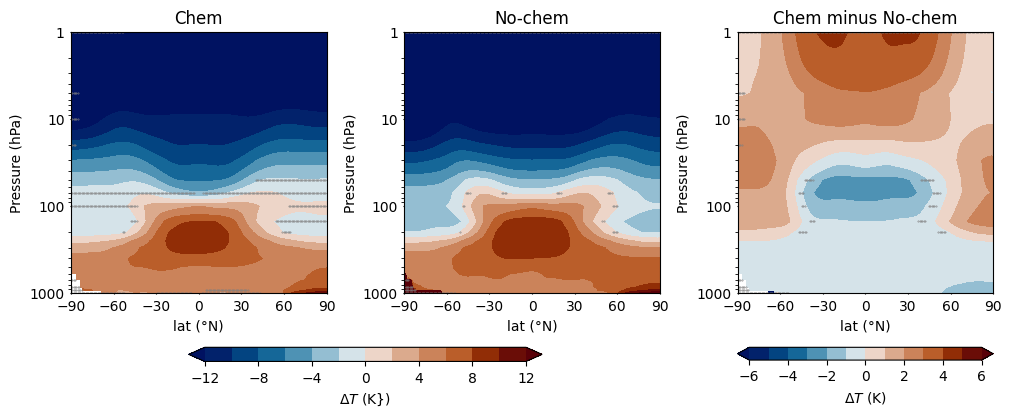

In [95]:
# plot multi-model avg

fig,axes = plt.subplots(1,3,figsize=(10,4), constrained_layout = True)
for ax in axes.flat:
    ax.set_xlim(-90,90)
    ax.set_ylim(100,10**5)
    ax.set_yscale('log')
    ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
    ax.set_yticks(ticks = [10**5,10**4,10**3,10**2], labels = ["1000","100","10","1"])
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelsize=10, length=1)
    ax.tick_params(axis='y', labelsize=10, length=1)
    ax.set_xlabel("lat (\u00b0N)", fontsize = "medium")
    ax.set_ylabel("Pressure (hPa)", fontsize = "medium" )

axes[0].set_title("Chem", fontsize = "large")
axes[1].set_title("No-chem", fontsize = "large")
axes[2].set_title("Chem minus No-chem", fontsize = "large")

levels = np.linspace(-12, 12, 13)
levels_diff = np.linspace(-6, 6, 13)

cs1 = axes[0].contourf(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
                    pairs_chem_avg[0,:,:], corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap, levels = levels, extend = "both")
#cs11 = axes[0].contour(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
#                    pairs_chem_pi_avg[0,:,:],\
#                    colors='k', linewidths = 1)
#axes[0].clabel(cs11, inline=True,fontsize = 8)

cs2 = axes[1].contourf(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
                    pairs_nonchem_avg[0,:,:],corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap, levels = levels, extend = "both")
#cs21 = axes[1].contour(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
#                    pairs_nonchem_pi_avg[0,:,:],\
#                    colors='k', linewidths = 1)
#axes[1].clabel(cs21, inline=True,fontsize = 8)

cs3 = axes[2].contourf(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
                    pairs_chem_avg[0,:,:] - pairs_nonchem_avg[0,:,:],\
                    corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap, levels = levels_diff, extend = "both")

axes[0].scatter(latitude_remap.get(pairs[0])[strip_pair_chem_avg_lat],\
                press_remap.get(pairs[0])[strip_pair_chem_avg_press],\
                marker = '.', s=0.5, c='grey')
axes[1].scatter(latitude_remap.get(pairs[0])[strip_pair_nonchem_avg_lat],\
                press_remap.get(pairs[0])[strip_pair_nonchem_avg_press],\
                marker = '.', s=0.5, c='grey')
axes[2].scatter(latitude_remap.get(pairs[0])[strip_pair_diff_avg_lat],\
                press_remap.get(pairs[0])[strip_pair_diff_avg_press],\
                marker = '.', s=0.5, c='grey')

plt.colorbar(cs1, ax=axes[0:2].ravel().tolist(),label = r"$\Delta T$ (K})",\
                orientation = 'horizontal', aspect = 25, shrink = 0.6)
plt.colorbar(cs3, ax=axes[2],label = r"$\Delta T$ (K)",orientation = 'horizontal')
fig.savefig('../Output/paper/'+species+'_reldiff_tm_zm_4CO2_last100yr_avg.pdf', bbox_inches = "tight", dpi = 300)

# The following cells compute and plot seasonal climatology of ua for chem and non-chem comparison.

In [96]:
# read in zm_ymonmean ua data

ua_zm_ymonmean_piControl_masked = dict()
ua_zm_ymonmean_4CO2_masked = dict()
ua_zm_ymonmean_DJF_piControl = dict()
ua_zm_ymonmean_DJF_4CO2 = dict()

latitude_pair = dict()

species = "ua"
path_ua_zm_ymonmean = "../data/ua/zm_ymonmean/"

for i in range(0,len(pairs)): 
    for f in os.listdir(path_ua_zm_ymonmean):
        if os.path.isfile(os.path.join(path_ua_zm_ymonmean,f)) and (pairs[i] in f):
            if experiment[0] in f:
                print(pairs[i])
                if pairs[i] != "SOCOLv4_":
                    ua_zm_ymonmean_piControl = nc.Dataset(os.path.join(path_ua_zm_ymonmean,f)).variables[species][:,:,:,0]
                    ua_zm_ymonmean_piControl_masked[pairs[i]] = ma.masked_values(ua_zm_ymonmean_piControl,1e20)
                    ua_zm_ymonmean_DJF_piControl[pairs[i]] = \
                        ma.mean(ua_zm_ymonmean_piControl_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                elif "verinterpolate" in f:
                    ua_zm_ymonmean_piControl = nc.Dataset(os.path.join(path_ua_zm_ymonmean,f)).variables[species][:]
                    ua_zm_ymonmean_piControl_masked[pairs[i]] = ma.masked_values(ua_zm_ymonmean_piControl,1e20)
                    ua_zm_ymonmean_DJF_piControl[pairs[i]] = \
                        ma.mean(ua_zm_ymonmean_piControl_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                latitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ua_zm_ymonmean,f)).variables["lat"][:]
                print("pi",pairs[i],np.shape(ua_zm_ymonmean_DJF_piControl.get(pairs[i])))
            
            elif experiment[1] in f and ("last100yr" in f) and ("GISS-E2-2-G_" not in f):
                print(pairs[i])
                if pairs[i] != "SOCOLv4_":
                    ua_zm_ymonmean_4CO2 = nc.Dataset(os.path.join(path_ua_zm_ymonmean,f)).variables[species][:,:,:,0]
                    ua_zm_ymonmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_ymonmean_4CO2, 1e20)
                    ua_zm_ymonmean_DJF_4CO2[pairs[i]] = \
                        ma.mean(ua_zm_ymonmean_4CO2_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                elif "verinterpolate" in f:
                    ua_zm_ymonmean_4CO2 = nc.Dataset(os.path.join(path_ua_zm_ymonmean,f)).variables[species][:]
                    ua_zm_ymonmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_ymonmean_4CO2, 1e20)
                    ua_zm_ymonmean_DJF_4CO2[pairs[i]] = \
                        ma.mean(ua_zm_ymonmean_4CO2_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                latitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ua_zm_ymonmean,f)).variables["lat"][:]
                print("4CO2",pairs[i],np.shape(ua_zm_ymonmean_DJF_4CO2.get(pairs[i])))
            ### only for GISS-E2-2-G, first 50 years
            elif experiment[1] in f and ("first50yr" in f):
                print(pairs[i])
                ua_zm_ymonmean_4CO2 = nc.Dataset(os.path.join(path_ua_zm_ymonmean,f)).variables[species][:,:,:,0]
                ua_zm_ymonmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_ymonmean_4CO2, 1e20)
                ua_zm_ymonmean_DJF_4CO2[pairs[i]] = \
                    ma.mean(ua_zm_ymonmean_4CO2_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                latitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ua_zm_ymonmean,f)).variables["lat"][:]
                print("first 50 years",pairs[i],np.shape(ua_zm_ymonmean_DJF_4CO2.get(pairs[i])))

CESM2-WACCM_
4CO2 CESM2-WACCM_ (19, 192)
CESM2-WACCM_
pi CESM2-WACCM_ (19, 192)
CESM2-WACCM-FV2_
4CO2 CESM2-WACCM-FV2_ (19, 96)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (19, 96)
SOCOLv4_
4CO2 SOCOLv4_ ()
SOCOLv4_
pi SOCOLv4_ ()
SOCOLv4_
4CO2 SOCOLv4_ (19, 96)
SOCOLv4_
pi SOCOLv4_ (19, 96)
GFDL-ESM4_
pi GFDL-ESM4_ (19, 180)
GFDL-ESM4_
4CO2 GFDL-ESM4_ (19, 180)
UKESM1-0-LL_
4CO2 UKESM1-0-LL_ (19, 145)
UKESM1-0-LL_
pi UKESM1-0-LL_ (19, 145)
GISS-E2-1-G_p3_
4CO2 GISS-E2-1-G_p3_ (19, 90)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (19, 90)
GISS-E2-2-G_p3_
first 50 years GISS-E2-2-G_p3_ (19, 90)
GISS-E2-2-G_p3_
pi GISS-E2-2-G_p3_ (19, 90)
CESM2_
4CO2 CESM2_ (19, 192)
CESM2_
pi CESM2_ (19, 192)
CESM2-FV2_
4CO2 CESM2-FV2_ (19, 96)
CESM2-FV2_
pi CESM2-FV2_ (19, 96)
MPI-ESM1-2-LR_
4CO2 MPI-ESM1-2-LR_ (19, 96)
MPI-ESM1-2-LR_
pi MPI-ESM1-2-LR_ (19, 96)
GFDL-CM4_
4CO2 GFDL-CM4_ (19, 180)
GFDL-CM4_
pi GFDL-CM4_ (19, 180)
HadGEM3-GC31-LL_
4CO2 HadGEM3-GC31-LL_ (19, 145)
HadGEM3-GC31-LL_
pi HadGEM3-GC31-LL_ (19, 1

In [97]:
# read in zm_monmean ua data

ua_zm_monmean_piControl_masked = dict()
ua_zm_monmean_4CO2_masked = dict()

ua_zm_monmean_DJF_piControl = dict()
ua_zm_monmean_DJF_4CO2 = dict()

species = "ua"
path_ua_zm_monmean = "../data/ua/zm_monmean/"

for i in range(0,len(pairs)): 
    for f in os.listdir(path_ua_zm_monmean):
        if os.path.isfile(os.path.join(path_ua_zm_monmean,f)) and (pairs[i] in f):
            if experiment[0] in f:
                print(pairs[i])
                zm_monmean_ua_piControl = nc.Dataset(os.path.join(path_ua_zm_monmean,f))
                if pairs[i] != "SOCOLv4_":
                    ua_zm_monmean_piControl = zm_monmean_ua_piControl.variables[species][:,:,:,0]
                    ua_zm_monmean_piControl_masked[pairs[i]] = ma.masked_values (ua_zm_monmean_piControl, 1e20)
                elif "verinterpolate" in f:
                    ua_zm_monmean_piControl = zm_monmean_ua_piControl.variables[species][:]
                
                ua_zm_monmean_piControl_masked[pairs[i]] = ma.masked_values (ua_zm_monmean_piControl, 1e20)
                print("pi",pairs[i],np.shape(ua_zm_monmean_piControl_masked.get(pairs[i])))
                nplev = np.shape(ua_zm_monmean_piControl_masked.get(pairs[i]))[1]
                nlat = np.shape(ua_zm_monmean_piControl_masked.get(pairs[i]))[2]
                nyear = np.shape(ua_zm_monmean_piControl_masked.get(pairs[i]))[0]//12
                
                # compute yearly seasonal mean
                DJF = np.zeros((nyear,nplev,nlat))
                
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_piControl_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_zm_monmean_DJF_piControl[pairs[i]] = DJF
                print("pi DJF",pairs[i],np.shape(ua_zm_monmean_DJF_piControl.get(pairs[i])))
            
            elif experiment[1] in f and ("last100yr" in f) and ("GISS-E2-2-G_" not in f):
                zm_monmean_ua_4CO2 = nc.Dataset(os.path.join(path_ua_zm_monmean,f))
                if pairs[i] != "SOCOLv4_":
                    ua_zm_monmean_4CO2 = zm_monmean_ua_4CO2.variables[species][:,:,:,0]
                    ua_zm_monmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_monmean_4CO2, 1e20)
                elif "verinterpolate" in f:
                    ua_zm_monmean_4CO2 = zm_monmean_ua_4CO2.variables[species][:]
                
                ua_zm_monmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_monmean_4CO2, 1e20)
                print("4CO2",pairs[i],np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i])))
                
                # compute yearly seasonal mean
                nyear = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[0]//12
                nplev = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[1]
                nlat = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[2]
                DJF = np.zeros((nyear,nplev,nlat))
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_4CO2_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_zm_monmean_DJF_4CO2[pairs[i]] = DJF
                print("4CO2 DJF",pairs[i],np.shape(ua_zm_monmean_DJF_4CO2.get(pairs[i])))
            ### only for GISS-E2-2-G
            elif experiment[1] in f and ("first50yr" in f):
                zm_monmean_ua_4CO2 = nc.Dataset(os.path.join(path_ua_zm_monmean,f))
                ua_zm_monmean_4CO2 = zm_monmean_ua_4CO2.variables[species][:,:,:,0]
                ua_zm_monmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_monmean_4CO2, 1e20)
                ua_zm_monmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_monmean_4CO2, 1e20)
                print("first 50 years",pairs[i],np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i])))
                
                # compute yearly seasonal mean
                nyear = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[0]//12
                nplev = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[1]
                nlat = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[2]
                DJF = np.zeros((nyear,nplev,nlat))
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_4CO2_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_zm_monmean_DJF_4CO2[pairs[i]] = DJF
                print("first 50 years DJF",pairs[i],np.shape(ua_zm_monmean_DJF_4CO2.get(pairs[i])))

CESM2-WACCM_
pi CESM2-WACCM_ (1800, 19, 192)
pi DJF CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM_ (1200, 19, 192)
4CO2 DJF CESM2-WACCM_ (100, 19, 192)
4CO2 CESM2-WACCM-FV2_ (1200, 19, 96)
4CO2 DJF CESM2-WACCM-FV2_ (100, 19, 96)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (1800, 19, 96)
pi DJF CESM2-WACCM-FV2_ (150, 19, 96)
4CO2 SOCOLv4_ (1200, 19, 96)
4CO2 DJF SOCOLv4_ (100, 19, 96)
4CO2 SOCOLv4_ (1200, 19, 96)
4CO2 DJF SOCOLv4_ (100, 19, 96)
SOCOLv4_
pi SOCOLv4_ (1800, 19, 96)
pi DJF SOCOLv4_ (150, 19, 96)
SOCOLv4_
pi SOCOLv4_ (1800, 19, 96)
pi DJF SOCOLv4_ (150, 19, 96)
4CO2 GFDL-ESM4_ (1200, 19, 180)
4CO2 DJF GFDL-ESM4_ (100, 19, 180)
GFDL-ESM4_
pi GFDL-ESM4_ (1800, 19, 180)
pi DJF GFDL-ESM4_ (150, 19, 180)
4CO2 UKESM1-0-LL_ (1200, 19, 145)
4CO2 DJF UKESM1-0-LL_ (100, 19, 145)
UKESM1-0-LL_
pi UKESM1-0-LL_ (1800, 19, 145)
pi DJF UKESM1-0-LL_ (150, 19, 145)
4CO2 GISS-E2-1-G_p3_ (1200, 19, 90)
4CO2 DJF GISS-E2-1-G_p3_ (100, 19, 90)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (1800, 19, 90)
pi DJF GISS

In [98]:
# compute diff zm ymonmean ua

ua_zm_monmean_DJF_diff_4CO2 = dict()

ua_zm_ymonmean_DJF_diff_4CO2 = dict()

p_pair_chem = dict()
strip_pair_chem_lat = dict()
strip_pair_chem_press = dict()

p_pair_nonchem = dict()
strip_pair_nonchem_lat = dict()
strip_pair_nonchem_press = dict()

p_pair_diff = dict()
strip_pair_diff_lat = dict()
strip_pair_diff_press = dict()

for i in range(0,len(pairs)):
    print(pairs[i])
    ua_zm_monmean_DJF_diff_4CO2[pairs[i]] = \
    ua_zm_monmean_DJF_4CO2.get(pairs[i]) - \
    ua_zm_monmean_DJF_piControl.get(pairs[i])[-np.shape(ua_zm_monmean_DJF_4CO2.get(pairs[i]))[0]:]
    print("4CO2 ua DJF",pairs[i],np.shape(ua_zm_monmean_DJF_diff_4CO2.get(pairs[i])))

    ua_zm_ymonmean_DJF_diff_4CO2[pairs[i]] = \
    ua_zm_ymonmean_DJF_4CO2.get(pairs[i]) - ua_zm_ymonmean_DJF_piControl.get(pairs[i])
    print("4CO2 ua tm",pairs[i],np.shape(ua_zm_ymonmean_DJF_diff_4CO2.get(pairs[i])))
    
for i in range(0,len(chem_pair)):
    idx_chem = pairs.index(chem_pair[i])
    idx_nonchem = pairs.index(nonchem_pair[i])
    print(pairs[i])

    # t-test ua
    [stat, p_pair_chem[pairs[idx_chem]]] = stats.ttest_ind\
    (ua_zm_monmean_DJF_4CO2.get(pairs[idx_chem]),\
     ua_zm_monmean_DJF_piControl.get(pairs[idx_chem]))
    
    [stat, p_pair_nonchem[pairs[idx_nonchem]]] = stats.ttest_ind\
    (ua_zm_monmean_DJF_4CO2.get(pairs[idx_nonchem]),\
     ua_zm_monmean_DJF_piControl.get(pairs[idx_nonchem]))
    
    [stat, p_pair_diff[pairs[idx_chem]]] = stats.ttest_ind\
    (ua_zm_monmean_DJF_diff_4CO2.get(pairs[idx_chem]),\
     ua_zm_monmean_DJF_diff_4CO2.get(pairs[idx_nonchem]))
    
    print(pairs[idx_chem],np.shape(p_pair_diff.get(pairs[idx_chem])))
    
    # find the location which does not satisfy the confidence level at 99%
    strip_pair_chem_lat[pairs[idx_chem]] = np.where(p_pair_chem.get(pairs[idx_chem]) > 0.005)[1]
    strip_pair_chem_press[pairs[idx_chem]] = np.where(p_pair_chem.get(pairs[idx_chem]) > 0.005)[0]
    
    strip_pair_nonchem_lat[pairs[idx_nonchem]] = np.where(p_pair_nonchem.get(pairs[idx_nonchem]) > 0.005)[1]
    strip_pair_nonchem_press[pairs[idx_nonchem]] = np.where(p_pair_nonchem.get(pairs[idx_nonchem]) > 0.005)[0]
    
    strip_pair_diff_lat[pairs[idx_chem]] = np.where(p_pair_diff.get(pairs[idx_chem]) > 0.005)[1]
    strip_pair_diff_press[pairs[idx_chem]] = np.where(p_pair_diff.get(pairs[idx_chem]) > 0.005)[0]

CESM2-WACCM_
4CO2 ua DJF CESM2-WACCM_ (100, 19, 192)
4CO2 ua tm CESM2-WACCM_ (19, 192)
CESM2-WACCM-FV2_
4CO2 ua DJF CESM2-WACCM-FV2_ (100, 19, 96)
4CO2 ua tm CESM2-WACCM-FV2_ (19, 96)
SOCOLv4_
4CO2 ua DJF SOCOLv4_ (100, 19, 96)
4CO2 ua tm SOCOLv4_ (19, 96)
GFDL-ESM4_
4CO2 ua DJF GFDL-ESM4_ (100, 19, 180)
4CO2 ua tm GFDL-ESM4_ (19, 180)
UKESM1-0-LL_
4CO2 ua DJF UKESM1-0-LL_ (100, 19, 145)
4CO2 ua tm UKESM1-0-LL_ (19, 145)
GISS-E2-1-G_p3_
4CO2 ua DJF GISS-E2-1-G_p3_ (100, 19, 90)
4CO2 ua tm GISS-E2-1-G_p3_ (19, 90)
GISS-E2-2-G_p3_
4CO2 ua DJF GISS-E2-2-G_p3_ (50, 19, 90)
4CO2 ua tm GISS-E2-2-G_p3_ (19, 90)
CESM2_
4CO2 ua DJF CESM2_ (100, 19, 192)
4CO2 ua tm CESM2_ (19, 192)
CESM2-FV2_
4CO2 ua DJF CESM2-FV2_ (100, 19, 96)
4CO2 ua tm CESM2-FV2_ (19, 96)
MPI-ESM1-2-LR_
4CO2 ua DJF MPI-ESM1-2-LR_ (100, 19, 96)
4CO2 ua tm MPI-ESM1-2-LR_ (19, 96)
GFDL-CM4_
4CO2 ua DJF GFDL-CM4_ (100, 19, 180)
4CO2 ua tm GFDL-CM4_ (19, 180)
HadGEM3-GC31-LL_
4CO2 ua DJF HadGEM3-GC31-LL_ (100, 19, 145)
4CO2 ua tm

0
1
2
3
4
5
6


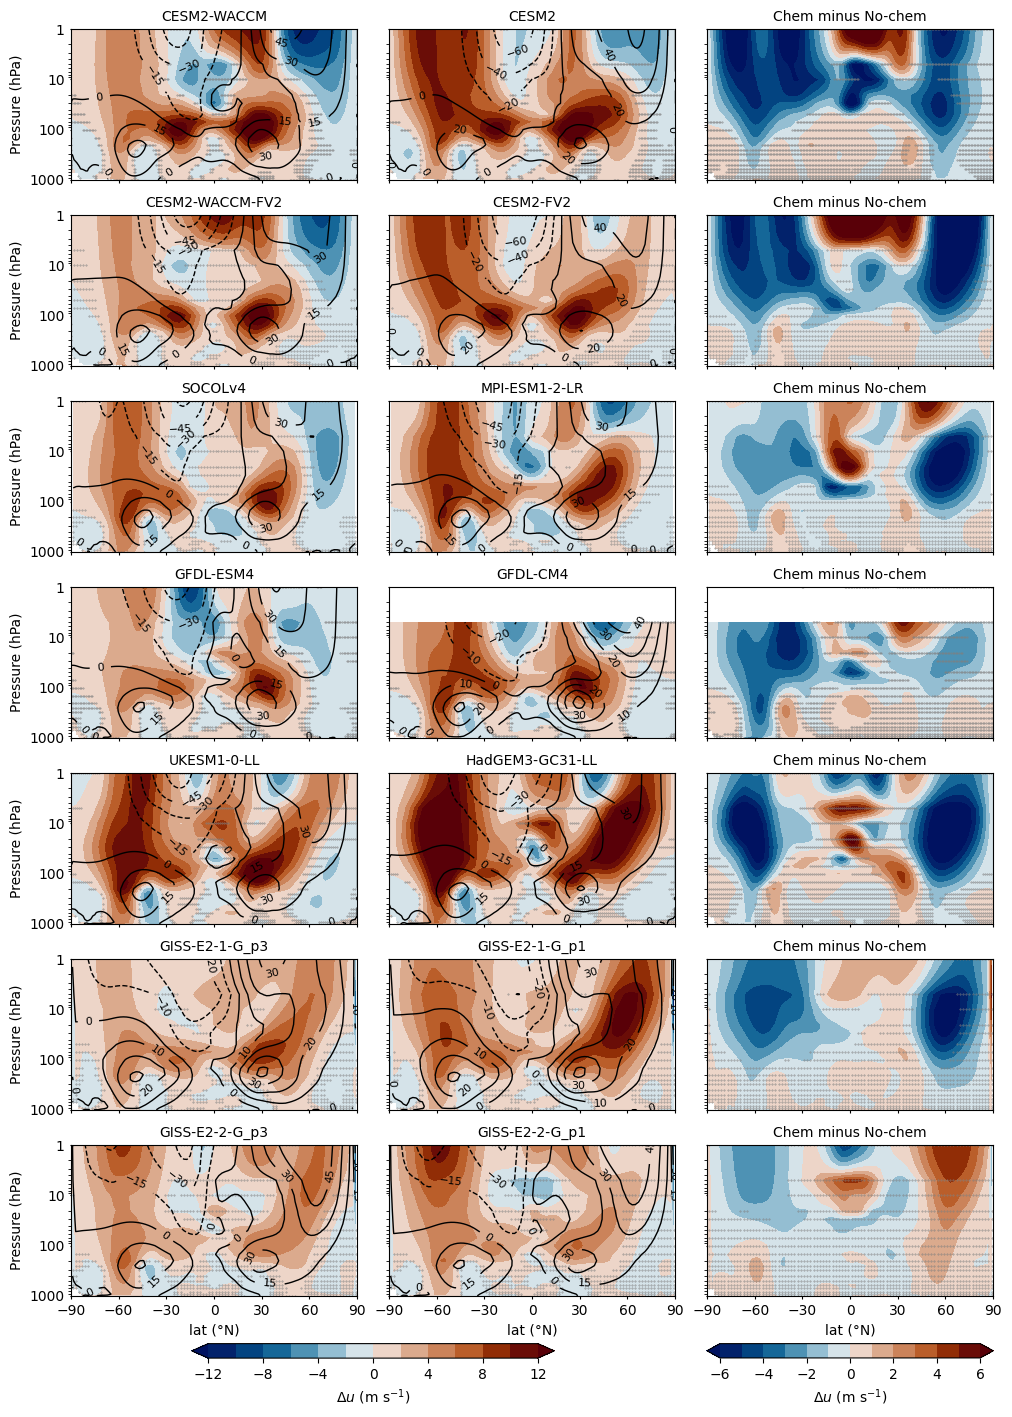

In [99]:
# plot ua DJF single pair comparison

# set the colormap
#cmap = cm.coolwarm
cmap = cmc.vik

fig,axes = plt.subplots(7,3,figsize=(10,14), constrained_layout = True)

for i in range(0,len(chem_pair)):
    idx_chem = pairs.index(chem_pair[i])
    idx_nonchem = pairs.index(nonchem_pair[i])
    print(i)

    for ax in axes.flat:
        ax.set_xlim(-90,90)
        ax.set_ylim(100,10**5)
        ax.set_yscale('log')
        ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
        ax.set_yticks(ticks = [10**5,10**4,10**3,10**2], labels = ["1000","100","10","1"])
        ax.invert_yaxis()
        ax.tick_params(axis='x', labelsize=10, length=2)
        ax.tick_params(axis='y', labelsize=10, length=1)
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
     
    for ax in axes[6,:].flat:
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.set_xlabel("lat (\u00b0N)", fontsize = "medium")
    
    for ax in axes[:,0].flat:
        ax.yaxis.set_tick_params(labelleft=True)
        ax.set_ylabel("Pressure (hPa)", fontsize = "medium" )


    axes[i,0].set_title(pairs[idx_chem][:-1], fontsize = "medium")
    axes[i,1].set_title(pairs[idx_nonchem][:-1], fontsize = "medium")
    axes[i,2].set_title("Chem minus No-chem", fontsize = "medium")

    levels = np.linspace(-12, 12, 13)
    levels_diff = np.linspace(-6, 6, 13)

    cs1 = axes[i,0].contourf(latitude_pair.get(pairs[idx_chem]), press.get(pairs[0]),\
                        ua_zm_ymonmean_DJF_diff_4CO2.get(pairs[idx_chem]),\
                        corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap, levels = levels, extend = "both")
    cs11 = axes[i,0].contour(latitude_pair.get(pairs[idx_chem]), press.get(pairs[0]),\
                          ua_zm_ymonmean_DJF_piControl.get(pairs[idx_chem]),\
                           colors='k', linewidths = 1)
    axes[i,0].clabel(cs11, inline=True,fontsize = 8)
    
    cs2 = axes[i,1].contourf(latitude_pair.get(pairs[idx_nonchem]), press.get(pairs[0]),\
                        ua_zm_ymonmean_DJF_diff_4CO2.get(pairs[idx_nonchem]),\
                        corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap, levels = levels, extend = "both")
    cs21 = axes[i,1].contour(latitude_pair.get(pairs[idx_nonchem]), press.get(pairs[0]),\
                          ua_zm_ymonmean_DJF_piControl.get(pairs[idx_nonchem]),\
                           colors='k', linewidths = 1)
    axes[i,1].clabel(cs21, inline=True,fontsize = 8)
    
    cs3 = axes[i,2].contourf(latitude_pair.get(pairs[idx_chem]), press.get(pairs[0]),\
                        ua_zm_ymonmean_DJF_diff_4CO2.get(pairs[idx_chem])-\
                        ua_zm_ymonmean_DJF_diff_4CO2.get(pairs[idx_nonchem]),\
                        corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap, levels = levels_diff, extend = "both")
    
    # scatter plot for t-test
    axes[i,0].scatter(latitude_pair.get(pairs[idx_chem])[strip_pair_chem_lat.get(pairs[idx_chem])],\
                press.get(pairs[idx_chem])[strip_pair_chem_press.get(pairs[idx_chem])],\
                marker = '.', s=0.5, c='grey')

    axes[i,1].scatter(latitude_pair.get(pairs[idx_nonchem])[strip_pair_nonchem_lat.get(pairs[idx_nonchem])],\
                press.get(pairs[idx_nonchem])[strip_pair_nonchem_press.get(pairs[idx_nonchem])],\
                marker = '.', s=0.5, c='grey')
    
    axes[i,2].scatter(latitude_pair.get(pairs[idx_chem])[strip_pair_diff_lat.get(pairs[idx_chem])],\
                press.get(pairs[idx_chem])[strip_pair_diff_press.get(pairs[idx_chem])],\
                marker = '.', s=0.5, c='grey')
    
plt.colorbar(cs1, ax=axes[i,0:2].ravel().tolist(),label = r"$\Delta u$ (m s$^{-1}$)",\
                orientation = 'horizontal', aspect = 25, shrink = 0.6)
plt.colorbar(cs3, ax=axes[i,2],label = r"$\Delta u$ (m s$^{-1}$)",orientation = 'horizontal')

fig.savefig('../Output/paper/'+species+'_DJF_reldiff_tm_zm_4CO2_last100yr_single_pair.pdf',\
            bbox_inches = "tight", dpi = 300)

In [100]:
# average of pairs

# read in zm multiyear-monthly-mean non-chem ua data

ua_zm_ymonmean_piControl_remap_masked = dict()
ua_zm_ymonmean_4CO2_remap_masked = dict()
ua_zm_monmean_remap_piControl_masked = dict()
ua_zm_monmean_remap_4CO2_masked = dict()

ua_zm_ymonmean_DJF_remap_piControl = dict()
ua_zm_ymonmean_DJF_remap_4CO2= dict()
ua_zm_monmean_DJF_remap_piControl = dict()
ua_zm_monmean_DJF_remap_4CO2 = dict()

ua_zm_ymonmean_DJF_diff_remap_4CO2 = dict()
ua_zm_monmean_DJF_diff_remap_4CO2 = dict()

species = "ua"
path_ua_zm_monmean_remap = "../data/chem_nonchem/ua/zm_monmean/"
path_ua_zm_ymonmean_remap = "../data/chem_nonchem/ua/zm_ymonmean/"

# read in am_zm remap data for t-test
for i in range(0,len(pairs)): 
    for f in os.listdir(path_ua_zm_monmean_remap):
        if os.path.isfile(os.path.join(path_ua_zm_monmean_remap,f)) and (pairs[i] in f): 
            if experiment[0] in f:
                if pairs[i] != "SOCOLv4_":
                    zm_remap_piControl = nc.Dataset(os.path.join(path_ua_zm_monmean_remap,f)).variables[species][:,:,:,0]
                    ua_zm_monmean_remap_piControl_masked[pairs[i]] = ma.masked_values(zm_remap_piControl, 1e20)
                elif "verinterpolate" in f:
                    zm_remap_piControl = nc.Dataset(os.path.join(path_ua_zm_monmean_remap,f)).variables[species][:]
                    ua_zm_monmean_remap_piControl_masked[pairs[i]] = ma.masked_values(zm_remap_piControl, 1e20)
                
                nplev = np.shape(ua_zm_monmean_remap_piControl_masked.get(pairs[i]))[1]
                nlat = np.shape(ua_zm_monmean_remap_piControl_masked.get(pairs[i]))[2]
                nyear = np.shape(ua_zm_monmean_remap_piControl_masked.get(pairs[i]))[0]//12
                
                # compute yearly seasonal mean
                DJF = np.zeros((nyear,nplev,nlat))
                
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_remap_piControl_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_zm_monmean_DJF_remap_piControl[pairs[i]] = DJF
                print("pi",pairs[i],np.shape(ua_zm_monmean_DJF_remap_piControl.get(pairs[i])))
            
            if experiment[1] in f and ("last100yr" in f):
                if pairs[i] != "SOCOLv4_":
                    zm_remap_4CO2 = nc.Dataset(os.path.join(path_ua_zm_monmean_remap,f)).variables[species][:,:,:,0]
                    ua_zm_monmean_remap_4CO2_masked[pairs[i]] = ma.masked_values(zm_remap_4CO2, 1e20)
                elif "verinterpolate" in f:
                    zm_remap_4CO2 = nc.Dataset(os.path.join(path_ua_zm_monmean_remap,f)).variables[species][:]
                    ua_zm_monmean_remap_4CO2_masked[pairs[i]] = ma.masked_values(zm_remap_4CO2, 1e20)
                
                nplev = np.shape(ua_zm_monmean_remap_4CO2_masked.get(pairs[i]))[1]
                nlat = np.shape(ua_zm_monmean_remap_4CO2_masked.get(pairs[i]))[2]
                nyear = np.shape(ua_zm_monmean_remap_4CO2_masked.get(pairs[i]))[0]//12
                
                # compute yearly seasonal mean
                DJF = np.zeros((nyear,nplev,nlat))
                
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_remap_4CO2_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_zm_monmean_DJF_remap_4CO2[pairs[i]] = DJF
                print("4CO2",pairs[i],np.shape(ua_zm_monmean_DJF_remap_4CO2.get(pairs[i])))

# read in zm-ymonmean remap data
for i in range(0,len(pairs)): 
    for f in os.listdir(path_ua_zm_ymonmean_remap):
        if os.path.isfile(os.path.join(path_ua_zm_ymonmean_remap,f)) and (pairs[i] in f):
            if experiment[0] in f:
                print(pairs[i])
                zm_ymonmean_ua_piControl = nc.Dataset(os.path.join(path_ua_zm_ymonmean_remap,f))
                if pairs[i]!= "SOCOLv4_":
                    ua_zm_ymonmean_piControl = zm_ymonmean_ua_piControl.variables[species][:,:,:,0]
                    ua_zm_ymonmean_piControl_remap_masked[pairs[i]] = ma.masked_values (ua_zm_ymonmean_piControl, 1e20)
                elif "verinterpolate" in f:
                    ua_zm_ymonmean_piControl = zm_ymonmean_ua_piControl.variables[species][:]
                    ua_zm_ymonmean_piControl_remap_masked[pairs[i]] = ma.masked_values (ua_zm_ymonmean_piControl, 1e20)
                latitude_remap[pairs[i]] = zm_ymonmean_ua_piControl.variables["lat"][:]
                press_remap[pairs[i]] = zm_ymonmean_ua_piControl.variables["plev"][:]
                ua_zm_ymonmean_DJF_remap_piControl[pairs[i]] = \
                ma.mean(ua_zm_ymonmean_piControl_remap_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                print("pi",pairs[i],np.shape(ua_zm_ymonmean_DJF_remap_piControl.get(pairs[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                print(pairs[i])
                zm_ymonmean_ua_4CO2 = nc.Dataset(os.path.join(path_ua_zm_ymonmean_remap,f))
                if pairs[i] != "SOCOLv4_":
                    ua_zm_ymonmean_4CO2 = zm_ymonmean_ua_4CO2.variables[species][:,:,:,0]
                    ua_zm_ymonmean_4CO2_remap_masked[pairs[i]] = ma.masked_values (ua_zm_ymonmean_4CO2, 1e20)
                elif "verinterpolate" in f:
                    ua_zm_ymonmean_4CO2 = zm_ymonmean_ua_4CO2.variables[species][:]
                    ua_zm_ymonmean_4CO2_remap_masked[pairs[i]] = ma.masked_values (ua_zm_ymonmean_4CO2, 1e20)
                ua_zm_ymonmean_DJF_remap_4CO2[pairs[i]] = \
                ma.mean(ua_zm_ymonmean_4CO2_remap_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                print("4CO2",pairs[i],np.shape(ua_zm_ymonmean_DJF_remap_4CO2.get(pairs[i])))
                
# compute relative diff
for i in range(0,len(pairs)):
    print(pairs[i])
    # compute the relative difference 
    ua_zm_ymonmean_DJF_diff_remap_4CO2[pairs[i]] = \
    ua_zm_ymonmean_DJF_remap_4CO2.get(pairs[i]) - ua_zm_ymonmean_DJF_remap_piControl.get(pairs[i])
    print("4CO2",pairs[i],np.shape(ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[i])))
    
    ua_zm_monmean_DJF_diff_remap_4CO2[pairs[i]] = \
    ua_zm_monmean_DJF_remap_4CO2.get(pairs[i]) - \
    ua_zm_monmean_DJF_remap_piControl.get(pairs[i])[-np.shape(ua_zm_monmean_DJF_remap_4CO2.get(pairs[i]))[0]:]
    print("4CO2",pairs[i],np.shape(ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[i])))
    
# set NAN in GFDL-CM4 to 0
ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[-4])[18,:] = 0
ua_zm_ymonmean_DJF_remap_piControl.get(pairs[-4])[18,:] = 0

4CO2 CESM2-WACCM_ (100, 19, 192)
pi CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM-FV2_ (100, 19, 192)
pi CESM2-WACCM-FV2_ (150, 19, 192)
pi SOCOLv4_ (150, 19, 192)
4CO2 SOCOLv4_ (100, 19, 192)
4CO2 GFDL-ESM4_ (100, 19, 192)
pi GFDL-ESM4_ (150, 19, 192)
4CO2 UKESM1-0-LL_ (100, 19, 192)
pi UKESM1-0-LL_ (150, 19, 192)
4CO2 GISS-E2-1-G_p3_ (150, 19, 192)
pi GISS-E2-1-G_p3_ (150, 19, 192)
pi GISS-E2-2-G_p3_ (150, 19, 192)
4CO2 GISS-E2-2-G_p3_ (100, 19, 192)
4CO2 CESM2_ (100, 19, 192)
pi CESM2_ (150, 19, 192)
4CO2 CESM2-FV2_ (100, 19, 192)
pi CESM2-FV2_ (150, 19, 192)
4CO2 MPI-ESM1-2-LR_ (100, 19, 192)
pi MPI-ESM1-2-LR_ (150, 19, 192)
4CO2 GFDL-CM4_ (100, 19, 192)
pi GFDL-CM4_ (150, 19, 192)
4CO2 HadGEM3-GC31-LL_ (100, 19, 192)
pi HadGEM3-GC31-LL_ (150, 19, 192)
4CO2 GISS-E2-1-G_p1_ (150, 19, 192)
pi GISS-E2-1-G_p1_ (150, 19, 192)
4CO2 GISS-E2-2-G_p1_ (100, 19, 192)
pi GISS-E2-2-G_p1_ (150, 19, 192)
CESM2-WACCM_
4CO2 CESM2-WACCM_ (19, 192)
CESM2-WACCM_
pi CESM2-WACCM_ (19, 192)
CESM2-WACCM-FV

In [101]:
# be mindful of repeated run --> add on sum

pairs_chem_pi_sum = np.zeros((1,19,192))
pairs_nonchem_pi_sum = np.zeros((1,19,192))
pairs_chem_sum = np.zeros((1,19,192))
pairs_nonchem_sum = np.zeros((1,19,192))

# concatenate arrays for t-test 

pairs_chem_pi_sum = ua_zm_ymonmean_DJF_remap_piControl.get(pairs[0])
pairs_nonchem_pi_sum = ua_zm_ymonmean_DJF_remap_piControl.get(pairs[len(chem_pair)])
pairs_chem_sum = ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[0])
pairs_nonchem_sum = ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[len(chem_pair)])
pairs_chem_avg_pi = ua_zm_monmean_DJF_remap_piControl.get(pairs[0])
pairs_nonchem_avg_pi = ua_zm_monmean_DJF_remap_piControl.get(pairs[len(chem_pair)])
pairs_chem_avg_4CO2 = ua_zm_monmean_DJF_remap_4CO2.get(pairs[0])
pairs_nonchem_avg_4CO2 = ua_zm_monmean_DJF_remap_4CO2.get(pairs[len(chem_pair)])
pairs_diff_chem_avg = ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[0])
pairs_diff_nonchem_avg = ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[len(chem_pair)])

for i in range(1,len(chem_pair)):
    print(pairs[i])
    pairs_chem_pi_sum += ua_zm_ymonmean_DJF_remap_piControl.get(pairs[i])
    pairs_nonchem_pi_sum += ua_zm_ymonmean_DJF_remap_piControl.get(pairs[len(chem_pair)+i])
    pairs_chem_sum += ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[i])
    pairs_nonchem_sum += ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[len(chem_pair)+i])
    pairs_chem_avg_pi = \
    np.concatenate((pairs_chem_avg_pi,ua_zm_monmean_DJF_remap_piControl.get(pairs[i])))
    pairs_chem_avg_4CO2 = \
    np.concatenate((pairs_chem_avg_4CO2,ua_zm_monmean_DJF_remap_4CO2.get(pairs[i])))
    pairs_nonchem_avg_pi = \
    np.concatenate((pairs_nonchem_avg_pi,ua_zm_monmean_DJF_remap_piControl.get(pairs[len(chem_pair)+i])))
    pairs_nonchem_avg_4CO2 = \
    np.concatenate((pairs_nonchem_avg_4CO2,ua_zm_monmean_DJF_remap_4CO2.get(pairs[len(chem_pair)+i])))
    pairs_diff_chem_avg = \
    np.concatenate((pairs_diff_chem_avg,ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[i])))
    pairs_diff_nonchem_avg = \
    np.concatenate((pairs_diff_nonchem_avg,ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[len(chem_pair)+i])))

# compute avg
pairs_chem_avg = np.zeros((19,192))
pairs_nonchem_avg = np.zeros((19,192))
pairs_chem_pi_avg = np.zeros((19,192))
pairs_nonchem_pi_avg = np.zeros((19,192))

pairs_chem_avg = pairs_chem_sum/len(chem_pair)
pairs_chem_pi_avg = pairs_chem_pi_sum/len(chem_pair)

# upper lev has only #len(chem_pair)-1 model data avaiable
pairs_nonchem_avg[0:18,:] = pairs_nonchem_sum[0:18,:]/len(nonchem_pair)
pairs_nonchem_avg[18,:] = pairs_nonchem_sum[18,:]/(len(nonchem_pair)-1)

# prob. with the max of the lowest level: 1e20 (missing data)
pairs_nonchem_pi_avg = pairs_nonchem_pi_sum/len(nonchem_pair)
pairs_nonchem_pi_avg[18,:] = pairs_nonchem_pi_sum[18,:]/(len(nonchem_pair)-1)

# t-test
[stat, p_pair_chem_avg] = stats.ttest_ind(pairs_chem_avg_pi,pairs_chem_avg_4CO2)
[stat, p_pair_nonchem_avg] = stats.ttest_ind(pairs_nonchem_avg_pi,pairs_nonchem_avg_4CO2)
[stat, p_pair_diff_avg] = stats.ttest_ind(pairs_diff_chem_avg,pairs_diff_nonchem_avg)
print(np.shape(p_pair_chem_avg))

strip_pair_chem_avg_lat = np.where(p_pair_chem_avg > 0.005)[1]
strip_pair_chem_avg_press = np.where(p_pair_chem_avg > 0.005)[0]
strip_pair_nonchem_avg_lat = np.where(p_pair_nonchem_avg > 0.005)[1]
strip_pair_nonchem_avg_press = np.where(p_pair_nonchem_avg > 0.005)[0]
strip_pair_diff_avg_lat = np.where(p_pair_diff_avg > 0.005)[1]
strip_pair_diff_avg_press = np.where(p_pair_diff_avg > 0.005)[0]

CESM2-WACCM-FV2_
SOCOLv4_
GFDL-ESM4_
UKESM1-0-LL_
GISS-E2-1-G_p3_
GISS-E2-2-G_p3_
(19, 192)


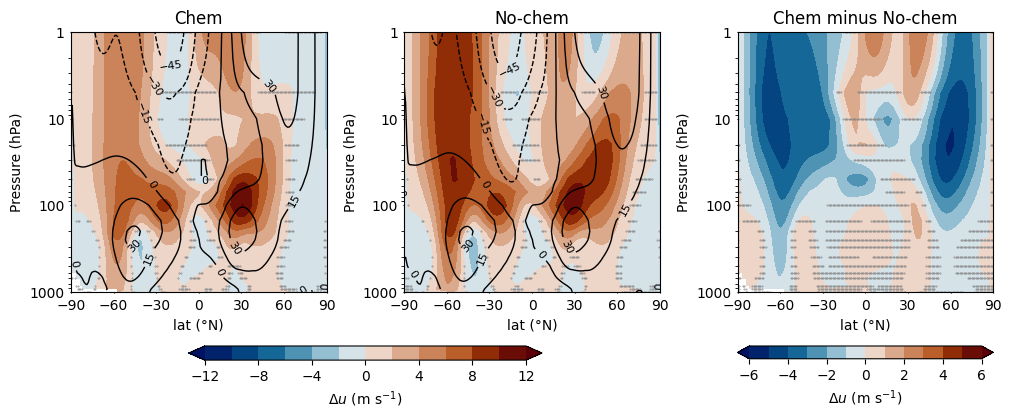

In [102]:
# plot multi-model average

fig,axes = plt.subplots(1,3,figsize=(10,4), constrained_layout = True)
for ax in axes.flat:
    ax.set_xlim(-90,90)
    ax.set_ylim(100,10**5)
    ax.set_yscale('log')
    ax.set_xticks(ticks = [-90,-60,-30,0,30,60,90])
    ax.set_yticks(ticks = [10**5,10**4,10**3,10**2], labels = ["1000","100","10","1"])
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelsize=10, length=1)
    ax.tick_params(axis='y', labelsize=10, length=1)
    ax.set_xlabel("lat (\u00b0N)", fontsize = "medium")
    ax.set_ylabel("Pressure (hPa)", fontsize = "medium" )

axes[0].set_title("Chem", fontsize = "large")
axes[1].set_title("No-chem", fontsize = "large")
axes[2].set_title("Chem minus No-chem", fontsize = "large")

levels = np.linspace(-12, 12, 13)
levels_diff = np.linspace(-6, 6, 13)

cs1 = axes[0].contourf(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
                    pairs_chem_avg, corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap, levels = levels, extend = "both")
cs11 = axes[0].contour(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
                    pairs_chem_pi_avg,colors='k', linewidths = 1)
axes[0].clabel(cs11, inline=True,fontsize = 8)

cs2 = axes[1].contourf(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
                    pairs_nonchem_avg,corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap, levels = levels, extend = "both")
cs21 = axes[1].contour(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
                    pairs_nonchem_pi_avg,colors='k', linewidths = 1)
axes[1].clabel(cs21, inline=True,fontsize = 8)

cs3 = axes[2].contourf(latitude_remap.get(pairs[0]), press_remap.get(pairs[0]),\
                    pairs_chem_avg - pairs_nonchem_avg,\
                    corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap, levels = levels_diff, extend = "both")

axes[0].scatter(latitude_remap.get(pairs[0])[strip_pair_chem_avg_lat],\
                press_remap.get(pairs[0])[strip_pair_chem_avg_press],\
                marker = '.', s=0.5, c='grey')
axes[1].scatter(latitude_remap.get(pairs[0])[strip_pair_nonchem_avg_lat],\
                press_remap.get(pairs[0])[strip_pair_nonchem_avg_press],\
                marker = '.', s=0.5, c='grey')
axes[2].scatter(latitude_remap.get(pairs[0])[strip_pair_diff_avg_lat],\
                press_remap.get(pairs[0])[strip_pair_diff_avg_press],\
                marker = '.', s=0.5, c='grey')

plt.colorbar(cs1, ax=axes[0:2].ravel().tolist(),label = r"$\Delta u$ (m s$^{-1}$)",\
                orientation = 'horizontal', aspect = 25, shrink = 0.6)
plt.colorbar(cs3, ax=axes[2],label = r"$\Delta u$ (m s$^{-1}$)",orientation = 'horizontal')
fig.savefig('../Output/paper/'+species+'_DJF_reldiff_tm_zm_4CO2_last100yr_avg.pdf', bbox_inches = "tight", dpi = 300)

In [103]:
# read in zm_monmean ua data

ua_zm_monmean_piControl_masked = dict()
ua_zm_monmean_4CO2_masked = dict()

ua_zm_monmean_DJF_piControl = dict()
ua_zm_monmean_DJF_4CO2 = dict()

species = "ua"
path_ua_zm_monmean = "../data/ua/zm_monmean/"

for i in range(0,len(pairs)): 
    for f in os.listdir(path_ua_zm_monmean):
        if os.path.isfile(os.path.join(path_ua_zm_monmean,f)) and (pairs[i] in f):
            if experiment[0] in f:
                print(pairs[i])
                zm_monmean_ua_piControl = nc.Dataset(os.path.join(path_ua_zm_monmean,f))
                if pairs[i] != "SOCOLv4_":
                    ua_zm_monmean_piControl = zm_monmean_ua_piControl.variables[species][:,:,:,0]
                    ua_zm_monmean_piControl_masked[pairs[i]] = ma.masked_values (ua_zm_monmean_piControl, 1e20)
                elif "verinterpolate" in f:
                    ua_zm_monmean_piControl = zm_monmean_ua_piControl.variables[species][:]
                
                ua_zm_monmean_piControl_masked[pairs[i]] = ma.masked_values (ua_zm_monmean_piControl, 1e20)
                print("pi",pairs[i],np.shape(ua_zm_monmean_piControl_masked.get(pairs[i])))
                nplev = np.shape(ua_zm_monmean_piControl_masked.get(pairs[i]))[1]
                nlat = np.shape(ua_zm_monmean_piControl_masked.get(pairs[i]))[2]
                nyear = np.shape(ua_zm_monmean_piControl_masked.get(pairs[i]))[0]//12
                
                # compute yearly seasonal mean
                DJF = np.zeros((nyear,nplev,nlat))
                
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_piControl_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_zm_monmean_DJF_piControl[pairs[i]] = DJF
                print("pi DJF",pairs[i],np.shape(ua_zm_monmean_DJF_piControl.get(pairs[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                zm_monmean_ua_4CO2 = nc.Dataset(os.path.join(path_ua_zm_monmean,f))
                if pairs[i] != "SOCOLv4_":
                    ua_zm_monmean_4CO2 = zm_monmean_ua_4CO2.variables[species][:,:,:,0]
                    ua_zm_monmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_monmean_4CO2, 1e20)
                elif "verinterpolate" in f:
                    ua_zm_monmean_4CO2 = zm_monmean_ua_4CO2.variables[species][:]
                
                ua_zm_monmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_zm_monmean_4CO2, 1e20)
                print("4CO2",pairs[i],np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i])))
                
                # compute yearly seasonal mean
                nyear = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[0]//12
                nplev = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[1]
                nlat = np.shape(ua_zm_monmean_4CO2_masked.get(pairs[i]))[2]
                DJF = np.zeros((nyear,nplev,nlat))
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_zm_monmean_4CO2_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_zm_monmean_DJF_4CO2[pairs[i]] = DJF
                print("4CO2 DJF",pairs[i],np.shape(ua_zm_monmean_DJF_4CO2.get(pairs[i])))
    

CESM2-WACCM_
pi CESM2-WACCM_ (1800, 19, 192)
pi DJF CESM2-WACCM_ (150, 19, 192)
4CO2 CESM2-WACCM_ (1200, 19, 192)
4CO2 DJF CESM2-WACCM_ (100, 19, 192)
4CO2 CESM2-WACCM-FV2_ (1200, 19, 96)
4CO2 DJF CESM2-WACCM-FV2_ (100, 19, 96)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (1800, 19, 96)
pi DJF CESM2-WACCM-FV2_ (150, 19, 96)
4CO2 SOCOLv4_ (1200, 19, 96)
4CO2 DJF SOCOLv4_ (100, 19, 96)
4CO2 SOCOLv4_ (1200, 19, 96)
4CO2 DJF SOCOLv4_ (100, 19, 96)
SOCOLv4_
pi SOCOLv4_ (1800, 19, 96)
pi DJF SOCOLv4_ (150, 19, 96)
SOCOLv4_
pi SOCOLv4_ (1800, 19, 96)
pi DJF SOCOLv4_ (150, 19, 96)
4CO2 GFDL-ESM4_ (1200, 19, 180)
4CO2 DJF GFDL-ESM4_ (100, 19, 180)
GFDL-ESM4_
pi GFDL-ESM4_ (1800, 19, 180)
pi DJF GFDL-ESM4_ (150, 19, 180)
4CO2 UKESM1-0-LL_ (1200, 19, 145)
4CO2 DJF UKESM1-0-LL_ (100, 19, 145)
UKESM1-0-LL_
pi UKESM1-0-LL_ (1800, 19, 145)
pi DJF UKESM1-0-LL_ (150, 19, 145)
4CO2 GISS-E2-1-G_p3_ (1200, 19, 90)
4CO2 DJF GISS-E2-1-G_p3_ (100, 19, 90)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (1800, 19, 90)
pi DJF GISS

The following cells comapre wtem in tropics (20S-20N) at 70hPa

The following compute and plot seasonal climatology of ua at 850hPa for chem and non-chem comparison.

In [104]:
# read in ymonmean ua data at 850hPa

ua_850_ymonmean_piControl_masked = dict()
ua_850_ymonmean_4CO2_masked = dict()
ua_850_ymonmean_DJF_piControl = dict()
ua_850_ymonmean_DJF_4CO2 = dict()

latitude_pair = dict()
longitude_pair = dict()

species = "ua"
path_ua_850_ymonmean = "../data/chem_nonchem/ua/850/ymonmean/"

for i in range(0,len(pairs)): 
    for f in os.listdir(path_ua_850_ymonmean):
        if os.path.isfile(os.path.join(path_ua_850_ymonmean,f)) and (pairs[i] in f):
            if experiment[0] in f:
                print(pairs[i])
                #if pairs[i] != "SOCOLv4_":
                ua_850_ymonmean_piControl = nc.Dataset(os.path.join(path_ua_850_ymonmean,f)).variables[species][:,0,:,:]
                ua_850_ymonmean_piControl_masked[pairs[i]] = ma.masked_values(ua_850_ymonmean_piControl,1e20)
                ua_850_ymonmean_DJF_piControl[pairs[i]] = \
                    ma.mean(ua_850_ymonmean_piControl_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                #elif "verinterpolate" in f:
                    #ua_850_ymonmean_piControl = nc.Dataset(os.path.join(path_ua_850_ymonmean,f)).variables[species][:]
                    #ua_850_ymonmean_piControl_masked[pairs[i]] = ma.masked_values(ua_850_ymonmean_piControl,1e20)
                    #ua_850_ymonmean_DJF_piControl[pairs[i]] = \
                    #    ma.mean(ua_850_ymonmean_piControl_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                latitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ua_850_ymonmean,f)).variables["lat"][:]
                longitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ua_850_ymonmean,f)).variables["lon"][:]
                print("pi",pairs[i],np.shape(ua_850_ymonmean_DJF_piControl.get(pairs[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                print(pairs[i])
                #if pairs[i] != "SOCOLv4_":
                ua_850_ymonmean_4CO2 = nc.Dataset(os.path.join(path_ua_850_ymonmean,f)).variables[species][:,0,:,:]
                ua_850_ymonmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_850_ymonmean_4CO2, 1e20)
                ua_850_ymonmean_DJF_4CO2[pairs[i]] = \
                    ma.mean(ua_850_ymonmean_4CO2_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                #elif "verinterpolate" in f:
                    #ua_850_ymonmean_4CO2 = nc.Dataset(os.path.join(path_ua_850_ymonmean,f)).variables[species][:]
                    #ua_850_ymonmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_850_ymonmean_4CO2, 1e20)
                    #ua_850_ymonmean_DJF_4CO2[pairs[i]] = \
                    #    ma.mean(ua_850_ymonmean_4CO2_masked.get(pairs[i])[np.r_[-1:2],:,:],axis=0)
                latitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ua_850_ymonmean,f)).variables["lat"][:]
                longitude_pair[pairs[i]] = nc.Dataset(os.path.join(path_ua_850_ymonmean,f)).variables["lon"][:]
                print("4CO2",pairs[i],np.shape(ua_850_ymonmean_DJF_4CO2.get(pairs[i])))

CESM2-WACCM_
pi CESM2-WACCM_ (192, 288)
CESM2-WACCM_
4CO2 CESM2-WACCM_ (192, 288)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (192, 288)
CESM2-WACCM-FV2_
4CO2 CESM2-WACCM-FV2_ (192, 288)
SOCOLv4_
4CO2 SOCOLv4_ (192, 288)
SOCOLv4_
pi SOCOLv4_ (192, 288)
GFDL-ESM4_
pi GFDL-ESM4_ (192, 288)
GFDL-ESM4_
4CO2 GFDL-ESM4_ (192, 288)
UKESM1-0-LL_
pi UKESM1-0-LL_ (192, 288)
UKESM1-0-LL_
4CO2 UKESM1-0-LL_ (192, 288)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (192, 288)
GISS-E2-1-G_p3_
4CO2 GISS-E2-1-G_p3_ (192, 288)
GISS-E2-2-G_p3_
4CO2 GISS-E2-2-G_p3_ (192, 288)
GISS-E2-2-G_p3_
pi GISS-E2-2-G_p3_ (192, 288)
CESM2_
pi CESM2_ (192, 288)
CESM2_
4CO2 CESM2_ (192, 288)
CESM2-FV2_
pi CESM2-FV2_ (192, 288)
CESM2-FV2_
4CO2 CESM2-FV2_ (192, 288)
MPI-ESM1-2-LR_
pi MPI-ESM1-2-LR_ (192, 288)
MPI-ESM1-2-LR_
4CO2 MPI-ESM1-2-LR_ (192, 288)
GFDL-CM4_
pi GFDL-CM4_ (192, 288)
GFDL-CM4_
4CO2 GFDL-CM4_ (180, 288)
GFDL-CM4_
4CO2 GFDL-CM4_ (192, 288)
GFDL-CM4_
pi GFDL-CM4_ (192, 288)
HadGEM3-GC31-LL_
4CO2 HadGEM3-GC31-LL_ (192, 288

In [105]:
# read in monmean ua data at 850hPa

ua_850_monmean_piControl_masked = dict()
ua_850_monmean_4CO2_masked = dict()

ua_850_monmean_DJF_piControl = dict()
ua_850_monmean_DJF_4CO2 = dict()

species = "ua"
path_ua_850_monmean = "../data/chem_nonchem/ua/850/monmean/"

for i in range(0,len(pairs)): 
    for f in os.listdir(path_ua_850_monmean):
        if os.path.isfile(os.path.join(path_ua_850_monmean,f)) and (pairs[i] in f):
            if experiment[0] in f:
                print(pairs[i])
                monmean_ua_piControl = nc.Dataset(os.path.join(path_ua_850_monmean,f))
                if pairs[i] != "SOCOLv4_":
                    ua_850_monmean_piControl = monmean_ua_piControl.variables[species][:,0,:,:]
                    ua_850_monmean_piControl_masked[pairs[i]] = ma.masked_values (ua_850_monmean_piControl, 1e20)
                elif "verinterpolate" in f:
                    ua_850_monmean_piControl = monmean_ua_piControl.variables[species][:]
                
                ua_850_monmean_piControl_masked[pairs[i]] = ma.masked_values (ua_850_monmean_piControl, 1e20)
                print("pi",pairs[i],np.shape(ua_850_monmean_piControl_masked.get(pairs[i])))
                nlon = np.shape(ua_850_monmean_piControl_masked.get(pairs[i]))[2]
                nlat = np.shape(ua_850_monmean_piControl_masked.get(pairs[i]))[1]
                nyear = np.shape(ua_850_monmean_piControl_masked.get(pairs[i]))[0]//12
                
                # compute yearly seasonal mean
                DJF = np.zeros((nyear,nlat,nlon))
                
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_850_monmean_piControl_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_850_monmean_DJF_piControl[pairs[i]] = DJF
                print("pi DJF",pairs[i],np.shape(ua_850_monmean_DJF_piControl.get(pairs[i])))
            
            elif experiment[1] in f and ("last100yr" in f):
                monmean_ua_4CO2 = nc.Dataset(os.path.join(path_ua_850_monmean,f))
                if pairs[i] != "SOCOLv4_":
                    ua_850_monmean_4CO2 = monmean_ua_4CO2.variables[species][:,0,:,:]
                    ua_850_monmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_850_monmean_4CO2, 1e20)
                elif "verinterpolate" in f:
                    ua_850_monmean_4CO2 = monmean_ua_4CO2.variables[species][:]
                
                ua_850_monmean_4CO2_masked[pairs[i]] = ma.masked_values(ua_850_monmean_4CO2, 1e20)
                print("4CO2",pairs[i],np.shape(ua_850_monmean_4CO2_masked.get(pairs[i])))
                
                # compute yearly seasonal mean
                nyear = np.shape(ua_850_monmean_4CO2_masked.get(pairs[i]))[0]//12
                nlon = np.shape(ua_850_monmean_4CO2_masked.get(pairs[i]))[2]
                nlat = np.shape(ua_850_monmean_4CO2_masked.get(pairs[i]))[1]
                DJF = np.zeros((nyear,nlat,nlon))
                for n in range(0,nyear):
                    DJF[n,:,:] = \
                    ma.mean(ua_850_monmean_4CO2_masked.get(pairs[i])[n*12+11:(n+1)*12+2,:,:],axis=0)
                ua_850_monmean_DJF_4CO2[pairs[i]] = DJF
                print("4CO2 DJF",pairs[i],np.shape(ua_850_monmean_DJF_4CO2.get(pairs[i])))
    

CESM2-WACCM_
pi CESM2-WACCM_ (1800, 192, 288)
pi DJF CESM2-WACCM_ (150, 192, 288)
4CO2 CESM2-WACCM_ (1200, 192, 288)
4CO2 DJF CESM2-WACCM_ (100, 192, 288)
CESM2-WACCM-FV2_
pi CESM2-WACCM-FV2_ (1800, 192, 288)
pi DJF CESM2-WACCM-FV2_ (150, 192, 288)
4CO2 CESM2-WACCM-FV2_ (1200, 192, 288)
4CO2 DJF CESM2-WACCM-FV2_ (100, 192, 288)
SOCOLv4_
pi SOCOLv4_ (1800, 192, 288)
pi DJF SOCOLv4_ (150, 192, 288)
4CO2 SOCOLv4_ (1200, 192, 288)
4CO2 DJF SOCOLv4_ (100, 192, 288)
GFDL-ESM4_
pi GFDL-ESM4_ (1800, 192, 288)
pi DJF GFDL-ESM4_ (150, 192, 288)
4CO2 GFDL-ESM4_ (1200, 192, 288)
4CO2 DJF GFDL-ESM4_ (100, 192, 288)
UKESM1-0-LL_
pi UKESM1-0-LL_ (1800, 192, 288)
pi DJF UKESM1-0-LL_ (150, 192, 288)
4CO2 UKESM1-0-LL_ (1200, 192, 288)
4CO2 DJF UKESM1-0-LL_ (100, 192, 288)
4CO2 GISS-E2-1-G_p3_ (1200, 192, 288)
4CO2 DJF GISS-E2-1-G_p3_ (100, 192, 288)
GISS-E2-1-G_p3_
pi GISS-E2-1-G_p3_ (1800, 192, 288)
pi DJF GISS-E2-1-G_p3_ (150, 192, 288)
GISS-E2-2-G_p3_
pi GISS-E2-2-G_p3_ (1800, 192, 288)
pi DJF GISS-E

In [106]:
# compute diff 850hPa ymonmean ua

ua_850_monmean_DJF_diff_4CO2 = dict()

ua_850_ymonmean_DJF_diff_4CO2 = dict()

p_pair_chem = dict()
strip_pair_chem_lat = dict()
strip_pair_chem_lon = dict()

p_pair_nonchem = dict()
strip_pair_nonchem_lat = dict()
strip_pair_nonchem_lon = dict()

p_pair_diff = dict()
strip_pair_diff_lat = dict()
strip_pair_diff_lon = dict()

for i in range(0,len(pairs)):
    print(pairs[i])
    ua_850_monmean_DJF_diff_4CO2[pairs[i]] = \
    ua_850_monmean_DJF_4CO2.get(pairs[i]) - \
    ua_850_monmean_DJF_piControl.get(pairs[i])[-np.shape(ua_850_monmean_DJF_4CO2.get(pairs[i]))[0]:]
    print("4CO2 ua DJF",pairs[i],np.mean(ua_850_monmean_DJF_diff_4CO2.get(pairs[i])))

    ua_850_ymonmean_DJF_diff_4CO2[pairs[i]] = \
    ua_850_ymonmean_DJF_4CO2.get(pairs[i]) - ua_850_ymonmean_DJF_piControl.get(pairs[i])
    print("4CO2 ua tm",pairs[i],np.shape(ua_850_ymonmean_DJF_diff_4CO2.get(pairs[i])))
    
for i in range(0,len(chem_pair)):
    idx_chem = pairs.index(chem_pair[i])
    idx_nonchem = pairs.index(nonchem_pair[i])
    print(pairs[i])
    
    # t-test ua
    [stat, p_pair_chem[pairs[idx_chem]]] = stats.ttest_ind\
    (ua_850_monmean_DJF_4CO2.get(pairs[idx_chem]),\
     ua_850_monmean_DJF_piControl.get(pairs[idx_chem]))
    
    [stat, p_pair_nonchem[pairs[idx_nonchem]]] = stats.ttest_ind\
    (ua_850_monmean_DJF_4CO2.get(pairs[idx_nonchem]),\
     ua_850_monmean_DJF_piControl.get(pairs[idx_nonchem]))
    
    [stat, p_pair_diff[pairs[idx_chem]]] = stats.ttest_ind\
    (ua_850_monmean_DJF_diff_4CO2.get(pairs[idx_chem]),\
     ua_850_monmean_DJF_diff_4CO2.get(pairs[idx_nonchem]))
    
    print(pairs[idx_chem],np.shape(p_pair_diff.get(pairs[idx_chem])))
    
    # find the location which does not satisfy the confidence level at 99%
    strip_pair_chem_lat[pairs[idx_chem]] = np.where(p_pair_chem.get(pairs[idx_chem]) > 0.005)[0]
    strip_pair_chem_lon[pairs[idx_chem]] = np.where(p_pair_chem.get(pairs[idx_chem]) > 0.005)[1]
    
    strip_pair_nonchem_lat[pairs[idx_nonchem]] = np.where(p_pair_nonchem.get(pairs[idx_nonchem]) > 0.005)[0]
    strip_pair_nonchem_lon[pairs[idx_nonchem]] = np.where(p_pair_nonchem.get(pairs[idx_nonchem]) > 0.005)[1]
    
    strip_pair_diff_lat[pairs[idx_chem]] = np.where(p_pair_diff.get(pairs[idx_chem]) > 0.005)[0]
    strip_pair_diff_lon[pairs[idx_chem]] = np.where(p_pair_diff.get(pairs[idx_chem]) > 0.005)[1]       

CESM2-WACCM_
4CO2 ua DJF CESM2-WACCM_ 0.2396592982868085
4CO2 ua tm CESM2-WACCM_ (192, 288)
CESM2-WACCM-FV2_
4CO2 ua DJF CESM2-WACCM-FV2_ 0.1939962162529841
4CO2 ua tm CESM2-WACCM-FV2_ (192, 288)
SOCOLv4_
4CO2 ua DJF SOCOLv4_ 0.1939962162529841
4CO2 ua tm SOCOLv4_ (192, 288)
GFDL-ESM4_
4CO2 ua DJF GFDL-ESM4_ 0.30206328570980867
4CO2 ua tm GFDL-ESM4_ (192, 288)
UKESM1-0-LL_
4CO2 ua DJF UKESM1-0-LL_ 0.27071857676124883
4CO2 ua tm UKESM1-0-LL_ (192, 288)
GISS-E2-1-G_p3_
4CO2 ua DJF GISS-E2-1-G_p3_ 0.1944250614541848
4CO2 ua tm GISS-E2-1-G_p3_ (192, 288)
GISS-E2-2-G_p3_
4CO2 ua DJF GISS-E2-2-G_p3_ 0.2175614785704292
4CO2 ua tm GISS-E2-2-G_p3_ (192, 288)
CESM2_
4CO2 ua DJF CESM2_ 0.41132542031629504
4CO2 ua tm CESM2_ (192, 288)
CESM2-FV2_
4CO2 ua DJF CESM2-FV2_ 0.26741335584588505
4CO2 ua tm CESM2-FV2_ (192, 288)
MPI-ESM1-2-LR_
4CO2 ua DJF MPI-ESM1-2-LR_ 0.19768577567214715
4CO2 ua tm MPI-ESM1-2-LR_ (192, 288)
GFDL-CM4_
4CO2 ua DJF GFDL-CM4_ 0.32664137175384156
4CO2 ua tm GFDL-CM4_ (192, 28

/tmp/ipykernel_19592/2785413754.py:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.25)


0
CESM2-WACCM_
data_chem: 5.719087600708009 -5.108632405598958
CESM2-WACCM_ (192,)
CESM2_
1
CESM2-WACCM-FV2_
data_chem: 4.407417297363282 -4.316510518391927
CESM2-WACCM-FV2_ (192,)
CESM2-FV2_
2
SOCOLv4_
data_chem: 5.1012026468912754 -2.9382489522298174
SOCOLv4_ (192,)
MPI-ESM1-2-LR_
3
GFDL-ESM4_
data_chem: 4.884254773457845 -4.020748138427734
GFDL-ESM4_ (192,)
GFDL-CM4_
4
UKESM1-0-LL_
data_chem: 6.340153217315674 -4.97065544128418
UKESM1-0-LL_ (192,)
HadGEM3-GC31-LL_
5
GISS-E2-1-G_p3_
data_chem: 4.610506375630697 -3.0380705197652182
GISS-E2-1-G_p3_ (192,)
GISS-E2-1-G_p1_
6
GISS-E2-2-G_p3_
data_chem: 7.833456039428711 -3.0374428431193037
GISS-E2-2-G_p3_ (192,)
GISS-E2-2-G_p1_


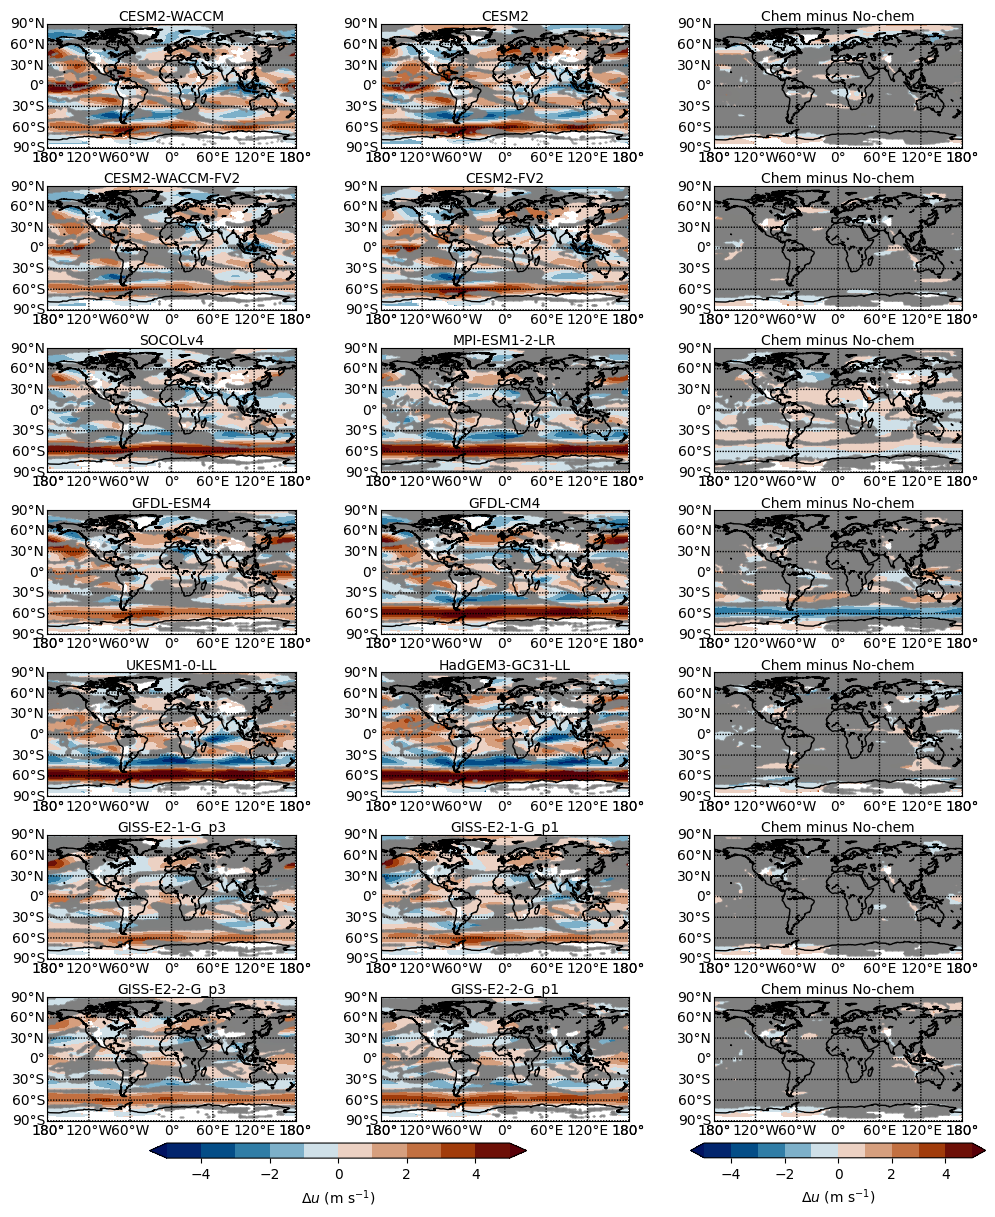

In [107]:
# plot ua DJF 850hPa single pair comparison

y_subtitle = 0.95
labelsize = 8

import cmaps
from matplotlib.colors import ListedColormap
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid

flag_ttest = 1

m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

cmap2 = cmc.vik
norm = mpl.colors.Normalize(vmin=-5, vmax=5)
levels = np.linspace(-5, 5, 11)

fig,axes = plt.subplots(7,3,figsize=(10,12), constrained_layout = True)
plt.subplots_adjust(hspace=0.25)

for i in range(0,len(chem_pair)):
    idx_chem = pairs.index(chem_pair[i])
    idx_nonchem = pairs.index(nonchem_pair[i])
    print(i)
    print(chem_pair[i])
    #shift data lon by -180 to convert from (0,360) to (-180,180)

    ### chem
    data_chem, lons = shiftgrid(180.,ua_850_ymonmean_DJF_diff_4CO2.get(pairs[idx_chem]), \
                                                                       longitude_pair.get(pairs[idx_chem]), start=False)
    
    print("data_chem:", np.max(data_chem), np.min(data_chem))
    lons, lats = np.meshgrid(lons, latitude_pair.get(pairs[idx_chem]))
    x, y = m(lons, lats)
    print(pairs[idx_chem],np.shape(latitude_pair.get(pairs[idx_chem])))
    ax = plt.subplot(7,3,i*3+1)
    ax.set_ylim(-90,90)
    ax.set_title(chem_pair[i][:-1], fontsize = "medium", y = 0.96)

    cs1 = m.contourf(x,y, data_chem, corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap2, levels = levels, extend = "both")
    #cs11 = m.contour(x, y, data_chem, colors='k', linewidths = 1)
    #ax.clabel(cs11, inline=True,fontsize = 8)

    ax.scatter(x[0,strip_pair_chem_lon.get(pairs[idx_chem])],\
                y[strip_pair_chem_lat.get(pairs[idx_chem]),0],\
                marker = '.', s=0.5, c='grey')
    
    m.drawcoastlines(linewidth=1)
    m.drawparallels([-90,-60,-30,0,30,60,90],labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

    ### nonchem
    print(nonchem_pair[i])
    data_nonchem, lons = shiftgrid(180.,ua_850_ymonmean_DJF_diff_4CO2.get(pairs[idx_nonchem]), \
                                                                         longitude_pair.get(pairs[idx_nonchem]), start=False)
    lons, lats = np.meshgrid(lons, latitude_pair.get(pairs[idx_nonchem]))
    x, y = m(lons, lats)
    
    ax = plt.subplot(7,3,i*3+2)
    ax.set_ylim(-90,90)
    ax.set_title(nonchem_pair[i][:-1], fontsize = "medium", y = 0.96)
    
    cs2 = m.contourf(x, y, data_nonchem, corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap2, levels = levels, extend = "both")
    #cs21 = m.contour(x, y, data_nonchem, colors='k', linewidths = 1)
    #ax.clabel(cs21, inline=True,fontsize = 8)

    ax.scatter(x[0,strip_pair_nonchem_lon.get(pairs[idx_nonchem])],\
                y[strip_pair_nonchem_lat.get(pairs[idx_nonchem]),0],\
                marker = '.', s=0.5, c='grey')
    
    m.drawcoastlines(linewidth=1)
    m.drawparallels([-90,-60,-30,0,30,60,90],labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
    
    ### chem-nonchem
    data_diff, lons = shiftgrid(180.,ua_850_ymonmean_DJF_diff_4CO2.get(pairs[idx_chem])-\
                                ua_850_ymonmean_DJF_diff_4CO2.get(pairs[idx_nonchem]),\
                                longitude_pair.get(pairs[idx_chem]), start=False)
    lons, lats = np.meshgrid(lons, latitude_pair.get(pairs[idx_chem]))
    x, y = m(lons, lats)

    ax = plt.subplot(7,3,i*3+3)
    ax.set_ylim(-90,90)
    ax.set_title("Chem minus No-chem", fontsize = "medium", y = 0.96)
    cs3 = ax.contourf(x, y, data_diff,corner_mask = False, norm=colors.CenteredNorm(),\
                        cmap=cmap2, levels = levels, extend = "both")

    ax.scatter(x[0,strip_pair_diff_lon.get(pairs[idx_chem])],\
                y[strip_pair_diff_lat.get(pairs[idx_chem]),0],\
                marker = '.', s=0.5, c='grey')
    
    m.drawcoastlines(linewidth=1)
    m.drawparallels([-90,-60,-30,0,30,60,90],labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
    
plt.colorbar(cs1, ax=axes[i,0:2].ravel().tolist(),label = r"$\Delta u$ (m s$^{-1}$)",\
            orientation = 'horizontal', aspect = 25, shrink = 0.6)
plt.colorbar(cs3, ax=axes[i,2],label = r"$\Delta u$ (m s$^{-1}$)",orientation = 'horizontal')


fig.savefig('../Output/paper/'+species+'_DJF_reldiff_tm_850_4CO2_last100yr_single_pair.pdf',\
            bbox_inches = "tight", dpi = 300)

In [108]:
# be mindful of repeated run --> add on sum

pairs_chem_pi_sum = np.zeros((1,19,192))
pairs_nonchem_pi_sum = np.zeros((1,19,192))
pairs_chem_sum = np.zeros((1,19,192))
pairs_nonchem_sum = np.zeros((1,19,192))

# concatenate arrays for t-test 

pairs_chem_pi_sum = ua_zm_ymonmean_DJF_remap_piControl.get(pairs[0])
pairs_nonchem_pi_sum = ua_zm_ymonmean_DJF_remap_piControl.get(pairs[len(chem_pair)])
pairs_chem_sum = ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[0])
pairs_nonchem_sum = ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[len(chem_pair)])
pairs_chem_avg_pi = ua_zm_monmean_DJF_remap_piControl.get(pairs[0])
pairs_nonchem_avg_pi = ua_zm_monmean_DJF_remap_piControl.get(pairs[len(chem_pair)])
pairs_chem_avg_4CO2 = ua_zm_monmean_DJF_remap_4CO2.get(pairs[0])
pairs_nonchem_avg_4CO2 = ua_zm_monmean_DJF_remap_4CO2.get(pairs[len(chem_pair)])
pairs_diff_chem_avg = ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[0])
pairs_diff_nonchem_avg = ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[len(chem_pair)])

for i in range(1,len(chem_pair)):
    print(pairs[i])
    pairs_chem_pi_sum += ua_zm_ymonmean_DJF_remap_piControl.get(pairs[i])
    pairs_nonchem_pi_sum += ua_zm_ymonmean_DJF_remap_piControl.get(pairs[len(chem_pair)+i])
    pairs_chem_sum += ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[i])
    pairs_nonchem_sum += ua_zm_ymonmean_DJF_diff_remap_4CO2.get(pairs[len(chem_pair)+i])
    pairs_chem_avg_pi = \
    np.concatenate((pairs_chem_avg_pi,ua_zm_monmean_DJF_remap_piControl.get(pairs[i])))
    pairs_chem_avg_4CO2 = \
    np.concatenate((pairs_chem_avg_4CO2,ua_zm_monmean_DJF_remap_4CO2.get(pairs[i])))
    pairs_nonchem_avg_pi = \
    np.concatenate((pairs_nonchem_avg_pi,ua_zm_monmean_DJF_remap_piControl.get(pairs[len(chem_pair)+i])))
    pairs_nonchem_avg_4CO2 = \
    np.concatenate((pairs_nonchem_avg_4CO2,ua_zm_monmean_DJF_remap_4CO2.get(pairs[len(chem_pair)+i])))
    pairs_diff_chem_avg = \
    np.concatenate((pairs_diff_chem_avg,ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[i])))
    pairs_diff_nonchem_avg = \
    np.concatenate((pairs_diff_nonchem_avg,ua_zm_monmean_DJF_diff_remap_4CO2.get(pairs[len(chem_pair)+i])))

# compute avg
pairs_chem_avg = np.zeros((19,192))
pairs_nonchem_avg = np.zeros((19,192))
pairs_chem_pi_avg = np.zeros((19,192))
pairs_nonchem_pi_avg = np.zeros((19,192))

pairs_chem_avg = pairs_chem_sum/len(chem_pair)
pairs_chem_pi_avg = pairs_chem_pi_sum/len(chem_pair)

# upper lev has only #len(chem_pair)-1 model data avaiable
pairs_nonchem_avg[0:18,:] = pairs_nonchem_sum[0:18,:]/len(nonchem_pair)
pairs_nonchem_avg[18,:] = pairs_nonchem_sum[18,:]/(len(nonchem_pair)-1)

# prob. with the max of the lowest level: 1e20 (missing data)
pairs_nonchem_pi_avg = pairs_nonchem_pi_sum/len(nonchem_pair)
pairs_nonchem_pi_avg[18,:] = pairs_nonchem_pi_sum[18,:]/(len(nonchem_pair)-1)

# t-test
[stat, p_pair_chem_avg] = stats.ttest_ind(pairs_chem_avg_pi,pairs_chem_avg_4CO2)
[stat, p_pair_nonchem_avg] = stats.ttest_ind(pairs_nonchem_avg_pi,pairs_nonchem_avg_4CO2)
[stat, p_pair_diff_avg] = stats.ttest_ind(pairs_diff_chem_avg,pairs_diff_nonchem_avg)
print(np.shape(p_pair_chem_avg))

strip_pair_chem_avg_lat = np.where(p_pair_chem_avg > 0.005)[1]
strip_pair_chem_avg_press = np.where(p_pair_chem_avg > 0.005)[0]
strip_pair_nonchem_avg_lat = np.where(p_pair_nonchem_avg > 0.005)[1]
strip_pair_nonchem_avg_press = np.where(p_pair_nonchem_avg > 0.005)[0]
strip_pair_diff_avg_lat = np.where(p_pair_diff_avg > 0.005)[1]
strip_pair_diff_avg_press = np.where(p_pair_diff_avg > 0.005)[0]

CESM2-WACCM-FV2_
SOCOLv4_
GFDL-ESM4_
UKESM1-0-LL_
GISS-E2-1-G_p3_
GISS-E2-2-G_p3_
(19, 192)


In [109]:
### multi-model mean
# be mindful of repeated run --> add on sum

pairs_chem_pi_sum_850 = np.zeros((1,192,288))
pairs_nonchem_pi_sum_850 = np.zeros((1,192,288))
pairs_chem_sum_850 = np.zeros((1,192,288))
pairs_nonchem_sum_850 = np.zeros((1,192,288))

# concatenate arrays for t-test 

pairs_chem_pi_sum_850 = ua_850_ymonmean_DJF_piControl.get(pairs[0])
pairs_nonchem_pi_sum_850 = ua_850_ymonmean_DJF_piControl.get(pairs[len(chem_pair)])
pairs_chem_sum_850 = ua_850_ymonmean_DJF_diff_4CO2.get(pairs[0])
pairs_nonchem_sum_850 = ua_850_ymonmean_DJF_diff_4CO2.get(pairs[len(chem_pair)])
pairs_chem_avg_pi_850 = ua_850_monmean_DJF_piControl.get(pairs[0])
pairs_nonchem_avg_pi_850 = ua_850_monmean_DJF_piControl.get(pairs[len(chem_pair)])
pairs_chem_avg_4CO2_850 = ua_850_ymonmean_DJF_4CO2.get(pairs[0])
pairs_nonchem_avg_4CO2_850 = ua_850_monmean_DJF_4CO2.get(pairs[len(chem_pair)])
pairs_diff_chem_avg_850 = ua_850_monmean_DJF_diff_4CO2.get(pairs[0])
pairs_diff_nonchem_avg_850 = ua_850_monmean_DJF_diff_4CO2.get(pairs[len(chem_pair)])

for i in range(1,len(chem_pair)):
    print(pairs[i])
    pairs_chem_pi_sum_850 += ua_850_ymonmean_DJF_piControl.get(pairs[i])
    pairs_nonchem_pi_sum_850 += ua_850_ymonmean_DJF_piControl.get(pairs[len(chem_pair)+i])
    pairs_chem_sum_850 += ua_850_ymonmean_DJF_diff_4CO2.get(pairs[i])
    pairs_nonchem_sum_850 += ua_850_ymonmean_DJF_diff_4CO2.get(pairs[len(chem_pair)+i])
    pairs_chem_avg_pi_850 = \
    np.concatenate((pairs_chem_avg_pi_850,ua_850_monmean_DJF_piControl.get(pairs[i])))
    pairs_chem_avg_4CO2_850 = \
    np.concatenate((pairs_chem_avg_4CO2_850,ua_850_ymonmean_DJF_4CO2.get(pairs[i])))
    pairs_nonchem_avg_pi_850 = \
    np.concatenate((pairs_nonchem_avg_pi_850,ua_850_monmean_DJF_piControl.get(pairs[len(chem_pair)+i])))
    pairs_nonchem_avg_4CO2_850 = \
    np.concatenate((pairs_nonchem_avg_4CO2_850,ua_850_monmean_DJF_4CO2.get(pairs[len(chem_pair)+i])))
    pairs_diff_chem_avg_850 = \
    np.concatenate((pairs_diff_chem_avg_850,ua_850_monmean_DJF_diff_4CO2.get(pairs[i])))
    pairs_diff_nonchem_avg_850 = \
    np.concatenate((pairs_diff_nonchem_avg_850,ua_850_monmean_DJF_diff_4CO2.get(pairs[len(chem_pair)+i])))

# compute avg
pairs_chem_avg_850 = np.zeros((192,288))
pairs_nonchem_avg_850 = np.zeros((192,288))
pairs_chem_pi_avg_850 = np.zeros((192,288))
pairs_nonchem_pi_avg_850 = np.zeros((192,288))

pairs_chem_avg_850 = pairs_chem_sum_850/len(chem_pair)
pairs_chem_pi_avg_850 = pairs_chem_pi_sum_850/len(chem_pair)
pairs_nonchem_avg_850 = pairs_nonchem_sum_850/len(nonchem_pair)
pairs_nonchem_pi_avg_850 = pairs_nonchem_pi_sum_850/len(nonchem_pair)

# t-test
[stat, p_pair_chem_avg_850] = stats.ttest_ind(pairs_chem_avg_pi_850,pairs_chem_avg_4CO2_850)
[stat, p_pair_nonchem_avg_850] = stats.ttest_ind(pairs_nonchem_avg_pi_850,pairs_nonchem_avg_4CO2_850)
[stat, p_pair_diff_avg_850] = stats.ttest_ind(pairs_diff_chem_avg_850,pairs_diff_nonchem_avg_850)
print(np.shape(p_pair_chem_avg_850))

strip_pair_chem_avg_lon_850 = np.where(p_pair_chem_avg_850 > 0.005)[1]
strip_pair_chem_avg_lat_850 = np.where(p_pair_chem_avg_850 > 0.005)[0]
strip_pair_nonchem_avg_lon_850 = np.where(p_pair_nonchem_avg_850 > 0.005)[1]
strip_pair_nonchem_avg_lat_850 = np.where(p_pair_nonchem_avg_850 > 0.005)[0]
strip_pair_diff_avg_lon_850 = np.where(p_pair_diff_avg_850 > 0.005)[1]
strip_pair_diff_avg_lat_850 = np.where(p_pair_diff_avg_850 > 0.005)[0]

CESM2-WACCM-FV2_
SOCOLv4_
GFDL-ESM4_
UKESM1-0-LL_
GISS-E2-1-G_p3_
GISS-E2-2-G_p3_
(192, 288)


data_chem: 4.001984618958972 -2.980262029738654
data_nonchem: 5.109196163359143 -3.605899311247326
data_diff: 1.5432307365394773 -1.1647028014773415


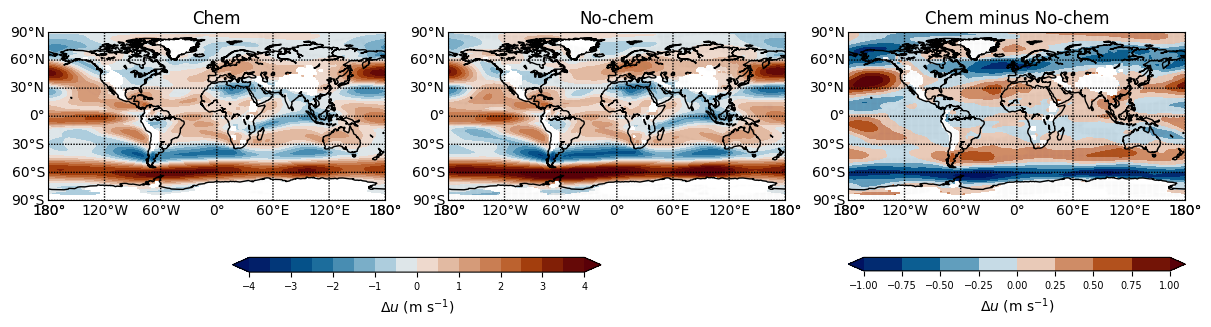

In [110]:
# plot multi-model average
flag_ttest = 1

m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

cmap2 = cmc.vik
norm = mpl.colors.Normalize(vmin=-4, vmax=4)
levels = np.linspace(-4, 4, 17)
levels_diff = np.linspace(-1, 1, 9)

fig,axes = plt.subplots(1,3,figsize=(12,8), constrained_layout = True)

### chem
data_chem, lons = shiftgrid(180.,pairs_chem_avg_850, longitude_pair.get(pairs[0]), start=False)
print("data_chem:", np.max(data_chem), np.min(data_chem))
lons, lats = np.meshgrid(lons, latitude_pair.get(pairs[0]))
x, y = m(lons, lats)

ax = plt.subplot(1,3,1)
ax.set_ylim(-90,90)
ax.set_title("Chem", fontsize = "large")

cs1 = m.contourf(x,y, data_chem, corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap2, levels = levels, extend = "both")

ax.scatter(x[0,strip_pair_chem_avg_lon_850],\
            y[strip_pair_chem_avg_lat_850,0],\
            marker = '.', s=0.0005, c='grey', alpha = 0.5)

m.drawcoastlines(linewidth=1)
m.drawparallels([-90,-60,-30,0,30,60,90],labels=[1,0,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])


### no-chem
data_nonchem, lons = shiftgrid(180.,pairs_nonchem_avg_850, longitude_pair.get(pairs[0]), start=False)
print("data_nonchem:", np.max(data_nonchem), np.min(data_nonchem))
lons, lats = np.meshgrid(lons, latitude_pair.get(pairs[0]))
x, y = m(lons, lats)

ax = plt.subplot(1,3,2)
ax.set_ylim(-90,90)
ax.set_title("No-chem", fontsize = "large")

cs2 = m.contourf(x,y, data_nonchem, corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap2, levels = levels, extend = "both")

ax.scatter(x[0,strip_pair_nonchem_avg_lon_850],\
            y[strip_pair_nonchem_avg_lat_850,0],\
            marker = '.', s=0.0005, c='grey', alpha = 0.5)

m.drawcoastlines(linewidth=1)
m.drawparallels([-90,-60,-30,0,30,60,90],labels=[1,0,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

### chem - no-chem
data_diff, lons = shiftgrid(180.,pairs_chem_avg_850-pairs_nonchem_avg_850,longitude_pair.get(pairs[0]), start=False)
print("data_diff:", np.max(data_diff), np.min(data_diff))
lons, lats = np.meshgrid(lons, latitude_pair.get(pairs[0]))
x, y = m(lons, lats)

ax = plt.subplot(1,3,3)
ax.set_ylim(-90,90)
ax.set_title("Chem minus No-chem", fontsize = "large")

cs3 = m.contourf(x,y, data_diff, corner_mask = False, norm=colors.CenteredNorm(),\
                    cmap=cmap2, levels = levels_diff, extend = "both")

ax.scatter(x[0,strip_pair_diff_avg_lon_850],\
            y[strip_pair_diff_avg_lat_850,0],\
            marker = '.', s=0.0005, c='grey', alpha = 0.5)

m.drawcoastlines(linewidth=1)
m.drawparallels([-90,-60,-30,0,30,60,90],labels=[1,0,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

    
cbar1 = plt.colorbar(cs1, ax=axes[0:2].ravel().tolist(),label = r"$\Delta u$ (m s$^{-1}$)",\
                orientation = 'horizontal', aspect = 25, shrink = 0.5)
cbar2 = plt.colorbar(cs3, ax=axes[2],label = r"$\Delta u$ (m s$^{-1}$)",orientation = 'horizontal',aspect = 25)
cbar1.ax.tick_params(labelsize=7)
cbar2.ax.tick_params(labelsize=7)

fig.savefig('../Output/paper/'+species+'_DJF_reldiff_tm_zm_4CO2_last100yr_avg_850.pdf', bbox_inches = "tight", dpi = 300)

# The following cells compare and plot global mean surface temp.

In [115]:
# read in wtem
wtem_tm_piControl_masked = dict()
wtem_tm_4CO2_masked = dict()
wtem_tm_4CO2_diff = dict()
latitude = dict()
press = dict()

wtem_chem = ["CESM2-WACCM_","GFDL-ESM4_","UKESM1-0-LL_","SOCOLv4_"]
wtem_nochem = ["CESM2_","GFDL-CM4_","HadGEM3-GC31-LL_"]
wtem_model = ["CESM2-WACCM_","GFDL-ESM4_","UKESM1-0-LL_","SOCOLv4_", "CESM2_","GFDL-CM4_","HadGEM3-GC31-LL_"]

path_wtem = "../data/chem_nonchem/wtem/tm_zm"
species = "wtem"

for i in range(0,len(wtem_model)): 
    for f in os.listdir(path_wtem):
        if os.path.isfile(os.path.join(path_wtem,f)) and (wtem_model[i] in f): 
            if experiment[0] in f:
                print(wtem_model[i])
                if "GFDL" not in f:
                    latitude[wtem_model[i]] = nc.Dataset(os.path.join(path_wtem,f)).variables['lat'][:]
                    press[wtem_model[i]] = nc.Dataset(os.path.join(path_wtem,f)).variables['plev'][:]
                    tm_piControl = nc.Dataset(os.path.join(path_wtem,f)).variables[species][:]
                    wtem_tm_piControl_masked[wtem_model[i]] = ma.masked_values(tm_piControl, 1e20)
                    print("pi",wtem_model[i],1000*np.mean(wtem_tm_piControl_masked.get(wtem_model[i])))
                elif ("GFDL" in f) and ("last40yr" in f):
                    latitude[wtem_model[i]] = nc.Dataset(os.path.join(path_wtem,f)).variables['lat'][:]
                    press[wtem_model[i]] = nc.Dataset(os.path.join(path_wtem,f)).variables['plev'][:]
                    tm_piControl = nc.Dataset(os.path.join(path_wtem,f)).variables[species][:]
                    wtem_tm_piControl_masked[wtem_model[i]] = ma.masked_values(tm_piControl, 1e20)
                    print("pi",wtem_model[i],np.mean(wtem_tm_piControl_masked.get(wtem_model[i])))
            
            if experiment[1] in f:
                print(wtem_model[i])
                if ("GFDL" not in f) and ("last100yr" in f):
                    tm_4CO2 = nc.Dataset(os.path.join(path_wtem,f)).variables[species][:]
                    wtem_tm_4CO2_masked[wtem_model[i]] = ma.masked_values(tm_4CO2, 1e20)
                    print("4CO2",wtem_model[i],1000*np.mean(wtem_tm_4CO2_masked.get(wtem_model[i])))
                elif ("GFDL" in f) and ("last40yr" in f):
                    tm_4CO2 = nc.Dataset(os.path.join(path_wtem,f)).variables[species][:]
                    wtem_tm_4CO2_masked[wtem_model[i]] = ma.masked_values(tm_4CO2, 1e20)
                    print("4CO2",wtem_model[i],np.mean(wtem_tm_4CO2_masked.get(wtem_model[i])))

for i in range(0,len(wtem_model)): 
    print(wtem_model[i])
    wtem_tm_4CO2_diff[wtem_model[i]] = \
        wtem_tm_4CO2_masked.get(wtem_model[i]) - wtem_tm_piControl_masked.get(wtem_model[i])
    print("4CO2",wtem_model[i],np.mean(wtem_tm_4CO2_diff.get(wtem_model[i])))
    

CESM2-WACCM_
4CO2 CESM2-WACCM_ -0.4483093636315621
CESM2-WACCM_
CESM2-WACCM_
pi CESM2-WACCM_ -0.3041436068540491
GFDL-ESM4_
GFDL-ESM4_
GFDL-ESM4_
4CO2 GFDL-ESM4_ -0.00047686725119647114
GFDL-ESM4_
pi GFDL-ESM4_ -0.0003874766983933922
UKESM1-0-LL_
4CO2 UKESM1-0-LL_ -0.9200760978587722
UKESM1-0-LL_
UKESM1-0-LL_
pi UKESM1-0-LL_ -0.8981671991994099
SOCOLv4_
4CO2 SOCOLv4_ -0.6655867442074088
SOCOLv4_
pi SOCOLv4_ -0.5912090082042061
CESM2_
4CO2 CESM2_ -1.2177766705254292
CESM2_
CESM2_
pi CESM2_ -inf
GFDL-CM4_
pi GFDL-CM4_ -7.203727883445074e-05
GFDL-CM4_
4CO2 GFDL-CM4_ -0.000477667870630525
HadGEM3-GC31-LL_
pi HadGEM3-GC31-LL_ -0.8164675290995276
HadGEM3-GC31-LL_
HadGEM3-GC31-LL_
4CO2 HadGEM3-GC31-LL_ -0.6447476074728564
CESM2-WACCM_
4CO2 CESM2-WACCM_ -0.000143580194024633
GFDL-ESM4_
4CO2 GFDL-ESM4_ -8.939049295905809e-05
UKESM1-0-LL_
4CO2 UKESM1-0-LL_ -2.1908834418681744e-05
SOCOLv4_
4CO2 SOCOLv4_ -7.437773600320277e-05
CESM2_
4CO2 CESM2_ -9.704901816046554e+31
GFDL-CM4_
4CO2 GFDL-CM4_ -0.0

In [116]:
# compute tropical (20S-20N) average at 70hPa
wtem_tropical_avg_4CO2_diff = dict()
plev = [7000]
band = [-20,20]

for i in range(0,len(wtem_model)):
    print(wtem_model[i])
    ind_band = np.zeros_like(band)
    ind_plev = np.zeros_like(plev)

    for n in range(0,len(plev)):
        ind_plev[n] = np.where(press.get(wtem_model[i]) == plev[n])[0][0]
        print(np.where(press.get(wtem_model[i]) == plev[n])[0][0])
            
    for n in range(0,len(band)):
        ind_band[n] = \
        np.where(abs(latitude.get(wtem_model[i])-band[n]) == min(abs(latitude.get(wtem_model[i])-band[n])))[0][0]
    print(ind_band)

    if wtem_model[i] != "SOCOLv4_":
        wtem_tropical_avg_4CO2_diff[wtem_model[i]] = np.mean(wtem_tm_4CO2_diff.get(wtem_model[i])[0,ind_plev,ind_band[0]:ind_band[1]])*1000 # mm s^-1
    else:
        wtem_tropical_avg_4CO2_diff[wtem_model[i]] = np.mean(wtem_tm_4CO2_diff.get(wtem_model[i])[0,ind_plev,ind_band[1]:ind_band[0]])*1000 # mm s^-1
    print(wtem_model[i], wtem_tropical_avg_4CO2_diff.get(wtem_model[i]))

CESM2-WACCM_
17
[ 74 117]
CESM2-WACCM_ 0.22734034546585968
GFDL-ESM4_
17
[ 69 109]
GFDL-ESM4_ 0.10662798304110765
UKESM1-0-LL_
17
[56 88]
UKESM1-0-LL_ 0.1336901041213423
SOCOLv4_
10
[58 37]
SOCOLv4_ 0.09260221720815068
CESM2_
17
[ 74 117]
CESM2_ 0.4910837079203406
GFDL-CM4_
17
[34 54]
GFDL-CM4_ 0.18812005873769522
HadGEM3-GC31-LL_
17
[56 88]
HadGEM3-GC31-LL_ 0.15569047536700964


In [117]:
# compute tropical (20S-20N) average at 70hPa
wtem_tropical_avg_4CO2_diff = dict()
plev = [7000]
band = [-20,20]

for i in range(0,len(wtem_model)):
    print(wtem_model[i])
    ind_band = np.zeros_like(band)
    ind_plev = np.zeros_like(plev)

    for n in range(0,len(plev)):
        ind_plev[n] = np.where(press.get(wtem_model[i]) == plev[n])[0][0]
        print(np.where(press.get(wtem_model[i]) == plev[n])[0][0])
            
    for n in range(0,len(band)):
        ind_band[n] = \
        np.where(abs(latitude.get(wtem_model[i])-band[n]) == min(abs(latitude.get(wtem_model[i])-band[n])))[0][0]
    print(ind_band)

    wtem_tropical_avg_4CO2_diff[wtem_model[i]] = np.mean(wtem_tm_4CO2_diff.get(wtem_model[i])[0,ind_plev,ind_band[0]:ind_band[1]])*1000 # mm s^-1
    print(wtem_model[i], wtem_tropical_avg_4CO2_diff.get(wtem_model[i]))

CESM2-WACCM_
17
[ 74 117]
CESM2-WACCM_ 0.22734034546585968
GFDL-ESM4_
17
[ 69 109]
GFDL-ESM4_ 0.10662798304110765
UKESM1-0-LL_
17
[56 88]
UKESM1-0-LL_ 0.1336901041213423
SOCOLv4_
10
[58 37]
SOCOLv4_ nan
CESM2_
17
[ 74 117]
CESM2_ 0.4910837079203406
GFDL-CM4_
17
[34 54]
GFDL-CM4_ 0.18812005873769522
HadGEM3-GC31-LL_
17
[56 88]
HadGEM3-GC31-LL_ 0.15569047536700964


The following cells compare and plot global mean surface temp.

In [118]:
# single pair comparison

# read in tm_glbm tas

tas_tm_glbm_piControl_masked = dict()
tas_tm_glbm_4CO2_masked = dict()
tas_tm_glbm_1pct_masked = dict()

tas_tm_glbm_4CO2_diff = dict()
tas_tm_glbm_1pct_diff = dict()

path_tas_tm_glbm = "../data/T_surf/tm_global_mean"
species = "tas"

for i in range(0,len(pairs)): 
    for f in os.listdir(path_tas_tm_glbm):
        if os.path.isfile(os.path.join(path_tas_tm_glbm,f)) and (pairs[i] in f): 
            if experiment[0] in f:
                tm_glbm_piControl = nc.Dataset(os.path.join(path_tas_tm_glbm,f)).variables[species][:]
                tas_tm_glbm_piControl_masked[pairs[i]] = ma.masked_values(tm_glbm_piControl, 1e20)
                print("pi",pairs[i],tas_tm_glbm_piControl_masked.get(pairs[i]))
            
            if experiment[1] in f and ("last100yr" in f):
                tm_glbm_4CO2 = nc.Dataset(os.path.join(path_tas_tm_glbm,f)).variables[species][:]
                tas_tm_glbm_4CO2_masked[pairs[i]] = ma.masked_values(tm_glbm_4CO2, 1e20)
                print("4CO2",pairs[i],tas_tm_glbm_4CO2_masked.get(pairs[i]))
            
            if experiment[2] in f and ("135-145" in f):
                tm_glbm_1pct = nc.Dataset(os.path.join(path_tas_tm_glbm,f)).variables[species][:]
                tas_tm_glbm_1pct_masked[pairs[i]] = ma.masked_values(tm_glbm_1pct, 1e20)
                print("1pct",pairs[i],tas_tm_glbm_1pct_masked.get(pairs[i]))

### read in corrected 1pct data for GISS-E2-1-G p1
GISS_p1_tas_glbm_am = 273.15+ np.array([13.7759, 13.7214, 13.8615, 13.6097, 13.5574, 13.6457, 13.6747, 13.7541, 13.9136, 13.9,
13.8859, 13.5969, 13.8012, 14.1421, 14.1661, 13.8352, 13.9692, 14.2386, 14.0309, 14.0961,
14.024, 14.2373, 14.3211, 14.0615, 14.0678, 14.2974, 14.5014, 14.2047, 14.1824, 14.3894,
14.5046, 14.3193, 14.2172, 14.4205, 14.6207, 14.4625, 14.378, 14.519, 14.7152, 14.8244,
14.6498, 14.3796, 14.5353, 14.7143, 14.8757, 14.5812, 14.6638, 14.9565, 14.8491, 14.8671,
15.0249, 14.7378, 14.8617, 15.0387, 15.1529, 15.035, 14.9576, 14.9521, 15.1108, 15.0408,
14.9759, 15.0375, 15.1741, 15.2811, 15.1582, 15.0662, 15.2512, 15.4408, 15.2578, 15.2654,
15.5307, 15.3508, 15.2011, 15.5247, 15.6239, 15.4065, 15.3475, 15.5095, 15.7365, 15.6639,
15.574, 15.7905, 15.8128, 15.6402, 15.8565, 15.8656, 15.5958, 15.6378, 15.9697, 16.0459,
15.7513, 15.8808, 16.2097, 16.0138, 15.958, 16.3075, 16.3016, 15.925, 16.1976, 16.3788,
16.2525, 16.4134, 16.3271, 16.0413, 16.1487, 16.5109, 16.6409, 16.5782, 16.5852, 16.5001,
16.5129, 16.6967, 16.7782, 16.4073, 16.4742, 16.6764, 16.7434, 16.844, 16.6106, 16.7496,
16.9812, 16.6707, 16.7729, 17.0045, 16.9774, 16.8756, 17.0902, 17.1558, 17.0607, 17.0193,
17.1863, 17.1965, 17.039, 17.1178, 17.3883, 17.4351, 17.4068, 17.4315, 17.403, 17.4842,
17.5652, 17.3657, 17.4467, 17.6203, 17.5673, 17.6436, 17.4523, 17.3115, 17.6024, 17.7059,
17.3536])

tas_tm_glbm_1pct_masked["GISS-E2-1-G_p1_"] = np.mean(GISS_p1_tas_glbm_am[134:145])


for i in range(0,len(pairs)): 
    print(pairs[i])
    tas_tm_glbm_4CO2_diff[pairs[i]] = \
        tas_tm_glbm_4CO2_masked.get(pairs[i]) - tas_tm_glbm_piControl_masked.get(pairs[i])
    print("4CO2",pairs[i],tas_tm_glbm_4CO2_diff.get(pairs[i]))
    
    tas_tm_glbm_1pct_diff[pairs[i]] = \
        tas_tm_glbm_1pct_masked.get(pairs[i]) - tas_tm_glbm_piControl_masked.get(pairs[i])
    print("1pct",pairs[i],tas_tm_glbm_1pct_diff.get(pairs[i]))

1pct CESM2-WACCM_ [[[292.02377]]]
4CO2 CESM2-WACCM_ [[[293.06335]]]
pi CESM2-WACCM_ [[[286.9917]]]
1pct CESM2-WACCM-FV2_ [[[292.19302]]]
4CO2 CESM2-WACCM-FV2_ [[[292.89066]]]
pi CESM2-WACCM-FV2_ [[[287.23605]]]
1pct SOCOLv4_ [[[290.5967]]]
4CO2 SOCOLv4_ [[[291.00967]]]
pi SOCOLv4_ [[[286.54633]]]
1pct GFDL-ESM4_ [[[290.30356]]]
1pct GFDL-ESM4_ [[[290.30356]]]
4CO2 GFDL-ESM4_ [[[290.64914]]]
pi GFDL-ESM4_ [[[286.5281]]]
1pct UKESM1-0-LL_ [[[293.09842]]]
4CO2 UKESM1-0-LL_ [[[293.85065]]]
pi UKESM1-0-LL_ [[[286.55362]]]
4CO2 GISS-E2-1-G_p3_ [[[290.9267]]]
1pct GISS-E2-1-G_p3_ [[[290.97864]]]
pi GISS-E2-1-G_p3_ [[[287.29886]]]
pi GISS-E2-2-G_p3_ [[[284.83475]]]
4CO2 GISS-E2-2-G_p3_ [[[287.97977]]]
1pct CESM2_ [[[292.40915]]]
4CO2 CESM2_ [[[293.76413]]]
pi CESM2_ [[[286.92084]]]
1pct CESM2-FV2_ [[[292.07657]]]
4CO2 CESM2-FV2_ [[[293.1412]]]
pi CESM2-FV2_ [[[287.11813]]]
1pct MPI-ESM1-2-LR_ [[[290.97055]]]
pi MPI-ESM1-2-LR_ [[[286.66486]]]
4CO2 MPI-ESM1-2-LR_ [[[291.40045]]]
1pct GFDL-CM4_ [

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [ ]:
# compute the difference of tas_glbm response between each pair

pairs_tas_glbm_diff_4CO2 = dict()
pairs_tas_glbm_diff_1pct = dict()

for i in range(0,len(chem_pair)):
    idx_chem = pairs.index(chem_pair[i])
    idx_nonchem = pairs.index(nonchem_pair[i])
    print(pairs[i])
    
    pairs_tas_glbm_diff_4CO2[pairs[idx_chem]] = \
        tas_tm_glbm_4CO2_diff.get(pairs[idx_chem]) - tas_tm_glbm_4CO2_diff.get(pairs[idx_nonchem])
    print("4CO2",pairs_tas_glbm_diff_4CO2.get(pairs[idx_chem]))
    
    pairs_tas_glbm_diff_1pct[pairs[idx_chem]] = \
        tas_tm_glbm_1pct_diff.get(pairs[idx_chem]) - tas_tm_glbm_1pct_diff.get(pairs[idx_nonchem])
    print("1pct",pairs_tas_glbm_diff_1pct.get(pairs[idx_chem]))

In [ ]:
# multi-model comparison

pairs_chem_4CO2_sum = 0
pairs_nonchem_4CO2_sum = 0
pairs_chem_1pct_sum = 0
pairs_nonchem_1pct_sum = 0

pairs_chem_4CO2_avg = 0
pairs_nonchem_4CO2_avg = 0
pairs_chem_1pct_avg = 0
pairs_nonchem_1pct_avg = 0

# sum of the tas response for chem and no-chem separately
pairs_chem_4CO2_sum = tas_tm_glbm_4CO2_diff.get(pairs[0])
pairs_nonchem_4CO2_sum = tas_tm_glbm_4CO2_diff.get(pairs[len(chem_pair)])
pairs_chem_1pct_sum = tas_tm_glbm_1pct_diff.get(pairs[0])
pairs_nonchem_1pct_sum = tas_tm_glbm_1pct_diff.get(pairs[len(chem_pair)])

for i in range(1,len(chem_pair)):
    print(pairs[i])
    print(tas_tm_glbm_4CO2_diff.get(pairs[len(chem_pair)+i]))
    pairs_chem_4CO2_sum += tas_tm_glbm_4CO2_diff.get(pairs[i])
    pairs_nonchem_4CO2_sum += tas_tm_glbm_4CO2_diff.get(pairs[len(chem_pair)+i])

# omit GISS pair for 1pct
for i in range(1,len(chem_pair)):
    print(pairs[i])
    #if "GISS" not in pairs[i]:
    print(tas_tm_glbm_1pct_diff.get(pairs[len(chem_pair)+i]))
    pairs_chem_1pct_sum += tas_tm_glbm_1pct_diff.get(pairs[i])
    pairs_nonchem_1pct_sum += tas_tm_glbm_1pct_diff.get(pairs[len(chem_pair)+i])

# avg of the sum 
pairs_chem_4CO2_avg = pairs_chem_4CO2_sum/(len(chem_pair))
print("4CO2 avg chem",pairs_chem_4CO2_avg)
pairs_nonchem_4CO2_avg = pairs_nonchem_4CO2_sum/(len(nonchem_pair))
print("4CO2 avg nochem",len(nonchem_pair),pairs_nonchem_4CO2_avg)
# diff of avg_chem and avg_no-chem
pairs_4CO2_diff = pairs_chem_4CO2_avg - pairs_nonchem_4CO2_avg
print("4CO2 avg diff",pairs_4CO2_diff)

pairs_chem_1pct_avg = pairs_chem_1pct_sum/(len(chem_pair))
print("1pct avg chem",pairs_chem_1pct_avg)
pairs_nonchem_1pct_avg = pairs_nonchem_1pct_sum/(len(nonchem_pair))
print("1pct avg nochem",pairs_nonchem_1pct_avg)
pairs_1pct_diff = pairs_chem_1pct_avg - pairs_nonchem_1pct_avg
print("1pct avg diff",pairs_1pct_diff)

# compute std of the avg of pair_difference
pairs_tas_glbm_diff_4CO2.append(-0.51)
pairs_4CO2_avg_std = np.std(np.fromiter(pairs_tas_glbm_diff_4CO2.values(),dtype=float))
print("4CO2 std",pairs_4CO2_avg_std)
pairs_1pct_avg_std = np.std(np.fromiter(pairs_tas_glbm_diff_1pct.values(),dtype=float))
print("1pct std",pairs_1pct_avg_std)

In [ ]:
np.std([-0.77,-0.37,-1.36,-0.18,-0.51,-0.17,-0.27])